In [1]:
import pickle, json, requests, csv, copy, os
from json import JSONDecodeError
from text_to_uri import *
import numpy as np
import pprint as pp
import urllib.request, urllib.parse

In [2]:
rel_list = ['/r/IsA', '/rr/IsA', '/r/PartOf', '/rr/PartOf', '/r/AtLocation', '/rr/AtLocation', '/r/RelatedTo']

In [3]:
class_uri = ['/c/en/company',
            '/c/en/education',
            '/c/en/artist',
            '/c/en/athlete',
            '/c/en/officer',
            '/c/en/transport',
            '/c/en/building',
            '/c/en/nature',
            '/c/en/village',
            '/c/en/animal',
            '/c/en/plant',
            '/c/en/album',
            '/c/en/film',
            '/c/en/writing']

In [3]:
class_uri = ['/c/en/app', #
             '/c/en/appliance', #
             '/c/en/art', #
             '/c/en/automotive', 
             '/c/en/baby',
             '/c/en/bag',
             '/c/en/beauty',
             '/c/en/bike',
             '/c/en/book', #
             '/c/en/cable',
             '/c/en/care',
             '/c/en/clothing',
             '/c/en/conditioner',
             '/c/en/diaper',
             '/c/en/dining',
             '/c/en/dumbbell',
             '/c/en/flashlight',
             '/c/en/food',
             '/c/en/glove', #
             '/c/en/golf',
             '/c/en/home', #
             '/c/en/supplies', # 
             '/c/en/jewelry',
             '/c/en/kindle', # 
             '/c/en/kitchen',
             '/c/en/knife',
             '/c/en/luggage',
             '/c/en/magazine', #
             '/c/en/mat',
             '/c/en/mattress',
             '/c/en/movies',
             '/c/en/music',
             '/c/en/instrument', #
             '/c/en/office', #
             '/c/en/garden', #
             '/c/en/pet', #
             '/c/en/pillow',
             '/c/en/sandal',
             '/c/en/scooter',
             '/c/en/shoes',
             '/c/en/software',
             '/c/en/sports',
             '/c/en/table', #
             '/c/en/tent',
             '/c/en/tire',
             '/c/en/toy', #
             '/c/en/video_game', #
             '/c/en/vitamin', #
             '/c/en/clock', #
             '/c/en/filter'] #

In [18]:
class_uri = ['/c/en/atheism',
            '/c/en/graphics',
            '/c/en/operating_system',
            '/c/en/ibm',
            '/c/en/mac',
            '/c/en/windows',
            '/c/en/sale',
            '/c/en/auto',
            '/c/en/motorcycle',
            '/c/en/baseball',
            '/c/en/hockey',
            '/c/en/crypt',
            '/c/en/electronics',
            '/c/en/medical',
            '/c/en/space',
            '/c/en/christian',
            '/c/en/gun',
            '/c/en/middle_east',
            '/c/en/politics',
            '/c/en/religion']

In [3]:
class_uri = ['/c/en/monitor',
             '/c/en/watch',
             '/c/en/blu_ray',
             '/c/en/cd_player',
             '/c/en/network',
             '/c/en/battery',
             '/c/en/graphics_card',
             '/c/en/xbox',
             '/c/en/telephone',
             '/c/en/car_stereo',
             '/c/en/video_recorder',
             '/c/en/alarm_clock',
             '/c/en/camera',
             '/c/en/camcorder',
             '/c/en/hard_drive',
             '/c/en/home_theater_system',
             '/c/en/subwoofer',
             '/c/en/rice_cooker',
             '/c/en/webcam',
             '/c/en/kindle',
             '/c/en/scanner',
             '/c/en/radar_detector',
             '/c/en/vacuum',
             '/c/en/cable_modem',
             '/c/en/cellphone',
             '/c/en/wireless_router',
             '/c/en/printer',
             '/c/en/fan',
             '/c/en/amplifier',
             '/c/en/microwave',
             '/c/en/gps',
             '/c/en/microphone',
             '/c/en/tv',
             '/c/en/projector',
             '/c/en/mouse',
             '/c/en/recorder',
             '/c/en/memory_card',
             '/c/en/iron',
             '/c/en/laptop',
             '/c/en/headphone',
             '/c/en/video',
             '/c/en/mp3_player',
             '/c/en/keyboard',
             '/c/en/tablet',
             '/c/en/media_player',
             '/c/en/lamp',
             '/c/en/remote_control',
             '/c/en/speaker',
             '/c/en/computer',
             '/c/en/dvd']

In [4]:
class Path:
    
    def __init__(self): # Create an empty path
        self.path_uri = ''
        self.start = None
        self.end = None
        self.length = 0
        self.edges = []
        self.weights = []
        self.nodes = []
        
    def __repr__(self):
        return self.path_uri + ' (' + ','.join([str(x) for x in self.weights]) + ')'
        
    def create_unit_node_path(uri):
        p = Path()
        p.path_uri = uri
        p.start = uri
        p.end = uri
        p.length = 0
        p.edges = []
        p.weights = []
        p.nodes = [uri]
        return p
    
    def create_path_from_edge(sub, rel, obj, weight):
        p = Path()
        p.path_uri = sub + '$' + rel + '$' + obj
        p.start = sub
        p.end = obj
        p.length = 1
        p.edges = [rel]
        p.weights = [weight]
        p.nodes = [sub, obj]
        return p
    
    def concatenate(pa, pb):
        assert pa.end == pb.start, "Cannot concatenate as the end of the first path is not the start of the second path"
        if pb.length == 0:
            return copy.copy(pa)
        if pa.length == 0:
            return copy.copy(pb)
        
        p = Path()
        p.path_uri = pa.path_uri + pb.path_uri[pb.path_uri.find('$'):]
        p.start = pa.start
        p.end = pb.end
        p.length = pa.length + pb.length
        p.edges = list(pa.edges)
        p.edges.extend(pb.edges)
        p.weights = list(pa.weights)
        p.weights.extend(pb.weights)
        p.nodes = list(pa.nodes)
        p.nodes.extend(pb.nodes[1:])
        assert len(p.edges) + 1 == len(p.nodes), "Nodes and edges are inconsistent"
        
        return p
    
    def is_simple_path(self): # Visit each node only once
        return len(set(self.nodes)) == len(self.nodes)
    
    def form_single_path_with(self, p):
        assert self.end == p.start
        if (not self.is_simple_path()) or (not p.is_simple_path()):
            return False
        nodes = list(self.nodes)
        nodes.extend(p.nodes[1:])
        return len(set(nodes)) == len(nodes) 
    
    def average_weight(self):
        if self.weights == []:
            return 1.0
        return Path.geo_mean(self.weights)
    
    def geo_mean(iterable):
        a = np.array(iterable)
        return a.prod()**(1.0/len(a))

In [55]:
PATHS_FROM = {}

In [5]:
PATHS_FROM = pickle.load(open("../wordEmbeddings/PATHS_FROM_01.pickle", "rb"))

In [6]:
def find_edges_of(uri, rel_list = None):
    edges = []
    with open('../wordEmbeddings/conceptnet-assertions-en-filter-5.6.0.csv', 'r', encoding = "utf8") as csvfile:
        reader = csv.reader(csvfile, delimiter='\t')
        for line in reader:
            if uri == line[2] or uri + '/' in line[2] or uri == line[3] or uri + '/' in line[3]:
                if rel_list is None or line[1] in rel_list:
                    details = json.loads(line[4])
                    w = details['weight']
                    edges.append({'sub': line[2],
                                 'rel': line[1],
                                 'obj': line[3],
                                 'weight': w})
    return edges

In [7]:
def get_neighbors(uri, rel_list = None):
    neighbors = {}
    edge_list = find_edges_of(uri, rel_list)
    neighbors = process_edges(neighbors, uri, edge_list)
    return neighbors

In [8]:
def remove_word_sense(sub):
    if sub.count('/') > 3:
        if sub.count('/') > 4:
            print(sub)
            assert False, "URI error (with more than 4 slashes)"
        sub = sub[:sub.rfind('/')]
    return sub

In [9]:
def process_edges(a_dict, uri, edge_data):
    for e in edge_data:
        sub = remove_word_sense(e['sub'])
        rel = e['rel']
        obj = remove_word_sense(e['obj'])
        weight = e['weight']
        if weight < 1 or sub == obj:
            continue
        if sub == uri:
            if obj in a_dict:
                if rel in a_dict[obj]:
                    a_dict[obj][rel] = max(a_dict[obj][rel], weight)
                else:
                    a_dict[obj][rel] = weight
            else:
                a_dict[obj] = { rel:weight }
        elif obj == uri:
            if rel != '/r/RelatedTo': # Bi-directional
                rel = rel.replace('/r/', '/rr/', 1)
            if sub in a_dict:
                if rel in a_dict[sub]:
                    a_dict[sub][rel] = max(a_dict[sub][rel], weight)
                else:
                    a_dict[sub][rel] = weight
            else:
                a_dict[sub] = { rel:weight }
        else:
            print(e)
            assert False, "This edge does not belong to the given uri"
    return a_dict        

In [10]:
def get_all_paths_from(uri, hops):
    global PATHS_FROM
    assert hops >= 0, "Invalid hops (less than 0)"
    
    if uri in PATHS_FROM and hops in PATHS_FROM[uri]:
        return PATHS_FROM[uri][hops]
    
    if uri not in PATHS_FROM:
        PATHS_FROM[uri] = {}
        
    if hops == 0:
        PATHS_FROM[uri][hops] = [Path.create_unit_node_path(uri)]
    elif hops == 1:
        all_paths = []
        neighbors = get_neighbors(uri)
        for end, edges in neighbors.items():
            for r, w in edges.items():
                all_paths.append(Path.create_path_from_edge(uri, r, end, w))
        PATHS_FROM[uri][hops] = all_paths
    else: # hops > 1
        all_paths = []
        previous_paths = get_all_paths_from(uri, hops - 1)
        for p in previous_paths:
            one_hop_paths = get_all_paths_from(p.end, 1)
            for unit_path in one_hop_paths:
                if p.form_single_path_with(unit_path):
                    new_path = Path.concatenate(p, unit_path)
                    if new_path.average_weight() < 1:
                        continue
                    all_paths.append(new_path)
        if hops <= 2: 
            PATHS_FROM[uri][hops] = all_paths
        else:
            pickle.dump(all_paths, open("../wordEmbeddings/PATHS_FROM_"+uri[uri.rfind('/')+1:]+"_"+str(hops)+".pickle", "wb"))
            print('Finish dump all paths from %s with hops = %d, number of paths = %d' % (uri, hops, len(all_paths)))
            return all_paths
    print('Memorise all paths from %s with hops = %d, number of paths = %d' % (uri, hops, len(PATHS_FROM[uri][hops])))
                    
    return PATHS_FROM[uri][hops]

In [11]:
def get_kg_vectors_for_a_class(uri, max_hops, rel_list):
    total_rel = len(rel_list)
    vector_size = int(((total_rel ** (max_hops + 1)) - 1)/(total_rel - 1)) # Total size of vector
    all_paths = []
    for i in range(max_hops+1):
        all_paths.extend(get_all_paths_from(uri, i))
    
    end_dict = {}
    for p in all_paths:
        assert p.start == uri, "The start node is not the given class"
        if p.end in end_dict:
            end_dict[p.end].append(p)
        else:
            end_dict[p.end] = [p]
    
    vectors = {}
    for end, paths in end_dict.items():
        v = np.zeros(vector_size) 
        for p in paths:
            if p.edges == []:
                v[-1] += 1
            else:
                v[get_index_from_edges(p.edges, max_hops, rel_list)] += p.average_weight()
        vectors[end] = v
    
    return vectors

In [12]:
def get_correlation_matrix(class_uri, max_hops, rel_list):
    ans = np.zeros((len(class_uri), len(class_uri)))
    for c in class_uri:
        all_paths = []
        for i in range(max_hops+1):
            all_paths.extend(get_all_paths_from(c, i))
        all_paths.extend(pickle.load(open("../wordEmbeddings/PATHS_FROM_"+ c[c.rfind('/')+1:] +"_3.pickle", "rb")))
        end_dict = {}
        for p in all_paths:
            assert p.start == c, "The start node is not the given class"
            if p.end not in class_uri:
                continue
            if p.end == c:
                print(p)
            if p.end in end_dict:
                end_dict[p.end].append(p)
            else:
                end_dict[p.end] = [p]
#         print(end_dict)
        for end, paths in end_dict.items():
#             ans[class_uri.index(c)][class_uri.index(end)] = np.sum([p.average_weight() for p in paths])
            val = min([p.length for p in paths])
            if val is None:
                val = 0.0
            ans[class_uri.index(c)][class_uri.index(end)] = val
        print('Finish running class', c)
    return ans
        

In [88]:
class_uri = [c for c in class_uri if np.random.rand() > 0.5]

In [90]:
print(len(class_uri))

27


In [19]:
# print(class_uri)
CorrScore2 = get_correlation_matrix(class_uri, 2, rel_list)
print(CorrScore2)

Memorise all paths from /c/en/atheism with hops = 2, number of paths = 1469
/c/en/atheism ()
/c/en/atheism$/r/RelatedTo$/c/en/atheism (0.5)
Finish running class /c/en/atheism
Memorise all paths from /c/en/graphics with hops = 2, number of paths = 4731
/c/en/graphics ()
Finish running class /c/en/graphics
Memorise all paths from /c/en/operating_system with hops = 2, number of paths = 7499
/c/en/operating_system ()
Finish running class /c/en/operating_system
Memorise all paths from /c/en/ibm with hops = 2, number of paths = 2255
/c/en/ibm ()
Finish running class /c/en/ibm
Memorise all paths from /c/en/mac with hops = 2, number of paths = 4870
/c/en/mac ()
Finish running class /c/en/mac
Memorise all paths from /c/en/windows with hops = 2, number of paths = 4846
/c/en/windows ()
Finish running class /c/en/windows
Memorise all paths from /c/en/sale with hops = 2, number of paths = 10539
/c/en/sale ()
Finish running class /c/en/sale
Memorise all paths from /c/en/auto with hops = 2, number of

In [14]:
import matplotlib.pyplot as plt

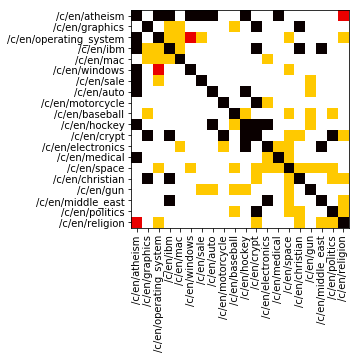

In [20]:
plt.imshow(CorrScore2, cmap='hot', interpolation='nearest')
plt.yticks(range(len(class_uri)), class_uri)
plt.xticks(range(len(class_uri)), class_uri)
plt.xticks(rotation=90)
plt.show()

In [68]:
CorrSoft = []
for row in Corr:
#     sumR = np.sum(row)
    CorrSoft.append(softmax(row))
CorrSoft = np.array(CorrSoft)

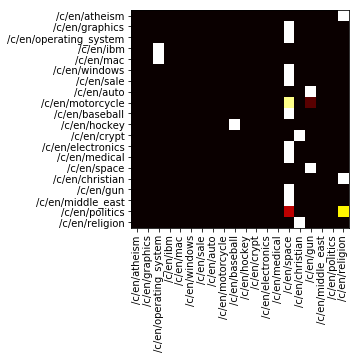

In [69]:
plt.imshow(CorrSoft, cmap='hot', interpolation='nearest')
plt.yticks(range(len(CorrSoft)), class_uri)
plt.xticks(range(len(CorrSoft)), class_uri)
plt.xticks(rotation=90)
plt.show()

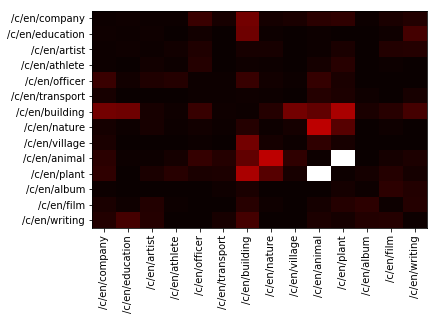

In [120]:
plt.imshow(CorrScore, cmap='hot', interpolation='nearest', aspect='auto')
plt.yticks(range(len(CorrScore)), class_uri)
plt.xticks(range(len(CorrScore)), class_uri)
plt.xticks(rotation=90)
# plt.figure(figsize = (27,27))
plt.figure(figsize=(3,4))
plt.show()

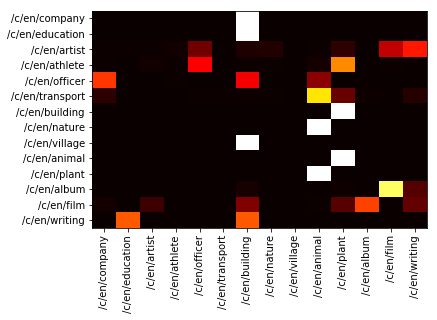

In [121]:
plt.imshow(np.array([softmax(row) for row in CorrScore]), cmap='hot', interpolation='nearest', aspect='auto')
plt.yticks(range(len(CorrScore)), class_uri)
plt.xticks(range(len(CorrScore)), class_uri)
plt.xticks(rotation=90)
# plt.colorbar(heatmap)
plt.show()



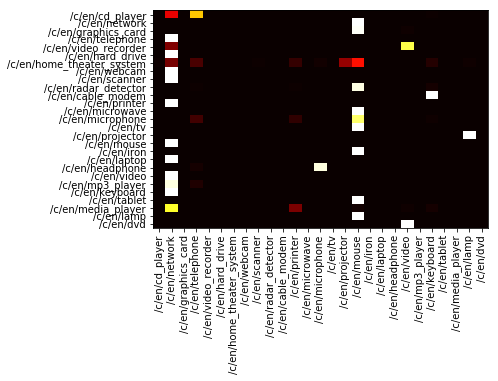

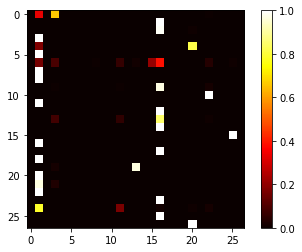

In [103]:
fig, ax = plt.subplots()
cax = ax.imshow(np.array([softmax(row) for row in CorrScore]), interpolation='nearest', cmap='hot')
cbar = fig.colorbar(cax)
plt.show()

In [13]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x) / np.sum(np.exp(x), axis=0)

In [14]:
def get_index_from_edges(edges, max_hops, rel_list):
    assert len(edges) <= max_hops, "The path is longer than the given max_hops"
    total_rel = len(rel_list)
    
    if edges == []:
        return sum([total_rel ** i for i in range(1, max_hops+1)]) # The last index refers to itself
    
    index = 0
    for i, e in enumerate(reversed(edges)):
        if e not in rel_list:
            assert False, "Found an unsupported relation" + e
        index += (total_rel ** i) * rel_list.index(e)
    return index

In [15]:
def get_kg_vectors_for_classes(class_uri, max_hops, rel_list):
    V = {}
    for uri in class_uri:
        V[uri] = get_kg_vectors_for_a_class(uri, max_hops, rel_list)
        print('Finish producing vectors of class', uri, 'Max hops', max_hops)
    return V

In [16]:
def init_PATHS_FROM(rel_list):
    with open('../wordEmbeddings/conceptnet-assertions-en-filter-5.6.0.csv', 'r', encoding = "utf8") as csvfile:
        reader = csv.reader(csvfile, delimiter='\t')
        i = 0
        for line in reader:
            if i%10000 == 0:
                print('Process line %d' % i)
            if rel_list is None or line[1] in rel_list:
                details = json.loads(line[4])
                weight = details['weight']
                sub = remove_word_sense(line[2])
                rel = line[1]
                obj = remove_word_sense(line[3])
                
                if sub not in PATHS_FROM:
                    PATHS_FROM[sub] = {0: [Path.create_unit_node_path(sub)], 1: []}
                if obj not in PATHS_FROM:
                    PATHS_FROM[obj] = {0: [Path.create_unit_node_path(obj)], 1: []}
                    
                if sub == obj: # self-loop
                    continue
                    
                # path from subject
                done_subject = False
                expected_path_uri = sub + '$' + rel + '$' + obj
                for p in PATHS_FROM[sub][1]:
                    if p.path_uri == expected_path_uri:
                        p.weights[0] = max(p.weights[0], weight)
                        done_subject = True
                        break
                if not done_subject:
                    PATHS_FROM[sub][1].append(Path.create_path_from_edge(sub, rel, obj, weight))
                
                # path from object
                if rel != '/r/RelatedTo': # Bi-directional
                    rel = rel.replace('/r/', '/rr/', 1)
                    
                done_object = False
                expected_path_uri = obj + '$' + rel + '$' + sub
                for p in PATHS_FROM[obj][1]:
                    if p.path_uri == expected_path_uri:
                        p.weights[0] = max(p.weights[0], weight)
                        done_object = True
                        break
                if not done_object:
                    PATHS_FROM[obj][1].append(Path.create_path_from_edge(obj, rel, sub, weight))
            i += 1   
                    

In [56]:
init_PATHS_FROM(rel_list)

Process line 0
Process line 10000
Process line 20000
Process line 30000
Process line 40000
Process line 50000
Process line 60000
Process line 70000
Process line 80000
Process line 90000
Process line 100000
Process line 110000
Process line 120000
Process line 130000
Process line 140000
Process line 150000
Process line 160000
Process line 170000
Process line 180000
Process line 190000
Process line 200000
Process line 210000
Process line 220000
Process line 230000
Process line 240000
Process line 250000
Process line 260000
Process line 270000
Process line 280000
Process line 290000
Process line 300000
Process line 310000
Process line 320000
Process line 330000
Process line 340000
Process line 350000
Process line 360000
Process line 370000
Process line 380000
Process line 390000
Process line 400000
Process line 410000
Process line 420000
Process line 430000
Process line 440000
Process line 450000
Process line 460000
Process line 470000
Process line 480000
Process line 490000
Process line 5

In [21]:
V = {}
for uri in class_uri: # KG_VECTORS_3
    V[uri] = get_kg_vectors_for_a_class(uri, max_hops = 3, rel_list = rel_list)
    print('Finish producing vectors of class', uri, 'Max hops', 3)
    pickle.dump(V[uri], open("../wordEmbeddings/review/KG_VECTORS_3_elec_"+ uri[uri.rfind('/')+1:]+".pickle", "wb"))
# pickle.dump(V, open("../wordEmbeddings/KG_VECTORS_3_20newsgroup.pickle", "wb"))
# pickle.dump(V, open("../wordEmbeddings/review/KG_VECTORS_3_"+ uri[uri.rfind('/')+1:]+".pickle", "wb"))

Memorise all paths from /c/en/monitor with hops = 2, number of paths = 8902
Finish dump all paths from /c/en/monitor with hops = 3, number of paths = 638219
Finish producing vectors of class /c/en/monitor Max hops 3
Memorise all paths from /c/en/watch with hops = 2, number of paths = 17420
Finish dump all paths from /c/en/watch with hops = 3, number of paths = 1315637
Finish producing vectors of class /c/en/watch Max hops 3
Memorise all paths from /c/en/blu_ray with hops = 2, number of paths = 44
Finish dump all paths from /c/en/blu_ray with hops = 3, number of paths = 6348
Finish producing vectors of class /c/en/blu_ray Max hops 3
Memorise all paths from /c/en/cd_player with hops = 2, number of paths = 2982
Finish dump all paths from /c/en/cd_player with hops = 3, number of paths = 159090
Finish producing vectors of class /c/en/cd_player Max hops 3
Memorise all paths from /c/en/network with hops = 2, number of paths = 21083
Finish dump all paths from /c/en/network with hops = 3, numbe

Finish dump all paths from /c/en/iron with hops = 3, number of paths = 10943281
Finish producing vectors of class /c/en/iron Max hops 3
Memorise all paths from /c/en/laptop with hops = 2, number of paths = 3101
Finish dump all paths from /c/en/laptop with hops = 3, number of paths = 178910
Finish producing vectors of class /c/en/laptop Max hops 3
Memorise all paths from /c/en/headphone with hops = 2, number of paths = 41
Finish dump all paths from /c/en/headphone with hops = 3, number of paths = 4568
Finish producing vectors of class /c/en/headphone Max hops 3
Memorise all paths from /c/en/video with hops = 2, number of paths = 6693
Finish dump all paths from /c/en/video with hops = 3, number of paths = 496916
Finish producing vectors of class /c/en/video Max hops 3
Memorise all paths from /c/en/mp3_player with hops = 2, number of paths = 956
Finish dump all paths from /c/en/mp3_player with hops = 3, number of paths = 34479
Finish producing vectors of class /c/en/mp3_player Max hops 3


In [20]:
V = {}
for uri in class_uri: # KG_VECTORS_3
    V[uri] = pickle.load(open("../wordEmbeddings/review_elec/KG_VECTORS_3_elec_"+ uri[uri.rfind('/')+1:]+".pickle", "rb")) 

In [53]:
for uri in V:
    pickle.dump(V[uri], open("../wordEmbeddings/newsgroup/KG_VECTORS_3_"+ uri[uri.rfind('/')+1:]+".pickle", "wb"))

In [3]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
aaa = "developing"
print(nltk.pos_tag([aaa]))
print(lemmatizer.lemmatize("princess"))
print(lemmatizer.lemmatize("reviewer", 'n'))
print(lemmatizer.lemmatize("original", 'a'))
print(lemmatizer.lemmatize("brightness", 'n'))
print(lemmatizer.lemmatize("packaging", 'v'))
print(lemmatizer.lemmatize("better", 'v'))
print(lemmatizer.lemmatize("quicklier", 'r'))
print(lemmatizer.lemmatize("ran", 'v'))
print(lemmatizer.lemmatize(aaa))

[('developing', 'VBG')]
princess
reviewer
original
brightness
package
better
quicklier
run
developing


In [4]:
words = ['princesses', 'packaging', 'adjustment', 'player', 'surprised']
for w in words:
    tag = nltk.pos_tag([w])[0][1]
    print(pos_dict[tag], lemmatizer.lemmatize(w, pos_dict[tag]))

n princess
n packaging
n adjustment
n player
a surprised


In [65]:
from nltk.stem import SnowballStemmer
snowball_stemmer = SnowballStemmer('english')

print(snowball_stemmer.stem("cats"))
print(snowball_stemmer.stem("cacti"))
print(snowball_stemmer.stem("geese"))
print(snowball_stemmer.stem("rocks"))
print(snowball_stemmer.stem("python"))
print(snowball_stemmer.stem("better"))
print(snowball_stemmer.stem("best"))
print(snowball_stemmer.stem("ran"))
print(snowball_stemmer.stem("run"))

cat
cacti
gees
rock
python
better
best
ran
run


In [1]:
import nltk
print(nltk.help.upenn_tagset())
pos_dict = {'JJ': 'a', 'JJR': 'a', 'JJS': 'a',
           'NN': 'n', 'NNP': 'n', 'NNPS': 'n', 'NNS': 'n',
           'RB': 'r', 'RBR': 'r', 'RBS': 'r',
           'VB': 'v', 'VBD': 'v', 'VBG': 'v', 'VBN': 'v', 'VBP': 'v', 'VBZ': 'v'}

$: dollar
    $ -$ --$ A$ C$ HK$ M$ NZ$ S$ U.S.$ US$
'': closing quotation mark
    ' ''
(: opening parenthesis
    ( [ {
): closing parenthesis
    ) ] }
,: comma
    ,
--: dash
    --
.: sentence terminator
    . ! ?
:: colon or ellipsis
    : ; ...
CC: conjunction, coordinating
    & 'n and both but either et for less minus neither nor or plus so
    therefore times v. versus vs. whether yet
CD: numeral, cardinal
    mid-1890 nine-thirty forty-two one-tenth ten million 0.5 one forty-
    seven 1987 twenty '79 zero two 78-degrees eighty-four IX '60s .025
    fifteen 271,124 dozen quintillion DM2,000 ...
DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those
EX: existential there
    there
FW: foreign word
    gemeinschaft hund ich jeux habeas Haementeria Herr K'ang-si vous
    lutihaw alai je jour objets salutaris fille quibusdam pas trop Monte
    terram fiche oui corporis ...
IN: preposition or

In [27]:
def lemmatise_dict(V):
    new_V = dict()
    for k in V.keys():
        new_keys = k[k.rfind('/')+1:].split('_')
#         text = word_tokenize("And now for something completely different")
        new_keys = nltk.pos_tag(new_keys)
        new_keys = [lemmatizer.lemmatize(t[0], pos_dict[t[1]]) for t in new_keys if t[1] in pos_dict]
#         print(new_keys)
        for nk in new_keys:
            if nk in new_V:
                new_V[nk].append(V[k])
            else:
                new_V[nk] = [V[k]]
    for k in new_V.keys():
        lenn = len(new_V[k])
        new_V[k] = sum(new_V[k])/lenn
    return new_V

In [18]:
NV = pickle.load(open("../wordEmbeddings/review_elec/lemmatised_KG_VECTORS_3_elec_camera.pickle", "rb")) 
print(len(NV))

106597


In [24]:
print(NV['develop'])

[ 0.          0.          0.          0.          0.          0.
  0.07        0.          0.          0.          0.          0.
  0.          0.31748021  0.          0.          0.          0.
  0.          0.          0.          0.          0.2         0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  1.25203174  0.          0.2         0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.         

In [132]:
lemmatise_dict(V)

['vitamin']
['vitamin']
['choline']
['choline']
['drug', 'product', 'containing', 'vitamin']
['drug', 'product', 'contain', 'vitamin']
['fat', 'soluble', 'vitamin']
['fat', 'soluble', 'vitamin']
['multivitamin']
['multivitamin']
['diterpene']
['diterpene']
['trace', 'element']
['trace', 'element']
['inanimate', 'object']
['inanimate', 'object']
['medicine']
['medicine']
['nutrient']
['nutrient']
['dietary', 'supplement']
['dietary', 'supplement']
['pill']
['pill']
['nutriment']
['nutriment']
['vitamin', 'a1']
['vitamin', 'a1']
['vitamin', 'a2']
['vitamin', 'a2']
['vitamin', 'b']
['vitamin', 'b']
['vitamin', 'c']
['vitamin', 'c']
['vitamin', 'd']
['vitamin', 'd']
['vitamin', 'e']
['vitamin', 'e']
['vitamin', 'k']
['vitamin', 'k']
['water', 'soluble', 'vitamin']
['water', 'soluble', 'vitamin']
['90y', 'dota', 'biotin']
['dota', 'biotin']
['abetalipoproteinemia']
['abetalipoproteinemia']
['acetomenaphthone']
['acetomenaphthone']
['achrestic']
['achrestic']
['antioxidant']
['antioxidant']


['addictive', 'substance']
['adenosine', 'phsphonoacetic', 'acid']
['adenosine', 'phsphonoacetic', 'acid']
['adp', 'inhibitor']
['adp', 'inhibitor']
['african', 'tea']
['african', 'tea']
['allergology']
['allergology']
['alpha', 'adrenergic', 'antagonist']
['alpha', 'adrenergic', 'antagonist']
['alternative', 'medicine']
['alternative', 'medicine']
['aluminum', 'hydroxide']
['aluminum', 'hydroxide']
["alzheimer's", 'drug']
["alzheimer's", 'drug']
['amitriptyline']
['amitriptyline']
['anaesthetic']
['anaesthetic']
['analgesic']
['analgesic']
['androgenic', 'hormone']
['androgenic', 'hormone']
['androstene']
['androstene']
['anesthesiology']
['anesthesiology']
['angiogenesis', 'inhibitor']
['angiogenesis', 'inhibitor']
['angiology']
['angiology']
['angiotensin', 'receptor', 'blocker']
['angiotensin', 'receptor', 'blocker']
['anorectic']
['anorectic']
['anti', 'asthmatic', 'drug']
['anti', 'asthmatic', 'drug']
['anti', 'cholesterol', 'drug']
['anti', 'cholesterol', 'drug']
['anti', 'depre

['methamphetamine']
['methylene', 'dioxymethamphetamine']
['methylene', 'dioxymethamphetamine']
['metiamide']
['metiamide']
['metronidazole']
['metronidazole']
['misoprostol']
['misoprostol']
['mitoxantrone']
['mitoxantrone']
['most', 'difficult', 'subject', 'to', 'study']
['most', 'difficult', 'subject', 'study']
['muscle', 'relaxant']
['muscle', 'relaxant']
['naproxen']
['naproxen']
['narcotic']
['narcotic']
['nephrology']
['nephrology']
['nesiritide']
['nesiritide']
['neurology']
['neurology']
['neuropsychiatry']
['neuropsychiatry']
['nfv']
['nfv']
['non', 'statin']
['non', 'statin']
['norvir']
['norvir']
['nosology']
['nosology']
['nrti']
['nrti']
['nuclear', 'medicine']
['nuclear', 'medicine']
['nux', 'vomica']
['nux', 'vomica']
['nvp']
['nvp']
['obstetrics']
['obstetrics']
['omeprazole']
['omeprazole']
['oncology']
['oncology']
['ophthalmic', 'drug']
['ophthalmic', 'drug']
['ophthalmology']
['ophthalmology']
['oral', 'medication']
['oral', 'medication']
['otic', 'drug']
['otic', 

['errhine']
['ethnopharmacology']
['ethnopharmacology']
['ethnopharmacy']
['ethnopharmacy']
['eucaine']
['eucaine']
['eutrophic']
['eutrophic']
['evening', 'primrose', 'oil']
['even', 'primrose', 'oil']
['exsiccant']
['exsiccant']
['eyedrop']
['eyedrop']
['family', 'medicine']
['family', 'medicine']
['feverfew']
['feverfew']
['flu', 'friend']
['flu', 'friend']
['four', 'thieves', 'vinegar']
['thief', 'vinegar']
['gallipot']
['gallipot']
['galvanocaustic']
['galvanocaustic']
['gelcap']
['gelcap']
['geomedicine']
['geomedicine']
['ghasard']
['ghasard']
['glyconin']
['glyconin']
['goa', 'powder']
['goa', 'powder']
['gurjun']
['gurjun']
['hakim']
['hakim']
['health', 'product']
['health', 'product']
['helminthic']
['helminthic']
['helping', 'profession']
['help', 'profession']
['hepar']
['hepar']
['herb']
['herb']
['hermodactyl']
['hermodactyl']
['hexetidine']
['hexetidine']
['hidrotic']
['hidrotic']
['hiera', 'picra']
['hiera', 'picra']
['honokiol']
['honokiol']
['horny', 'goat', 'weed']


['zoloft']
['zoomedical']
['zoomedical']
['zoopharmacognosy']
['zoopharmacognosy']
['carbohydrate']
['carbohydrate']
['edible', 'calcium']
['edible', 'calcium']
['edible', 'iron']
['edible', 'iron']
['edible', 'sodium']
['edible', 'sodium']
['fat']
['fat']
['edible', 'thing']
['edible', 'thing']
['substance']
['substance']
['protein']
['protein']
['sodium', 'chloride']
['sodium', 'chloride']
['antinutrient']
['antinutrient']
['antinutritious']
['antinutritious']
['apoplast']
['apoplast']
['assimilate']
['assimilate']
['assimilation']
['assimilation']
['auxotyping']
['auxotyping']
['blood']
['blood']
['carnivorous']
['carnivorous']
['chemonasty']
['chemonasty']
['chemosymbiosis']
['chemosymbiosis']
['chemosynthesis']
['chemosynthesis']
['culture', 'medium']
['culture', 'medium']
['enrich']
['enrich']
['eutrophy']
['eutrophy']
['fertilize']
['fertilize']
['food', 'supplement']
['food', 'supplement']
['functional', 'food']
['functional', 'food']
['grasscycle']
['grasscycle']
['grasscyclin

['synthetic']
['2,6', 'di', 'tert', 'butylphenol']
['di', 'tert', 'butylphenol']
['4', 'tert', 'butylcatechol']
['tert', 'butylcatechol']
['inhibitor']
['inhibitor']
['beta', 'naphthol']
['beta', 'naphthol']
['butylated', 'hydroxytoluene']
['butylate', 'hydroxytoluene']
['carotenoid']
['carotenoid']
['catechin']
['catechin']
['curcumin']
['curcumin']
['ellagic', 'acid']
['ellagic', 'acid']
['epigallocatechin', 'gallate']
['epigallocatechin', 'gallate']
['ethoxyquin']
['ethoxyquin']
['ferulic', 'acid']
['ferulic', 'acid']
['glutathione', 'peroxidase']
['glutathione', 'peroxidase']
['hydroxytyrosol']
['hydroxytyrosol']
['lipoic', 'acid']
['lipoic', 'acid']
['mangostin']
['mangostin']
['nordihydroguaiaretic', 'acid']
['nordihydroguaiaretic', 'acid']
['oleuropein']
['oleuropein']
['paradol']
['paradol']
['peroxiredoxin']
['peroxiredoxin']
['piceatannol']
['piceatannol']
['propyl', 'gallate']
['propyl', 'gallate']
['pterostilbene']
['pterostilbene']
['pyritinol']
['pyritinol']
['quercetin']

['p57', 'glycoside']
['physalin']
['physalin']
['sc', '17599']
['sc']
['sex', 'hormone']
['sex', 'hormone']
['controlled', 'vocabulary', 'types']
['control', 'vocabulary', 'type']
['lipid']
['lipid']
['sterol']
['sterol']
['topical', 'corticosteroid']
['topical', 'corticosteroid']
['triamcinolone']
['triamcinolone']
['triamcinolone', 'acetonide']
['triamcinolone', 'acetonide']
['triamcinolone', 'diacetate']
['triamcinolone', 'diacetate']
['ultravate']
['ultravate']
['valisone']
['valisone']
['veratridine']
['veratridine']
['abutiloside']
['abutiloside']
['acanthaglycoside']
['acanthaglycoside']
['acedoxin']
['acedoxin']
['acetyladonitoxin']
['acetyladonitoxin']
['acetylgitaloxin']
['acetylgitaloxin']
['acetylglucocoroglaucigenin']
['acetylglucocoroglaucigenin']
['acetylobebioside']
['acetylobebioside']
['acetylobeside']
['acetylobeside']
['acetyltylophoroside']
['acetyltylophoroside']
['acobioside']
['acobioside']
['acodontasteroside']
['acodontasteroside']
['acofrioside']
['acofriosid

['desinine']
['deslanatoside']
['deslanatoside']
['deslanide']
['deslanide']
['desmisine']
['desmisine']
['dexamethasone']
['dexamethasone']
['dichotomin']
['dichotomin']
['diflorasone']
['diflorasone']
['digacetinin']
['digacetinin']
['digifolein']
['digifolein']
['digifucocellobioside']
['digifucocellobioside']
['digilanide']
['digilanide']
['digilanogen']
['digilanogen']
['diginatin']
['diginatin']
['diginin']
['diginin']
['digipronin']
['digipronin']
['digiproside']
['digiproside']
['digipurpurin']
['digipurpurin']
['digistroside']
['digistroside']
['digitalonin']
['digitalonin']
['digitalopyranoside']
['digitalopyranoside']
['digithapsin']
['digithapsin']
['digoride']
['digoride']
['digoxigenin']
['digoxigenin']
['digoxoside']
['digoxoside']
['digoxygenin']
['digoxygenin']
['dimorphoside']
['dimorphoside']
['dioscin']
['dioscin']
['dioscoreside']
['dioscoreside']
['diosgenin']
['diosgenin']
['diospolysaponin']
['diospolysaponin']
['disporoside']
['disporoside']
['disteroidal']
['d

['odoroside']
['odorotrioside']
['odorotrioside']
['officinalisinin']
['officinalisinin']
['oleaside']
['oleaside']
['olitorin']
['olitorin']
['olitoriside']
['olitoriside']
['olitoriusin']
['olitoriusin']
['ophidianoside']
['ophidianoside']
['ophiopogonin']
['ophiopogonin']
['ophiopojaponin']
['ophiopojaponin']
['opposide']
['opposide']
['orbiculatoside']
['orbiculatoside']
['orbicuside']
['orbicuside']
['oreasteroside']
['oreasteroside']
['orthenine']
['orthenine']
['osladin']
['osladin']
['otophylloside']
['otophylloside']
['oxyline']
['oxyline']
['oxystelmine']
['oxystelmine']
['oxystelmoside']
['oxystelmoside']
['pachastrelloside']
['pachastrelloside']
['pachomonoside']
['pachomonoside']
['pallidinine']
['pallidinine']
['panaxadiol']
['panaxadiol']
['paniculatumoside']
['paniculatumoside']
['paniculonin']
['paniculonin']
['panoside']
['panoside']
['panstroside']
['panstroside']
['panstrosin']
['panstrosin']
['pardarinoside']
['pardarinoside']
['parefuningoside']
['parefuningoside'

['uzaroside']
['validoside']
['validoside']
['vallaroside']
['vallaroside']
['vallarosolanoside']
['vallarosolanoside']
['vallicepobufagin']
['vallicepobufagin']
['vanderoside']
['vanderoside']
['vaneferin']
['vaneferin']
['velutinoside']
['velutinoside']
['venanatin']
['venanatin']
['veratramine']
['veratramine']
['vernadigin']
['vernadigin']
['vernoguinoside']
['vernoguinoside']
['vernonioside']
['vernonioside']
['verodoxin']
['verodoxin']
['verrucoside']
['verrucoside']
['versicoside']
['versicoside']
['vijaloside']
['vijaloside']
['viridibufagin']
['viridibufagin']
['volubiloside']
['volubiloside']
['voruscharin']
['voruscharin']
['wallichoside']
['wallichoside']
['wallicoside']
['wallicoside']
['wattoside']
['wattoside']
['wilfoside']
['wilfoside']
['withanolide']
['withanolide']
['withanoside']
['withanoside']
['xiebaisaponin']
['xiebaisaponin']
['xilingsaponin']
['xilingsaponin']
['xysmalogenin']
['xysmalogenin']
['yanonin']
['yanonin']
['yayoisaponin']
['yayoisaponin']
['yuccal

['bus']
['bus']
['canoe']
['canoe']
['cemetaries']
['cemetaries']
['chair']
['chair']
['charge']
['charge']
['chicago']
['chicago']
['china']
['china']
['church']
['church']
['circus']
['circus']
['civilisation']
['civilisation']
['climate']
['climate']
['clothing', 'store']
['clothing', 'store']
['coffin']
['coffin']
['coma']
['coma']
['command']
['command']
['community']
['community']
['company', 'of', 'other', 'humans']
['company', 'other', 'human']
['conclave']
['conclave']
['conflict']
['conflict']
['control', 'of', 'destiny']
['control', 'destiny']
['control', 'of', 'machine']
['control', 'machine']
['cornfield']
['cornfield']
['cothing']
['cothing']
['country']
['country']
['county']
['county']
['cowboy', 'suit']
['cowboy', 'suit']
['deep', 'thought']
['deep', 'thought']
['department', 'store']
['department', 'store']
['detroit']
['detroit']
['distress']
['distress']
['diverse', 'situations']
['diverse', 'situation']
['downtown']
['downtown']
['dress', 'shop']
['dress', 'shop']


['gilaki']
['gilaki']
['governor']
['governor']
['greek']
['greek']
['greenlander']
['greenlander']
['grey', 'haired', 'person']
['grey', 'haired', 'person']
['gujarati']
['gujarati']
['gurage']
['gurage']
['guru1']
['guru1']
['gurung']
['gurung']
['hadjerai']
['hadjerai']
['hamitic']
['hamitic']
['han']
['han']
['hausa']
['hausa']
['hazara']
['hazara']
['hermaphrodite']
['hermaphrodite']
['hero']
['hero']
['heterosexual']
['heterosexual']
['hindustani']
['hindustani']
['hispanic']
['hispanic']
['hispanic', 'and', 'latino', 'americans']
['hispanic', 'latino', 'american']
['hispanic', 'latino']
['hispanic', 'latino']
['hmong']
['hmong']
['homosexual']
['homosexual']
['hottentot']
['hottentot']
['being']
['be']
['biped']
['biped']
['hypocrit']
['hypocrit']
['hypocrites']
['hypocrite']
['primate']
['primate']
['synonym', 'for', 'person']
['synonym', 'person']
['animal']
['animal']
['genus', 'homo']
['genus', 'homo']
['metres', 'scale', 'object']
['metre', 'scale', 'object']
['morally', 'f

['beast', 'burden']
['bedbug']
['bedbug']
['bertilimumab']
['bertilimumab']
['bestiality']
['bestiality']
['betathromboglobulin']
['betathromboglobulin']
['bicameralism']
['bicameralism']
['bilifuscin']
['bilifuscin']
['biocuration']
['biocuration']
['biodemography']
['biodemography']
['biodistance']
['biodistance']
['biofact']
['biofact']
['biohazard', 'symbol']
['biohazard', 'symbol']
['biolung']
['biolung']
['biomechanics']
['biomechanics']
['biosatellite']
['biosatellite']
['birthday', 'suit']
['birthday', 'suit']
['block']
['block']
['blood', 'bank']
['blood', 'bank']
['body']
['body']
['body', 'louse']
['body', 'louse']
['body', 'modification']
['body', 'modification']
['bonce']
['bonce']
['boob', 'milk']
['boob', 'milk']
['boron', 'deficiency']
['boron', 'deficiency']
['boy']
['boy']
['briakinumab']
['briakinumab']
['brodalumab']
['brodalumab']
['brodmann', 'area']
['brodmann', 'area']
['brutish']
['brutish']
['buffalopox']
['buffalopox']
['built', 'environment']
['build', 'envi

['killology']
['killology']
['kinanthropometry']
['kinanthropometry']
['kinectin']
['kinectin']
['kinnara']
['kinnara']
['kissing', 'bug']
['kiss', 'bug']
["knacker's", 'yard']
["knacker's", 'yard']
['kobuvirus']
['kobuvirus']
['lacert']
['lacert']
['lady']
['lady']
['laithe', 'house']
['laithe', 'house']
['lamassu']
['lamassu']
['lassa', 'virus']
['lassa', 'virus']
['lathyrism']
['lathyrism']
['laughing', 'hyena']
['laugh', 'hyena']
['leg']
['leg']
['leiotrichi']
['leiotrichi']
['lerdelimumab']
['lerdelimumab']
['lexatumumab']
['lexatumumab']
['libetian']
['libetian']
['libivirumab']
['libivirumab']
['life', 'class']
['life', 'class']
['likam']
['likam']
['linamarin']
['linamarin']
['listeriosis']
['listeriosis']
['loin']
['loin']
['loneliness']
['loneliness']
['long', 'pig']
['long', 'pig']
['long', 'pork']
['long', 'pork']
['love', 'doll']
['love', 'doll']
['lower', 'jaw']
['low', 'jaw']
['lucatumumab']
['lucatumumab']
['luz']
['luz']
['lymphatic', 'system']
['lymphatic', 'system']


['sickness', 'death']
['sifalimumab']
['sifalimumab']
['simian', 'crease']
['simian', 'crease']
['simiid']
['simiid']
['sirukumab']
['sirukumab']
['skatol']
['skatol']
['skull', 'and', 'crossbones']
['skull', 'crossbones']
['sky', 'burial']
['sky', 'burial']
['slaying']
['slay']
['small', 'world', 'phenomenon']
['small', 'world', 'phenomenon']
['snapper']
['snapper']
['social', 'group']
['social', 'group']
['sociobiology']
['sociobiology']
['sociorobotics']
['sociorobotics']
['somatometry']
['somatometry']
['son', 'of', 'adam']
['son', 'adam']
['spatiocultural']
['spatiocultural']
['spinotrapezius']
['spinotrapezius']
['spirochete']
['spirochete']
['spleen']
['spleen']
['sprifermin']
['sprifermin']
['statue']
['statue']
['stirrup', 'bone']
['stirrup', 'bone']
['stomach', 'worm']
['stomach', 'worm']
['structuralism']
['structuralism']
['subhuman']
['subhuman']
['subspontaneous']
['subspontaneous']
['superstrength']
['superstrength']
['suprahuman']
['suprahuman']
["swimmer's", 'itch']
["

['hemolysin']
['humic', 'substance']
['humic', 'substance']
['imide']
['imide']
['in', 'methylcyclophane']
['methylcyclophane']
['ketone']
['ketone']
['lignin']
['lignin']
['macromolecule']
['macromolecule']
['melanin']
['melanin']
['neurochemical']
['neurochemical']
['neuromodulator']
['neuromodulator']
['nitrile']
['nitrile']
['nitrobenzene']
['nitrobenzene']
['nitrogen', 'mustard']
['nitrogen', 'mustard']
['organic', 'acid']
['organic', 'acid']
['organic', 'molecule']
['organic', 'molecule']
['organoarsenic', 'compound']
['organoarsenic', 'compound']
['oxime']
['oxime']
['peptide', 'chain']
['peptide', 'chain']
['peptone']
['peptone']
['petrochemical']
['petrochemical']
['phenol']
['phenol']
['phentermine']
['phentermine']
['phosphocreatine']
['phosphocreatine']
['phosphoglycolate']
['phosphoglycolate']
['photosynthetic', 'pigment']
['photosynthetic', 'pigment']
['proenzyme']
['proenzyme']
['propylthiouracil']
['propylthiouracil']
['pyrimidine']
['pyrimidine']
['quassia']
['quassia'

['organogold']
['organohafnium']
['organohafnium']
['organohalogen']
['organohalogen']
['organohydrogen']
['organohydrogen']
['organoindium']
['organoindium']
['organoiodine']
['organoiodine']
['organoiridium']
['organoiridium']
['organoiron']
['organoiron']
['organolanthanum']
['organolanthanum']
['organolead']
['organolead']
['organolithium']
['organolithium']
['organolutetium']
['organolutetium']
['organomagnesium']
['organomagnesium']
['organomanganese']
['organomanganese']
['organomercurial']
['organomercurial']
['organomercuric']
['organomercuric']
['organomercury']
['organomercury']
['organomolybdenum']
['organomolybdenum']
['organoneodymium']
['organoneodymium']
['organonickel']
['organonickel']
['organoniobium']
['organoniobium']
['organoosmium']
['organoosmium']
['organooxygen']
['organooxygen']
['organopalladium']
['organopalladium']
['organoplatinum']
['organoplatinum']
['organoplutonium']
['organoplutonium']
['organopolonium']
['organopolonium']
['organopolymerization']
['

['visualism']
['visualize']
['visualize']
['visuo']
['visuo']
['visuoauditory']
['visuoauditory']
['visuogestural']
['visuogestural']
['visuographic']
['visuographic']
['visuotactile']
['visuotactile']
['visuovestibular']
['visuovestibular']
['product']
['product']
['vitaminizes']
['vitaminizes']
['vitaminizing']
['vitaminize']
['suitcase']
['suitcase']
['nutritional', 'supplements']
['nutritional', 'supplement']
['air', 'base']
['air', 'base']
['ammonia']
['ammonia']
['aniline']
['aniline']
['army', 'base']
['army', 'base']
['barium', 'hydroxide']
['barium', 'hydroxide']
['flat', 'thing']
['flat', 'thing']
['non', 'powered', 'device']
['non', 'power', 'device']
['sports', 'equipment']
['sport', 'equipment']
['bottom']
['bottom']
['baseball', 'equipment']
['baseball', 'equipment']
['support']
['support']
['electrode']
['electrode']
['location']
['location']
['military', 'installation']
['military', 'installation']
['number']
['number']
['part']
['part']
['flank']
['flank']
['basic', 's

['hydroiodide']
['hydrosalt']
['hydrosalt']
['hydrosulfate']
['hydrosulfate']
['hydrotellurate']
['hydrotellurate']
['hydroxymethylcytosine']
['hydroxymethylcytosine']
['hyperbola']
['hyperbola']
['ignoble']
['ignoble']
['indamine']
['indamine']
['infield', 'fly', 'rule']
['infield', 'fly', 'rule']
['infrastructure']
['infrastructure']
['insistent']
['insistent']
['installation']
['installation']
['invisible', 'runner']
['invisible', 'runner']
['iodoquinine']
['iodoquinine']
['iodosulphate']
['iodosulphate']
['iridoline']
['iridoline']
['isonicotine']
['isonicotine']
['isuretine']
['isuretine']
['kairoline']
['kairoline']
['kaprekar', 'number']
['kaprekar', 'number']
['kempner', 'series']
['kempner', 'series']
['kesh']
['kesh']
['ketine']
['ketine']
['kick', 'wheel']
['kick', 'wheel']
['knag']
['knag']
['kyanol']
['kyanol']
['lamboys']
['lamboys']
['lead']
['lead']
['lead', 'off']
['lead']
['leafbase']
['leafbase']
['lesene']
['lesene']
['leucaniline']
['leucaniline']
['leucoline']
['l

['skull']
['ideas']
['idea']
['biological', 'organ']
['biological', 'organ']
['electrical', 'organ']
['electrical', 'organ']
['encased', 'in', 'bone', 'mass']
['encase', 'bone', 'mass']
['large', 'mass', 'of', 'grey', 'tissue']
['large', 'mass', 'grey', 'tissue']
['neural', 'structure']
['neural', 'structure']
['organ']
['organ']
['part', 'of', 'human', 'body']
['part', 'human', 'body']
['phenomenal', 'biological', 'computer']
['phenomenal', 'biological', 'computer']
['where', 'mind', 'exists']
['mind', 'exists']
['internal', 'organ']
['internal', 'organ']
['intelligence']
['intelligence']
['variety', 'meat']
['variety', 'meat']
["calf's", 'brain']
["calf's", 'brain']
['human', 'brain']
['human', 'brain']
['vertebrate', 'brain']
['vertebrate', 'brain']
['human', 'body']
['human', 'body']
['nervous', 'system']
['nervous', 'system']
['central', 'nervous', 'system']
['central', 'nervous', 'system']
['head']
['head']
['brain', 'cell']
['brain', 'cell']
['brainstem']
['brainstem']
["broca's

['half', 'brain']
['headstage']
['headstage']
["helper's", 'high']
["helper's", 'high']
['hemangioblastoma']
['hemangioblastoma']
['hematoencephalic']
['hematoencephalic']
['hemibrain']
['hemibrain']
['hemidecorticate']
['hemidecorticate']
['hemidecortication']
['hemidecortication']
['hemimegalencephaly']
['hemimegalencephaly']
['hemimegaloencephaly']
['hemimegaloencephaly']
['hemineglect']
['hemineglect']
['hemispherectomy']
['hemispherectomy']
['hippocampus']
['hippocampus']
['hodology']
['hodology']
['holoprosencephaly']
['holoprosencephaly']
['homocarnosinosis']
['homocarnosinosis']
['homovanillic', 'acid']
['homovanillic', 'acid']
['hydranencephaly']
['hydranencephaly']
['hydrencephalocele']
['hydrencephalocele']
['hyperconnection']
['hyperconnection']
['hyperconnectivity']
['hyperconnectivity']
['hypomyelination']
['hypomyelination']
['identism']
['identism']
['insula']
['insula']
['insular']
['insular']
['interhemispheric']
['interhemispheric']
['intraaxial']
['intraaxial']
['in

['sheet', 'substance']
['structural', 'cell', 'part']
['structural', 'cell', 'part']
['liver', 'cell', 'membrane']
['liver', 'cell', 'membrane']
['apocytium']
['apocytium']
['bacteriohopanepolyol']
['bacteriohopanepolyol']
['cytoplasm']
['cytoplasm']
['semipermeable']
['semipermeable']
['surround']
['surround']
['cell', 'membranes']
['cell', 'membrane']
['cell', 'wall']
['cell', 'wall']
['cleavage', 'furrow']
['cleavage', 'furrow']
['epicyte']
['epicyte']
['euglenid']
['euglenid']
['ion', 'channel']
['ion', 'channel']
['oolemma']
['oolemma']
['photoporation']
['photoporation']
['plasmalemma']
['plasmalemma']
['potassium', 'channel']
['potassium', 'channel']
['secretase']
['secretase']
['acyloin']
['acyloin']
['amidine']
['amidine']
['amino', 'sugar']
['amino', 'sugar']
['aminodeoxysugar']
['aminodeoxysugar']
['arachidonoyl']
['arachidonoyl']
['azidosugar']
['azidosugar']
['benzoin']
['benzoin']
['biphenol']
['biphenol']
['caproyl']
['caproyl']
['capryloyl']
['capryloyl']
['castanoside'

['hydrogen']
['hydrogen']
['methane']
['methane']
['methyl', 'formate']
['methyl', 'formate']
['methyl', 'violet']
['methyl', 'violet']
['methyladenine']
['methyladenine']
['methyladenosine']
['methyladenosine']
['methylaniline']
['methylaniline']
['methylarene']
['methylarene']
['methylarginine']
['methylarginine']
['methylate']
['methylate']
['methylation']
['methylation']
['methylbacteriohopanepolyol']
['methylbacteriohopanepolyol']
['methylbenzoyl']
['methylbenzoyl']
['methylbenzyl']
['methylbenzyl']
['methylbenzylamine']
['methylbenzylamine']
['methylboroxine']
['methylboroxine']
['methylbutanoyl']
['methylbutanoyl']
['methylbutene']
['methylbutene']
['methylcinnoline']
['methylcinnoline']
['methylcyclohexanone']
['methylcyclohexanone']
['methylcyclohexyl']
['methylcyclohexyl']
['methylcyclopentadiene']
['methylcyclopentadiene']
['methylcyclopentadienyl', 'manganese', 'tricarbonyl']
['methylcyclopentadienyl', 'manganese', 'tricarbonyl']
['methylcytidine']
['methylcytidine']
['meth

['diazine']
['diazine']
['diaziridine']
['diaziridine']
['diazirine']
['diazirine']
['diazocane']
['diazocane']
['diazocine']
['diazocine']
['diazole']
['diazole']
['diazotroph']
['diazotroph']
['dichloramine']
['dichloramine']
['dicyclohexylurea']
['dicyclohexylurea']
['dihydrooxazine']
['dihydrooxazine']
['dihydrothiazepine']
['dihydrothiazepine']
['dinitride']
['dinitride']
['dinitrogen']
['dinitrogen']
['dinitrogen', 'tetroxide']
['dinitrogen', 'tetroxide']
['dinitrogen', 'trioxide']
['dinitrogen', 'trioxide']
['dinitrogenase']
['dinitrogenase']
['dinitrogenase', 'reductase']
['dinitrogenase', 'reductase']
['diphenylmethylpiperazine']
['diphenylmethylpiperazine']
['dithiazole']
['dithiazole']
['dittmarite']
['dittmarite']
['efremovite']
['efremovite']
['enamine']
['enamine']
['formazan']
['formazan']
['galactin']
['galactin']
['gerhardtite']
['gerhardtite']
['gianellaite']
['gianellaite']
['glycosinolate']
['glycosinolate']
['haber', 'process']
['haber', 'process']
['hannayite']
['

['sinapoylcholine']
['actinoporin']
['actinoporin']
['dihydrosphingomyelin']
['dihydrosphingomyelin']
['lysosphingomyelin']
['lysosphingomyelin']
['niemann', 'pick', 'disease']
['niemann', 'pick', 'disease']
['phosphorylethanolamine']
['phosphorylethanolamine']
['phosphosphingolipid']
['phosphosphingolipid']
['sphingolipid']
['sphingolipid']
['sphingomyelinase']
['sphingomyelinase']
['sphingomyelins']
['sphingomyelins']
['tmg']
['tmg']
['ore']
['ore']
['acanthite']
['acanthite']
['actinolite']
['actinolite']
['adamite']
['adamite']
['ader', 'wax']
['ader', 'wax']
['aegirine']
['aegirine']
['alabaster']
['alabaster']
['allanite']
['allanite']
['amblygonite']
['amblygonite']
['amphibole']
['amphibole']
['amphibole', 'group']
['amphibole', 'group']
['anatase']
['anatase']
['andalusite']
['andalusite']
['andesine']
['andesine']
['andorite']
['andorite']
['anglesite']
['anglesite']
['anhydrite']
['anhydrite']
['annabergite']
['annabergite']
['antimony']
['antimony']
['apatite']
['apatite']


['adipocire']
['admontite']
['admontite']
['adularia']
['adularia']
['aenigmatite']
['aenigmatite']
['aerinite']
['aerinite']
['aerolite']
['aerolite']
['aerugite']
['aerugite']
['aeschynite']
['aeschynite']
['affinity']
['affinity']
['afghanite']
['afghanite']
['afwillite']
['afwillite']
['agardite']
['agardite']
['agrellite']
['agrellite']
['agrinierite']
['agrinierite']
['aguilarite']
['aguilarite']
['aheylite']
['aheylite']
['ahlfeldite']
['ahlfeldite']
['aikinite']
['aikinite']
['akaganéite']
['akaganéite']
['akatoreite']
['akatoreite']
['akdalaite']
['akdalaite']
['akhtenskite']
['akhtenskite']
['akimotoite']
['akimotoite']
['akrochordite']
['akrochordite']
['aksaite']
['aksaite']
['aktashite']
['aktashite']
['alabandite']
['alabandite']
['alacranite']
['alacranite']
['alamosite']
['alamosite']
['alarsite']
['alarsite']
['albertite']
['albertite']
['albrechtschraufite']
['albrechtschraufite']
['aldermanite']
['aldermanite']
['aleksite']
['aleksite']
['alforsite']
['alforsite']
['

['boggsite']
['bohdanowiczite']
['bohdanowiczite']
['bokite']
['bokite']
['boldyrevite']
['boldyrevite']
['bolivarite']
['bolivarite']
['boltonite']
['boltonite']
['boltwoodite']
['boltwoodite']
['bonaccordite']
['bonaccordite']
['bonattite']
['bonattite']
['bone', 'density']
['bone', 'density']
['bonshtedtite']
['bonshtedtite']
['boothite']
['boothite']
['boracic', 'acid']
['boracic', 'acid']
['boralsilite']
['boralsilite']
['boratian']
['boratian']
['boratoan']
['boratoan']
['borcarite']
['borcarite']
['borian']
['borian']
['borishanskiite']
['borishanskiite']
['bornemanite']
['bornemanite']
['bornhardtite']
['bornhardtite']
['borodaevite']
['borodaevite']
['boromagnesite']
['boromagnesite']
['boromuscovite']
['boromuscovite']
['borosilicate']
['borosilicate']
['borovskite']
['borovskite']
['bostwickite']
['bostwickite']
['botallackite']
['botallackite']
['botryogen']
['botryogen']
['bottinoite']
['bottinoite']
['bowieite']
['bowieite']
['boyleite']
['boyleite']
['brabantite']
['brab

['comblainite']
['compreignacite']
['compreignacite']
['concretion']
['concretion']
['condurrite']
['condurrite']
['congolite']
['congolite']
['connellite']
['connellite']
['cookeite']
['cookeite']
['coombsite']
['coombsite']
['cooperite']
['cooperite']
['coparsite']
['coparsite']
['copiapite']
['copiapite']
['copper', 'sulfide']
['copper', 'sulfide']
['coquandite']
['coquandite']
['corderoite']
['corderoite']
['corkite']
['corkite']
['cornubite']
['cornubite']
['cornwallite']
['cornwallite']
['coronadite']
['coronadite']
['corrensite']
['corrensite']
['corvusite']
['corvusite']
['cosalite']
['cosalite']
['costibite']
['costibite']
['cotunnite']
['cotunnite']
['coulsonite']
['coulsonite']
['coutinhoite']
['coutinhoite']
['couzeranite']
['couzeranite']
['cowlesite']
['cowlesite']
['coyoteite']
['coyoteite']
['crandallite']
['crandallite']
['crawfordite']
['crawfordite']
['creaseyite']
['creaseyite']
['crednerite']
['crednerite']
['creedite']
['creedite']
['crerarite']
['crerarite']
['cr

['frankamenite']
['frankdicksonite']
['frankdicksonite']
['frankhawthorneite']
['frankhawthorneite']
['franklinfurnaceite']
['franklinfurnaceite']
['franklinphilite']
['franklinphilite']
['fransoletite']
['fransoletite']
['franzinite']
['franzinite']
['freboldite']
['freboldite']
['fredrikssonite']
['fredrikssonite']
['freedite']
['freedite']
['freibergite']
['freibergite']
['freieslebenite']
['freieslebenite']
['fresnoite']
['fresnoite']
['freudenbergite']
['freudenbergite']
['friedelite']
['friedelite']
['friedrichite']
['friedrichite']
['frohbergite']
['frohbergite']
['frolovite']
['frolovite']
['frondelite']
['frondelite']
['froodite']
['froodite']
['fuenzalidaite']
['fuenzalidaite']
['fukalite']
['fukalite']
['furongite']
['furongite']
['furutobeite']
['furutobeite']
['gabrielite']
['gabrielite']
['gabrielsonite']
['gabrielsonite']
['gadolinian']
['gadolinian']
['gageite']
['gageite']
['gahnite']
['gahnite']
['gaidonnayite']
['gaidonnayite']
['gainesite']
['gainesite']
['gaitite']

['jaipurite']
['jalpaite']
['jalpaite']
['jamborite']
['jamborite']
['jamesite']
['jamesite']
['janggunite']
['janggunite']
['janhaugite']
['janhaugite']
['jankovicite']
['jankovicite']
['jarandolite']
['jarandolite']
['jarlite']
['jarlite']
['jarosewichite']
['jarosewichite']
['jasmundite']
['jasmundite']
['jeanbandyite']
['jeanbandyite']
['jedwabite']
['jedwabite']
['jeffreyite']
['jeffreyite']
['jennite']
['jennite']
['jensenite']
['jensenite']
['jentschite']
['jentschite']
['jeppeite']
['jeppeite']
['jeremejevite']
['jeremejevite']
['jeromite']
['jeromite']
['jerrygibbsite']
['jerrygibbsite']
['jervisite']
['jervisite']
['jianshuiite']
['jianshuiite']
['jimboite']
['jimboite']
['jimthompsonite']
['jimthompsonite']
['jinshajiangite']
['jinshajiangite']
['jixianite']
['jixianite']
['joaquinite']
['joaquinite']
['joesmithite']
['joesmithite']
['johachidolite']
['johachidolite']
['johannite']
['johannite']
['johillerite']
['johillerite']
['johnbaumite']
['johnbaumite']
['johninnesite']

['macphersonite']
['macquartite']
['macquartite']
['macromineral']
['macromineral']
['madocite']
['madocite']
['magadiite']
['magadiite']
['magbasite']
['magbasite']
['maghagendorfite']
['maghagendorfite']
['maghemite']
['maghemite']
['magnesian']
['magnesian']
['magnesioaubertite']
['magnesioaubertite']
['magnesiocarpholite']
['magnesiocarpholite']
['magnesiochloritoid']
['magnesiochloritoid']
['magnesiocoulsonite']
['magnesiocoulsonite']
['magnesiodumortierite']
['magnesiodumortierite']
['magnesioferrite']
['magnesioferrite']
['magnesiofoitite']
['magnesiofoitite']
['magnesiohastingsite']
['magnesiohastingsite']
['magnesiohornblende']
['magnesiohornblende']
['magnesiohulsite']
['magnesiohulsite']
['magnesiokatophorite']
['magnesiokatophorite']
['magnesiosadanagaite']
['magnesiosadanagaite']
['magnesiostaurolite']
['magnesiostaurolite']
['magnesiotaramite']
['magnesiotaramite']
['magnetoplumbite']
['magnetoplumbite']
['magnetosome']
['magnetosome']
['magnussonite']
['magnussonite']
['

['natrolite']
['natromontebrasite']
['natromontebrasite']
['natronambulite']
['natronambulite']
['natroniobite']
['natroniobite']
['natrophilite']
['natrophilite']
['natrophosphate']
['natrophosphate']
['natrosilite']
['natrosilite']
['natrotantite']
['natrotantite']
['natroxalate']
['natroxalate']
['natural', 'resource']
['natural', 'resource']
['naujakasite']
['naujakasite']
['naumannite']
['naumannite']
['navajoite']
['navajoite']
['nealite']
['nealite']
['necronite']
['necronite']
['nefedovite']
['nefedovite']
['neighborite']
['neighborite']
['nekoite']
['nekoite']
['nekrasovite']
['nekrasovite']
['nelenite']
['nelenite']
['neltnerite']
['neltnerite']
['nenadkevichite']
['nenadkevichite']
['neodymian']
['neodymian']
['neogenesis']
['neogenesis']
['neosilicate']
['neosilicate']
['neotocite']
['neotocite']
['nepouite']
['nepouite']
['nepskoeite']
['nepskoeite']
['nevadaite']
['nevadaite']
['nevskite']
['nevskite']
['newberyite']
['newberyite']
['neyite']
['neyite']
['niccolite']
['ni

['potassicsadanagaite']
['potassicsadanagaite']
['potosiite']
['potosiite']
['pottsite']
['pottsite']
['poubaite']
['poubaite']
['poudretteite']
['poudretteite']
['poughite']
['poughite']
['povondraite']
['povondraite']
['powellite']
['powellite']
['poyarkovite']
['poyarkovite']
['preisingerite']
['preisingerite']
['preiswerkite']
['preiswerkite']
['preobrazhenskite']
['preobrazhenskite']
['pretulite']
['pretulite']
['priceite']
['priceite']
['priderite']
['priderite']
['pringleite']
['pringleite']
['prismatine']
['prismatine']
['probertite']
['probertite']
['propylitization']
['propylitization']
['prospection']
['prospection']
['prospector']
['prospector']
['prosperite']
['prosperite']
['protasite']
['protasite']
['protoanthophyllite']
['protoanthophyllite']
['proudite']
['proudite']
['przhevalskite']
['przhevalskite']
['pseudoboleite']
['pseudoboleite']
['pseudocotunnite']
['pseudocotunnite']
['pseudograndreefite']
['pseudograndreefite']
['pseudolaueite']
['pseudolaueite']
['pseudomo

['simonellite']
['simonite']
['simonite']
['simonkolleite']
['simonkolleite']
['simplotite']
['simplotite']
['simpsonite']
['simpsonite']
['sinhalite']
['sinhalite']
['sinkankasite']
['sinkankasite']
['sinnerite']
['sinnerite']
['sinter']
['sinter']
['sitinakite']
['sitinakite']
['skaergaardite']
['skaergaardite']
['skinnerite']
['skinnerite']
['skippenite']
['skippenite']
['sklodowskite']
['sklodowskite']
['slavikite']
['slavikite']
['slawsonite']
['slawsonite']
['smectite']
['smectite']
['smirnite']
['smirnite']
['smithite']
['smithite']
['smoker']
['smoker']
['smolianinovite']
['smolianinovite']
['smrkovecite']
['smrkovecite']
['smythite']
['smythite']
['sobolevite']
['sobolevite']
['sobolevskite']
['sobolevskite']
['soda', 'alum']
['soda', 'alum']
['soddyite']
['soddyite']
['sodian']
['sodian']
['sodicanthophyllite']
['sodicanthophyllite']
['sodicgedrite']
['sodicgedrite']
['sodium', 'alum']
['sodium', 'alum']
['soft', 'water']
['soft', 'water']
['sogdianite']
['sogdianite']
['solo

['uvanite']
['uvarovite']
['uvarovite']
['uvite']
['uvite']
['uytenbogaardtite']
['uytenbogaardtite']
['uzonite']
['uzonite']
['vaesite']
['vaesite']
['vajdakite']
['vajdakite']
['valleriite']
['valleriite']
['vanadatian']
['vanadatian']
['vanadiocarpholite']
['vanadiocarpholite']
['vanadiumdravite']
['vanadiumdravite']
['vanadoan']
['vanadoan']
['vanadomalayaite']
['vanadomalayaite']
['vanadylian']
['vanadylian']
['vanalite']
['vanalite']
['vandenbrandeite']
['vandenbrandeite']
['vandendriesscheite']
['vandendriesscheite']
['vanmeersscheite']
['vanmeersscheite']
['vanoxite']
['vanoxite']
['vantasselite']
['vantasselite']
['vanthoffite']
['vanthoffite']
['vanuralite']
['vanuralite']
['varennesite']
['varennesite']
['varulite']
['varulite']
['vashegyite']
['vashegyite']
['vasilite']
['vasilite']
['vasilyevite']
['vasilyevite']
['vaughnite']
['vaughnite']
['vauquelinite']
['vauquelinite']
['vauxite']
['vauxite']
['veatchite']
['veatchite']
['veenite']
['veenite']
['veinstuff']
['veinstuf

['spinal', 'fluid']
['spinal', 'fluid']
['sports', 'drink']
['sport', 'drink']
['suspension']
['suspension']
['tar']
['tar']
['tomato', 'juice']
['tomato', 'juice']
['uniform', 'mixture']
['uniform', 'mixture']
['yogurt']
['yogurt']
['acetone', 'peroxide']
['acetone', 'peroxide']
['acidol']
['acidol']
['active', 'ingredient']
['active', 'ingredient']
['admixture']
['admixture']
['agaropectin']
['agaropectin']
['alligation']
['alligation']
['amalgamation']
['amalgamation']
['asphalt', 'emulsion']
['asphalt', 'emulsion']
['azeotrope']
['azeotrope']
['bath', 'bomb']
['bath', 'bomb']
['biomixture']
['biomixture']
['bioseparation']
['bioseparation']
['bland']
['bland']
['blend']
['blend']
['blue', 'light']
['blue', 'light']
['boot', 'topping']
['boot', 'top']
['bouchée']
['bouchée']
['boudouard', 'reaction']
['boudouard', 'reaction']
['bouillabaisse']
['bouillabaisse']
['breathing', 'gas']
['breathe', 'gas']
['cake', 'mix']
['cake', 'mix']
['candy', 'thermometer']
['candy', 'thermometer']
[

['butane']
['butyl']
['butyl']
['butylbenzene']
['butylbenzene']
['caoutchin']
['caoutchin']
['carane']
['carane']
['carbamine']
['carbamine']
['carbocycle']
['carbocycle']
['carbohydride']
['carbohydride']
['carbon', 'tetrabromide']
['carbon', 'tetrabromide']
['carbon', 'tetrafluoride']
['carbon', 'tetrafluoride']
['carbon', 'tetraiodide']
['carbon', 'tetraiodide']
['carburet']
['carburet']
['catagenesis']
['catagenesis']
['catalytic', 'converter']
['catalytic', 'converter']
['catenane']
['catenane']
['cetane']
['cetane']
['cetene']
['cetene']
['chloracne']
['chloracne']
['chlordane']
['chlordane']
['chlorodifluoromethane']
['chlorodifluoromethane']
['chloroethane']
['chloroethane']
['chloroethylene']
['chloroethylene']
['chlorofluorocarbon']
['chlorofluorocarbon']
['chlorotrifluoromethane']
['chlorotrifluoromethane']
['chrysene']
['chrysene']
['circulene']
['circulene']
['coal', 'tar']
['coal', 'tar']
['copaene']
['copaene']
['corannulene']
['corannulene']
['coronene']
['coronene']
[

['rotane']
['rubrene']
['rubrene']
['rutylene']
['rutylene']
['safrene']
['safrene']
['saprol']
['saprol']
['sea']
['sea']
['sequoiene']
['sequoiene']
['silane']
['silane']
['spiran']
['spiran']
['spiropentane']
['spiropentane']
['squalane']
['squalane']
['steam', 'cracking']
['steam', 'cracking']
['stilbene']
['stilbene']
['styrene']
['styrene']
['sumanene']
['sumanene']
['superunleaded']
['superunleaded']
['tectomer']
['tectomer']
['terphenyl']
['terphenyl']
['terpinene']
['terpinene']
['tetracene']
['tetracene']
['tetracontane']
['tetracontane']
['tetracosane']
['tetracosane']
['tetradecane']
['tetradecane']
['tetrafluoroethylene']
['tetrafluoroethylene']
['tetrahydronaphthalene']
['tetrahydronaphthalene']
['tetralin']
['tetralin']
['tetraphenylene']
['tetraphenylene']
['tetrathiafulvalene']
['tetrathiafulvalene']
['tetratriacontane']
['tetratriacontane']
['thallene']
['thallene']
['tholin']
['tholin']
['tolane']
['tolane']
['tolylene']
['tolylene']
['triacontane']
['triacontane']
[

['gaseous', 'oxygen']
['gold', 'atom']
['gold', 'atom']
['grain']
['grain']
['grinding']
['grind']
['hydrogen', 'atom']
['hydrogen', 'atom']
['identification', 'particle']
['identification', 'particle']
['iodine', 'atom']
['iodine', 'atom']
['iron', 'atom']
['iron', 'atom']
['isotope']
['isotope']
['lead', 'atom']
['lead', 'atom']
['lithium', 'atom']
['lithium', 'atom']
['magnesium', 'atom']
['magnesium', 'atom']
['manganese', 'atom']
['manganese', 'atom']
['mercury', 'atom']
['mercury', 'atom']
['monad']
['monad']
['nickel', 'atom']
['nickel', 'atom']
['nitrogen', 'atom']
['nitrogen', 'atom']
['oxygen', 'atom']
['oxygen', 'atom']
['phosphorus', 'atom']
['phosphorus', 'atom']
['potassium', 'atom']
['potassium', 'atom']
['radionuclides']
['radionuclides']
['rubidium', 'atom']
['rubidium', 'atom']
['selenium', 'atom']
['selenium', 'atom']
['silver', 'atom']
['silver', 'atom']
['sodium', 'atom']
['sodium', 'atom']
['strontium', 'atom']
['strontium', 'atom']
['sulfur', 'atom']
['sulfur', '

['isotopolog']
['krypton']
['krypton']
['labeled']
['label']
['lamb', 'shift']
['lamb', 'shift']
['lanthanide', 'contraction']
['lanthanide', 'contraction']
['lanthanum']
['lanthanum']
['laser', 'cooling']
['laser', 'cooling']
['leaving', 'group']
['leave', 'group']
['lennard', 'jones', 'potential']
['lennard', 'jones', 'potential']
['lewis', 'structure']
['lewis', 'structure']
['link']
['link']
['lithiumlike']
['lithiumlike']
['locant']
['locant']
['lone', 'pair']
['lone', 'pair']
['luminogen']
['luminogen']
['macrocyclic']
['macrocyclic']
['magnecule']
['magnecule']
['magnetoassociation']
['magnetoassociation']
['magneton']
['magneton']
['mass', 'defect']
['mass', 'defect']
['mass', 'spectrometry']
['mass', 'spectrometry']
['mesoionic', 'compound']
['mesoionic', 'compound']
['metaarsenite']
['metaarsenite']
['metal', 'cluster', 'compound']
['metal', 'cluster', 'compound']
['metalammonium']
['metalammonium']
['metallocentre']
['metallocentre']
['metallole']
['metallole']
['metallopoly

['bora']
['borabenzene']
['borabenzene']
['borafluorene']
['borafluorene']
['borafullerene']
['borafullerene']
['borapyridine']
['borapyridine']
['boron', 'carbide']
['boron', 'carbide']
['branched', 'chain']
['branch', 'chain']
['brassicasterol']
['brassicasterol']
['buckyroll']
['buckyroll']
['bunnyball']
['bunnyball']
['burkeite']
['burkeite']
['butylene']
['butylene']
['butyne']
['butyne']
['calcium', 'carbide']
['calcium', 'carbide']
['calorificient']
['calorificient']
['carbo']
['carbo']
['carbochemistry']
['carbochemistry']
['carbochlorination']
['carbochlorination']
['carbocyclic']
['carbocyclic']
['carbocyclization']
['carbocyclization']
['carboheterocyclic']
['carboheterocyclic']
['carbohæmia']
['carbohæmia']
['carbomer']
['carbomer']
['arc', 'lamp']
['arc', 'lamp']
['battery']
['battery']
['c']
['c']
['carbon', 'copy']
['carbon', 'copy']
['carbon', 'dioxide']
['carbon', 'dioxide']
['carbon', 'paper']
['carbon', 'paper']
['climate', 'change']
['climate', 'change']
['global', 

['smoke', 'proof']
['soft', 'steel']
['soft', 'steel']
['soot']
['soot']
['spiegeleisen']
['spiegeleisen']
['spiro', 'compound']
['spiro', 'compound']
['steely', 'iron']
['steely', 'iron']
['suess', 'effect']
['sue', 'effect']
['tasimeter']
['tasimeter']
['terminal', 'acetylene']
['terminal', 'acetylene']
['tetrabromomethane']
['tetrabromomethane']
['tetracarbon']
['tetracarbon']
['tetracarbon', 'dioxide']
['tetracarbon', 'dioxide']
['tetrahydrofuran']
['tetrahydrofuran']
['tetrahydropyran']
['tetrahydropyran']
['tetraoxane']
['tetraoxane']
['tetraric', 'acid']
['tetraric', 'acid']
['tetraspirane']
['tetraspirane']
['tetratriacontanoic', 'acid']
['tetratriacontanoic', 'acid']
['thermonatrite']
['thermonatrite']
['thiane']
['thiane']
['thiepane']
['thiepane']
['thiepine']
['thiepine']
['thietane']
['thietane']
['thiete']
['thiete']
['thiirane']
['thiirane']
['thiirene']
['thiirene']
['thiocane']
['thiocane']
['thiocine']
['thiocine']
['thiolane']
['thiolane']
['thionine']
['thionine']
[

['chapman', 'code']
['characteristic']
['characteristic']
['charger']
['charger']
['cheki']
['cheki']
['chereme']
['chereme']
['chindit']
['chindit']
['chinese', 'mile']
['chinese', 'mile']
['chittack']
['chittack']
['chomer']
['chomer']
['chroneme']
['chroneme']
['cicu']
['cicu']
['circumfix']
['circumfix']
['cistron']
['cistron']
['click', 'chemistry']
['click', 'chemistry']
['coin']
['coin']
['combination', 'product']
['combination', 'product']
['command', 'post']
['command', 'post']
['commanding', 'officer']
['command', 'officer']
['comune']
['comune']
['condominium']
['condominium']
['congius']
['congius']
['convert']
['convert']
['cor']
['cor']
['core']
['core']
["coulomb's", 'constant']
["coulomb's", 'constant']
['course', 'credit']
['course', 'credit']
['cryobed']
['cryobed']
['cu']
['cu']
['cubic', 'centimetre']
['cubic', 'centimetre']
['cubic', 'decimetre']
['cubic', 'decimetre']
['cubic', 'metre']
['cubic', 'metre']
['cubic', 'yard']
['cubic', 'yard']
['culturgen']
['culturg

['millimicron']
['millipascal']
['millipascal']
['milliradian']
['milliradian']
['millisievert']
['millisievert']
['millistere']
['millistere']
['millitorr']
['millitorr']
['milliunit']
['milliunit']
['milliweber']
['milliweber']
["miner's", 'inch']
["miner's", 'inch']
['miniature']
['miniature']
['minute']
['minute']
['miru']
['miru']
['miskal']
['miskal']
['mithqal']
['mithqal']
['modius']
['modius']
['module']
['module']
['monetary', 'unit']
['monetary', 'unit']
['monophone']
['monophone']
['month']
['month']
['mora']
['mora']
['morgan']
['morgan']
['morphon']
['morphon']
['morphophoneme']
['morphophoneme']
['mortality', 'rate']
['mortality', 'rate']
['motifeme']
['motifeme']
['motti']
['motti']
['mounted', 'police']
['mount', 'police']
['moving', 'unit']
['move', 'unit']
['muhurta']
['muhurta']
['multiunit']
['multiunit']
['muscle', 'fiber']
['muscle', 'fiber']
['museme']
['museme']
['mutchkin']
['mutchkin']
['muton']
['muton']
['myofibril']
['myofibril']
['myria']
['myria']
['nano

['chromium']
['copernicium']
['copernicium']
['curium']
['curium']
['darmstadtium']
['darmstadtium']
['dubnium']
['dubnium']
['dysprosium']
['dysprosium']
['einsteinium']
['einsteinium']
['europium']
['europium']
['fermium']
['fermium']
['flerovium']
['flerovium']
['gadolinium']
['gadolinium']
['gallium']
['gallium']
['hafnium']
['hafnium']
['hassium']
['hassium']
['helium']
['helium']
['iodine']
['iodine']
['iridium']
['iridium']
['lawrencium']
['lawrencium']
['lithium']
['lithium']
['livermorium']
['livermorium']
['lutetium']
['lutetium']
['magnesium']
['magnesium']
['manganese']
['manganese']
['meitnerium']
['meitnerium']
['mendelevium']
['mendelevium']
['mercury']
['mercury']
['metallic', 'element']
['metallic', 'element']
['moscovium']
['moscovium']
['neon']
['neon']
['neptunium']
['neptunium']
['nickel']
['nickel']
['nihonium']
['nihonium']
['nobelium']
['nobelium']
['noble', 'gas']
['noble', 'gas']
['nonmetal']
['nonmetal']
['oganesson']
['oganesson']
['phosphorus']
['phosphorus

['chemoelectrical']
['chemofossil']
['chemofossil']
['chemogenetic']
['chemogenetic']
['chemographic']
['chemographic']
['chemolysis']
['chemolysis']
['chemopallidectomy']
['chemopallidectomy']
['chemoperception']
['chemoperception']
['chemophobia']
['chemophobia']
['chemophobic']
['chemophobic']
['chemopreservation']
['chemopreservation']
['chemoproteomic']
['chemoproteomic']
['chemoreception']
['chemoreception']
['chemoreceptive']
['chemoreceptive']
['chemoreceptivity']
['chemoreceptivity']
['chemoreceptor']
['chemoreceptor']
['chemoreflex']
['chemoreflex']
['chemosensation']
['chemosensation']
['chemosensing']
['chemosensing']
['chemosensitive']
['chemosensitive']
['chemosensor']
['chemosensor']
['chemosensory']
['chemosensory']
['chemostat']
['chemostat']
['chemosurgery']
['chemosurgery']
['chemosusceptibility']
['chemosusceptibility']
['chemotaxis']
['chemotaxis']
['chemothalamectomy']
['chemothalamectomy']
['chemotherapeutant']
['chemotherapeutant']
['chemothermal']
['chemotherma

['spectral', 'type']
['spectrochemistry']
['spectrochemistry']
['spectrometer']
['spectrometer']
['spectroscopy']
['spectroscopy']
['sternutator']
['sternutator']
['stoichiometry']
['stoichiometry']
['streptozotocin']
['streptozotocin']
['stripper']
['stripper']
['sulphuretum']
['sulphuretum']
['superchemical']
['superchemical']
['supersensitivity']
['supersensitivity']
['synthetic', 'air']
['synthetic', 'air']
['systematic', 'name']
['systematic', 'name']
['tabloid']
['tabloid']
['taggant']
['taggant']
['taste']
['taste']
['tautomycin']
['tautomycin']
['telepathine']
['telepathine']
['terephthaloyl', 'chloride']
['terephthaloyl', 'chloride']
['test', 'paper']
['test', 'paper']
['thermal', 'analysis']
['thermal', 'analysis']
['thermodesorbable']
['thermodesorbable']
['thermodesorption']
['thermodesorption']
['thionol']
['thionol']
['throttling']
['throttle']
['tithonic']
['tithonic']
['tithonographic']
['tithonographic']
['tollens', 'reagent']
['tollens', 'reagent']
['toxic']
['toxic']

['argand', 'diagram']
['argmax']
['argmax']
['argument']
['argument']
['arithmetical']
['arithmetical']
['arity']
['arity']
['arium']
['arium']
['art', 'for', "art's", 'sake']
['art', "art's", 'sake']
['asbuilt']
['asbuilt']
['autoconvolution']
['autoconvolution']
['autoinhibit']
['autoinhibit']
['automatic']
['automatic']
['autonomy']
['autonomy']
['autotype']
['autotype']
['axiology']
['axiology']
['backshift']
['backshift']
['beta', 'reduce']
['beta', 'reduce']
['bidirectional']
['bidirectional']
['bifunction']
['bifunction']
['bifunctional']
['bifunctional']
['big', 'o', 'notation']
['big', 'o', 'notation']
['bilinear']
['bilinear']
['bilinear', 'form']
['bilinear', 'form']
['binomial', 'series']
['binomial', 'series']
['biofunction']
['biofunction']
['biofunctional']
['biofunctional']
['biofunctionalization']
['biofunctionalization']
['biofunctionalized']
['biofunctionalized']
['biological', 'clock']
['biological', 'clock']
['biomimetics']
['biomimetics']
['biostatics']
['biostati

['monogenic']
['monopathic']
['monopathic']
['monopathy']
['monopathy']
['monotonic', 'function']
['monotonic', 'function']
['monotonically']
['monotonically']
['monstrous', 'moonshine']
['monstrous', 'moonshine']
['morphism']
['morphism']
['morphofunctional']
['morphofunctional']
['morphometrics']
['morphometrics']
['morphophysiology']
['morphophysiology']
['morse', 'theory']
['morse', 'theory']
['multicellular']
['multicellular']
['multifunction']
['multifunction']
['multifunctional']
['multifunctional']
['multifunctioning']
['multifunctioning']
['multimeter']
['multimeter']
['multiple']
['multiple']
['multitier']
['multitier']
['multitool']
['multitool']
['multivalued']
['multivalued']
['myofunction']
['myofunction']
['myofunctional']
['myofunctional']
['naming', 'collision']
['name', 'collision']
['neofunctionalization']
['neofunctionalization']
['neomorph']
['neomorph']
['neurodegenerative']
['neurodegenerative']
['neurofunction']
['neurofunction']
['neurotensin']
['neurotensin']


['vincentization']
['visibility']
['visibility']
['vital', 'organ']
['vital', 'organ']
['vitali', 'carathéodory', 'theorem']
['vitali', 'carathéodory', 'theorem']
['void', 'deck']
['void', 'deck']
['von', 'mangoldt', 'function']
['von', 'mangoldt', 'function']
['voting', 'station']
['voting', 'station']
['vtable']
['vtable']
['wada', 'test']
['wada', 'test']
['waveform']
['waveform']
['whisk']
['whisk']
['whittle', 'likelihood']
['whittle', 'likelihood']
['wind', 'up']
['wind']
['word', 'processor']
['word', 'processor']
['work', 'like', 'dream']
['work', 'dream']
['work', 'together']
['work', 'together']
['workable']
['workable']
['workalike']
['workalike']
['working']
['work']
['working', 'order']
['work', 'order']
['zeta', 'function']
['zeta', 'function']
["bachelor's", 'fare']
["bachelor's", 'fare']
['bail', 'jumping']
['bail', 'jumping']
['bare', 'minimum']
['bare', 'minimum']
['call']
['call']
['deadbeat', 'dad']
['deadbeat', 'dad']
['demand']
['demand']
['doublehanded']
['double

['dipsomania']
['dipsomaniac']
['dipsomaniac']
['dodecanol']
['dodecanol']
['dop']
['dop']
['dramshop']
['dramshop']
['drimenol']
['drimenol']
['drink', 'and', 'drive']
['drink', 'drive']
['drink', 'driving']
['drink', 'driving']
['drink', 'like', 'fish']
['drink', 'fish']
['drink', 'oneself', 'to', 'death']
['drink', 'death']
['drink', 'someone', 'under', 'table']
['drink', 'someone', 'table']
['drinkathon']
['drinkathon']
['drinking', 'bout']
['drinking', 'bout']
['drinking', 'game']
['drinking', 'game']
['drinking', 'song']
['drinking', 'song']
['driving', 'under', 'influence']
['drive', 'influence']
['drown', "one's", 'sorrows']
['drown', "one's", 'sorrow']
['drunk']
['drunk']
['drunk', 'driver']
['drunk', 'driver']
['drunk', 'driving']
['drunk', 'driving']
['drunken']
['drunken']
['drunkorexia']
['drunkorexia']
['dry', 'drunk']
['dry', 'drunk']
['dutch', 'courage']
['dutch', 'courage']
['ebriosity']
['ebriosity']
['ebrious']
['ebrious']
['epoxyalcohol']
['epoxyalcohol']
['esterifi

['accessory', 'swim']
['aeroplane']
['aeroplane']
['american', 'food']
['american', 'food']
['americana']
['americana']
['anachronism']
['anachronism']
['ancient', 'jewelry']
['ancient', 'jewelry']
['anniversary', 'flower', 'arrangement']
['anniversary', 'flower', 'arrangement']
['anti', 'tank', 'weapon']
['anti', 'tank', 'weapon']
['anti', 'warplane', 'weapon']
['anti', 'warplane', 'weapon']
['antiquity']
['antiquity']
['article']
['article']
['generic', 'artifact']
['generic', 'artifact']
['artifact', 'made', 'of', 'wood']
['artifact', 'make', 'wood']
['artifical', 'pipe']
['artifical', 'pipe']
['audio', 'accessory']
['audio', 'accessory']
['autumn', 'flower', 'arrangement']
['autumn', 'flower', 'arrangement']
['badminton', 'accessory']
['badminton', 'accessory']
['baseball', 'accessory']
['baseball', 'accessory']
['basketball', 'accessory']
['basketball', 'accessory']
['bed', 'accessory']
['bed', 'accessory']
['bell', '412', 'helicopter']
['bell', 'helicopter']
['bicycle', 'accessor

['inherent']
['inherent']
['lossy']
['lossy']
['ornament']
['ornament']
['perceptible']
['perceptible']
['protoplasm']
['protoplasm']
['specimen']
['specimen']
['tool']
['tool']
['artifacts']
['artifact']
['artifactual']
['artifactual']
['artifactualize']
['artifactualize']
['artifactually']
['artifactually']
['bacsonian']
['bacsonian']
['cyclon']
['cyclon']
['dating']
['date']
['deringing']
['deringing']
['eccentric', 'flint']
['eccentric', 'flint']
['featherwork']
['featherwork']
['fictile']
['fictile']
['fieldwalking']
['fieldwalking']
['fire', 'dog']
['fire', 'dog']
['firedog']
['firedog']
['geofact']
['geofact']
['hoabinhian']
['hoabinhian']
['holy', 'grail']
['holy', 'grail']
['interaction', 'design']
['interaction', 'design']
['jaggies']
['jaggies']
['judaica']
['judaica']
['karaitica']
['karaitica']
['lunate']
['lunate']
['matrix']
['matrix']
['metal', 'detecting']
['metal', 'detect']
['microartifact']
['microartifact']
['microsome']
['microsome']
['militaria']
['militaria']
['

['compound', 'crystal']
['crystal', 'ball']
['crystal', 'ball']
['crystal', 'clear']
['crystal', 'clear']
['crystal', 'meth']
['crystal', 'meth']
['dial']
['dial']
['iceland', 'crystal']
['iceland', 'crystal']
['liquid', 'crystal']
['liquid', 'crystal']
['long', 'range']
['long', 'range']
['maine']
['maine']
['methamphetamine', 'hydrochloride']
['methamphetamine', 'hydrochloride']
['minnesota']
['minnesota']
['mountain', 'crystal']
['mountain', 'crystal']
['new', 'mexico']
['new', 'mexico']
['north', 'dakota']
['north', 'dakota']
['periodic']
['periodic']
['wisconsin']
['wisconsin']
['crystal', 'class']
['crystal', 'class']
['crystal', 'habit']
['crystal', 'habit']
['crystal', 'healing']
['crystal', 'healing']
['crystal', 'oven']
['crystal', 'oven']
['crystal', 'set']
['crystal', 'set']
['crystal', 'stone']
['crystal', 'stone']
['crystal', 'system']
['crystal', 'system']
['crystallery']
['crystallery']
['crystalliferous']
['crystalliferous']
['crystallisation']
['crystallisation']
['cr

['hydroelectricity']
['hydroelectricity']
['lightening']
['lighten']
['lightning']
['lightning']
['nuclear', 'generated', 'electricity']
['nuclear', 'generate', 'electricity']
['photoelectricity']
['photoelectricity']
['signal']
['signal']
['static', 'electricity']
['static', 'electricity']
['thermoelectricity']
['thermoelectricity']
['acoustomagnetoelectric']
['acoustomagnetoelectric']
['agrivoltaic']
['agrivoltaic']
['amplifier']
['amplifier']
['anelectrotonus']
['anelectrotonus']
['anode']
['anode']
['antinuclear']
['antinuclear']
['appliance']
['appliance']
['arcover']
['arcover']
['arcweld']
['arcweld']
['auxiliary', 'power', 'unit']
['auxiliary', 'power', 'unit']
['betavoltaic']
['betavoltaic']
['bioelectricity']
['bioelectricity']
['bioelectrochemical']
['bioelectrochemical']
['blackstart']
['blackstart']
['brown', 'power']
['brown', 'power']
['bzzt']
['bzzt']
['catenary']
['catenary']
['cathode']
['cathode']
['ceraunics']
['ceraunics']
['chronopher']
['chronopher']
['cigar', 'l

['chlorine', 'dioxide']
['cluster', 'bomb']
['cluster', 'bomb']
['controlled', 'explosion']
['control', 'explosion']
['cresylite']
['cresylite']
['crusher', 'gauge']
['crusher', 'gauge']
['cyclonite']
['cyclonite']
['cyclotol']
['cyclotol']
['dangerous', 'goods']
['dangerous', 'good']
['deflagrable']
['deflagrable']
['detonability']
['detonability']
['detonator']
['detonator']
['diiodoacetylene']
['diiodoacetylene']
['dimethylaniline']
['dimethylaniline']
['dinitrotoluene']
['dinitrotoluene']
['dioxygen', 'difluoride']
['dioxygen', 'difluoride']
['diphenylamine']
['diphenylamine']
['dirty', 'bomb']
['dirty', 'bomb']
['displosive']
['displosive']
['dualin']
['dualin']
['dye', 'pack']
['dye', 'pack']
['ecrasite']
['ecrasite']
['ethylaniline']
['ethylaniline']
['explode']
['explode']
['explodey']
['explodey']
['explosible']
['explosible']
['anger']
['anger']
['explosively']
['explosively']
['explosiveness']
['explosiveness']
['explosives']
['explosive']
['explosivity']
['explosivity']
['f

['beehive', 'shelf']
['bloated']
['bloat']
['blow', 'off']
['blow']
['blowhole']
['blowhole']
['boiling']
['boil']
['borborigmus']
['borborigmus']
['borborygmus']
['borborygmus']
['break', 'wind']
['break', 'wind']
['breeching']
['breeching']
['bunsen', 'burner']
['bunsen', 'burner']
['canned', 'air']
['can', 'air']
['capnograph']
['capnograph']
['capnography']
['capnography']
['carbonyl', 'chloride']
['carbonyl', 'chloride']
['carburetant']
['carburetant']
['cascade', 'method']
['cascade', 'method']
['change', 'of', 'state']
['change', 'state']
['check', 'valve']
['check', 'valve']
['comet']
['comet']
['compressor']
['compressor']
['condensate']
['condensate']
['condensation']
['condensation']
['condense']
['condense']
['condenser']
['condenser']
['convection']
['convection']
['convertor']
['convertor']
['corrosive']
['corrosive']
['critical', 'opalescence']
['critical', 'opalescence']
['crossatron']
['crossatron']
['cryopump']
['cryopump']
['damp', 'sheet']
['damp', 'sheet']
['dasyme

['optical', 'glass']
['parfait', 'glass']
['parfait', 'glass']
['plate', 'glass']
['plate', 'glass']
['rummer']
['rummer']
['safety', 'glass']
['safety', 'glass']
['schooner']
['schooner']
['seidel']
['seidel']
['shot', 'glass']
['shot', 'glass']
['snifter']
['snifter']
['soft', 'glass']
['soft', 'glass']
['soluble', 'glass']
['soluble', 'glass']
['stained', 'glass']
['stain', 'glass']
['traditional', 'covering', 'for', 'greenhouses']
['traditional', 'covering', 'greenhouse']
['tumbler']
['tumbler']
['water', 'glass']
['water', 'glass']
['wineglass']
['wineglass']
['wire', 'glass']
['wire', 'glass']
['eyeglasses']
['eyeglass']
['abradant']
['abradant']
['absinthe', 'spoon']
['absinthe', 'spoon']
['absinthiana']
['absinthiana']
['amaretto']
['amaretto']
['ambitty']
['ambitty']
['ambrotype']
['ambrotype']
['anaclastic', 'glass']
['anaclastic', 'glass']
['andic']
['andic']
['andisol']
['andisol']
['annealing']
['anneal']
['anticoherer']
['anticoherer']
['aquarium']
['aquarium']
['astragal

['volcanic', 'glass']
['water', 'gauge']
['water', 'gauge']
['windowpane']
['windowpane']
['windscreen']
['windscreen']
['wine', 'bottle']
['wine', 'bottle']
['wine', 'flight']
['wine', 'flight']
['wine', 'glass']
['wine', 'glass']
['wire', 'bail']
['wire', 'bail']
['finite', 'spatial', 'thing']
['finite', 'spatial', 'thing']
['adrenocortical', 'hormone']
['adrenocortical', 'hormone']
['adrenocorticotropic', 'hormone']
['adrenocorticotropic', 'hormone']
['adrenosterone']
['adrenosterone']
['allatostatin']
['allatostatin']
['bursicon']
['bursicon']
['calcitonin']
['calcitonin']
['cardiac', 'natriuretic', 'hormone']
['cardiac', 'natriuretic', 'hormone']
['catecholamine']
['catecholamine']
['counterregulatory', 'hormone']
['counterregulatory', 'hormone']
['endocrine', 'signal']
['endocrine', 'signal']
['epinephrine']
['epinephrine']
['fsh']
['fsh']
['gastrin']
['gastrin']
['gastrointestinal', 'hormone']
['gastrointestinal', 'hormone']
['glucagon']
['glucagon']
['gonadotropin']
['gonadotro

['airline', 'office', 'space']
['airline', 'office', 'space']
['airport', 'decontamination', 'pad']
['airport', 'decontamination', 'pad']
['al', 'hijaz', 'training', 'camp']
['al', 'hijaz', 'training', 'camp']
['al', 'janoub', 'hospital']
['al', 'janoub', 'hospital']
['albanian', 'district']
['albanian', 'district']
['albatross', 'colony']
['albatross', 'colony']
['algerian', 'province']
['algerian', 'province']
['all', 'star', 'team']
['star', 'team']
['alligator', 'pear']
['alligator', 'pear']
['allyl', 'amine']
['allyl', 'amine']
['allyl', 'chloroformate']
['allyl', 'chloroformate']
['alpha2', 'hs', 'glycoprotein', 'molecule']
['alpha2', 'h', 'glycoprotein', 'molecule']
['aluminum', 'tribromide']
['aluminum', 'tribromide']
['aluminum', 'trichloride']
['aluminum', 'trichloride']
['amateur', 'astronomer']
['amateur', 'astronomer']
['ambassador', 'who', 'turkey', 'represents']
['ambassador', 'turkey', 'represent']
['american', 'military', 'weapon']
['american', 'military', 'weapon']
['

['chromosome']
['chromosome', '20']
['chromosome']
['chromosome', '21']
['chromosome']
['chromosome', '22']
['chromosome']
['chromosome', '3']
['chromosome']
['chromosome', '4']
['chromosome']
['chromosome', '5']
['chromosome']
['chromosome', '6']
['chromosome']
['chromosome', '7']
['chromosome']
['chromosome', '8']
['chromosome']
['chromosome', '9']
['chromosome']
['cinder', 'cone']
['cinder', 'cone']
['circuit', 'wire']
['circuit', 'wire']
['circumscribiption']
['circumscribiption']
['cisco', 'ip', 'phone', '7960']
['cisco', 'ip', 'phone']
['cisco', 'ip', 'phone', '7961']
['cisco', 'ip', 'phone']
['cisco', 'systems', 'ip', 'telephone']
['cisco', 'system', 'ip', 'telephone']
['citibank', 'branch']
['citibank', 'branch']
['citrate', 'ion']
['citrate', 'ion']
['city', 'center']
['city', 'center']
['civilian', 'and', 'private', 'property']
['civilian', 'private', 'property']
['clopilet']
['clopilet']
['clortermine']
['clortermine']
['closed', 'object']
['close', 'object']
['clot']
['clot

['fire', 'support', 'unit']
['fishy', 'odor']
['fishy', 'odor']
['five', 'megawatt', 'research', 'reactor']
['megawatt', 'research', 'reactor']
['fixed', 'obstacle']
['fix', 'obstacle']
['flapjack']
['flapjack']
['flash', 'memory']
['flash', 'memory']
['foaf', 'agent']
['foaf', 'agent']
['fog', 'oil']
['fog', 'oil']
['food', 'chain']
['food', 'chain']
['football', 'canadian', 'player']
['football', 'canadian', 'player']
['football', 'player', 'australian']
['football', 'player', 'australian']
['football', 'stadium']
['football', 'stadium']
['foreground']
['foreground']
['foreign', 'ngo', 'office']
['foreign', 'ngo', 'office']
['forest', 'guard']
['forest', 'guard']
['forested', 'area']
['forest', 'area']
['french', 'embassy']
['french', 'embassy']
['french', 'owned', 'restaurant']
['french', 'own', 'restaurant']
['french', 'residential', 'compound']
['french', 'residential', 'compound']
['french', 'villa']
['french', 'villa']
['fresh', 'water', 'stratification', 'zone']
['fresh', 'wate

['intermittent', 'pond']
['intermittent', 'reservoir']
['intermittent', 'reservoir']
['intermittent', 'saline', 'pond']
['intermittent', 'saline', 'pond']
['intermittent', 'salt', 'lake']
['intermittent', 'salt', 'lake']
['intermittent', 'watercourse']
['intermittent', 'watercourse']
['international', 'aid', 'organization']
['international', 'aid', 'organization']
['io']
['io']
['ip', 'telephone']
['ip', 'telephone']
['ip', 'video', 'streaming', 'system']
['ip', 'video', 'streaming', 'system']
['ipc', 'alliance', 'turret']
['ipc', 'alliance', 'turret']
['ipc', 'eqmax', 'turret']
['ipc', 'eqmax', 'turret']
['ipc', 'eqmx', 'turret']
['ipc', 'eqmx', 'turret']
['iptv']
['iptv']
['iranian', 'province']
['iranian', 'province']
['iraqi', 'province']
['iraqi', 'province']
['iridium', '192']
['iridium']
['irish', 'county']
['irish', 'county']
['iron', 'pentacarbonyl']
['iron', 'pentacarbonyl']
['iron', 'sulfur', 'cluster']
['iron', 'sulfur', 'cluster']
['iron', 'sulfur', 'protein', 'molecule']


['mozambican', 'province']
['mozambican', 'province']
['msc']
['msc']
['mtoc']
['mtoc']
['mud', 'flap']
['mud', 'flap']
["muller's", 'bornean', 'gibbon']
["muller's", 'bornean', 'gibbon']
['multi', 'barrelled', 'weapon', 'system']
['multi', 'barrel', 'weapon', 'system']
['multi', 'chamber', 'tool']
['multi', 'chamber', 'tool']
['multi', 'enzyme', 'complex']
['multi', 'enzyme', 'complex']
['multi', 'media', 'conference', 'phone']
['multi', 'medium', 'conference', 'phone']
['multi', 'well', 'pad']
['multi', 'well', 'pad']
['multicolor', 'thing']
['multicolor', 'thing']
['multilamellar', 'vesicle']
['multilamellar', 'vesicle']
['multinational', 'coalition', 'base']
['multinational', 'coalition', 'base']
['multipass', 'transmembrane', 'protein']
['multipass', 'transmembrane', 'protein']
['multiply', 'administered', 'geopolitical', 'entity']
['multiply', 'administer', 'geopolitical', 'entity']
['municipality']
['municipality']
['museum', 'holding']
['museum', 'hold']
['mushroom']
['mushroom

['power', 'shovel', 'excavator']
['pps', '5']
['pps']
['prasugrel']
['prasugrel']
['president', 'of', 'town', 'council']
['president', 'town', 'council']
['presidential', 'motorcade']
['presidential', 'motorcade']
['primarily', 'paper', 'product']
['primarily', 'paper', 'product']
['primary', 'gametocyte']
['primary', 'gametocyte']
['primary', 'oocyte']
['primary', 'oocyte']
['primary', 'spermatocyte']
['primary', 'spermatocyte']
['prime', 'ministry', 'building']
['prime', 'ministry', 'building']
['print', 'advertisement']
['print', 'advertisement']
['prison', '59']
['prison']
['private', 'business', 'exchange']
['private', 'business', 'exchange']
['private', 'business', 'exchange', 'telephone']
['private', 'business', 'exchange', 'telephone']
['private', 'club']
['private', 'club']
['private', 'corporation']
['private', 'corporation']
['private', 'truck']
['private', 'truck']
['private', 'vehicles']
['private', 'vehicle']
['privately', 'owned', 'plane']
['privately', 'own', 'plane']
[

['swedish', 'province']
['swedish', 'province']
['sweet', 'odor']
['sweet', 'odor']
['sweet', 'thing']
['sweet', 'thing']
['sweetshop', 'owner']
['sweetshop', 'owner']
['synaptonemal', 'complex']
['synaptonemal', 'complex']
['syncytium']
['syncytium']
['syriac', 'province']
['syriac', 'province']
['taco', 'cabana']
['taco', 'cabana']
['taepodong', '2', 'missile', 'system']
['taepodong', 'missile', 'system']
['taiga', 'ecosystem']
['taiga', 'ecosystem']
['tailor', 'shop']
['tailor', 'shop']
['tajik', 'province']
['tajik', 'province']
['talus', 'slope']
['slope']
['agent']
['agent']
['enduring', 'thing', 'localized']
['endure', 'thing', 'localize']
['spatial', 'thing']
['spatial', 'thing']
['three', 'dimensional', 'thing']
['dimensional', 'thing']
['tanker']
['tanker']
['tannery']
['tannery']
['tanzanian', 'region']
['tanzanian', 'region']
['target', 'range']
['target', 'range']
['tasteless', 'thing']
['tasteless', 'thing']
['tea', 'room']
['tea', 'room']
['team', 'focused', 'sports', 'o

['wooden', 'chair']
['world', 'food', 'program', 'convoy']
['world', 'food', 'program', 'convoy']
['worn', 'thing']
['worn', 'thing']
['writ', 'of', 'certiori']
['writ', 'certiori']
['writ', 'of', 'certiori', 'petition']
['writ', 'certiori', 'petition']
['yellow', 'cheeked', 'gibbon']
['yellow', 'cheek', 'gibbon']
['yellowcake', 'production', 'plant']
['yellowcake', 'production', 'plant']
['yellowfin', 'tuna']
['yellowfin', 'tuna']
['yemeni', 'district']
['yemeni', 'district']
['zairian', 'region']
['zairian', 'region']
['zambian', 'province']
['zambian', 'province']
['zimbabwean', 'province']
['zimbabwean', 'province']
['zone']
['zone']
['zsu', '23', '4']
['zsu']
['2']
[]
['ag']
['ag']
['al', '3']
['al']
['arsenic', 'acid']
['arsenic', 'acid']
['arsenic', 'chloride']
['arsenic', 'chloride']
['arsenous', 'acid']
['arsenous', 'acid']
['aso2', '1']
['aso2']
['aso4', '3']
['aso4']
['au']
['au']
['au', '3']
['au']
['b4o7', '2']
['b4o7']
['ba', '2']
['ba']
['barium', 'chloride']
['barium', 

['gum']
['icebox', 'cake']
['icebox', 'cake']
['image', 'copy']
['image', 'copy']
['janker']
['janker']
['journal']
['journal']
['lockdown']
['lockdown']
['compilation']
['compilation']
['discourse']
['discourse']
['logist']
['logist']
['specify']
['specify']
['blockhead']
['blockhead']
['cylinder']
['cylinder']
['feces']
['feces']
['hoist']
['hoist']
['logbook']
['logbook']
['longboard']
['longboard']
['navigation']
['navigation']
['rope']
['rope']
['sheave']
['sheave']
['stupid']
['stupid']
['timber']
['timber']
['trunk']
['trunk']
['record']
['record']
['about']
[]
['hebrew']
['hebrew']
['l']
['l']
['volume']
['volume']
['logging']
['log']
['travel']
['travel']
['and', 'fro']
['fro']
['move']
['move']
['log', 'cabin']
['log', 'cabin']
['log', 'dog']
['log', 'dog']
['log', 'flume']
['log', 'flume']
['logboard']
['logboard']
['logfile']
['logfile']
['loggable']
['loggable']
['loggat']
['loggat']
['logged']
['log']
['loggy']
['loggy']
['loglike']
['loglike']
['logmaker']
['logmaker']
[

['hock']
['hoosh']
['hoosh']
['horseflesh']
['horseflesh']
['horsegate']
['horsegate']
['horseshoe', 'sandwich']
['horseshoe', 'sandwich']
['hotdish']
['hotdish']
['husk']
['husk']
['hypocarnivorous']
['hypocarnivorous']
['i', "don't", 'eat', 'meat']
['i', "don't", 'eat', 'meat']
['igunaq']
['igunaq']
['jelly']
['jelly']
['jhatka']
['jhatka']
['jibarito']
['jibarito']
['jjigae']
['jjigae']
['juane']
['juane']
['jus']
['jus']
['kangarooburger']
['kangarooburger']
['kare', 'kare']
['kare', 'kare']
['kebab']
['kebab']
['khinkali']
['khinkali']
['khorkhog']
['khorkhog']
['kig', 'ha', 'farz']
['kig', 'ha', 'farz']
['kilishi']
['kilishi']
['knuckle']
['knuckle']
['korokke']
['korokke']
['kottu']
['kottu']
['kreophagist']
['kreophagist']
['kreophagy']
['kreophagy']
['kreotoxin']
['kreotoxin']
['kreplach']
['kreplach']
['lactovegetarian']
['lactovegetarian']
['lady', 'curzon', 'soup']
['lady', 'curzon', 'soup']
['lahmacun']
['lahmacun']
['lamby']
['lamby']
['lapskaus']
['lapskaus']
['larb']
['

['biphosphate']
['bisheteroarene']
['bisheteroarene']
['bismetallated']
['bismetallated']
['bisporphyrin']
['bisporphyrin']
['bitter', 'electromagnet']
['bitter', 'electromagnet']
['bitter', 'plate']
['bitter', 'plate']
['blast', 'furnace']
['blast', 'furnace']
['blech']
['blech']
['bloom']
['bloom']
['boriding']
['boriding']
['boron', 'group']
['boron', 'group']
['boron', 'trichloride']
['boron', 'trichloride']
['boryl']
['boryl']
['bracteate']
['bracteate']
['brass']
['brass']
['brazing']
['brazing']
['bridging', 'ligand']
['bridge', 'ligand']
['brightwork']
['brightwork']
['bronzine']
['bronzine']
['bull', 'bar']
['bull', 'bar']
['canaree']
['canaree']
['canteen', 'cup']
['canteen', 'cup']
['cantenna']
['cantenna']
['capsquare']
['capsquare']
['carbon', 'arc']
['carbon', 'arc']
['carbonyl']
['carbonyl']
['cardan', 'grille']
['cardan', 'grille']
['case', 'harden']
['case', 'harden']
['case', 'hardened']
['case', 'harden']
['case', 'hardening']
['case', 'harden']
['caster']
['caster']

['magnetic']
['malleable']
['malleable']
['metallic']
['metallic']
['shiny']
['shiny']
['silver', 'gold']
['silver', 'gold']
['smelting']
['smelt']
['smithing']
['smithing']
['steel', 'iron']
['steel', 'iron']
['strong']
['strong']
['term']
['term']
['tin', 'steel']
['tin', 'steel']
['argent']
['argent']
['big', 'bang']
['big', 'bang']
['calibre']
['calibre']
['coat', 'of', 'arms']
['coat', 'arm']
['mettle']
['mettle']
['or']
[]
['rail']
['rail']
['railway']
['railway']
['road']
['road']
['metal', 'age']
['metal', 'age']
['metal', 'aquo', 'complex']
['metal', 'aquo', 'complex']
['metal', 'homeostasis']
['metal', 'homeostasis']
['metal', 'hydride']
['metal', 'hydride']
['metal', 'to', 'metal']
['metal', 'metal']
['metalacyclic']
['metalacyclic']
['metalation']
['metalation']
['metalbearing']
['metalbearing']
['metalcraft']
['metalcraft']
['metalithium']
['metalithium']
['metallacycle']
['metallacycle']
['metallate']
['metallate']
['metalled']
['metal']
['metaller']
['metaller']
['metall

['transmetallate']
['transmetallation']
['transmetallation']
['transmutationist']
['transmutationist']
['treadplate']
['treadplate']
['treasure', 'trove']
['treasure', 'trove']
['treasury', 'tag']
['treasury', 'tag']
['trench', 'plate']
['trench', 'plate']
['triazolate']
['triazolate']
['triblet']
['triblet']
['tricarbonyl']
['tricarbonyl']
['tridentate']
['tridentate']
['trimetallic']
['trimetallic']
['truck', 'nuts']
['truck', 'nut']
['tubbing']
['tubbing']
['turning']
['turn']
['tweezers']
['tweezer']
['type', 'founder']
['type', 'founder']
['unalloyed']
['unalloyed']
['underlug']
['underlug']
['uniform', 'case']
['uniform', 'case']
['unwrought']
['unwrought']
['via']
[]
['vinylporphyrin']
['vinylporphyrin']
['vitriol']
['vitriol']
['vivificate']
['vivificate']
['voltagraphy']
['voltagraphy']
['wade', 'dahl', 'till', 'valve']
['wade', 'dahl', 'till', 'valve']
['waffle', 'iron']
['waffle', 'iron']
['wash']
['wash']
['watchband']
['watchband']
['watchstrap']
['watchstrap']
['weaponsmi

['engine']
['expensive']
['expensive']
['greasy']
['greasy']
['lubrication']
['lubrication']
['motor']
['motor']
['petroleum', 'product']
['petroleum', 'product']
['sheen']
['sheen']
['slick']
['slick']
['slippery']
['slippery']
['texas', 'tea']
['texas', 'tea']
['unrefined']
['unrefined']
['oil', 'painting']
['oil', 'painting']
['lubricate']
['lubricate']
['oil', 'change']
['oil', 'change']
['oil', 'of', 'spike']
['oil', 'spike']
['oil', 'pipeline']
['oil', 'pipeline']
['oil', 'spot']
['oil', 'spot']
['oil', 'tanker']
['oil', 'tanker']
['oil', 'up']
['oil']
['oilable']
['oilable']
['oilcan']
['oilcan']
['oiled']
['oil']
['oilery']
['oilery']
['oilfish']
['oilfish']
['oilgae']
['oilgae']
['oiling']
['oil']
['oilionaire']
['oilionaire']
['oilless']
['oilless']
['oilman']
['oilman']
['oilnut']
['oilnut']
['oilpaper']
['oilpaper']
['oilpresser']
['oilpresser']
['oilproof']
['oilproof']
['oils']
['oil']
['oilseed', 'rape']
['oilseed', 'rape']
['oilskin']
['oilskin']
['oilsmoke']
['oilsmoke

["artist's", 'studio']
['classroom']
['classroom']
['computer', 'printer']
['computer', 'printer']
['conference']
['conference']
['copy', 'machine']
['copy', 'machine']
['desktop']
['desktop']
['drawer']
['drawer']
['folder']
['folder']
['front', 'door']
['front', 'door']
['front', 'porch']
['front', 'porch']
['grocery', 'store']
['grocery', 'store']
['inbox']
['inbox']
['meeting']
['meeting']
['news', 'stand']
['news', 'stand']
['notepad']
['notepad']
['office', 'supply', 'store']
['office', 'supply', 'store']
['papermill']
['papermill']
['printer']
['printer']
['ream']
['ream']
['sheaf']
['sheaf']
['stationary', 'shop']
['stationary', 'shop']
['stationers']
['stationer']
['stock', 'certificate']
['stock', 'certificate']
['store']
['store']
['synagogue']
['synagogue']
['trash']
['trash']
['waste', 'bin']
['waste', 'bin']
['paper', 'menu']
['paper', 'menu']
['print']
['print']
['art', 'paper']
['art', 'paper']
['blotting', 'paper']
['blot', 'paper']
['blueprint']
['blueprint']
['bluepr

['book']
['lines']
['line']
['pages']
['page']
['pen']
['pen']
['printing']
['printing']
['pulp', 'product']
['pulp', 'product']
['rock', 'scissors']
['rock', 'scissors']
['scissors']
['scissors']
['sheets']
['sheet']
['thin']
['thin']
['thin', 'sheet']
['thin', 'sheet']
['thin', 'wood']
['thin', 'wood']
['tree', 'product']
['tree', 'product']
['tree', 'pulp']
['tree', 'pulp']
['trees']
['tree']
['white']
['white']
['white', 'sheet']
['white', 'sheet']
['white', 'sheets']
['white', 'sheet']
['wood', 'product']
['wood', 'product']
['wood', 'pulp']
['wood', 'pulp']
['write']
['write']
['write', 'on']
['write']
['writing']
['write']
['writing', 'material']
['write', 'material']
['writing', 'on']
['write']
['writing', 'parchment']
['write', 'parchment']
['writing', 'sheet']
['write', 'sheet']
['writing', 'surface']
['write', 'surface']
['written']
['write']
['written', 'on']
['write']
['insubstantial']
['insubstantial']
['paper', 'tiger']
['paper', 'tiger']
['planned']
['plan']
['academic'

['dental', 'calculus']
['departiculate']
['departiculate']
['departiculation']
['departiculation']
['dependent']
['dependent']
['dialysis']
['dialysis']
['dibaryon']
['dibaryon']
['diboson']
['diboson']
['diffusiophoresis']
['diffusiophoresis']
['dihadron']
['dihadron']
['dilaton']
['dilaton']
['dilepton']
['dilepton']
['dineutron']
['dineutron']
['diphoton']
['diphoton']
['dipion']
['dipion']
['diproton']
['diproton']
['disdiaclast']
['disdiaclast']
['dispersant']
['dispersant']
['ditau']
['ditau']
['dust', 'bunny']
['dust', 'bunny']
['dustfall']
['dustfall']
['dustling']
['dustling']
['dustout']
['dustout']
['dusty', 'plasma']
['dusty', 'plasma']
['dyon']
['dyon']
['eigenspinor']
['eigenspinor']
['ejectile']
['ejectile']
['electric', 'field']
['electric', 'field']
['electrino']
['electrino']
['electrodiffusion']
['electrodiffusion']
['electromigration']
['electromigration']
['electrorotation']
['electrorotation']
['emication']
['emication']
['emulsoid']
['emulsoid']
['endostyle']
['e

['aluminophosphate']
['ammonium', 'phosphate']
['ammonium', 'phosphate']
['apyrase']
['apyrase']
['argentamine']
['argentamine']
['atpase']
['atpase']
['bone', 'earth']
['bone', 'earth']
['cacoxenite']
['cacoxenite']
['carbamoyl', 'phosphate']
['carbamoyl', 'phosphate']
['chalcogenophosphate']
['chalcogenophosphate']
['dephosphorylation']
['dephosphorylation']
['dikinase']
['dikinase']
['diphosphate']
['diphosphate']
['diphosphohydrolase']
['diphosphohydrolase']
['diphosphoinositide']
['diphosphoinositide']
['fosfluconazole']
['fosfluconazole']
['galactokinase']
['galactokinase']
['galactosephosphate']
['galactosephosphate']
['ground', 'beef']
['ground', 'beef']
['hexakisphosphate']
['hexakisphosphate']
['hexametaphosphate']
['hexametaphosphate']
['hyperphosphatemia']
['hyperphosphatemia']
['hyperphosphaturia']
['hyperphosphaturia']
['hyperphosphorylated']
['hyperphosphorylated']
['hypophosphaturia']
['hypophosphaturia']
['isopropylphosphate']
['isopropylphosphate']
['kinase']
['kinase

['thermosetting', 'composition']
['acrylic', 'resin']
['acrylic', 'resin']
['action', 'figure']
['action', 'figure']
['air', 'cushion']
['air', 'cushion']
['annuloplasty']
['annuloplasty']
['antiplastic']
['antiplastic']
['art']
['art']
['backcard']
['backcard']
['baggie']
['baggie']
['baggy']
['baggy']
['ball', 'pit']
['ball', 'pit']
['barb']
['barb']
['bin', 'liner']
['bin', 'liner']
['biocarrier']
['biocarrier']
['bioplastic']
['bioplastic']
['black', 'bag']
['black', 'bag']
['blister', 'pack']
['blister', 'pack']
['bottle', 'crate']
['bottle', 'crate']
['bottle', 'trap']
['bottle', 'trap']
['box', 'wine']
['box', 'wine']
['bread', 'bag']
['bread', 'bag']
['butt']
['butt']
['cask', 'wine']
['cask', 'wine']
['cellophane']
['cellophane']
['chinrest']
['chinrest']
['chlorotrifluoroethylene']
['chlorotrifluoroethylene']
['cladding']
['cladding']
['cling', 'film']
['cling', 'film']
['cocos', 'rupee']
['coco', 'rupee']
['compatibilization']
['compatibilization']
['coroplast']
['coroplast'

['powderlike']
['powderlike']
['powders']
['powder']
['powdery']
['powdery']
['pruinose']
['pruinose']
['pulverable']
['pulverable']
['pulverate']
['pulverate']
['pulverise']
['pulverise']
['pulverous']
['pulverous']
['pulverulent']
['pulverulent']
['pulvil']
['pulvil']
['pulvillio']
['pulvillio']
['pyramidon']
['pyramidon']
['rangoli']
['rangoli']
['reed']
['reed']
['rimfire']
['rimfire']
['rouge']
['rouge']
['saccharin']
['saccharin']
['saucisse']
['saucisse']
['seedy', 'toe']
['seedy', 'toe']
['sherbet']
['sherbet']
['siftproof']
['siftproof']
['sindoor']
['sindoor']
['smeddum']
['smeddum']
['smift']
['smift']
['spanish', 'white']
['spanish', 'white']
['sympathetic', 'powder']
['sympathetic', 'powder']
['tableting']
['tableting']
['thymolsulphonephthalein']
['thymolsulphonephthalein']
['tritonal']
['tritonal']
['triturate']
['triturate']
['trituration']
['trituration']
['vanadium', 'pentoxide']
['vanadium', 'pentoxide']
['venturine']
['venturine']
['wad']
['wad']
['washing', 'powder

['jackhammer']
['jacupirangite']
['jacupirangite']
['jaspilite']
['jaspilite']
['jazzcore']
['jazzcore']
['karn']
['karn']
['kieselguhr']
['kieselguhr']
['krantz']
['krantz']
['laminite']
['laminite']
['lamproite']
['lamproite']
['lamprophyre']
['lamprophyre']
['land', 'artist']
['land', 'artist']
['landslide']
['landslide']
['laterization']
['laterization']
['lava']
['lava']
['leptosol']
['leptosol']
['lichenometry']
['lichenometry']
['liesegang', 'ring']
['liesegang', 'ring']
['limburgite']
['limburgite']
['lithification']
['lithification']
['lithify']
['lithify']
['lithogenesis']
['lithogenesis']
['lithogeny']
['lithogeny']
['lithology']
['lithology']
['lithomorphic']
['lithomorphic']
['lithopanspermia']
['lithopanspermia']
['lithophyse']
['lithophyse']
['lithophyte']
['lithophyte']
['lithosere']
['lithosere']
['lithosome']
['lithosome']
['lithostatic']
['lithostatic']
['lithostratigraphy']
['lithostratigraphy']
['llandeilo']
['llandeilo']
['logan']
['logan']
['magma', 'chamber']
['

['malliable', 'substance']
['malliable', 'substance']
['natural', 'product']
['natural', 'product']
['sap']
['sap']
['sland', 'term', 'for', 'condom']
['sland', 'term', 'condom']
['slang', 'for', 'condom']
['slang', 'condom']
['slang', 'term', 'for', 'condom']
['slang', 'term', 'condom']
['slang', 'word', 'for', 'condom']
['slang', 'word', 'condom']
['contest']
['contest']
['synthetic', 'rubber']
['synthetic', 'rubber']
['acrylonitrile']
['acrylonitrile']
['art', 'gum']
['art', 'gum']
['athletic', 'shoe']
['athletic', 'shoe']
['ballgag']
['ballgag']
['batnipples']
['batnipples']
['birthing', 'ball']
['birth', 'ball']
['boot']
['boot']
['bouncy', 'ball']
['bouncy', 'ball']
['bracketry']
['bracketry']
['bumper', 'car']
['bumper', 'car']
['bung']
['bung']
['bungee']
['bungee']
['burn', 'rubber']
['burn', 'rubber']
['bushing']
['bushing']
['camelback']
['camelback']
['cheeker']
['cheeker']
['chewing', 'gum']
['chew', 'gum']
['coat']
['coat']
['crumb', 'rubber']
['crumb', 'rubber']
['cushio

['kistvaen']
['lanceolate']
['lanceolate']
['lapidarious']
['lapidarious']
['lapideous']
['lapideous']
['lapidescence']
['lapidescence']
['lapidescent']
['lapidescent']
['lapidific']
['lapidific']
['lapidify']
['lapidify']
['lapstone']
['lapstone']
['latte']
['latte']
['lavalier']
['lavalier']
['ledger']
['ledger']
['liberty']
['liberty']
['lippage']
['lippage']
['lith']
['lith']
['lithiasis']
['lithiasis']
['lithobilic', 'acid']
['lithobilic', 'acid']
['lithoclast']
['lithoclast']
['lithogenous']
['lithogenous']
['lithoid']
['lithoid']
['litholater']
['litholater']
['litholatrous']
['litholatrous']
['litholatry']
['litholatry']
['lithophagous']
['lithophagous']
['lithophagy']
['lithophagy']
['lithophilia']
['lithophilia']
['lithophone']
['lithophone']
['lithops']
['lithops']
['lithotome']
['lithotome']
['lithotrity']
['lithotrity']
['lychee']
['lychee']
['macadamize']
['macadamize']
['madstone']
['madstone']
['martin']
['martin']
['measure', 'stick']
['measure', 'stick']
['medicine', 

['spray']
['spring']
['spring']
['spritzer']
['spritzer']
['spurt']
['spurt']
['steam', 'room']
['steam', 'room']
['suds']
['suds']
['sump', 'pump']
['sump', 'pump']
['swamp']
['swamp']
['teardrops']
['teardrop']
['thunderstorm']
['thunderstorm']
['tidal', 'waves']
['tidal', 'wave']
['toilet']
['toilet']
['torrent']
['torrent']
['transport', 'system', 'of', 'plant']
['transport', 'system', 'plant']
['tributary']
['tributary']
['tsunami']
['tsunami']
['typhoon']
['typhoon']
['underground']
['underground']
['underground', 'stream']
['underground', 'stream']
['washing', 'machine']
['wash', 'machine']
['washout']
['washout']
['waterfall']
['waterfall']
['watering', 'hose']
['water', 'hose']
['watermellon']
['watermellon']
['waterspout']
['waterspout']
['whirlpool']
['whirlpool']
['whirlpool', 'bath']
['whirlpool', 'bath']
['wishing', 'well']
['wish', 'well']
['wisp']
['wisp']
['water', 'snake']
['water', 'snake']
['waterplants']
['waterplants']
['waterskipper']
['waterskipper']
['whale']
[

['cesspipe']
['chafer']
['chafer']
['chaffern']
['chaffern']
['chain', 'pump']
['chain', 'pump']
['channel']
['channel']
['chapatti']
['chapatti']
['chattee']
['chattee']
['chelydre']
['chelydre']
['chlorinity']
['chlorinity']
['choking', 'bloom']
['choke', 'bloom']
['choux', 'pastry']
['chou', 'pastry']
['chowder', 'beer']
['chowder', 'beer']
['chresard']
['chresard']
['chylaqueous']
['chylaqueous']
['ciderkin']
['ciderkin']
['cistern']
['cistern']
['city', 'water']
['city', 'water']
['clonk']
['clonk']
['cloudwater']
['cloudwater']
['club', 'soda']
['club', 'soda']
['coast']
['coast']
['coaster']
['coaster']
['coddle']
['coddle']
['cold', 'cream']
['cold', 'cream']
['cold', 'tap']
['cold', 'tap']
['collision', 'bulkhead']
['collision', 'bulkhead']
['commingler']
['commingler']
['concrete']
['concrete']
['condensation', 'reaction']
['condensation', 'reaction']
['continental', 'divide']
['continental', 'divide']
['convection', 'cell']
['convection', 'cell']
['cooja']
['cooja']
['cookie

['hose']
['hose']
['hosepipe']
['hosepipe']
['hot', 'chocolate']
['hot', 'chocolate']
['hot', 'spring']
['hot', 'spring']
['humectant']
['humectant']
['humidity']
['humidity']
['hydathode']
['hydathode']
['hydracrylic', 'acid']
['hydracrylic', 'acid']
['hydragogue']
['hydragogue']
['hydratase']
['hydratase']
['hydrate']
['hydrate']
['hydrated']
['hydrate']
['hydraulic']
['hydraulic']
['hydraulic', 'conductivity']
['hydraulic', 'conductivity']
['hydraulic', 'engineering']
['hydraulic', 'engineering']
['hydraulicity']
['hydraulicity']
['hydraulophone']
['hydraulophone']
['hydric', 'acid']
['hydric', 'acid']
['hydriodic', 'acid']
['hydriodic', 'acid']
['hydro']
['hydro']
['hydro', 'geothermal']
['hydro', 'geothermal']
['hydroacoustics']
['hydroacoustics']
['hydroaffinity']
['hydroaffinity']
['hydrobarometer']
['hydrobarometer']
['hydrobiology']
['hydrobiology']
['hydrobiont']
['hydrobiont']
['hydrobious']
['hydrobious']
['hydrobromic', 'acid']
['hydrobromic', 'acid']
['hydrocast']
['hydro

['qasab']
['qasab']
['quarter', 'water']
['quarter', 'water']
['quintessence']
['quintessence']
['radarmeteorology']
['radarmeteorology']
['radiumizer']
['radiumizer']
['raft']
['raft']
['rainfed']
['rainfed']
['receiving', 'reservoir']
['receive', 'reservoir']
['recharge']
['recharge']
['redoxcline']
['redoxcline']
['rehydrate']
['rehydrate']
['reliction']
['reliction']
['renin', 'angiotensin', 'system']
['renin', 'angiotensin', 'system']
['residence', 'time']
['residence', 'time']
['return', 'flow']
['return', 'flow']
['rewater']
['rewater']
['rhabdomantist']
['rhabdomantist']
['rheometer']
['rheometer']
['rheophile']
['rheophile']
['rheophilic']
['rheophilic']
['rheophyte']
['rheophyte']
['rheotropism']
['rheotropism']
['rice', 'water']
['rice', 'water']
['rime']
['rime']
['riming']
['rim']
['rinsate']
['rinsate']
['rinse']
['rinse']
['rip', 'current']
['rip', 'current']
['ripple', 'mark']
['ripple', 'mark']
['rise', 'form']
['rise', 'form']
['rising', 'main']
['rise', 'main']
['riv

['winkler', 'bottle']
['winkler', 'test']
['winkler', 'test']
['wirewater']
['wirewater']
['wither']
['wither']
['wood', 'turtle']
['wood', 'turtle']
['xeriscape']
['xeriscape']
['xerophilic']
['xerophilic']
['xerophyte']
['xerophyte']
['xerophytism']
['xerophytism']
['zanjero']
['zanjero']
['zeon']
['zeon']
['zero', 'emission', 'vehicle']
['emission', 'vehicle']
['ziment', 'water']
['ziment', 'water']
['zoidogamy']
['zoidogamy']
['μ', 'oxido', 'dihydrogen']
['μ', 'oxido', 'dihydrogen']
['fissile', 'material']
['fissile', 'material']
['weapons', 'grade', 'uranium']
['weapon', 'grade', 'uranium']
['bandages']
['bandage']
['at', 'hotel']
['hotel']
['bookstore']
['bookstore']
['convenience', 'store']
['convenience', 'store']
['mall']
['mall']
["neighbor's", 'house']
["neighbor's", 'house']
['public', 'building']
['public', 'building']
['public', 'place']
['public', 'place']
['race', 'track']
['race', 'track']
['showroom']
['showroom']
['blowdryer']
['blowdryer']
['carpet']
['carpet']
['cl

['object', 'support', 'furniture']
['built', 'in', 'storage', 'device']
['build', 'storage', 'device']
['hexalateral', 'object']
['hexalateral', 'object']
['advisory', 'board']
['advisory', 'board']
['china', 'cabinet']
['china', 'cabinet']
['file', 'cabinet']
['file', 'cabinet']
['glory', 'hole']
['glory', 'hole']
['shadow', 'cabinet']
['shadow', 'cabinet']
['supply', 'cabinet']
['supply', 'cabinet']
['united', 'states', 'cabinet']
['united', 'state', 'cabinet']
['almirah']
['almirah']
['ark']
['ark']
['arkwright']
['arkwright']
['armoire']
['armoire']
['backbencher']
['backbencher']
['breakfront']
['breakfront']
['butsudan']
['butsudan']
['animal', 'cabinet']
['animal', 'cabinet']
['doors']
['door']
['kitchen', 'cabinet']
['kitchen', 'cabinet']
['salon']
['salon']
['advisors']
['advisor']
['business']
['business']
['chamber']
['chamber']
['executive']
['executive']
['government']
['government']
['oversee']
['oversee']
['parliamentary']
['parliamentary']
['photograph']
['photograph']


['d.n.sc']
['d.o']
['d.o']
['d.p.a']
['d.p.a']
['d.p.e']
['d.p.e']
['d.p.h']
['d.p.h']
['d.p.m']
['d.p.m']
['d.p.s']
['d.p.s']
['d.p.t']
['d.p.t']
['d.r.e']
['d.r.e']
['d.rec']
['d.rec']
['d.s.m']
['d.s.m']
['d.s.sc']
['d.s.sc']
['d.s.w']
['d.s.w']
['d.sc.d']
['d.sc.d']
['d.sc.h']
['d.sc.h']
['d.sc.v.m']
['d.sc.v.m']
['d.sc']
['d.sc']
['d.tech']
['d.tech']
['d.univ']
['d.univ']
['d.v.m']
['d.v.m']
['dds']
['dd']
['dmd']
['dmd']
['doctorate']
['doctorate']
['dpm']
['dpm']
['dpt']
['dpt']
['dr.des']
['dr.des']
['ed.d']
['ed.d']
['exigency']
['exigency']
['friar', 'skate']
['friar', 'skate']
['j.c.d']
['j.c.d']
['j.d']
['j.d']
['l.sc.d']
['l.sc.d']
['ll.d']
['ll.d']
['mbbs']
['mbbs']
['mechanical']
['mechanical']
['o.d']
['o.d']
['ph.d']
['ph.d']
['pharm.d']
['pharm.d']
['psy.d']
['psy.d']
['rh.d']
['rh.d']
['s.j.d']
['s.j.d']
['s.t.d']
['s.t.d']
['teacher']
['teacher']
['terminal', 'degree']
['terminal', 'degree']
['th.d']
['th.d']
['uk']
['uk']
['university']
['university']
['us']
[]
['

['load', 'go']
['lock', 'hospital']
['lock', 'hospital']
['maternity']
['maternity']
['maternity', 'ward']
['maternity', 'ward']
['mental', 'institution']
['mental', 'institution']
['multihospital']
['multihospital']
['nhs', 'trust']
['nhs', 'trust']
['nonhospital']
['nonhospital']
['nosocomial']
['nosocomial']
['nosocomially']
['nosocomially']
['operating', 'room']
['operating', 'room']
['operating', 'theatre']
['operating', 'theatre']
['opt', 'out']
['opt']
['orphanotrophy']
['orphanotrophy']
['outpatient']
['outpatient']
['pavilion']
['pavilion']
['pharmacist']
['pharmacist']
['plaster', 'room']
['plaster', 'room']
['posthospital']
['posthospital']
['prehospital']
['prehospital']
['prehospitally']
['prehospitally']
['primary', 'care']
['primary', 'care']
['resection']
['resection']
['retail', 'pharmacy']
['retail', 'pharmacy']
['rounds']
['round']
['sickbay']
['sickbay']
['sickhouse']
['sickhouse']
['solarium']
['solarium']
['special', 'measures']
['special', 'measure']
['spital']
[

['unjarring']
['ziagen']
['ziagen']
['abc', 'islands']
['abc', 'island']
['broadcast']
['broadcast']
['cbc']
['cbc']
['corporation']
['corporation']
['nbc']
['nbc']
['alphabet']
['alphabet']
['american']
['american']
['bluffing']
['bluffing']
['bopomofo']
['bopomofo']
['born']
['born']
['fold']
['fold']
['futhark']
['futhark']
['futhorc']
['futhorc']
['latin', 'alphabet']
['latin', 'alphabet']
['straightforward']
['straightforward']
['style']
['style']
['uniform']
['uniform']
['value']
['value']
['abcs']
['abc']
['absey']
['absey']
['absey', 'book']
['absey', 'book']
['auntie']
['auntie']
['abortion', 'pill']
['abortion', 'pill']
['aborticide']
['aborticide']
['abortient']
['abortient']
['miscarriage']
['miscarriage']
['abortion']
['abortion']
['abortifacients']
['abortifacient']
['abortigenic']
['abortigenic']
['abortive']
['abortive']
['abortogenic']
['abortogenic']
['amblotic']
['amblotic']
['dinoprostone']
['dinoprostone']
['trichosanthin']
['trichosanthin']
['teenage', "girl's", '

['noracymethadol']
['norlevorphanol']
['norlevorphanol']
['noroxymorphone']
['noroxymorphone']
['norpipanone']
['norpipanone']
['ocfentanil']
['ocfentanil']
['operidine']
['operidine']
['oxpheneridine']
['oxpheneridine']
['oxycodone']
['oxycodone']
['palmidrol']
['palmidrol']
['parapropamol']
['parapropamol']
['pentamorphone']
['pentamorphone']
['pethanol']
['pethanol']
['pethidine']
['pethidine']
['phenacetin']
['phenacetin']
['phenalgin']
['phenalgin']
['phenazone']
['phenazone']
['phenetsal']
['phenetsal']
['phenylbutazone']
['phenylbutazone']
['phenyltoloxamine']
['phenyltoloxamine']
['piperidylthiambutene']
['piperidylthiambutene']
['piridosal']
['piridosal']
['pravadoline']
['pravadoline']
['prodilidine']
['prodilidine']
['profadol']
['profadol']
['propyphenazone']
['propyphenazone']
['protopine']
['protopine']
['proxorphan']
['proxorphan']
['psychotridine']
['psychotridine']
['pyrrolidinylthiambutene']
['pyrrolidinylthiambutene']
['quillifoline']
['quillifoline']
['salicylamide'

['cotrimoxazole']
['cribrostatin']
['cribrostatin']
['difficidin']
['difficidin']
['diptericin']
['diptericin']
['drosomycin']
['drosomycin']
['enkelytin']
['enkelytin']
['enoxacin']
['enoxacin']
['fenticlor']
['fenticlor']
['fetidin']
['fetidin']
['fortimicin']
['fortimicin']
['furazolidone']
['furazolidone']
['glyprothiazol']
['glyprothiazol']
['gossypetin']
['gossypetin']
['grepafloxacin']
['grepafloxacin']
['hand', 'gel']
['hand', 'gel']
['hapalindole']
['hapalindole']
['hodgkinsine']
['hodgkinsine']
['lasalocid']
['lasalocid']
['lipophosphonoxin']
['lipophosphonoxin']
['macrolactin']
['macrolactin']
['narasin']
['narasin']
['nifurquinazol']
['nifurquinazol']
['nonantibacterial']
['nonantibacterial']
['panobacumab']
['panobacumab']
['pipemidic', 'acid']
['pipemidic', 'acid']
['piperaduncin']
['piperaduncin']
['pleuromutilin']
['pleuromutilin']
['prontosil']
['prontosil']
['quindecamine']
['quindecamine']
['rhodomyrtone']
['rhodomyrtone']
['salinomycin']
['salinomycin']
['sarcotoxin

['eremomycin']
['ertapenem']
['ertapenem']
['erythromycin']
['erythromycin']
['esafloxacin']
['esafloxacin']
['esperamicin']
['esperamicin']
['etamocycline']
['etamocycline']
['etamycin']
['etamycin']
['ethionamide']
['ethionamide']
['etisomicin']
['etisomicin']
['evalose']
['evalose']
['evernimicin']
['evernimicin']
['everninomicin']
['everninomicin']
['evernitrose']
['evernitrose']
['faropenem']
['faropenem']
['fenbenicillin']
['fenbenicillin']
['fibracillin']
['fibracillin']
['fidaxomicin']
['fidaxomicin']
['flemiflavanone']
['flemiflavanone']
['flomoxef']
['flomoxef']
['flopristin']
['flopristin']
['flucloxacillin']
['flucloxacillin']
['flumequine']
['flumequine']
['fluoroketolide']
['fluoroketolide']
['fluoroquinolone']
['fluoroquinolone']
['flurithromycin']
['flurithromycin']
['fosfomycin']
['fosfomycin']
['fosmidomycin']
['fosmidomycin']
['fostriecin']
['fostriecin']
['framycetin']
['framycetin']
['furbucillin']
['furbucillin']
['fusafungine']
['fusafungine']
['fusaricidin']
['f

['sultriecin']
['superbug']
['superbug']
['suprainfection']
['suprainfection']
['surfactin']
['surfactin']
['sutezolid']
['sutezolid']
['talampicillin']
['talampicillin']
['tambromycin']
['tambromycin']
['tazobactam']
['tazobactam']
['tebipenem']
['tebipenem']
['teicoplanin']
['teicoplanin']
['teixobactin']
['teixobactin']
['telithromycin']
['telithromycin']
['teloxantrone']
['teloxantrone']
['temafloxacin']
['temafloxacin']
['tetarimycin']
['tetarimycin']
['tetronasin']
['tetronasin']
['tetronomycin']
['tetronomycin']
['thiambutosine']
['thiambutosine']
['thienamycin']
['thienamycin']
['thiolactomycin']
['thiolactomycin']
['thiolutin']
['thiolutin']
['thiopeptide']
['thiopeptide']
['thiostrepton']
['thiostrepton']
['tiamulin']
['tiamulin']
['tigecycline']
['tigecycline']
['tigemonam']
['tigemonam']
['tilmicosin']
['tilmicosin']
['tomopenem']
['tomopenem']
['topixantrone']
['topixantrone']
['tosufloxacin']
['tosufloxacin']
['toyocamycin']
['toyocamycin']
['trichosporin']
['trichosporin

['tandospirone']
['tca']
['tca']
['tedatioxetine']
['tedatioxetine']
['teniloxazine']
['teniloxazine']
['thymoleptic']
['thymoleptic']
['tiazesim']
['tiazesim']
['tienopramine']
['tienopramine']
['tifemoxone']
['tifemoxone']
['tiflucarbine']
['tiflucarbine']
['tofenacin']
['tofenacin']
['toloxatone']
['toloxatone']
['tranylcypromine']
['tranylcypromine']
['trazodone']
['trazodone']
['trazolopride']
['trazolopride']
['triazolopyridine']
['triazolopyridine']
['trimipramine']
['trimipramine']
['vilazodone']
['vilazodone']
['viloxazine']
['viloxazine']
['vortioxetine']
['vortioxetine']
['zafuleptine']
['zafuleptine']
['zalospirone']
['zalospirone']
['zimelidine']
['zimelidine']
['acarbose']
['acarbose']
['sulfonylurea']
['sulfonylurea']
['acetohexamide']
['acetohexamide']
['alogliptin']
['alogliptin']
['benfluorex']
['benfluorex']
['buformin']
['buformin']
['carbutamide']
['carbutamide']
['carmegliptin']
['carmegliptin']
['cevoglitazar']
['cevoglitazar']
['chlorpropamide']
['chlorpropamide

['methoserpidine']
['methyldopa']
['methyldopa']
['metirosine']
['metirosine']
['mopidralazine']
['mopidralazine']
['moxonidine']
['moxonidine']
['naftopidil']
['naftopidil']
['nifedipine']
['nifedipine']
['nonantihypertensive']
['nonantihypertensive']
['omapatrilat']
['omapatrilat']
['piclonidine']
['piclonidine']
['pildralazine']
['pildralazine']
['rescimetol']
['rescimetol']
['rescinnamine']
['rescinnamine']
['reserpine']
['reserpine']
['sacubitril']
['sacubitril']
['sinitrodil']
['sinitrodil']
['spirapril']
['spirapril']
['tefenperate']
['tefenperate']
['tolonidine']
['tolonidine']
['urapidil']
['urapidil']
['zabiciprilat']
['zabiciprilat']
['vinca', 'alkaloid']
['vinca', 'alkaloid']
['abciximab']
['abciximab']
['drug', 'product', 'containing', 'abciximab']
['drug', 'product', 'contain', 'abciximab']
['drug', 'product', 'containing', 'eptifibatide']
['drug', 'product', 'contain', 'eptifibatide']
['drug', 'product', 'containing', 'tirofiban']
['drug', 'product', 'contain', 'tirofiba

['antiviral']
['antivirus']
['antivirus']
['arabinosylcytosine']
['arabinosylcytosine']
['aranotin']
['aranotin']
['arbidol']
['arbidol']
['arildone']
['arildone']
['brivudine']
['brivudine']
['bropirimine']
['bropirimine']
['buciclovir']
['buciclovir']
['celgosivir']
['celgosivir']
['chelidamic', 'acid']
['chelidamic', 'acid']
['cicloxolone']
['cicloxolone']
['cidofovir']
['cidofovir']
['clevudine']
['clevudine']
['dasabuvir']
['dasabuvir']
['desciclovir']
['desciclovir']
['disoxaril']
['disoxaril']
['docosanol']
['docosanol']
['edoxudine']
['edoxudine']
['entecavir']
['entecavir']
['enviradene']
['enviradene']
['enviroxime']
['enviroxime']
['famciclovir']
['famciclovir']
['famotine']
['famotine']
['favipiravir']
['favipiravir']
['fiacitabine']
['fiacitabine']
['filibuvir']
['filibuvir']
['fomivirsen']
['fomivirsen']
['foscarnet']
['foscarnet']
['ganciclovir']
['ganciclovir']
['gancyclovir']
['gancyclovir']
['grifonin']
['grifonin']
['ibacitabine']
['ibacitabine']
['idoxuridine']
['id

['gyki']
['halazepam']
['halazepam']
['haloxazolam']
['haloxazolam']
['ketazolam']
['ketazolam']
['loprazolam']
['loprazolam']
['lorazepam']
['lorazepam']
['menitrazepam']
['menitrazepam']
['metaclazepam']
['metaclazepam']
['mexazolam']
['mexazolam']
['nordazepam']
['nordazepam']
['phenazepam']
['phenazepam']
['qh', 'ii', '66']
['qh', 'ii']
['quazepam']
['quazepam']
['rilmazafone']
['rilmazafone']
['ro15', '4513']
['ro15']
['sulazepam']
['sulazepam']
['temazepam']
['temazepam']
['tifluadom']
['tifluadom']
['tofisopam']
['tofisopam']
['zapizolam']
['zapizolam']
['benzo']
['benzo']
['benzo', 'flu']
['benzo', 'flu']
['insomnia']
['insomnia']
['psychoactive']
['psychoactive']
['benzodiazepines']
['benzodiazepine']
['carburazepam']
['carburazepam']
['ciclotizolam']
['ciclotizolam']
['devazepide']
['devazepide']
['ethyl', 'carfluzepate']
['ethyl', 'carfluzepate']
['ethyl', 'dirazepate']
['ethyl', 'dirazepate']
['imidazobenzodiazepine']
['imidazobenzodiazepine']
['imidazopyridine']
['imidazop

['fluprednidene']
['fluprednisolone']
['fluprednisolone']
['halocinonide']
['halocinonide']
['itrocinonide']
['itrocinonide']
['medrysone']
['medrysone']
['noncorticosteroid']
['noncorticosteroid']
['transcortin']
['transcortin']
['triclonide']
['triclonide']
['ulobetasol']
['ulobetasol']
['sore', 'throat']
['sore', 'throat']
['lean']
['lean']
['purple', 'drank']
['purple', 'drank']
['sizzurp']
['sizzurp']
['tolu']
['tolu']
['counterstimulation']
['counterstimulation']
['nnrti']
['nnrti']
['anticrack']
['anticrack']
['bazooka']
['bazooka']
['beam', 'up']
['beam']
['crack', 'baby']
['crack', 'baby']
['baking', 'soda']
['bake', 'soda']
['salt', 'substitute']
['salt', 'substitute']
['crack', 'house']
['crack', 'house']
['crack', 'pipe']
['crack', 'pipe']
['crack', 'rock']
['crack', 'rock']
['crackhead']
['crackhead']
['crackpipe']
['crackpipe']
['crackpot']
['crackpot']
['hit', 'rock']
['hit', 'rock']
['prang']
['prang']
['rock', 'cocaine']
['rock', 'cocaine']
['rock', 'whore']
['rock', '

['acolbifene']
['afimoxifene']
['afimoxifene']
['anordrin']
['anordrin']
['antiestrogen']
['antiestrogen']
['antiestrogenic']
['antiestrogenic']
['arzoxifene']
['arzoxifene']
['atamestane']
['atamestane']
['benzestrol']
['benzestrol']
['broparestrol']
['broparestrol']
['carbestrol']
['carbestrol']
['cloxestradiol']
['cloxestradiol']
['cyclofenil']
['cyclofenil']
['diarylpropionitrile']
['diarylpropionitrile']
['dienestrol']
['dienestrol']
['epiestriol']
['epiestriol']
['epimestrol']
['epimestrol']
['estrapronicate']
['estrapronicate']
['estrazinol']
['estrazinol']
['estrobin']
['estrobin']
['estrofurate']
['estrofurate']
['estrogenemia']
['estrogenemia']
['estrogenic']
['estrogenic']
['estrogenism']
['estrogenism']
['female']
['female']
['ovaries']
['ovary']
['secreted']
['secrete']
['estrogenized']
['estrogenized']
['estrogenlike']
['estrogenlike']
['estrogens']
['estrogen']
['estromimetic']
['estromimetic']
['estroprogestative']
['estroprogestative']
['fenestrel']
['fenestrel']
['fin

['insulinase']
['insulinemia']
['insulinemia']
['insulinization']
['insulinization']
['insulinlike']
['insulinlike']
['insulinogenesis']
['insulinogenesis']
['insulinogenic']
['insulinogenic']
['insulinogogue']
['insulinogogue']
['insulinoma']
['insulinoma']
['insulinopenic']
['insulinopenic']
['insulinotropic']
['insulinotropic']
['insulins']
['insulin']
['isophane']
['isophane']
['juvenile', 'diabetes']
['juvenile', 'diabetes']
['klotho']
['klotho']
['nateglinide']
['nateglinide']
['noninsulin']
['noninsulin']
['octreotide']
['octreotide']
['pancreas']
['pancreas']
['phogrin']
['phogrin']
['polycystic', 'ovary', 'syndrome']
['polycystic', 'ovary', 'syndrome']
['proinsulin']
['proinsulin']
['subshock']
['subshock']
['management']
['management']
['nonsurgical']
['nonsurgical']
['injectable', 'liquid', 'medical']
['injectable', 'liquid', 'medical']
['calcium', 'channel', 'blocker']
['calcium', 'channel', 'blocker']
['dihydropyridine']
['dihydropyridine']
['group', 'of', 'doses']
['group

['diversion']
['doctor', 'shopping']
['doctor', 'shopping']
['elbasvir']
['elbasvir']
['emergicenter']
['emergicenter']
['entolimod']
['entolimod']
['evidence', 'based', 'medicine']
['evidence', 'base', 'medicine']
["fair's", 'fair']
["fair's", 'fair']
['featured']
['feature']
['fertiloscope']
['fertiloscope']
['finsen', 'light']
['finsen', 'light']
['fletikumab']
['fletikumab']
['flutrimazole']
['flutrimazole']
['freaklitter']
['freaklitter']
['fucking', 'you', 'get', "isn't", 'worth', 'fucking', 'you', 'get']
['fuck', 'get', "isn't", 'worth', 'fuck', 'get']
['fuctuplets']
['fuctuplets']
['gefitinib']
['gefitinib']
['generative', 'medicine']
['generative', 'medicine']
['glycerinated']
['glycerinated']
['good', 'books']
['good', 'book']
['good', 'graces']
['good', 'grace']
['grazoprevir']
['grazoprevir']
['green', 'beard', 'effect']
['green', 'beard', 'effect']
['health', 'care']
['health', 'care']
['hepatology']
['hepatology']
['hepatoportoenterostomy']
['hepatoportoenterostomy']
['hi

['ampicillin']
['amprenavir']
['amprenavir']
['amrinone']
['amrinone']
['anabasine']
['anabasine']
['anagrelide']
['anagrelide']
['anakinra']
['anakinra']
['anastrozole']
['anastrozole']
['anileridine']
['anileridine']
['aniracetam']
['aniracetam']
['anti', 'tnf', 'compound']
['anti', 'tnf', 'compound']
['antisyphilitic']
['antisyphilitic']
['aprepitant']
['aprepitant']
['apricitabine']
['apricitabine']
['aprobarbital']
['aprobarbital']
['aprotinin']
['aprotinin']
['arecoline']
['arecoline']
['aripiprazole']
['aripiprazole']
['armodafinil']
['armodafinil']
['arsenical']
['arsenical']
['artemether']
['artemether']
['artemotil']
['artemotil']
['artesunate']
['artesunate']
['asparaginase']
['asparaginase']
['atacicept']
['atacicept']
['atazanavir']
['atazanavir']
['atomoxetine']
['atomoxetine']
['atorvastatin']
['atorvastatin']
['atosiban']
['atosiban']
['atovaquone']
['atovaquone']
['atrasentan']
['atrasentan']
['auranofin']
['auranofin']
['azacitidine']
['azacitidine']
['azapetine']
['a

['indometacin']
['indoramin']
['indoramin']
['infliximab']
['infliximab']
['inosine']
['inosine']
['intoxicant']
['intoxicant']
['iohexol']
['iohexol']
['iopamidol']
['iopamidol']
['irbesartan']
['irbesartan']
['irinotecan']
['irinotecan']
['isoconazole']
['isoconazole']
['isoflurane']
['isoflurane']
['isoniazid']
['isoniazid']
['isoprenaline']
['isoprenaline']
['isosorbide', 'dinitrate']
['isosorbide', 'dinitrate']
['isosorbide', 'mononitrate']
['isosorbide', 'mononitrate']
['isothipendyl']
['isothipendyl']
['isotretinoin']
['isotretinoin']
['istradefylline']
['istradefylline']
['itraconazole']
['itraconazole']
['ivabradine']
['ivabradine']
['ivermectin']
['ivermectin']
['ketanserin']
['ketanserin']
['l', 'dopa']
['l', 'dopa']
['labetalol']
['labetalol']
['lactulose']
['lactulose']
['ladostigil']
['ladostigil']
['lafutidine']
['lafutidine']
['lamivudine']
['lamivudine']
['lansoprazole']
['lansoprazole']
['lapatinib']
['lapatinib']
['lasofoxifene']
['lasofoxifene']
['latanoprost']
['la

['thiamylal']
['thioridazine']
['thioridazine']
['thiotepa']
['thiotepa']
['tiabendazole']
['tiabendazole']
['tiagabine']
['tiagabine']
['tianeptine']
['tianeptine']
['tiaprofenic', 'acid']
['tiaprofenic', 'acid']
['ticagrelor']
['ticagrelor']
['ticlopidine']
['ticlopidine']
['tilidine']
['tilidine']
['timolol']
['timolol']
['tioconazole']
['tioconazole']
['tioguanine']
['tioguanine']
['tipranavir']
['tipranavir']
['tizanidine']
['tizanidine']
['tocilizumab']
['tocilizumab']
['tolbutamide']
['tolbutamide']
['tolcapone']
['tolcapone']
['tolfenamic', 'acid']
['tolfenamic', 'acid']
['tolnaftate']
['tolnaftate']
['tolperisone']
['tolperisone']
['tolterodine']
['tolterodine']
['tolvaptan']
['tolvaptan']
['topotecan']
['topotecan']
['torasemide']
['torasemide']
['trandolapril']
['trandolapril']
['trastuzumab']
['trastuzumab']
['tribenoside']
['tribenoside']
['triclabendazole']
['triclabendazole']
['trifluoromethylphenylpiperazine']
['trifluoromethylphenylpiperazine']
['triflupromazine']
['tr

['bunamidine']
['bunamidine']
['bunaprolast']
['bunaprolast']
['bunazosin']
['bunazosin']
['bunitrolol']
['bunitrolol']
['buparlisib']
['buparlisib']
['butaclamol']
['butaclamol']
['butafosfan']
['butafosfan']
['butalamine']
['butalamine']
['butamisole']
['butamisole']
['butobarbital']
['butobarbital']
['butofilolol']
['butofilolol']
['butonate']
['butonate']
['calcimimetic']
['calcimimetic']
['calcipotriene']
['calcipotriene']
['calmant']
['calmant']
['calmative']
['calmative']
['cambendazole']
['cambendazole']
['camonagrel']
['camonagrel']
['camylofin']
['camylofin']
['canagliflozin']
['canagliflozin']
['caner']
['caner']
['cangrelor']
['cangrelor']
['capromorelin']
['capromorelin']
['capuride']
['capuride']
['carafiban']
['carafiban']
['carazolol']
['carazolol']
['carbadox']
['carbadox']
['carbetimer']
['carbetimer']
['carbetocin']
['carbetocin']
['carboquone']
['carboquone']
['carbromal']
['carbromal']
['carcinostatic']
['carcinostatic']
['cardiogenol']
['cardiogenol']
['cardiostim

['electroloading']
['electroloading']
['elephant', 'juice']
['elephant', 'juice']
['elesclomol']
['elesclomol']
['eliglustat']
['eliglustat']
['eliminant']
['eliminant']
['elinogrel']
['elinogrel']
['elopiprazole']
['elopiprazole']
['elsamitrucin']
['elsamitrucin']
['eltoprazine']
['eltoprazine']
['emitefur']
['emitefur']
['emodepside']
['emodepside']
['empagliflozin']
['empagliflozin']
['emplastic']
['emplastic']
['emundation']
['emundation']
['enabler']
['enabler']
['endectocide']
['endectocide']
['eniclobrate']
['eniclobrate']
['enpiroline']
['enpiroline']
['ensaculin']
['ensaculin']
['entospletinib']
['entospletinib']
['ephenidine']
['ephenidine']
['eplivanserin']
['eplivanserin']
['epoprostenol']
['epoprostenol']
['epothilone']
['epothilone']
['eprinomectin']
['eprinomectin']
['eprotirome']
['eprotirome']
['eprozinol']
['eprozinol']
['eptapirone']
['eptapirone']
['erbulozole']
['erbulozole']
['ersentilide']
['ersentilide']
['ertugliflozin']
['ertugliflozin']
['esaprazole']
['esapr

['nedaplatin']
['nefiracetam']
['nefiracetam']
['nelarabine']
['nelarabine']
['nepadutant']
['nepadutant']
['nesosteine']
['nesosteine']
['netobimin']
['netobimin']
['neurolept']
[]
['neuroleptic', 'malignant', 'syndrome']
['neuroleptic', 'malignant', 'syndrome']
['neuropharmacology']
['neuropharmacology']
['neuroplegic']
['neuroplegic']
['neuroprotector']
['neuroprotector']
['neurotonic']
['neurotonic']
['nibroxane']
['nibroxane']
['nicainoprol']
['nicainoprol']
['nicanartine']
['nicanartine']
['niclofolan']
['niclofolan']
['nicoclonate']
['nicoclonate']
['nicofibrate']
['nicofibrate']
['nicoracetam']
['nicoracetam']
['nicoxamat']
['nicoxamat']
['nidroxyzone']
['nidroxyzone']
['nifuradene']
['nifuradene']
['nifuraldezone']
['nifuraldezone']
['nifurmerone']
['nifurmerone']
['nifuroquine']
['nifuroquine']
['nifuroxime']
['nifuroxime']
['nintedanib']
['nintedanib']
['niridazole']
['niridazole']
['nitecapone']
['nitecapone']
['nitisinone']
['nitisinone']
['nitracrine']
['nitracrine']
['ni

['ritodrine']
['roflurane']
['roflurane']
['roided', 'out']
['roided']
['rolziracetam']
['rolziracetam']
['roofie']
['roofie']
['roscovitine']
['roscovitine']
['rovelizumab']
['rovelizumab']
['ruxolitinib']
['ruxolitinib']
['sabcomeline']
['sabcomeline']
['sabeluzole']
['sabeluzole']
['safinamide']
['safinamide']
['salantel']
['salantel']
['salazosulfadimidine']
['salazosulfadimidine']
['salazosulfamide']
['salazosulfamide']
['salivant']
['salivant']
['salubrinal']
['salubrinal']
['samixogrel']
['samixogrel']
['saperconazole']
['saperconazole']
['saracatinib']
['saracatinib']
['sarizotan']
['sarizotan']
['sarprogrelate']
['sarprogrelate']
['satigrel']
['satigrel']
['satraplatin']
['satraplatin']
['saxagliptin']
['saxagliptin']
['schistosomicide']
['schistosomicide']
['seclazone']
['seclazone']
['selexipag']
['selexipag']
['seliciclib']
['seliciclib']
['selisistat']
['selisistat']
['selprazine']
['selprazine']
['selumetinib']
['selumetinib']
['selurampanel']
['selurampanel']
['semen', '

['veliparib']
['veliparib']
['veralipride']
['veralipride']
['verazide']
['verazide']
['verlukast']
['verlukast']
['vesosome']
['vesosome']
['vinburnine']
['vinburnine']
['vincanol']
['vincanol']
['vindeburnol']
['vindeburnol']
['vinflunine']
['vinflunine']
['vintafolide']
['vintafolide']
['visilizumab']
['visilizumab']
['vitamin', 'v']
['vitamin', 'v']
['volasertib']
['volasertib']
['vulnerary']
['vulnerary']
['withdrawal', 'symptom']
['withdrawal', 'symptom']
['wonderdrug']
['wonderdrug']
['xaliproden']
['xaliproden']
['xamoterol']
['xamoterol']
['xanoxic', 'acid']
['xanoxic', 'acid']
['xanthinol']
['xanthinol']
['xantifibrate']
['xantifibrate']
['xenalipin']
['xenalipin']
['xenthiorate']
['xenthiorate']
['xenygloxal']
['xenygloxal']
['xilobam']
['xilobam']
['xinomiline']
['xinomiline']
['xyloxemine']
['xyloxemine']
['zabicipril']
['zabicipril']
['zamifenacin']
['zamifenacin']
['zankiren']
['zankiren']
['zanoterone']
['zanoterone']
['zaprinast']
['zaprinast']
['zardaverine']
['zardav

['otorhinolaryngologist']
['aleve']
['aleve']
['anaprox']
['anaprox']
['antibiotic', 'cream']
['antibiotic', 'cream']
['cough', 'drop']
['cough', 'drop']
['motrin']
['motrin']
['naprelan']
['naprelan']
['naprosyn']
['naprosyn']
['sominex']
['sominex']
['over', 'counter']
['counter']
['drug', 'product', 'containing', 'oxycodone']
['drug', 'product', 'contain', 'oxycodone']
['oxycotton']
['oxycotton']
['controlled', 'release']
['control', 'release']
['carboprost']
['carboprost']
['ecbolic']
['ecbolic']
['contraction']
['contraction']
['uterine']
['uterine']
['enantiopathic']
['enantiopathic']
['nonpalliative']
['nonpalliative']
['palliate']
['palliate']
['palliation']
['palliation']
['incurable']
['incurable']
['symptoms']
['symptom']
['undesirable']
['undesirable']
['palliatory']
['palliatory']
['pallium']
['pallium']
['porfimer', 'sodium']
['porfimer', 'sodium']
['paregorics']
['paregoric']
['pg']
['pg']
['trademarked']
['trademarked']
['patent']
['patent']
['proprietary']
['proprietar

['lipoxin']
['luprostiol']
['luprostiol']
['mexiprostil']
['mexiprostil']
['nileprost']
['nileprost']
['pimilprost']
['pimilprost']
['prostanoic', 'acid']
['prostanoic', 'acid']
['prostaglandins']
['prostaglandin']
['prostalene']
['prostalene']
['prostamide']
['prostamide']
['tafluprost']
['tafluprost']
['tilsuprost']
['tilsuprost']
['travoprost']
['travoprost']
['unoprostone']
['unoprostone']
['viprostol']
['viprostol']
['body', 'part']
['body', 'part']
['prosthetic']
['prosthetic']
['replacement']
['replacement']
['alienism']
['alienism']
['antipsychiatric']
['antipsychiatric']
['antipsychiatrist']
['antipsychiatrist']
['antipsychiatry']
['antipsychiatry']
['baldwinian']
['baldwinian']
['biocognitive']
['biocognitive']
['biopsychiatry']
['biopsychiatry']
['ecopsychiatry']
['ecopsychiatry']
['geropsychiatry']
['geropsychiatry']
['kernbergian']
['kernbergian']
['orthopsychiatry']
['orthopsychiatry']
['postpsychiatric']
['postpsychiatric']
['postpsychiatry']
['postpsychiatry']
['psych']

['cycloleucine']
['cytotoxin']
['cytotoxin']
['demonym']
['demonym']
['denotative']
['denotative']
['despecification']
['despecification']
['detail']
['detail']
['devil', 'is', 'in', 'details']
['devil', 'be', 'detail']
['discipline']
['discipline']
['donation']
['donation']
['doomsday', 'event']
['doomsday', 'event']
['dope', 'sheet']
['dope', 'sheet']
['drosha']
['drosha']
['duplicon']
['duplicon']
['elbowed']
['elbow']
['endorsement']
['endorsement']
['esp']
['esp']
['explicit']
['explicit']
['express']
['express']
['eyeballed']
['eyeball']
['eyelashed']
['eyelashed']
['fanmag']
['fanmag']
['filial']
['filial']
['fisted']
['fisted']
['flatbed', 'truck']
['flatbed', 'truck']
['for', 'cause']
['cause']
['forearmed']
['forearm']
['foreheaded']
['foreheaded']
['fucking']
['fuck']
['fudge', 'issue']
['fudge', 'issue']
['fusome']
['fusome']
['gen']
['gen']
['general']
['general']
['generalisation']
['generalisation']
['generalization']
['generalization']
['gentilitial']
['gentilitial']
['

['color', 'material']
['alcoholature']
['alcoholature']
['alternate']
['alternate']
['amethyst']
['amethyst']
['armed']
['arm']
['attired']
['attire']
['barry']
['barry']
['bleu', 'celeste']
['bleu', 'celeste']
['compony']
['compony']
['counter', 'ermine']
['counter', 'ermine']
['counterchanged']
['counterchange']
['cypripedin']
['cypripedin']
['enguiché']
['enguiché']
['ermined']
['ermined']
['fimbriated']
['fimbriated']
['green', 'dragon']
['green', 'dragon']
['guze']
['guze']
['imbuement']
['imbuement']
['infuse']
['infuse']
['masoned']
['masoned']
['membered']
['membered']
['murrey']
['murrey']
['pizzled']
['pizzled']
['rempli']
['rempli']
['rhabarbarate']
['rhabarbarate']
['sanguine']
['sanguine']
['shafted']
['shaft']
['smatch']
['smatch']
['taint']
['taint']
['teinture']
['teinture']
['tenné']
['tenné']
['thebaic']
['thebaic']
['tiercé']
['tiercé']
['tinctorial']
['tinctorial']
['tinctura']
['tinctura']
['tincturation']
['tincturation']
['tinge']
['tinge']
['tint']
['tint']
['ti

['unplugged']
['unplugged']
['vestibuloacoustic']
['vestibuloacoustic']
['vowel', 'reduction']
['vowel', 'reduction']
['waterphone']
['waterphone']
['bhutan']
['bhutan']
['language']
['language']
['topically']
['topically']
['aeromedical']
['aeromedical']
['aerospace']
['aerospace']
['aviation']
['aviation']
['greco', 'roman']
['greco', 'roman']
['retrozygomatic']
['retrozygomatic']
['aesculapian', 'snake']
['aesculapian', 'snake']
['god']
['god']
['meditrina']
['meditrina']
['basidiomycete']
['basidiomycete']
['armillaria', 'caligata']
['armillaria', 'caligata']
['armillaria', 'ponderosa']
['armillaria', 'ponderosa']
['armillaria', 'zelleri']
['armillaria', 'zelleri']
['blewits']
['blewits']
['blushing', 'mushroom']
['blushing', 'mushroom']
['chanterelle']
['chanterelle']
['chlorophyllum', 'molybdites']
['chlorophyllum', 'molybdites']
['cinnabar', 'chanterelle']
['cinnabar', 'chanterelle']
['clitocybe', 'clavipes']
['clitocybe', 'clavipes']
['clitocybe', 'dealbata']
['clitocybe', 'dea

['pool', 'table']
['snooker', 'table']
['snooker', 'table']
['soccer', 'field']
['soccer', 'field']
['soccer', 'game']
['soccer', 'game']
['sporting', 'event']
['sport', 'event']
['sporting', 'goods', 'store']
['sport', 'good', 'store']
['toy', 'box']
['toy', 'box']
['toybox']
['toybox']
['another', 'name', 'for', 'sphere']
['name', 'sphere']
['another', 'word', 'for', 'sphere']
['word', 'sphere']
['basic', 'toy']
['basic', 'toy']
['celebration']
['celebration']
['dance']
['dance']
['event']
['event']
['for', 'golfer', 'to', 'hit']
['golfer', 'hit']
['game', 'plays']
['game', 'play']
['round', 'object']
['round', 'object']
['slang', 'term', 'for', 'teste']
['slang', 'term', 'teste']
['special', 'one']
['special']
['portable', 'object']
['portable', 'object']
['rigid', 'portable', 'object']
['rigid', 'portable', 'object']
['round', 'thing']
['round', 'thing']
['user', 'guided', 'device']
['user', 'guide', 'device']
['user', 'powered', 'device']
['user', 'power', 'device']
['pitch']
['pi

['rolly', 'pooly']
['roofball']
['roofball']
['round', 'shot']
['round', 'shot']
['rounders']
['rounder']
['rover']
['rover']
['ruck']
['ruck']
['rugby']
['rugby']
['run', 'table']
['run', 'table']
['run', 'up']
['run']
['rundle']
['rundle']
['runout']
['runout']
['sacrifice', 'bunt']
['sacrifice', 'bunt']
['sandball']
['sandball']
['scorer']
['scorer']
['screwed', 'up']
['screw']
['scrum', 'half']
['scrum', 'half']
['seamer']
['seamer']
['service', 'line']
['service', 'line']
['shoulder', 'arms']
['shoulder', 'arm']
['silver', 'beer']
['silver', 'beer']
['sipa']
['sipa']
['skier']
['skier']
['skittleball']
['skittleball']
['slash']
['slash']
['slider']
['slider']
['sliotar']
['sliotar']
['slogger']
['slogger']
['slowpitch']
['slowpitch']
['slushball']
['slushball']
['smear', 'queer']
['smear', 'queer']
['smitt']
['smitt']
['smokeball']
['smokeball']
['sneak']
['sneak']
['soccerball']
['soccerball']
['soft', 'hand']
['soft', 'hand']
['solitaire']
['solitaire']
['soup', 'bone']
['soup',

['cryopreservation']
['resuscitate']
['resuscitate']
['cryostasis']
['cryostasis']
['cryosuspension']
['cryosuspension']
['cryotechnology']
['cryotechnology']
['exorcize']
['exorcize']
['duct']
['duct']
['obstruction']
['obstruction']
['ecphractic']
['ecphractic']
['cease']
['cease']
['deprescription']
['deprescription']
['deworm']
['deworm']
['multiwormer']
['multiwormer']
['continuous']
['continuous']
['fourth']
['fourth']
['interval']
['interval']
['narrative']
['narrative']
['new', 'testament']
['new', 'testament']
['digest']
['digest']
['soften']
['soften']
['temperature']
['temperature']
['cycle']
['cycle']
['daily']
['daily']
['disperse']
['disperse']
['discutient']
['discutient']
['humour']
['humour']
['morbid']
['morbid']
['impoverished', 'country']
['impoverished', 'country']
['lab']
['lab']
['third', 'world', 'country']
['third', 'world', 'country']
['aids']
['aid']
['alchoholism']
['alchoholism']
["alzheimer's"]
["alzheimer's"]
['animal', 'disease']
['animal', 'disease']
['

['dermatomycosis']
['dermatomyositis']
['dermatomyositis']
['dermatopathic']
['dermatopathic']
['dermatopathology']
['dermatopathology']
['dermatopathophobia']
['dermatopathophobia']
['dermatopathy']
['dermatopathy']
['dermatosis']
['dermatosis']
['dermopathy']
['dermopathy']
['designer', 'baby']
['designer', 'baby']
['desminopathy']
['desminopathy']
['diagnosticate']
['diagnosticate']
['dieback']
['dieback']
['dietetist']
['dietetist']
['differential', 'diagnosis']
['differential', 'diagnosis']
['disaffected']
['disaffect']
['malady']
['malady']
['measles']
['measles']
['pestilence']
['pestilence']
['plague']
['plague']
['polio']
['polio']
['pox']
['pox']
['sickness']
['sickness']
['smallpox']
['smallpox']
['transmission']
['transmission']
['abnormal']
['abnormal']
['discomfort']
['discomfort']
['disquiet']
['disquiet']
['ease']
['ease']
['harmful']
['harmful']
['trouble']
['trouble']
['uneasiness']
['uneasiness']
['vexation']
['vexation']
['annoy']
['annoy']
['infect']
['infect']
['i

['lycoperdonosis']
['lymphangiopathy']
['lymphangiopathy']
['lymphocystis']
['lymphocystis']
['lymphogranuloma', 'venereum']
['lymphogranuloma', 'venereum']
['lyterian']
['lyterian']
['lytico', 'bodig', 'disease']
['lytico', 'bodig', 'disease']
['macropathology']
['macropathology']
['maculopathy']
['maculopathy']
['madness']
['madness']
['maffucci', 'syndrome']
['maffucci', 'syndrome']
['mange']
['mange']
['manifestation']
['manifestation']
['marasmus']
['marasmus']
['marcor']
['marcor']
["marek's", 'disease']
["marek's", 'disease']
['mastopathy']
['mastopathy']
['mazopathy']
['mazopathy']
['mediary']
['mediary']
['medical', 'students', 'disease']
['medical', 'student', 'disease']
['megacystis']
['megacystis']
['merrf', 'syndrome']
['merrf', 'syndrome']
['mesoamerican', 'nephropathy']
['mesoamerican', 'nephropathy']
['metabasis']
['metabasis']
['metabolome']
['metabolome']
['metabolomics']
['metabolomics']
['metastasis']
['metastasis']
['methylazoxymethanol', 'acetate']
['methylazoxyme

['retinitis', 'pigmentosa']
['retinitis', 'pigmentosa']
['retinopathy']
['retinopathy']
['retinoschisis']
['retinoschisis']
['retropropulsion']
['retropropulsion']
['rett', 'syndrome']
['rett', 'syndrome']
['rheum']
['rheum']
['rheumides']
['rheumides']
['rhinoscleroma']
['rhinoscleroma']
['ribosomopathy']
['ribosomopathy']
['rice', 'blast']
['rice', 'blast']
['rickettsia']
['rickettsia']
['rickettsiosis']
['rickettsiosis']
['rift', 'valley', 'fever']
['rift', 'valley', 'fever']
['rinderpest']
['rinderpest']
['roar']
['roar']
['robigalia']
['robigalia']
['rootrot']
['rootrot']
['ross', 'river', 'fever']
['ross', 'river', 'fever']
['rot']
['rot']
['rouget']
['rouget']
['roup']
['roup']
['rugose', 'mosaic']
['rugose', 'mosaic']
['runt', 'disease']
['runt', 'disease']
['rust']
['rust']
['rust', 'fungus']
['rust', 'fungus']
['rye']
['rye']
['sacbrood']
['sacbrood']
['saddlenose']
['saddlenose']
['salmonellosis']
['salmonellosis']
['sanitation']
['sanitation']
['sanitationist']
['sanitation

['elixir', 'of', 'life']
['elixir', 'life']
['alchemist']
['alchemist']
['elix']
['elix']
['elixation']
['elixation']
['cure', 'all']
['cure']
['eternal']
['eternal']
['ills']
['ill']
['elixirlike']
['elixirlike']
['elixirs']
['elixir']
['bitterness']
['bitterness']
['emollient']
['emollient']
['absentia', 'epileptica']
['absentia', 'epileptica']
['analepsis']
['analepsis']
['chuck', 'dummy']
['chuck', 'dummy']
['epileptically']
['epileptically']
['epileptics']
['epileptic']
['eppy']
['eppy']
['fitter']
['fitter']
['gelastic']
['gelastic']
['have', 'fit']
['have', 'fit']
['hysteroepilepsy']
['hysteroepilepsy']
['interictally']
['interictally']
['leptic']
['leptic']
['nonepileptic']
['nonepileptic']
['postictal']
['postictal']
['postictally']
['postictally']
['preictally']
['preictally']
['seizure']
['seizure']
['seizure', 'dog']
['seizure', 'dog']
['mucus']
['mucus']
['sneezing']
['sneeze']
['errhines']
['errhines']
['ethnopharmacological']
['ethnopharmacological']
['ethnopharmacologic

['herb', 'paris']
['herbage']
['herbage']
['hoary', 'alison']
['hoary', 'alison']
['hoary', 'puccoon']
['hoary', 'puccoon']
['honesty']
['honesty']
['horehound']
['horehound']
['horse', 'balm']
['horse', 'balm']
['horsetail']
['horsetail']
["hound's", 'tongue']
["hound's", 'tongue']
['hyssop']
['hyssop']
['indian', 'lettuce']
['indian', 'lettuce']
['indian', 'plantain']
['indian', 'plantain']
['ironweed']
['ironweed']
['jewelweed']
['jewelweed']
['joe', 'pye', 'weed']
['joe', 'pye', 'weed']
['kangaroo', 'paw']
['kangaroo', 'paw']
['kavakava']
['kavakava']
['kidney', 'vetch']
['kidney', 'vetch']
['kniphofia']
['kniphofia']
['krigia']
['krigia']
['ladies', 'tobacco']
['lady', 'tobacco']
['lamb', 'succory']
['lamb', 'succory']
['large', 'flowered', 'fiddleneck']
['large', 'flower', 'fiddleneck']
['lemon', 'balm']
['lemon', 'balm']
["leopard's", 'bane']
["leopard's", 'bane']
['leopard', 'plant']
['leopard', 'plant']
['lettuce']
['lettuce']
['licorice']
['licorice']
["lion's", 'ear']
["lion

['antifungal']
['antifungal']
['antiplaque']
['antiplaque']
['hidrosis']
['hidrosis']
['canella']
['canella']
['bacterial']
['bacterial']
['neurotrophic']
['neurotrophic']
['thrombotic']
['thrombotic']
['tumorigenic']
['tumorigenic']
['epimedium']
['epimedium']
['astrology']
['astrology']
['iatromathematics']
['iatromathematics']
['iatrophysicist']
['iatrophysicist']
['icterus']
['icterus']
['mucous']
['mucous']
['sclera']
['sclera']
['immedicably']
['immedicably']
['regenerative']
['regenerative']
['remove']
['remove']
['resolve']
['resolve']
['separate']
['separate']
['thicken']
['thicken']
['device', 'for', 'spraying']
['device', 'spray']
['medical', 'device']
['medical', 'device']
['dispenser']
['dispenser']
['autohaler']
['autohaler']
['exhale']
['exhale']
['inhalator']
['inhalator']
['inhalers']
['inhaler']
['puffer']
['puffer']
['mainstream']
['mainstream']
['arthus', 'reaction']
['reaction']
['intracutaneous']
['intracutaneous']
['dermal']
['dermal']
['infusions']
['infusion']


['medically']
['medicals']
['medical']
['medicaster']
['medicaster']
['medicobotanical']
['medicobotanical']
['medicophobia']
['medicophobia']
['medkit']
['medkit']
['medspeak']
['medspeak']
['microbubble']
['microbubble']
['mink', 'oil']
['mink', 'oil']
['moly', 'cow']
['moly', 'cow']
['moulage']
['moulage']
['neuroleptanalgesia']
['neuroleptanalgesia']
['never', 'event']
['never', 'event']
['nevoid', 'basal', 'cell', 'carcinoma', 'syndrome']
['nevoid', 'basal', 'cell', 'carcinoma', 'syndrome']
['nonclinical']
['nonclinical']
['noninvasive']
['noninvasive']
['nonrebreather']
['nonrebreather']
['nuclear', 'reactor']
['nuclear', 'reactor']
["ondine's", 'curse']
["ondine's", 'curse']
['out', 'of', 'sorts']
['sort']
['paracelsianism']
['paracelsianism']
['paranursing']
['paranursing']
['pathobiology']
['pathobiology']
['pathologization']
['pathologization']
['percussion']
['percussion']
['percuteur']
['percuteur']
['periprocedural']
['periprocedural']
['pharyngoscopy']
['pharyngoscopy']
[

['dunfish']
['dunfish']
['gravlax']
['gravlax']
['guarish']
['guarish']
['healable']
['healable']
['healingly']
['healingly']
['heartsink', 'patient']
['heartsink', 'patient']
['incurably']
['incurably']
['insanability']
['insanability']
['jerk']
['jerk']
['kerokan']
['kerokan']
['lardo']
['lardo']
['macon']
['macon']
['miscure']
['miscure']
['pancetta']
['pancetta']
['perique']
['perique']
['queen', 'olive']
['queen', 'olive']
['recureless']
['recureless']
['salt', 'pork']
['salt', 'pork']
['salver']
['salver']
['sanable']
['sanable']
['sanative']
['sanative']
['sanativeness']
['sanativeness']
['smokehouse']
['smokehouse']
['subcurative']
['subcurative']
['sun', 'cure']
['sun', 'cure']
['touch']
['touch']
['uncured']
['uncured']
["ward's", 'pill']
["ward's", 'pill']
['warish']
['warish']
['convalescence']
['convalescence']
['formation', 'of', 'granulation', 'tissue']
['formation', 'granulation', 'tissue']
['fracture', 'healing']
['fracture', 'heal']
['animate', 'activity']
['animate',

['alcopop']
['alkermes']
['alkermes']
['alkie']
['alkie']
['anisette']
['anisette']
['antifogmatic']
['antifogmatic']
['antiliquor']
['antiliquor']
['antiprohibition']
['antiprohibition']
['apple', 'wine']
['apple', 'wine']
['apéritif']
['apéritif']
['ardent', 'spirits']
['ardent', 'spirit']
['awamori']
['awamori']
['back', 'sweeten']
['back', 'sweeten']
['baijiu']
['baijiu']
['barroom']
['barroom']
['bathtub', 'gin']
['bathtub', 'gin']
["becchi's", 'test']
["becchi's", 'test']
['beer', 'muscles']
['beer', 'muscle']
['beer', "o'clock"]
['beer', "o'clock"]
['beer', 'run']
['beer', 'run']
['belly', 'up']
['belly']
['bend', "one's", 'elbow']
['bend', "one's", 'elbow']
['besot']
['besot']
['bevvy']
['bevvy']
['bibber']
['bibber']
['black', 'and', 'tan']
['black', 'tan']
['bootleg']
['bootleg']
['booze', 'jockey']
['booze', 'jockey']
['boozehead']
['boozehead']
['boozehound']
['boozehound']
['borovička']
['borovička']
['bottle', 'service']
['bottle', 'service']
['bottlo']
['bottlo']
['bouse

['cocktail', 'waitress']
['cocktail', 'waitress']
['coconut', 'water']
['coconut', 'water']
['coffee', 'table']
['coffee', 'table']
['compotation']
['compotation']
['concessions', 'stand']
['concession', 'stand']
['consume', 'mass', 'quantities']
['consume', 'mass', 'quantity']
['copenhagen']
['copenhagen']
['cornelius', 'keg']
['cornelius', 'keg']
['craft', 'service']
['craft', 'service']
['cranberryade']
['cranberryade']
['crapula']
['crapula']
['crapulence']
['crapulence']
['crapulous']
['crapulous']
['cupbearer']
['cupbearer']
['cuskin']
['cuskin']
['dewshine']
['dewshine']
['dipso']
['dipso']
['domestic', 'hot', 'water']
['domestic', 'hot', 'water']
['down', 'down']
['down', 'down']
['dramming']
['dramming']
['consumable']
['consumable']
['consumable', 'liquid']
['consumable', 'liquid']
['consume']
['consume']
['consume', 'liquid']
['consume', 'liquid']
['consuming']
['consume']
['cups']
['cup']
['eat', 'and']
['eat']
['eating']
['eat']
['generic', 'beverage']
['generic', 'beverag

['bursitis']
['calcific', 'thing']
['calcific', 'thing']
['calcification']
['calcification']
['campomelic', 'dysplasia']
['campomelic', 'dysplasia']
['canker', 'sore']
['canker', 'sore']
['cardiac', 'shock']
['cardiac', 'shock']
['cardiac', 'valve', 'abscess']
['cardiac', 'valve', 'abscess']
['cardiac', 'valve', 'cleft']
['cardiac', 'valve', 'cleft']
['cardiac', 'valve', 'fusion']
['cardiac', 'valve', 'fusion']
['cardiac', 'valve', 'injury']
['cardiac', 'valve', 'injury']
['cardiac', 'valve', 'mal', 'orientation']
['cardiac', 'valve', 'mal', 'orientation']
['cardiac', 'valve', 'perforation']
['cardiac', 'valve', 'perforation']
['cardiac', 'valve', 'retraction']
['cardiac', 'valve', 'retraction']
['cardiac', 'valve', 'thrombus']
['cardiac', 'valve', 'thrombus']
['cardiogenic', 'shock', 'hemodynamic', 'instability']
['cardiogenic', 'shock', 'hemodynamic', 'instability']
['cardiogenic', 'shock', 'refractory']
['cardiogenic', 'shock', 'refractory']
['carotid', 'artery', 'disease']
['caroti

['repeat', 'vomit']
['respiratory', 'complication']
['respiratory', 'complication']
['respiratory', 'failure']
['respiratory', 'failure']
['respiratory', 'insufficiency']
['respiratory', 'insufficiency']
['restricted', 'motion']
['restrict', 'motion']
['restrictive', 'amyloid', 'cardiomyopathy']
['restrictive', 'amyloid', 'cardiomyopathy']
['rheumatic', 'valve', 'disease']
['rheumatic', 'valve', 'disease']
['rhythm', 'problem']
['rhythm', 'problem']
['right', 'anterior', 'fusion']
['right', 'anterior', 'fusion']
['right', 'atrial', 'disorder']
['right', 'atrial', 'disorder']
['right', 'ventricular', 'infarction']
['right', 'ventricular', 'infarction']
['rupture']
['rupture']
['sam']
['sam']
['scabies']
['scabies']
['schizoid', 'personality', 'disorder']
['schizoid', 'personality', 'disorder']
['scoliosis']
['scoliosis']
['scopophobia']
['scopophobia']
['septicemia', 'or', 'bacteremia']
['septicemia', 'bacteremia']
['severe', 'cardiac', 'valve', 'stenosis']
['severe', 'cardiac', 'valve'

['magic', 'user']
['magic', 'user']
['magic', 'wand']
['magic', 'wand']
['magical']
['magical']
['magically']
['magically']
['magicdom']
['magicdom']
['magician']
['magician']
['magicity']
['magicity']
['magicked']
['magicked']
['magicker']
['magicker']
['magicking']
['magicking']
['magicky']
['magicky']
['magicless']
['magicless']
['magiclike']
['magiclike']
['magico']
['magico']
['magicology']
['magicology']
['magicoreligious']
['magicoreligious']
['magics']
['magic']
['magonia']
['magonia']
['mathemagical']
['mathemagical']
['mathemagician']
['mathemagician']
['maya']
['maya']
['midas']
['midas']
['mindlock']
['mindlock']
['nigromancy']
['nigromancy']
['nonmagic']
['nonmagic']
['passwall']
['passwall']
['pentagram']
['pentagram']
['pishogue']
['pishogue']
['potterian']
['potterian']
['prestidigitate']
['prestidigitate']
['pyromancy']
['pyromancy']
['rainmaking']
['rainmaking']
['sinbad']
['sinbad']
['sleight', 'of', 'hand']
['sleight', 'hand']
['sortilege']
['sortilege']
['spellbind

['infatuation']
['je', 'ne', 'sais', 'quois']
['je', 'sais', 'quois']
['keepsake']
['keepsake']
['kitchen', 'utensil']
['kitchen', 'utensil']
['makeweight']
['makeweight']
['neighbor']
['neighbor']
['composite', 'type']
['composite', 'type']
['physical', 'entity']
['physical', 'entity']
['computer', 'science']
['computer', 'science']
['content']
['content']
['one', 'apple']
['apple']
['paring']
['par']
['prepositional', 'object']
['prepositional', 'object']
['remains']
['remains']
['retained', 'object']
['retain', 'object']
['ribbon']
['ribbon']
['shiner']
['shiner']
['shoelace']
['shoelace']
['star', 'of', 'bethlehem']
['star', 'bethlehem']
['triviality']
['triviality']
['vagabond']
['vagabond']
['web']
['web']
['whatchamacallit']
['whatchamacallit']
['wheel']
['wheel']
['worthless', 'object']
['worthless', 'object']
['sentence']
['sentence']
['3d', 'printing']
['printing']
['abaft']
['abaft']
['absolutive', 'case']
['absolutive', 'case']
['abstract', 'idea']
['abstract', 'idea']
['ac

['object', 'manipulation']
['object', 'oriented', 'language']
['object', 'orient', 'language']
['object', 'oriented', 'programming']
['object', 'orient', 'programming']
['object', 'permanence']
['object', 'permanence']
['object', 'world']
['object', 'world']
['objected']
['object']
['objectest']
['objectest']
['objecteth']
['objecteth']
['objecthood']
['objecthood']
['objectified']
['objectify']
['objectify']
['objectify']
['objecting']
['object']
['objectivation']
['objectivation']
['objective', 'case']
['objective', 'case']
['objectless']
['objectless']
['objectlike']
['objectlike']
['objectness']
['objectness']
['objector']
['objector']
['objectrix']
['objectrix']
['objects']
['object']
['objectual']
['objectual']
['objet', 'de', 'vertu']
['objet']
['obturator']
['obturator']
['okimono']
['okimono']
['oloid']
['oloid']
['opponent']
['opponent']
['oppose']
['oppose']
['ordinate']
['ordinate']
['orm']
['orm']
['orthodiagraph']
['orthodiagraph']
['oscillopsia']
['oscillopsia']
['outgro

['symbolism']
['systematism']
['systematism']
['target', 'practice']
['target', 'practice']
['transvestism']
['transvestism']
['unwritten', 'law']
['unwritten', 'law']
['witching']
['witch']
['abolish']
['abolish']
['abstract']
['abstract']
['acupuncturist']
['acupuncturist']
['adree']
['adree']
['anabaptistry']
['anabaptistry']
['angel', 'dusting']
['angel', 'dust']
['anglocentrism']
['anglocentrism']
['anti', 'abortionism']
['anti', 'abortionism']
['asceticism']
['asceticism']
['aspirationalism']
['aspirationalism']
['attorneyism']
['attorneyism']
['auscultate']
['auscultate']
['auto', 'suggestion']
['auto', 'suggestion']
['automassage']
['automassage']
['autosuggestion']
['autosuggestion']
['axiom']
['axiom']
['balkanocentrism']
['balkanocentrism']
['bar', 'exam']
['bar', 'exam']
['bar', 'examination']
['bar', 'examination']
['barbering']
['barbering']
['bdsm']
['bdsm']
['be', 'thing']
['be', 'thing']
['beekeeping']
['beekeeping']
['big', 'lie']
['big', 'lie']
['biglaw']
['biglaw']


['premed']
['premedications']
['premedications']
['acting']
['act']
['architect']
['architect']
['architecture']
['architecture']
['banking']
['banking']
['being', 'jockey']
['be', 'jockey']
['being', 'lawyer']
['be', 'lawyer']
['being', 'nurse']
['be', 'nurse']
['book', 'keeper']
['book', 'keeper']
['businessmen']
['businessmen']
['community', 'of', 'scholars']
['community', 'scholar']
['economics', 'profession']
['economics', 'profession']
['education']
['education']
['health', 'profession']
['health', 'profession']
['journalism']
['journalism']
['legal', 'profession']
['legal', 'profession']
['pilot']
['pilot']
['priesthood']
['priesthood']
['affirmation']
['affirmation']
['avowal']
['avowal']
['occupational', 'group']
['occupational', 'group']
['technology']
['technology']
['advocacy']
['advocacy']
['antiprofessional']
['antiprofessional']
['atheology']
['atheology']
['attorney']
['attorney']
['bag', 'of', 'tricks']
['bag', 'trick']
['boards']
['board']
['broking']
['broking']
['br

['terminalia']
['plum']
['plum']
['nanoformulation']
['nanoformulation']
['nanomedical']
['nanomedical']
['diagnosing']
['diagnose']
['nanotechnology']
['nanotechnology']
['nanotherapy']
['nanotherapy']
['bernard']
['bernard']
['diminutive']
['diminutive']
['given', 'name']
['give', 'name']
['ailments']
['ailment']
['himalayas']
['himalaya']
['spikenard']
['spikenard']
['valerian']
['valerian']
['testicles']
['testicle']
['nardine']
['nardine']
['nardus']
['nardus']
['rhinion']
['rhinion']
['aliseptal']
['aliseptal']
['antileukoproteinase']
['antileukoproteinase']
['antrochoanal']
['antrochoanal']
['anusvara']
['anusvara']
['blepharophimosis']
['blepharophimosis']
['blocked', 'up']
['block']
['choana']
['choana']
['dacryolith']
['dacryolith']
['dejecta']
['dejecta']
['denasalize']
['denasalize']
['down', 'tack']
['down', 'tack']
['eclipsis']
['eclipsis']
['fenoxazoline']
['fenoxazoline']
['fricative']
['fricative']
['holorhinal']
['holorhinal']
['human', 'blockhead']
['human', 'blockhe

['fuck', 'chuck']
['fundamental', 'constant']
['fundamental', 'constant']
['geophysics']
['geophysics']
['geoweb']
['geoweb']
['gestalt']
['gestalt']
['get', 'amongst', 'it']
['get']
['get', 'physical']
['get', 'physical']
['ghost', 'in', 'machine']
['ghost', 'machine']
['glyptogenesis']
['glyptogenesis']
['gold', 'master']
['gold', 'master']
['gradient']
['gradient']
['graphetics']
['graphetics']
['grievous', 'bodily', 'harm']
['grievous', 'bodily', 'harm']
['grocery', 'shrink', 'ray']
['grocery', 'shrink', 'ray']
['gymnastics']
['gymnastics']
['gynandromorph']
['gynandromorph']
['gynomorph']
['gynomorph']
['haircut', 'band']
['haircut', 'band']
['handicap']
['handicap']
['handicapped', 'accessible']
['handicap', 'accessible']
['heart', 'check']
['heart', 'check']
['hercogamy']
['hercogamy']
['hierophany']
['hierophany']
['hit', 'it', 'and', 'quit', 'it']
['hit', 'quit']
['holochess']
['holochess']
['holotype']
['holotype']
['horseplay']
['horseplay']
['house', 'number']
['house', 'nu

['typehead']
['ultrafinitism']
['ultrafinitism']
['ultraphysical']
['ultraphysical']
['unabused']
['unabused']
['unit', 'of', 'measure']
['unit', 'measure']
['unman']
['unman']
['unphysical']
['unphysical']
['unrapeability']
['unrapeability']
['unspeaking']
['unspeaking']
['uplift']
['uplift']
['urine', 'box']
['urine', 'box']
['violent']
['violent']
['virilescent']
['virilescent']
['virtual', 'desktop']
['virtual', 'desktop']
['viscerality']
['viscerality']
['volumic']
['volumic']
['warbot']
['warbot']
['wear', 'down']
[]
['wearproof']
['wearproof']
['weight', 'training']
['weight', 'training']
['wet', 'lab']
['wet', 'lab']
['whirling', 'table']
['whirl', 'table']
['wholesome']
['wholesome']
['workout']
['workout']
['workout', 'warrior']
['workout', 'warrior']
['workwear']
['workwear']
['worse', 'for', 'wear']
['bad', 'wear']
['wretchedness']
['wretchedness']
['xena']
['xena']
["zipf's", 'law']
["zipf's", 'law']
['11']
[]
['able', 'bodied']
['able', 'body']
['above']
[]
['athlete']
['

['quick']
['this']
[]
['vicinity']
['vicinity']
['moment']
['moment']
['present', 'tense']
['present', 'tense']
['present', 'arms']
['present', 'arm']
['soldier']
['soldier']
['appear']
['appear']
['benefice']
['benefice']
['deliver']
['deliver']
['introduce']
['introduce']
['paid']
['paid']
['presenter']
['presenter']
['put', 'on']
['put']
['staff']
['staff']
['uterus']
['uterus']
['with']
[]
['present', 'imperfect']
['present', 'imperfect']
['present', 'perfect']
['present', 'perfect']
['present', 'perfect', 'continuous']
['present', 'perfect', 'continuous']
['presented']
['present']
['presenteeism']
['presenteeism']
['presentest']
['presentest']
['presenteth']
['presenteth']
['presential']
['presential']
['presentiality']
['presentiality']
['presentiate']
['presentiate']
['presenting']
['present']
['presentive']
['presentive']
['presentless']
['presentless']
['presently']
['presently']
['presentness']
['presentness']
['presents']
['present']
['pressie']
['pressie']
['push', 'present

['fish', 'specie']
['fungus', 'species']
['fungus', 'specie']
['greenery', 'species']
['greenery', 'specie']
['monera', 'species']
['monera', 'specie']
['monoecious', 'plant']
['monoecious', 'plant']
['protista', 'species']
['protista', 'specie']
['collection', 'of', 'similar', 'beings']
['collection', 'similar', 'being']
['collection', 'of', 'similar', 'biological', 'beings']
['collection', 'similar', 'biological', 'being']
['easier', 'to', 'clone', 'than', 'others']
['easy', 'clone', 'others']
['taxonomic', 'group']
['taxonomic', 'group']
['type', 'species']
['type', 'specie']
['variety']
['variety']
['achiasmy']
['achiasmy']
['adaptive', 'radiation']
['adaptive', 'radiation']
['adelie', 'penguin']
['adelie', 'penguin']
['adzebill']
['adzebill']
['african', 'penguin']
['african', 'penguin']
['african', 'sleeping', 'sickness']
['african', 'sleeping', 'sickness']
['african', 'trypanosomiasis']
['african', 'trypanosomiasis']
['agonistics']
['agonistics']
['ajacine']
['ajacine']
['alcela

['genospecies']
['gentoo', 'penguin']
['gentoo', 'penguin']
['gerp', 'score']
['gerp', 'score']
['giant', 'weta']
['giant', 'weta']
['girinimbine']
['girinimbine']
["gloger's", 'rule']
["gloger's", 'rule']
['glory', 'tree']
['glory', 'tree']
['gnatcatcher']
['gnatcatcher']
['godwit']
['godwit']
['goggle', 'eye']
['goggle', 'eye']
['gonochorism']
['gonochorism']
['gonochorist']
['gonochorist']
["gram's", 'method']
["gram's", 'method']
['grubby']
['grubby']
['guan']
['guan']
['guild']
['guild']
['guinea', 'pig']
['guinea', 'pig']
['h5n2']
['h5n2']
['habitus']
['habitus']
['hagdon']
['hagdon']
['hairgrass']
['hairgrass']
['hard', 'bill']
['hard', 'bill']
['helleborine']
['helleborine']
['helmetcrest']
['helmetcrest']
['hemidactyl']
['hemidactyl']
['hen']
['hen']
['herb', 'robert']
['herb', 'robert']
['herborizing']
['herborizing']
['heteroantibody']
['heteroantibody']
['heterochiasmy']
['heterochiasmy']
['heterochrony']
['heterochrony']
['heterocytotropic']
['heterocytotropic']
['heteroge

['perinate']
['pest', 'control']
['pest', 'control']
["peto's", 'paradox']
["peto's", 'paradox']
['pettychaps']
['pettychaps']
['phasianid']
['phasianid']
['phebalosin']
['phebalosin']
['phenospecies']
['phenospecies']
['pholad']
['pholad']
['photocage']
['photocage']
['photodetachment']
['photodetachment']
['photosensitizer']
['photosensitizer']
['phrase', 'name']
['phrase', 'name']
['phyla']
['phylum']
['phylogenesis']
['phylogenesis']
['phytochorion']
['phytochorion']
['plesiobiont']
['plesiobiont']
['plurispecific']
['plurispecific']
['podurid']
['podurid']
['poisonwood']
['poisonwood']
['polygenesis']
['polygenesis']
['polymatin']
['polymatin']
['polyspecific']
['polyspecific']
['pondfish']
['pondfish']
['population', 'biology']
['population', 'biology']
['populin']
['populin']
['porocephaliasis']
['porocephaliasis']
['powderpost', 'beetle']
['powderpost', 'beetle']
['prairie', 'clover']
['prairie', 'clover']
['prangos']
['prangos']
['pratincole']
['pratincole']
['predator', 'bug'

['tall', 'building']
['alloy', 'steel']
['alloy', 'steel']
['austenitic', 'steel']
['austenitic', 'steel']
['case', 'hardened', 'steel']
['case', 'harden', 'steel']
['chisel', 'steel']
['chisel', 'steel']
['crucible', 'steel']
['crucible', 'steel']
['damascus', 'steel']
['damascus', 'steel']
['medium', 'steel']
['medium', 'steel']
['quenched', 'steel']
['quench', 'steel']
['solid', 'steel']
['solid', 'steel']
['stainless', 'steel']
['stainless', 'steel']
['lighter', 'than', 'mercury']
['light', 'mercury']
['man', 'made', 'metal']
['man', 'make', 'metal']
['strong', 'metal']
['strong', 'metal']
['very', 'strong', 'building', 'material']
['very', 'strong', 'building', 'material']
['metals', 'mining']
['metal', 'mining']
['sharpener']
['sharpener']
['structural', 'steel']
['structural', 'steel']
['acierage']
['acierage']
['acierate']
['acierate']
['aeolodicon']
['aeolodicon']
['aisi']
['aisi']
['anderson', 'shelter']
['anderson', 'shelter']
['angle', 'iron']
['angle', 'iron']
['armour', '

['derive']
['urethane']
['urethane']
['dissociative', 'drug']
['dissociative', 'drug']
['acrocyanosis']
['acrocyanosis']
['competitive']
['competitive']
['non', 'selective']
['non', 'selective']
['peripheral']
['peripheral']
['receptor', 'antagonist']
['receptor', 'antagonist']
['reverse']
['reverse']
['α', 'adrenergic']
['α', 'adrenergic']
['tolazolines']
['tolazoline']
['african', 'dream', 'herb']
['african', 'dream', 'herb']
['boldo']
['boldo']
['fire', 'cupping']
['fire', 'cupping']
['guggul']
['guggul']
['kratom']
['kratom']
['mumijo']
['mumijo']
['rikkunshito']
['rikkunshito']
['shilajit']
['shilajit']
['era']
['era']
['traditional', 'medicines']
['traditional', 'medicine']
['yokukansan']
['yokukansan']
['middle', 'east']
['middle', 'east']
['yellow', 'bile']
['yellow', 'bile']
['anoint']
['anoint']
['moelline']
['moelline']
['unguentary']
['unguentary']
['unguents']
['unguent']
['medicable']
['medicable']
['vaporize']
['vaporize']
['vaporizers']
['vaporizer']
['venereological']


['lithocholic', 'acid']
['lithocholic', 'acid']
['love', 'handle']
['love', 'handle']
['magic', 'e']
['magic', 'e']
['mesomorph']
['mesomorph']
['mortadella']
['mortadella']
['nastin']
['nastin']
['nidor']
['nidor']
['nidorous']
['nidorous']
['noctilucin']
['noctilucin']
['nonfat']
['nonfat']
['nonfattening']
['nonfattening']
['obeseism']
['obeseism']
['obesophobia']
['obesophobia']
['oinker']
['oinker']
['olein']
['olein']
['oleo', 'oil']
['oleo', 'oil']
['oleosity']
['oleosity']
['overfat']
['overfat']
['pack', 'on']
['pack']
['palmitin']
['palmitin']
['panniculus']
['panniculus']
['pansteatitis']
['pansteatitis']
['paraffinoma']
['paraffinoma']
['parmesan']
['parmesan']
['perilipin']
['perilipin']
['person', 'of', 'size']
['person', 'size']
['pinguefaction']
['pinguefaction']
['pinguid']
['pinguid']
['pinguidinous']
['pinguidinous']
['pinguitude']
['pinguitude']
['plumpy']
['plumpy']
['poddy']
['poddy']
['podge']
['podge']
['podgy']
['podgy']
['polysarcia']
['polysarcia']
['polyunsa

['distill']
['distillation', 'chaser']
['distillation', 'chaser']
['dopant']
['dopant']
['dose', 'makes', 'poison']
['dose', 'make', 'poison']
['double', 'decomposition']
['double', 'decomposition']
['draize', 'test']
['draize', 'test']
['drug', 'dog']
['drug', 'dog']
['dyslysin']
['dyslysin']
['eburnification']
['eburnification']
['ectoplasm']
['ectoplasm']
['elute']
['elute']
['encephalitogen']
['encephalitogen']
['enchylemma']
['enchylemma']
['engineer']
['engineer']
['ens']
['en']
['eruginous']
['eruginous']
['exosubstance']
['exosubstance']
['febricide']
['febricide']
['ferromagnetism']
['ferromagnetism']
['fibrinoplastin']
['fibrinoplastin']
['filler']
['filler']
['filter']
['filter']
['filter', 'cake']
['filter', 'cake']
['firelighter']
['firelighter']
['flameproofer']
['flameproofer']
['flukicide']
['flukicide']
['fluorescer']
['fluorescer']
['fomes']
['fomes']
['food', 'additive']
['food', 'additive']
['gardyloo']
['gardyloo']
['glutazine']
['glutazine']
['goop']
['goop']
['gr

['adiposome']
['affibody']
['affibody']
['agglutinin']
['agglutinin']
['agnoprotein']
['agnoprotein']
['agrin']
['agrin']
['alanine']
['alanine']
['albuminoid']
['albuminoid']
['albumose']
['albumose']
['allergoid']
['allergoid']
['allotype']
['allotype']
['alpha', 'helix']
['alpha', 'helix']
['alternative', 'rna', 'splicing']
['alternative', 'rna', 'splice']
['ameloblastin']
['ameloblastin']
['amelogenin']
['amelogenin']
['amelotin']
['amelotin']
['amicyanin']
['amicyanin']
['amino', 'terminal']
['amino', 'terminal']
['aminoacyl', 'trna', 'synthetase']
['aminoacyl', 'trna', 'synthetase']
['aminoacylation']
['aminoacylation']
['aminogram']
['aminogram']
['aminopeptidase']
['aminopeptidase']
['amphiphysin']
['amphiphysin']
['amphoterin']
['amphoterin']
['angiomotin']
['angiomotin']
['angiostatin']
['angiostatin']
['anillin']
['anillin']
['ankyrin']
['ankyrin']
['annexin']
['annexin']
['anoctamin']
['anoctamin']
['antennapedia']
['antennapedia']
['antiassociation']
['antiassociation']
['

['exportome']
['extein']
['extein']
['extender']
['extender']
['f', 'box']
['f', 'box']
['fascin']
['fascin']
['ferrinol']
['ferrinol']
['ferroportin']
['ferroportin']
['ferroprotein']
['ferroprotein']
['fibrinogen']
['fibrinogen']
['fibroin']
['fibroin']
['fibropellin']
['fibropellin']
['ficolin']
['ficolin']
['filamin']
['filamin']
['filensin']
['filensin']
['fimbrillin']
['fimbrillin']
['fimbrin']
['fimbrin']
['flavination']
['flavination']
['flotillin']
['flotillin']
['foldamer']
['foldamer']
['foldome']
['foldome']
['folliculin']
['folliculin']
['follistatin']
['follistatin']
['forisome']
['forisome']
['formylpeptide']
['formylpeptide']
['frataxin']
['frataxin']
['frequenin']
['frequenin']
['fusion', 'protein']
['fusion', 'protein']
['fusion', 'tag']
['fusion', 'tag']
['galactocele']
['galactocele']
['gap', '43']
['gap']
['gastrotropin']
['gastrotropin']
['gelatine']
['gelatine']
['gelonin']
['gelonin']
['gelsolin']
['gelsolin']
['geminin']
['geminin']
['gene', 'expression']
['gen

['poly', 'adp', 'ribosyl', 'ation']
['polyalanine']
['polyalanine']
['polyamide']
['polyamide']
['polyamine']
['polyamine']
['polyasparagine']
['polyasparagine']
['polycomb']
['polycomb']
['polyglutamylation']
['polyglutamylation']
['polyhedrin']
['polyhedrin']
['polyleucine']
['polyleucine']
['polylysine']
['polylysine']
['polyproline']
['polyproline']
['polypurine']
['polypurine']
['polyribosome']
['polyribosome']
['polyserine']
['polyserine']
['polytyrosine']
['polytyrosine']
['polyubiquitin']
['polyubiquitin']
['polyubiquitination']
['polyubiquitination']
['porin']
['porin']
['posttranslational']
['posttranslational']
['posttranslational', 'modification']
['posttranslational', 'modification']
['prefoldin']
['prefoldin']
['preprotein']
['preprotein']
['presenilin']
['presenilin']
['prespliceosome']
['prespliceosome']
['primosome']
['primosome']
['prion', 'protein']
['prion', 'protein']
['prionaemia']
['prionaemia']
['pro', 'protein']
['pro', 'protein']
['proaccelerin']
['proacceleri

['tropomodulin']
['tropomyosin']
['tropomyosin']
['trypanin']
['trypanin']
['trypsinize']
['trypsinize']
['tryptose']
['tryptose']
['tuberin']
['tuberin']
['tyrosine']
['tyrosine']
['ubiquitinate']
['ubiquitinate']
['ubiquitination']
['ubiquitination']
['ubiquitinome']
['ubiquitinome']
['ubiquitylase']
['ubiquitylase']
['ubistatin']
['ubistatin']
['ultrabithorax']
['ultrabithorax']
['unfoldome']
['unfoldome']
['uniporter']
['uniporter']
['untranslated']
['untranslated']
['uroplakin']
['uroplakin']
['uteroglobin']
['uteroglobin']
['utrophin']
['utrophin']
['uvomorulin']
['uvomorulin']
['vacuolin']
['vacuolin']
['valine']
['valine']
['vascular', 'endothelial', 'growth', 'factor']
['vascular', 'endothelial', 'growth', 'factor']
['vasorin']
['vasorin']
['verprolin']
['verprolin']
['virokine']
['virokine']
['viroplasmin']
['viroplasmin']
['viscotoxin']
['viscotoxin']
['visinin']
['visinin']
['vitellin']
['vitellin']
['vitronectin']
['vitronectin']
['vitrosin']
['vitrosin']
['volkensin']
['v

['bloodfest']
['bloodfest']
['bloodguilt']
['bloodguilt']
['bloodguiltiness']
['bloodguiltiness']
['bloodhead']
['bloodhead']
['bloodhungry']
['bloodhungry']
['bloodied', 'up']
['bloody']
['bloodless']
['bloodless']
['bloodlike']
['bloodlike']
['bloodloss']
['bloodloss']
['bloodplay']
['bloodplay']
['bloods']
['blood']
['bloodshed']
['bloodshed']
['bloodshedder']
['bloodshedder']
['bloodshedding']
['bloodshedding']
['bloodsoaked']
['bloodsoaked']
['bloodsome']
['bloodsome']
['bloodstaining']
['bloodstaining']
['bloodstone']
['bloodstone']
['bloodsucking']
['bloodsucking']
['bloodthirsty']
['bloodthirsty']
['bloody', 'handed']
['bloody', 'hand']
['bloody', 'show']
['bloody', 'show']
['bloody', 'up']
['bloody']
['bois', 'durci']
['bois', 'durci']
['bone', 'marrow']
['bone', 'marrow']
['bruise']
['bruise']
['buffy', 'coat']
['buffy', 'coat']
['burley']
['burley']
['cachaemia']
['cachaemia']
['cackle', 'bladder']
['cackle', 'bladder']
['cacochymic']
['cacochymic']
['calcemia']
['calcemia']

['hyperserotonemia']
['hyperthrombinemia']
['hyperthrombinemia']
['hypertriglyceridemia']
['hypertriglyceridemia']
['hypertyrosinemia']
['hypertyrosinemia']
['hypervalinemia']
['hypervalinemia']
['hyperviscosity']
['hyperviscosity']
['hypervolemia']
['hypervolemia']
['hyphema']
['hyphema']
['hypinosis']
['hypinosis']
['hypoalbuminemia']
['hypoalbuminemia']
['hypoalphalipoproteinemia']
['hypoalphalipoproteinemia']
['hypoaminoacidemia']
['hypoaminoacidemia']
['hypoammonemia']
['hypoammonemia']
['hypoandrogenemia']
['hypoandrogenemia']
['hypocalcemia']
['hypocalcemia']
['hypocarbia']
['hypocarbia']
['hypochloridaemia']
['hypochloridaemia']
['hypocholesterinemia']
['hypocholesterinemia']
['hypocholesterolemia']
['hypocholesterolemia']
['hypocortisolemia']
['hypocortisolemia']
['hypocupremia']
['hypocupremia']
['hypoferritinemia']
['hypoferritinemia']
['hypofibrinogenemia']
['hypofibrinogenemia']
['hypohemoglobinemia']
['hypohemoglobinemia']
['hypokalemia']
['hypokalemia']
['hypokalemic']
[

['dasyure']
['dasyurid']
['dasyurid']
['delundung']
['delundung']
['dimetrodon']
['dimetrodon']
['drop', 'bear']
['drop', 'bear']
['drosera']
['drosera']
['dunnart']
['dunnart']
['eurypterid']
['eurypterid']
['fisher', 'cat']
['fisher', 'cat']
['fossa']
['fossa']
['gecko']
['gecko']
['genet']
['genet']
['glutton']
['glutton']
['gray', 'fox']
['gray', 'fox']
['green', 'anaconda']
['green', 'anaconda']
['grison']
['grison']
['gymnure']
['gymnure']
['horned', 'frog']
['horn', 'frog']
['jaguar']
['jaguar']
['liopleurodon']
['liopleurodon']
['loggerhead', 'turtle']
['loggerhead', 'turtle']
['mandarin', 'fish']
['mandarin', 'fish']
['marsupial', 'lion']
['marsupial', 'lion']
['meat', 'ant']
['meat', 'ant']
['mecopteran']
['mecopteran']
['meerkat']
['meerkat']
['megalosaur']
['megalosaur']
['mesonychian']
['mesonychian']
['mink']
['mink']
['moray']
['moray']
['mustelid']
['mustelid']
['native', 'cat']
['native', 'cat']
['nile', 'crocodile']
['nile', 'crocodile']
['noncarnivorous']
['noncarniv

['perihepatitis']
['perisinusoidal']
['perisinusoidal']
['phenylketonuria']
['phenylketonuria']
['pneumogastric']
['pneumogastric']
['porta']
['porta']
['posthepatic']
['posthepatic']
['prehepatic']
['prehepatic']
['prothrombin']
['prothrombin']
['pseudocirrhosis']
['pseudocirrhosis']
['purtenance']
['purtenance']
['pâté', 'de', 'foie', 'gras']
['pâté', 'gras']
['retrohepatic']
['retrohepatic']
['round', 'ligament']
['round', 'ligament']
['rumaki']
['rumaki']
['schistosomulum']
['schistosomulum']
['segmentectomy']
['segmentectomy']
['sitosterolemia']
['sitosterolemia']
['subhepatic']
['subhepatic']
['sublobular']
['sublobular']
['suprahepatic']
['suprahepatic']
['transhepatic']
['transhepatic']
['transhepatically']
['transhepatically']
['urocanic', 'acid']
['urocanic', 'acid']
['viscera']
['viscera']
['white', 'pudding']
['white', 'pudding']
["wilson's", 'disease']
["wilson's", 'disease']
['xanthine', 'oxidase']
['xanthine', 'oxidase']
['yellow', 'atrophy']
['yellow', 'atrophy']
['macr

['citric', 'acid']
['coalpot']
['coalpot']
['colour', 'retention', 'agent']
['colour', 'retention', 'agent']
['comfort', 'eating']
['comfort', 'eat']
['competitive', 'eating']
['competitive', 'eating']
['compo', 'ration']
['compo', 'ration']
['concoct']
['concoct']
['condiment']
['condiment']
['consumer']
['consumer']
['cook', 'chill']
['cook', 'chill']
['cook', 'up', 'storm']
['cook', 'storm']
['cooked']
['cooked']
['cooker']
['cooker']
['cookery']
['cookery']
['cookfire']
['cookfire']
['cooking', 'pot']
['cooking', 'pot']
['cooking', 'torch']
['cook', 'torch']
['cookline']
['cookline']
['cookshack']
['cookshack']
['cookshop']
['cookshop']
['coolgardie', 'safe']
['coolgardie', 'safe']
['cost', 'of', 'living']
['cost', 'living']
['cottage', 'food', 'operation']
['cottage', 'food', 'operation']
['cowfoot']
['cowfoot']
['cowheel']
['cowheel']
['creatic']
['creatic']
['crofting']
['crofting']
['crop']
['crop']
['croustade']
['croustade']
['crubeen']
['crubeen']
['cry', 'cupboard']
['cry',

['spoon', 'bowl']
['spoon', 'bowl']
['spoon', 'meat']
['spoon', 'meat']
['spoonmeat']
['spoonmeat']
['standard', 'of', 'identity']
['standard', 'identity']
['starveling']
['starveling']
['steamtable']
['steamtable']
['stenophagous']
['stenophagous']
['store', 'cupboard']
['store', 'cupboard']
['stove']
['stove']
['street', 'food']
['street', 'food']
['sun', 'dry']
['sun', 'dry']
['superfood']
['superfood']
['surimi']
['surimi']
['sushi', 'belt']
['sushi', 'belt']
['swap', 'box']
['swap', 'box']
['sweetbread']
['sweetbread']
['tabnab']
['tabnab']
['tachyphagia']
['tachyphagia']
['taco']
['taco']
['taho']
['taho']
['take', 'away']
['take']
['tammuz']
['tammuz']
['taqueria']
['taqueria']
['tarantula', 'hawk']
['tarantula', 'hawk']
['tare']
['tare']
['taste', 'pore']
['taste', 'pore']
['tea', 'shop']
['tea', 'shop']
['teahouse']
['teahouse']
['tearoom']
['tearoom']
['tetra', 'pak']
['tetra', 'pak']
['texturizer']
['texturizer']
['thickening', 'agent']
['thicken', 'agent']
['tidbit']
['tidb

['bunking']
['canaling']
['canal']
['capitalizing']
['capitalize']
['causewaying']
['causeway']
['cleating']
['cleat']
['coaling']
['coal']
['computerizing']
['computerize']
['constitutionalizing']
['constitutionalize']
['copper', 'bottomming']
['copper', 'bottomming']
['corbeling']
['corbel']
['cornicing']
['cornice']
['costuming']
['costume']
['crenelation']
['crenelation']
['curtaining']
['curtain']
['dedication', 'ceremony']
['dedication', 'ceremony']
['equipping']
['equip']
['extending']
['extend']
['flooding']
['flood']
['fretting']
['fret']
['fueling']
['fuel']
['furnishing']
['furnish']
['gating']
['gate']
['hatting']
['hat']
['indexing']
['index']
['interleaving']
['interleave']
['issuing', 'security']
['issue', 'security']
['jointing']
['jointing']
['leveraging']
['leverage']
['machicolating']
['machicolate']
['making', 'book', 'available']
['make', 'book', 'available']
['making', 'dock', 'available']
['make', 'dock', 'available']
['making', 'haven', 'available']
['make', 'ha

['lightshift']
['lightshift']
['lilting']
['lilt']
['listless']
['listless']
['lithotroph']
['lithotroph']
['livingness']
['livingness']
['lossless']
['lossless']
['luminosity']
['luminosity']
['lumpish']
['lumpish']
['magnetic', 'quantum', 'number']
['magnetic', 'quantum', 'number']
['make', 'meal', 'of']
['make', 'meal']
['mass', 'energy']
['mass', 'energy']
['megacalorie']
['megacalorie']
['metabasin']
['metabasin']
['metergram']
['metergram']
['microcanonical']
['microcanonical']
['microwave', 'oven']
['microwave', 'oven']
['minimum']
['minimum']
['mixotrophy']
['mixotrophy']
['molecular', 'mechanics']
['molecular', 'mechanic']
['molecular', 'orbital']
['molecular', 'orbital']
['monokinetic']
['monokinetic']
['moxie']
['moxie']
['muster', 'up']
['muster']
['myokinase']
['myokinase']
['nanofocusing']
['nanofocusing']
['nanothermal']
['nanothermal']
['neuricity']
['neuricity']
["newton's", 'cradle']
["newton's", 'cradle']
['nonenergy']
['nonenergy']
['nonspontaneous']
['nonspontaneou

['bioimmuration']
['bioinspiration']
['bioinspiration']
['bioinvader']
['bioinvader']
['biokinetics']
['biokinetics']
['biologic']
['biologic']
['biological', 'determinism']
['biological', 'determinism']
['biological', 'immortality']
['biological', 'immortality']
['biological', 'warfare']
['biological', 'warfare']
['bioluminescence']
['bioluminescence']
['biolysis']
['biolysis']
['biomachine']
['biomachine']
['biomagnetism']
['biomagnetism']
['biomagnification']
['biomagnification']
['biomechatronics']
['biomechatronics']
['biometeorology']
['biometeorology']
['biomicroscope']
['biomicroscope']
['biomineralize']
['biomineralize']
['biomineralizer']
['biomineralizer']
['biomonitor']
['biomonitor']
['biomonitoring']
['biomonitoring']
['biomorph']
['biomorph']
['biomorphic']
['biomorphic']
['biomotion']
['biomotion']
['bionomics']
['bionomics']
['biont']
['biont']
['bioorganism']
['bioorganism']
['biopark']
['biopark']
['biopath']
['biopath']
['biopersistent']
['biopersistent']
['bioprimi

['matrotroph']
['matrotroph']
['mechanoreceptor']
['mechanoreceptor']
['megacolony']
['megacolony']
['megafossil']
['megafossil']
['meiobenthos']
['meiobenthos']
['menotaxis']
['menotaxis']
['mesophile']
['mesophile']
['metabiosis']
['metabiosis']
['metagenesis']
['metagenesis']
['metagenomics']
['metagenomics']
['metallomics']
['metallomics']
['metametabolomics']
['metametabolomics']
['metamorph']
['metamorph']
['metaproteome']
['metaproteome']
['metaproteomics']
['metaproteomics']
['methanochondroitin']
['methanochondroitin']
['methylotrophic']
['methylotrophic']
['microaerophile']
['microaerophile']
['microbenthos']
['microbenthos']
['microchimerism']
['microchimerism']
['microendemic']
['microendemic']
['microenvironment']
['microenvironment']
['microform']
['microform']
['micronism']
['micronism']
['microzyma']
['microzyma']
['mixoploid']
['mixoploid']
['mixotroph']
['mixotroph']
['mnemotaxis']
['mnemotaxis']
['modification']
['modification']
['mold', 'fossil']
['mold', 'fossil']


['taproot']
['afterloading']
['afterloading']
['aftersound']
['aftersound']
['aid']
['aid']
['air', 'shed']
['air', 'shed']
['albedo']
['albedo']
['authorship']
['authorship']
['autokinesis']
['autokinesis']
['biofabric']
['biofabric']
['biosource']
['biosource']
['bit', 'count', 'integrity']
['bit', 'count', 'integrity']
['bitext']
['bitext']
['blind', 'quote']
['quote']
['boron', 'phosphate']
['boron', 'phosphate']
['camera', 'clara']
['camera', 'clara']
['capitalize']
['capitalize']
['capture', 'card']
['capture', 'card']
['carbenoid']
['carbenoid']
['cash', 'cow']
['cash', 'cow']
['citation', 'needed']
['citation', 'need']
['cite']
['cite']
['coflow']
['coflow']
['collectanea']
['collectanea']
['contig']
['contig']
['cosmogenous']
['cosmogenous']
['cross', 'check']
['cross', 'check']
['cross', 'contaminate']
['cross', 'contaminate']
['cross', 'reference']
['cross', 'reference']
['crossed', 'loop', 'sensor']
['cross', 'loop', 'sensor']
['data', 'warehouse']
['data', 'warehouse']
['d

['chondrocyte']
['chondrotoxic']
['chondrotoxic']
['chromoblastomycosis']
['chromoblastomycosis']
['coelom']
['coelom']
['coenenchym']
['coenenchym']
['collagenization']
['collagenization']
['colonoscope']
['colonoscope']
['colposcope']
['colposcope']
['colposcopy']
['colposcopy']
['conization']
['conization']
['connective', 'tissue']
['connective', 'tissue']
['convergent', 'extension']
['convergent', 'extension']
['corpus', 'cavernosum']
['corpus', 'cavernosum']
['cryoablation']
['cryoablation']
['cryomold']
['cryomold']
['cryopreserve']
['cryopreserve']
['cryoprotect']
['cryoprotect']
['cryoprotection']
['cryoprotection']
['cryosection']
['cryosection']
['cryosurgery']
['cryosurgery']
['curettage']
['curettage']
['cytogenous']
['cytogenous']
['cytokeratin']
['cytokeratin']
['cytophotometer']
['cytophotometer']
['cytostructure']
['cytostructure']
['dartos']
['dartos']
['debride']
['debride']
['decellularization']
['decellularization']
['decontraction']
['decontraction']
['deendothelia

['preneoplasm']
['preosseous']
['preosseous']
['prosenchyma']
['prosenchyma']
['pseudofruit']
['pseudofruit']
['pseudohypertrophy']
['pseudohypertrophy']
['pseudolabium']
['pseudolabium']
['pseudopolyp']
['pseudopolyp']
['pseudotumor']
['pseudotumor']
['pulvinoid']
['pulvinoid']
['pyoderma', 'gangrenosum']
['pyoderma', 'gangrenosum']
['quadrantectomy']
['quadrantectomy']
['radiosurgery']
['radiosurgery']
['ramollissement']
['ramollissement']
['re', 'entry']
['re', 'entry']
['recipient']
['recipient']
['red', 'cell']
['red', 'cell']
['reendothelialization']
['reendothelialization']
['reepithelize']
['reepithelize']
['render']
['render']
['response', 'time']
['response', 'time']
['retinectomy']
['retinectomy']
['rhabdite']
['rhabdite']
['rhabdomyolysis']
['rhabdomyolysis']
['rokitansky', 'aschoff', 'sinus']
['rokitansky', 'sinus']
['sagittal', 'suture']
['sagittal', 'suture']
['saviour', 'sibling']
['saviour', 'sibling']
['scanner']
['scanner']
['sclenchyma']
['sclenchyma']
['scleraxis']

['inorder']
['inorder']
['inracinated']
['inracinated']
['intensive']
['intensive']
['interradicular']
['interradicular']
['intraradical']
['intraradical']
['introflection']
['introflection']
['introflexive']
['introflexive']
['inulin']
['inulin']
['irradicate']
['irradicate']
['lateral', 'meristem']
['lateral', 'meristem']
['lenticel']
['lenticel']
['lignotuber']
['lignotuber']
["lion's", 'leaf']
["lion's", 'leaf']
['lycaconitine']
['lycaconitine']
['maackiain']
['maackiain']
['major', 'chord']
['major', 'chord']
['major', 'triad']
['major', 'triad']
['may', 'apple']
['apple']
['melluco']
['melluco']
['metaplast']
['metaplast']
['metsulfuron', 'methyl']
['metsulfuron', 'methyl']
['midroot']
['midroot']
['minimal', 'polynomial']
['minimal', 'polynomial']
['minor', 'chord']
['minor', 'chord']
['minor', 'triad']
['minor', 'triad']
['mudarin']
['mudarin']
['multicipital']
['multicipital']
['multirooted']
['multirooted']
['munjistin']
['munjistin']
['mycorrhiza']
['mycorrhiza']
['myelomere

['glucosamide']
['glucosaminic', 'acid']
['glucosaminic', 'acid']
['glucosaminidase']
['glucosaminidase']
['glucosaminide']
['glucosaminide']
['glucosaminoglycan']
['glucosaminoglycan']
['glucosaminyl']
['glucosaminyl']
['muramic', 'acid']
['muramic', 'acid']
['mycothiol']
['mycothiol']
['sulfoform']
['sulfoform']
['health', 'food', 'market', 'category']
['health', 'food', 'market', 'category']
['grape', 'seed', 'extract']
['grape', 'seed', 'extract']
['pine']
['pine']
['proanthocyanidin']
['proanthocyanidin']
['pycnogenols']
['pycnogenols']
['haystack']
['haystack']
['history', 'stack']
['history', 'stack']
['section', 'of', 'stack', 'memory']
['section', 'stack', 'memory']
['antistacking']
['antistacking']
['barleybrake']
['barleybrake']
['bundler']
['bundler']
['call', 'stack']
['call', 'stack']
['cherpumple']
['cherpumple']
['cole']
['cole']
['deque']
['deque']
['downstack']
['downstack']
['effective', 'stack', 'size']
['effective', 'stack', 'size']
['forklift']
['forklift']
['fort

['nickle']
['opera', 'glasses']
['opera', 'glass']
['penny']
['penny']
['pepper', 'spray']
['pepper', 'spray']
['pocket', 'sized', 'notebook']
['pocket', 'size', 'notebook']
['handbag']
['handbag']
['hanging', 'on', "woman's", 'shoulder']
['hang', "woman's", 'shoulder']
['pocket']
['pocket']
["robber's", 'cache']
["robber's", 'cache']
["woman's", 'room']
["woman's", 'room']
["women's", 'accessory', 'store']
["women's", 'accessory', 'store']
['return', 'ticket']
['return', 'ticket']
['safety', 'pin']
['safety', 'pin']
['small', 'mirror']
['small', 'mirror']
['subway', 'pass']
['subway', 'pas']
['sunglasses']
['sunglass']
['train', 'ticket']
['train', 'ticket']
['vanity', 'case']
['vanity', 'case']
['writing', 'instrument']
['write', 'instrument']
['evening', 'bag']
['even', 'bag']
['small', 'bag', 'carried', 'bgy', 'women']
['small', 'bag', 'carry', 'bgy', 'woman']
['typically']
['typically']
['baggage']
['baggage']
['sum']
['sum']
['shoulder', 'bag']
['shoulder', 'bag']
['purse', 'stri

['jingbang']
['jobber']
['jobber']
['jobbie']
['jobbie']
['lawspeaker']
['lawspeaker']
['leitmotif']
['leitmotif']
['lesser']
['lesser']
['lightning', 'rod']
['lightning', 'rod']
['mononym']
['mononym']
['monstrosity']
['monstrosity']
['muniment']
['muniment']
['mystique']
['mystique']
['necessary', 'evil']
['necessary', 'evil']
['niceling']
['niceling']
['nonthing']
['nonthing']
['nothing']
['nothing']
['oddity']
['oddity']
['pair']
['pair']
['par', 'excellence']
['par', 'excellence']
['penny', 'packet']
['penny', 'packet']
['penultimate']
['penultimate']
['pseudoconcept']
['pseudoconcept']
['puppy']
['puppy']
['quaternion']
['quaternion']
['real', 'right']
['real', 'right']
['schmear']
['schmear']
['series']
['series']
['sextet']
['sextet']
['sinsign']
['sinsign']
['something']
['something']
['son', 'of', 'bitch']
['son', 'bitch']
['sploitation']
['sploitation']
['status', 'quo']
['status', 'quo']
['sticking', 'place']
['stick', 'place']
['sticking', 'point']
['stick', 'point']
['stu

['progestin']
['progestin']
['progestogen']
['progestogen']
['batsman']
['batsman']
['centre', 'forward']
['centre', 'forward']
['ninth']
['ninth']
['disintegrate']
['disintegrate']
['pastillation']
['pastillation']
['pastillator']
['pastillator']
['compressed']
['compress']
['flavoured']
['flavour']
['granular']
['granular']
['sinus']
['sinus']
['spheroid']
['spheroid']
['ipad']
['ipad']
['palette', 'pad']
['palette', 'pad']
['ark', 'of', 'covenant']
['ark', 'covenant']
['convertible']
['convertible']
['diptych']
['diptych']
['gerege']
['gerege']
['go', 'pill']
['go', 'pill']
['halazone']
['halazone']
['inking']
['ink']
['microdot']
['microdot']
['minitablet']
['minitablet']
['multi', 'touch']
['multi', 'touch']
['notebook', 'computer']
['notebook', 'computer']
['orodispersible']
['orodispersible']
['paiza']
['paiza']
['parapegm']
['parapegm']
['phablet']
['phablet']
['phenobarb']
['phenobarb']
['pinax']
['pinax']
['planchette']
['planchette']
['portable', 'computer']
['portable', 'co

['manga']
['manhwa']
['manhwa']
['acg']
['acg']
['amerimanga']
['amerimanga']
['anticker']
['anticker']
['antimasque']
['antimasque']
['backgrounder']
['backgrounder']
['batverse']
['batverse']
['bouffe']
['bouffe']
['buffa']
['buffa']
['burletta']
['burletta']
['caricature']
['caricature']
['cel', 'shading']
['cel', 'shade']
['comedy']
['comedy']
['comedy', 'of', 'manners']
['comedy', 'manner']
['comedian']
['comedian']
['comic', 'strip']
['comic', 'strip']
['comicality']
['comicality']
['comically']
['comically']
['comicalness']
['comicalness']
['funny']
['funny']
['caption']
['caption']
['cartoon']
['cartoon']
['comic', 'book']
['comic', 'book']
['comics']
['comic']
['graphic', 'novel']
['graphic', 'novel']
['story']
['story']
['textual']
['textual']
['doggerel']
['doggerel']
['euromanga']
['euromanga']
['exode']
['exode']
['expanded', 'universe']
['expand', 'universe']
['falstaffian']
['falstaffian']
['gilbertian']
['gilbertian']
['horrible']
['horrible']
['impromanga']
['impromang

['alleynian']
['allithwaite']
['allithwaite']
['alms', 'fee']
['alms', 'fee']
['alnager']
['alnager']
['alquifou']
['alquifou']
['alresford']
['alresford']
['alston']
['alston']
['altham']
['altham']
['alton']
['alton']
['altrincham']
['altrincham']
['amber', 'valley']
['amber', 'valley']
['ambergate']
['ambergate']
['ambleside']
['ambleside']
['amersham']
['amersham']
['amesbury']
['amesbury']
['amounderness']
['amounderness']
['ancoats']
['ancoats']
['anderton']
['anderton']
['anfield']
['anfield']
['angel']
['angel']
['angelet']
['angelet']
['angerton']
['angerton']
['anglezarke']
['anglezarke']
['anglia']
['anglia']
['anglicanism']
['anglicanism']
['anglo']
['anglo']
['anglo', 'american']
['anglo', 'american']
['anglo', 'indian']
['anglo', 'indian']
['anglo', 'norman']
['anglo', 'norman']
['anglo', 'palestinian']
['anglo', 'palestinian']
['anglo', 'saxon']
['anglo', 'saxon']
['anglocentric']
['anglocentric']
['anglocentrically']
['anglocentrically']
['anglomaniac']
['anglomaniac']


['dedham']
['dee']
['dee']
['deeside']
['deeside']
['dent']
['dent']
['derby']
['derby']
['derbyshire']
['derbyshire']
['derbyshire', 'dales']
['derbyshire', 'dale']
['derbyshire', 'spar']
['derbyshire', 'spar']
['dereham']
['dereham']
['derwent']
['derwent']
['devizes']
['devizes']
['devonport']
['devonport']
['devonshire']
['devonshire']
['dewsbury']
['dewsbury']
['dickensian']
['dickensian']
['didcot']
['didcot']
['didsbury']
['didsbury']
['digby']
['digby']
['dingley']
['dingley']
['diss']
['dis']
['don']
['don']
['doncaster']
['doncaster']
['dorchester']
['dorchester']
['dorking']
['dorking']
['dorset']
['dorset']
["dove's", 'foot']
["dove's", 'foot']
['dove']
['dove']
['dover']
['dover']
['downend']
['downend']
['downham']
['downham']
['downham', 'market']
['downham', 'market']
['downton']
['downton']
['drayton']
['drayton']
['droitwich']
['droitwich']
['duckmanton']
['duckmanton']
['dudley']
['dudley']
['duergar']
['duergar']
['duffield']
['duffield']
['dukinfield']
['dukinfield

['londonian']
['londonish']
['londonish']
['londonshire']
['londonshire']
['long', 'eaton']
['long', 'eaton']
['longfield']
['longfield']
['longford']
['longford']
['looe']
['looe']
['loughborough']
['loughborough']
['loughton']
['loughton']
['louth']
['louth']
['lovington']
['lovington']
['lowestoft']
['lowestoft']
['ludgrovian']
['ludgrovian']
['ludlow']
['ludlow']
['lugg']
['lugg']
['lundy']
['lundy']
['lundy', 'cabbage']
['lundy', 'cabbage']
['luton']
['luton']
['lydgate']
['lydgate']
['lyme', 'regis']
['lyme', 'regis']
['lymington']
['lymington']
['lymm']
['lymm']
['lyn']
['lyn']
['lyneham']
['lyneham']
['lynmouth']
['lynmouth']
['lynn']
['lynn']
['lynton']
['lynton']
['lytham', 'st', 'annes']
['lytham', 'st', 'anne']
['mablethorpe']
['mablethorpe']
['macclesfield']
['macclesfield']
['mackem']
['mackem']
['madchester']
['madchester']
['maiden', 'newton']
['maiden', 'newton']
['maidenhead']
['maidenhead']
['maldon']
['maldon']
['malmesbury']
['malmesbury']
['maltby']
['maltby']
['m

['somerton']
['south', 'cambridgeshire']
['south', 'cambridgeshire']
['south', 'derbyshire']
['south', 'derbyshire']
['south', 'gloucestershire']
['south', 'gloucestershire']
['south', 'hams']
['south', 'ham']
['south', 'holland']
['south', 'holland']
['south', 'kesteven']
['south', 'kesteven']
['south', 'lakeland']
['south', 'lakeland']
['south', 'ockendon']
['south', 'ockendon']
['south', 'oxfordshire']
['south', 'oxfordshire']
['south', 'shields']
['south', 'shield']
['south', 'somerset']
['south', 'somerset']
['south', 'staffordshire']
['south', 'staffordshire']
['south', 'tyneside']
['south', 'tyneside']
['south', 'walsham']
['south', 'walsham']
['southall']
['southall']
['southampton']
['southampton']
['southampton', 'water']
['southampton', 'water']
['southend', 'on', 'sea']
['southend', 'sea']
['southern', 'fairy']
['southern', 'fairy']
['southmead']
['southmead']
['southport']
['southport']
['southsea']
['southsea']
['southville']
['southville']
['southwell']
['southwell']
['s

['parol']
['parole']
['parole']
['pseudostome']
['pseudostome']
['psychosexual', 'development']
['psychosexual', 'development']
['roll', 'off', 'tongue']
['roll', 'tongue']
['sand', 'canal']
['sand', 'canal']
['sapacitabine']
['sapacitabine']
['simultaneous', 'interpretation']
['simultaneous', 'interpretation']
['spirotrich']
['spirotrich']
['spoken', 'word']
['speak', 'word']
['statute', 'of', 'frauds']
['statute', 'fraud']
['suck', 'off']
['suck']
['thesis', 'defense']
['thesis', 'defense']
['throat', 'paint']
['throat', 'paint']
['tivozanib']
['tivozanib']
['tongue', 'tie']
['tongue', 'tie']
['traditive']
['traditive']
['unstar']
['unstar']
['unwritten']
['unwritten']
['verbal', 'communication']
['verbal', 'communication']
['viva']
['viva']
['viva', 'voce']
['viva', 'voce']
['vocal']
['vocal']
['non', 'square', 'rectangle']
['non', 'square', 'rectangle']
['four', 'sided', 'figure']
['sided', 'figure']
['geometric', 'figure']
['geometric', 'figure']
['parallelogram']
['parallelogram'

['chore']
['daymare']
['daymare']
["devil's", 'own']
["devil's", 'own']
['dirty']
['dirty']
['dirty', 'look']
['dirty', 'look']
['dirty', 'work']
['dirty', 'work']
['disagreeable']
['disagreeable']
['dislikeful']
['dislikeful']
['displeasant']
['displeasant']
['displeasing']
['displease']
['distasteful']
['distasteful']
['dog', 'rough']
['dog', 'rough']
['dragon']
['dragon']
['dreadful']
['dreadful']
['dump']
['dump']
['dumpster', 'fire']
['dumpster', 'fire']
['endure']
['endure']
['enure']
['enure']
['face', 'music']
['face', 'music']
['face', 'up', 'to']
['face']
['fly', 'in', 'ointment']
['fly', 'ointment']
['forbidding']
['forbid']
['foul']
['foul']
['foul', 'smelling']
['foul', 'smell']
['frightful']
['frightful']
['frightmare']
['frightmare']
['from', 'hell']
['hell']
['get', 'it', 'over', 'with']
['get']
['get', "one's", 'hands', 'dirty']
['get', "one's", 'hand', 'dirty']
['give', 'devil', 'his', 'due']
['give', 'devil', 'due']
['gnarly']
['gnarly']
['gnashy']
['gnashy']
['gobsh

['chicken', 'tender']
['choco']
['choco']
['chrysiasis']
['chrysiasis']
['ciron']
['ciron']
['citrus']
['citrus']
['clitoral', 'hood']
['clitoral', 'hood']
['complexion']
['complexion']
['condyloma']
['condyloma']
['corium']
['corium']
['corneocyte']
['corneocyte']
['corneometer']
['corneometer']
['corneum']
['corneum']
['cosmetics']
['cosmetic']
['creeping', 'disease']
['creep', 'disease']
['creepy']
['creepy']
['cricothyrotomy']
['cricothyrotomy']
['cryoburn']
['cryoburn']
['cryosauna']
['cryosauna']
['cryptophthalmos']
['cryptophthalmos']
['cuniculus']
['cuniculus']
['curtain', 'wall']
['curtain', 'wall']
['cut', 'oneself']
['cut']
['cutaneomuscular']
['cutaneomuscular']
['cutaneous']
['cutaneous']
['cutify']
['cutify']
['cutigeral']
['cutigeral']
['cutireaction']
['cutireaction']
['cutis']
['cutis']
['cutis', 'laxa']
['cutis', 'laxa']
['dabbity']
['dabbity']
['dark', 'skinned']
['dark', 'skin']
['dartars']
['dartars']
['deet']
['deet']
['derm']
['derm']
['dermadrome']
['dermadrome'

['photoaging']
['photodistribution']
['photodistribution']
['photoplethysmograph']
['photoplethysmograph']
['phototherapy']
['phototherapy']
['phototoxic']
['phototoxic']
['phototoxicity']
['phototoxicity']
['phototype']
['phototype']
['phytophotodermatitis']
['phytophotodermatitis']
['pierce']
['pierce']
['pilomatrixoma']
['pilomatrixoma']
['pilomotor', 'reflex']
['pilomotor', 'reflex']
['pockmark']
['pockmark']
['poikiloderma']
['poikiloderma']
['polychromia']
['polychromia']
['ponyskin']
['ponyskin']
['preshave']
['preshave']
['preskinned']
['preskinned']
['prick', 'test']
['prick', 'test']
['prune', 'belly', 'syndrome']
['prune', 'belly', 'syndrome']
['pruritus']
['pruritus']
['pruritus', 'ani']
['pruritus', 'ani']
['pseudolymphoma']
['pseudolymphoma']
['psychocutaneous']
['psychocutaneous']
['psychodermatologic']
['psychodermatologic']
['psychogalvanometry']
['psychogalvanometry']
['pteryla']
['pteryla']
['ptilopaedic']
['ptilopaedic']
['puer']
['puer']
['pulmocutaneous']
['pulmoc

['speak']
['abrade']
['abrade']
['inclose']
['inclose']
['bark', 'beetle']
['bark', 'beetle']
['barkbound']
['barkbound']
['barked']
['bark']
['barken']
['barken']
['barking']
['barking']
['barking', 'iron']
['bark', 'iron']
['barkingly']
['barkingly']
['barkless']
['barkless']
['barklike']
['barklike']
['barky']
['barky']
['bebark']
['bebark']
['betulin']
['betulin']
['birchbark']
['birchbark']
['blackthorn']
['blackthorn']
['blea']
['blea']
['butternut']
['butternut']
['cassia']
['cassia']
['cerosin']
['cerosin']
['chinese', 'cinnamon']
['chinese', 'cinnamon']
['cinnamon', 'stick']
['cinnamon', 'stick']
['condurango']
['condurango']
['copper', 'beech']
['copper', 'beech']
['corticate']
['corticate']
['corticiferous']
['corticiferous']
['corticiform']
['corticiform']
['corticolous']
['corticolous']
['corticose']
['corticose']
['corticous']
['corticous']
['crut']
['crut']
['cusparia']
['cusparia']
['debark']
['debark']
['debarker']
['debarker']
['delibration']
['delibration']
['dilly',

['lanugo']
['leave', 'in']
['leave']
['leiotrichous']
['leiotrichous']
['leiotrichy']
['leiotrichy']
['lissotrichi']
['lissotrichi']
['lissotrichous']
['lissotrichous']
['lovelock']
['lovelock']
['macassar', 'oil']
['macassar', 'oil']
['macroseta']
['macroseta']
['madisterium']
['madisterium']
['male', 'pattern', 'baldness']
['male', 'pattern', 'baldness']
['manicate']
['manicate']
['manscaping']
['manscaping']
['marie', 'antoinette', 'syndrome']
['marie', 'antoinette', 'syndrome']
['marinesco', 'sjögren', 'syndrome']
['marinesco', 'sjögren', 'syndrome']
['mastigoneme']
['mastigoneme']
['mecate']
['mecate']
['melanocomous']
['melanocomous']
['menkes', 'disease']
['menkes', 'disease']
['microbraid']
['microbraid']
['micrograft']
['micrograft']
['mohair']
['mohair']
['mollipilose']
['mollipilose']
['mons', 'pubis']
['mon', 'pubis']
['mundan']
['mundan']
['neckbeard']
['neckbeard']
['netherhair']
['netherhair']
['nit', 'comb']
['nit', 'comb']
['nit', 'nurse']
['nit', 'nurse']
['nitpick']


['racetrack']
['refresher', 'course']
['refresher', 'course']
['required', 'course']
['require', 'course']
['row', 'of', 'bricks']
['row', 'brick']
['seminar']
['seminar']
['shop', 'class']
['shop', 'class']
['sushi']
['sushi']
['course', 'session']
['course', 'session']
['coursework']
['coursework']
['lesson']
['lesson']
['access', 'course']
['access', 'course']
['air', 'navigation']
['air', 'navigation']
['autocross']
['autocross']
['avulsion']
['avulsion']
['banquet']
['banquet']
['bar', 'review']
['bar', 'review']
['beginning']
['begin']
['below', 'par']
['par']
['bench', 'table']
['bench', 'table']
['bioswale']
['bioswale']
['cane']
['cane']
['catalog']
['catalog']
['certificate']
['certificate']
['challenge', 'exam']
['challenge', 'exam']
['charm', 'school']
['charm', 'school']
['chillador']
['chillador']
['chronosystem']
['chronosystem']
['class', 'day']
['class', 'day']
['cobza']
['cobza']
['combined', 'studies']
['combine', 'study']
['concentration']
['concentration']
['conven

['veal', 'parmesan']
['watch', 'glass']
['watch', 'glass']
['welsh', 'rarebit']
['welsh', 'rarebit']
['wok']
['wok']
['yakitori']
['yakitori']
['akuri']
['akuri']
['alambre']
['alambre']
['aloo', 'chaat']
['aloo', 'chaat']
['ambigu']
['ambigu']
['arroz', 'con', 'pollo']
['arroz', 'con', 'pollo']
['beef', 'bourguignon']
['beef', 'bourguignon']
['beefaroni']
['beefaroni']
['bengal', 'potatoes']
['bengal', 'potato']
['bicker']
['bicker']
['bill', 'of', 'fare']
['bill', 'fare']
['binagoongan']
['binagoongan']
['bircher', 'muesli']
['bircher', 'muesli']
['blazer']
['blazer']
['bobotie']
['bobotie']
['bollu', 'preñáu']
['bollu', 'preñáu']
['brown', 'stew', 'chicken']
['brown', 'stew', 'chicken']
['bruschetta']
['bruschetta']
['budbod']
['budbod']
["buddha's", 'delight']
["buddha's", 'delight']
['buldak']
['buldak']
['burger', 'bar']
['burger', 'bar']
['cacik']
['cacik']
['cakepan']
['cakepan']
['carbonara']
['carbonara']
['casu', 'marzu']
['casu', 'marzu']
['chana']
['chana']
['chao', 'tom']

['tv', 'tray']
['undermeal']
['undermeal']
['undern']
['undern']
['wedding', 'breakfast']
['wed', 'breakfast']
['wheatmeal']
['wheatmeal']
['whomp', 'up']
['whomp']
['wine', 'and', 'dine']
['wine', 'dine']
['xenismos']
['xenismos']
["teenager's", 'bedroom']
["teenager's", 'bedroom']
['disorderliness']
['disorderliness']
["officer's", 'mess']
["officer's", 'mess']
['wolrd']
['wolrd']
['training', 'table']
['training', 'table']
['balls', 'up']
['ball']
['barge']
['barge']
['bollix']
['bollix']
['botch']
['botch']
['car', 'crash']
['car', 'crash']
['clean', 'up']
['clean']
['clusterfuck']
['clusterfuck']
["dog's", 'dinner']
["dog's", 'dinner']
['gorm']
['gorm']
['hames']
['hame']
['hank']
['hank']
['kid']
['kid']
['logjam']
['logjam']
['make', 'hash', 'of']
['make', 'hash']
['make', "pig's", 'ear', 'of']
['make', "pig's", 'ear']
['mell', 'of', 'hess']
['mell', 'hess']
['mess', 'up']
['mess']
['messdeck']
['messdeck']
['messed']
['mess']
['messer']
['messer']
['messless']
['messless']
['me

['milky']
['milky']
['minute', 'pudding']
['minute', 'pudding']
['mislactation']
['mislactation']
['mizithra']
['mizithra']
['morbier']
['morbier']
['mozzarella']
['mozzarella']
['mucic', 'acid']
['mucic', 'acid']
['nipple']
['nipple']
['nonmilk']
['nonmilk']
['nutella']
['nutella']
['oat', 'milk']
['oat', 'milk']
['oslo', 'breakfast']
['oslo', 'breakfast']
['overmilk']
['overmilk']
['pamonha']
['pamonha']
['panshon']
['panshon']
['peanut', 'milk']
['peanut', 'milk']
['pergal']
['pergal']
['pobbies']
['pobbies']
['pobs']
['pob']
['polygalactia']
['polygalactia']
['pone']
['pone']
['posseting']
['posseting']
['prelacteal']
['prelacteal']
['propionibacterium']
['propionibacterium']
['prostokvasha']
['prostokvasha']
['pule']
['pule']
['pump', 'and', 'dump']
['pump', 'dump']
['quail']
['quail']
['remilk']
['remilk']
['renneting']
['renneting']
['rennin']
['rennin']
['rice', 'milk']
['rice', 'milk']
['rice', 'pudding']
['rice', 'pudding']
['roquefort']
['roquefort']
['self', 'sucker']
['sel

['laksa']
['lamington']
['lamington']
['lasagne']
['lasagne']
['lavash']
['lavash']
['leblebi']
['leblebi']
['lekvar']
['lekvar']
['linguine']
['linguine']
['liptauer']
['liptauer']
['lollipop']
['lollipop']
['macaron']
['macaron']
['macaroni']
['macaroni']
['macaroni', 'and', 'cheese']
['macaroni', 'cheese']
['madeleine']
['madeleine']
['mafaldine']
['mafaldine']
['magiritsa']
['magiritsa']
['malabar']
['malabar']
['malidzano']
['malidzano']
['mandu']
['mandu']
['manna']
['manna']
['manti']
['manti']
['maple', 'syrup']
['maple', 'syrup']
['marble', 'cake']
['marble', 'cake']
['mars']
['mar']
['marshmallow']
['marshmallow']
['marzipan']
['marzipan']
['masala', 'chai']
['masala', 'chai']
['mashed', 'potato']
['mash', 'potato']
['matzah', 'ball']
['matzah', 'ball']
['matzo']
['matzo']
['melba', 'toast']
['melba', 'toast']
['meringue']
['meringue']
['migas']
['migas']
['mille', 'feuille']
['mille', 'feuille']
['minestrone']
['minestrone']
['miso', 'soup']
['miso', 'soup']
['mititei']
['mi

['cancerostatic']
['carpellody']
['carpellody']
['cementogenesis']
['cementogenesis']
['cephalocaudal', 'trend']
['cephalocaudal', 'trend']
['cephalometry']
['cephalometry']
['cephalopolysyndactyly']
['cephalopolysyndactyly']
['childhood']
['childhood']
['chondrodystrophy']
['chondrodystrophy']
['chordate']
['chordate']
['choreograph']
['choreograph']
['chronogeny']
['chronogeny']
['cicatricle']
['cicatricle']
['clinical', 'psychology']
['clinical', 'psychology']
['codevelopment']
['codevelopment']
['come', 'into', "one's", 'own']
['come', "one's", 'own']
['comparative', 'method']
['comparative', 'method']
['cosmogenesis']
['cosmogenesis']
['cytoblast']
['cytoblast']
['cytodifferentiation']
['cytodifferentiation']
['cytogenesis']
['cytogenesis']
['cytogenetic']
['cytogenetic']
['cytogeny']
['cytogeny']
['deliriogenic']
['deliriogenic']
['dev']
['dev']
['developable']
['developable']
['developer', 'program']
['developer', 'program']
['developing']
['develop']
['directed']
['direct']
['r

['microbiostatic']
['misgrowth']
['misgrowth']
['monstrose']
['monstrose']
['morphogene']
['morphogene']
['mycetogenetic']
['mycetogenetic']
['nasal', 'polyp']
['nasal', 'polyp']
['network', 'effect']
['network', 'effect']
['no', 'collar']
['collar']
['nongrowth']
['nongrowth']
['nullcline']
['nullcline']
['olaquindox']
['olaquindox']
['ollier', 'disease']
['ollier', 'disease']
['opisthocline']
['opisthocline']
['ossify']
['ossify']
['outgrowth']
['outgrowth']
['peck']
['peck']
['pecky']
['pecky']
['periosteophyte']
['periosteophyte']
['photobiotic']
['photobiotic']
['photoepinasty']
['photoepinasty']
['phyte']
['phyte']
['phytonomy']
['phytonomy']
['plant', 'cane']
['plant', 'cane']
['postgrowth']
['postgrowth']
['precancerous']
['precancerous']
['prolepsis']
['prolepsis']
['pumpkin']
['pumpkin']
['punctum', 'vegetationis']
['punctum', 'vegetationis']
['radiotrophic']
['radiotrophic']
['repullulation']
['repullulation']
['resting']
['rest']
['roody']
['roody']
['runted']
['runted']
['

['osteolathyrism']
['oxoprolinuria']
['oxoprolinuria']
['penia']
['penia']
['podocytopenia']
['podocytopenia']
['pseudodeficiency']
['pseudodeficiency']
['recruit']
['recruit']
['remediate']
['remediate']
['sandhoff', 'disease']
['sandhoff', 'disease']
['self', 'acceptance']
['self', 'acceptance']
['shortage']
['shortage']
['shortcoming']
['shortcoming']
['sialidosis']
['sialidosis']
['sideropenia']
['sideropenia']
['somatorelin']
['somatorelin']
['soundly']
['soundly']
['whiptail']
['whiptail']
['wolman', 'disease']
['wolman', 'disease']
['asymmetric', 'synthesis']
['asymmetric', 'synthesis']
['chiral', 'resolution']
['chiral', 'resolution']
['deracemization']
['deracemization']
['deracemize']
['deracemize']
['deracemized']
['deracemized']
['desymmetrize']
['desymmetrize']
['dextromenthol']
['dextromenthol']
['diastereoisomer']
['diastereoisomer']
['dihydroxyphenylalanine']
['dihydroxyphenylalanine']
['enantiodetermination']
['enantiodetermination']
['enantiodetermining']
['enantiodet

['domino']
['erect']
['erect']
['framework']
['framework']
['whalebone']
['whalebone']
['apprehend']
['apprehend']
['level']
['level']
['bone', 'age']
['bone', 'age']
['bone', 'fire']
['bone', 'fire']
['bone', 'hard']
['bone', 'hard']
['bone', 'loss']
['bone', 'loss']
['bone', 'turquoise']
['bone', 'turquoise']
['boneache']
['boneache']
['bonebed']
['bonebed']
['boneblack']
['boneblack']
['bonedigger']
['bonedigger']
['bonelet']
['bonelet']
['bonelike']
['bonelike']
['bones']
['bone']
['boneseeker']
['boneseeker']
['bonest']
['bonest']
['boneth']
['boneth']
['bonfire']
['bonfire']
['bony']
['bony']
['boomerang', 'dysplasia']
['boomerang', 'dysplasia']
['bordelaise', 'sauce']
['bordelaise', 'sauce']
['buttonmould']
['buttonmould']
['camellation']
['camellation']
['canaliculus']
['canaliculus']
['canon', 'bone']
['canon', 'bone']
['carapace']
['carapace']
['caries']
['caries']
['carpale']
['carpale']
['carpus']
['carpus']
['cartilaginous']
['cartilaginous']
['cartilaginous', 'fish']
['ca

['pharyngobranchial']
['phloroglucinol']
['phloroglucinol']
['physis']
['physis']
['pisiform']
['pisiform']
['pneumatization']
['pneumatization']
['polyostotic']
['polyostotic']
['postfracture']
['postfracture']
['postfrontal']
['postfrontal']
['postpalatine']
['postpalatine']
["poupart's", 'ligament']
["poupart's", 'ligament']
['preboned']
['preboned']
['prefrontal']
['prefrontal']
['premaxilla']
['premaxilla']
['preoperculum']
['preoperculum']
['prepubis']
['prepubis']
['procoracoid']
['procoracoid']
['pteroid']
['pteroid']
['pterygiophore']
['pterygiophore']
['pterygomaxillary']
['pterygomaxillary']
['pterygoquadrate']
['pterygoquadrate']
['pubic', 'symphysis']
['pubic', 'symphysis']
['pycnodysostosis']
['pycnodysostosis']
['radial']
['radial']
['radialmost']
['radialmost']
['ray']
['ray']
['retinaculum']
['retinaculum']
['rhinomaxillary']
['rhinomaxillary']
['ring', 'bone']
['ring', 'bone']
['ringbone']
['ringbone']
['risedronate']
['risedronate']
['rongeur']
['rongeur']
['rugine']

['biennial']
['biennial']
['black', 'hills', 'spruce']
['black', 'hill', 'spruce']
['blue', 'rug', 'wiltoni', 'juniper']
['blue', 'rug', 'wiltoni', 'juniper']
['blue', 'star', 'juniper']
['blue', 'star', 'juniper']
['blue', 'tip', 'juniper']
['blue', 'tip', 'juniper']
['bobbink', 'yew']
['bobbink', 'yew']
['boulevard', 'falsecypress']
['boulevard', 'falsecypress']
['boxwood']
['boxwood']
['brachycome']
['brachycome']
['brewery']
['brewery']
['broadmoor', 'juniper']
['broadmoor', 'juniper']
['browni', 'yew']
['browni', 'yew']
['cabbage']
['cabbage']
['calgary', 'carpet', 'juniper']
['calgary', 'carpet', 'juniper']
['calibrachoa']
['calibrachoa']
['canadian', 'hemlock']
['canadian', 'hemlock']
['capitata', 'yew']
['capitata', 'yew']
['colorado', 'blue', 'spruce']
['colorado', 'blue', 'spruce']
['cryptogam']
['cryptogam']
['cuphea']
['cuphea']
['cypress']
['cypress']
['dark', 'green', 'pyramidal', 'yew']
['dark', 'green', 'pyramidal', 'yew']
['dark', 'green', 'spreader', 'yew']
['dark', '

['busy', 'lizzie']
["butcher's", 'broom']
["butcher's", 'broom']
['button', 'wrinklewort']
['button', 'wrinklewort']
['buttonweed']
['buttonweed']
['cabbage', 'palm']
['cabbage', 'palm']
['calathea']
['calathea']
['calathid']
['calathid']
['calcicole']
['calcicole']
['calciphobe']
['calciphobe']
['calendula']
['calendula']
['california', 'poppy']
['california', 'poppy']
['calla', 'lily']
['calla', 'lily']
['calycifloral']
['calycifloral']
['campanulaceous']
['campanulaceous']
['canadian', 'burnet']
['canadian', 'burnet']
['canavanine']
['canavanine']
['candelilla', 'wax']
['candelilla', 'wax']
['candock']
['candock']
['candytuft']
['candytuft']
['canoe', 'plant']
['canoe', 'plant']
['cape', 'gooseberry']
['cape', 'gooseberry']
['carbon', 'sequestration']
['carbon', 'sequestration']
['carbonification']
['carbonification']
['carnauba']
['carnauba']
['carpophyte']
['carpophyte']
['castor', 'bean']
['castor', 'bean']
['castor', 'oil', 'plant']
['castor', 'oil', 'plant']
['catalpol']
['cata

['henbit']
['herbarium']
['herbarium']
['herbivorous']
['herbivorous']
['herniarin']
['herniarin']
['heterocarpy']
['heterocarpy']
['heterocephalous']
['heterocephalous']
['heterophyllous']
['heterophyllous']
['heterophyte']
['heterophyte']
['heterosis']
['heterosis']
['heterospory']
['heterospory']
['heterothallic']
['heterothallic']
['heuchera']
['heuchera']
['hill']
['hill']
['hog', 'fennel']
['hog', 'fennel']
['hognut']
['hognut']
['hogwort']
['hogwort']
['holoparasitic']
['holoparasitic']
['homeosis']
['homeosis']
['homospore']
['homospore']
['homostyled']
['homostyled']
['homothallic']
['homothallic']
['honewort']
['honewort']
['hoodia']
['hoodia']
['hoof', 'fungus']
['hoof', 'fungus']
['hordeivirus']
['hordeivirus']
['hordenine']
['hordenine']
['hordock']
['hordock']
['horsebalm']
['horsebalm']
['horsemint']
['horsemint']
['horsenettle']
['horsenettle']
['hortorium']
['hortorium']
['hortus', 'siccus']
['hortus', 'siccus']
['hosta']
['hosta']
['houseleek']
['houseleek']
['hungari

['phytonymy']
['phytoparasite']
['phytoparasite']
['phytopathogenic']
['phytopathogenic']
['phytophagous']
['phytophagous']
['phytophagy']
['phytophagy']
['phytophilous']
['phytophilous']
['phytopigment']
['phytopigment']
['phytopreparation']
['phytopreparation']
['phytoproduct']
['phytoproduct']
['phytoprostane']
['phytoprostane']
['phytosanitary']
['phytosanitary']
['phytosemiotics']
['phytosemiotics']
['phytosociology']
['phytosociology']
['phytostabilization']
['phytostabilization']
['phytostromatic']
['phytostromatic']
['phytosulfokine']
['phytosulfokine']
['phytosymbiont']
['phytosymbiont']
['phytotaxonomic']
['phytotaxonomic']
['phytotechnology']
['phytotechnology']
['phytotomy']
['phytotomy']
['phytotoxicant']
['phytotoxicant']
['phytotoxin']
['phytotoxin']
['phytotron']
['phytotron']
['phytotronics']
['phytotronics']
['phytozoon']
['phytozoon']
['pickerel', 'weed']
['pickerel', 'weed']
['pickerelweed']
['pickerelweed']
['pieplant']
['pieplant']
['pigeon', 'pea']
['pigeon', 'pe

['thallogen']
['thalloid']
['thalloid']
['therophyte']
['therophyte']
['thicketization']
['thicketization']
['thimbleweed']
['thimbleweed']
['thin', 'out']
['thin']
['thinning']
['thin']
['thinnings']
['thinning']
['thistle']
['thistle']
['thornery']
['thornery']
['thoroughwax']
['thoroughwax']
['thremmatology']
['thremmatology']
['thujone']
['thujone']
['thylakoid']
['thylakoid']
['tiarella']
['tiarella']
['tiger', 'lily']
['tiger', 'lily']
['tikor']
['tikor']
['tiliroside']
['tiliroside']
['tiller']
['tiller']
['toadflax']
['toadflax']
['toothleaf']
['toothleaf']
['touch', 'me', 'not']
['touch', 'not']
['tough', 'cookie']
['tough', 'cookie']
['towel', 'gourd']
['towel', 'gourd']
['tracheophyte']
['tracheophyte']
['tragacanth']
['tragacanth']
['tree', 'fern']
['tree', 'fern']
['treed']
['treed']
['trefoil']
['trefoil']
['triennial']
['triennial']
['triffid']
['triffid']
['trifoliate']
['trifoliate']
['trifoliolate']
['trifoliolate']
['trimonoecious']
['trimonoecious']
['trimorphic']
[

['jewel', 'salad']
['julienne']
['julienne']
['kail']
['kail']
['kakiage']
['kakiage']
['kalette']
['kalette']
['kamote', 'tops']
['kamote', 'top']
['karpos']
['karpos']
['keeper']
['keeper']
['kugel']
['kugel']
['kundru']
['kundru']
['lariciresinol']
['lariciresinol']
['laver']
['laver']
['lincolnshire', 'spinach']
['lincolnshire', 'spinach']
['locao']
['locao']
['locust', 'bean', 'gum']
['locust', 'bean', 'gum']
['lokao']
['lokao']
['lug']
['lug']
['macédoine']
['macédoine']
['maincrop']
['maincrop']
['mandoline']
['mandoline']
['mango']
['mango']
['market', 'garden']
['market', 'garden']
['market', 'gardening']
['market', 'gardening']
['methional']
['methional']
['mirliton']
['mirliton']
['mizuna']
['mizuna']
['mongolian', 'beef']
['mongolian', 'beef']
['monopodium']
['monopodium']
['multivegetable']
['multivegetable']
['navarin']
['navarin']
['neoxanthin']
['neoxanthin']
['nonvegetable']
['nonvegetable']
['outgrade']
['outgrade']
['packhouse']
['packhouse']
['pakora']
['pakora']
['

['cancericidal']
['cancerism']
['cancerism']
['cancerized']
['cancerized']
['cancerless']
['cancerless']
['cancerlike']
['cancerlike']
['cancerogenesis']
['cancerogenesis']
['cancerologist']
['cancerologist']
['cancerously']
['cancerously']
['cancerphobia']
['cancerphobia']
['cancers']
['cancer']
['cancriform']
['cancriform']
['cantuzumab']
['cantuzumab']
['carcino']
['carcino']
['carcinoembryonic']
['carcinoembryonic']
['carcinogenesis']
['carcinogenesis']
['carcinogenetic']
['carcinogenetic']
['carcinogenic']
['carcinogenic']
['carcinology']
['carcinology']
['carcinolytic']
['carcinolytic']
['carcinomatophobia']
['carcinomatophobia']
['carcinophobia']
['carcinophobia']
['cardiooncology']
['cardiooncology']
['chemoradiotherapy']
['chemoradiotherapy']
['chemotherapeutic', 'agent']
['chemotherapeutic', 'agent']
['cholangiocarcinoma']
['cholangiocarcinoma']
['choriocarcinoma']
['choriocarcinoma']
['chromothripsis']
['chromothripsis']
['citatuzumab', 'bogatox']
['citatuzumab', 'bogatox']


['chondroclast']
['chondroclast']
['chondroprogenitor']
['chondroprogenitor']
['chorioepithelioma']
['chorioepithelioma']
['choristoma']
['choristoma']
['chromatolysis']
['chromatolysis']
['chromatophore']
['chromatophore']
['chromoblast']
['chromoblast']
['chromocyte']
['chromocyte']
['chromophile']
['chromophile']
['chromophobe']
['chromophobe']
['chromosome', 'conformation', 'capture']
['chromosome', 'conformation', 'capture']
['chronaxie']
['chronaxie']
['chronic', 'cellular', 'dehydration']
['chronic', 'cellular', 'dehydration']
['ciliopathy']
['ciliopathy']
['circumcellular']
['circumcellular']
['cisinteraction']
['cisinteraction']
['clonogenicity']
['clonogenicity']
['clonotype']
['clonotype']
['club', 'cell']
['club', 'cell']
['cnidoblast']
['cnidoblast']
['codistribute']
['codistribute']
['coenocyte']
['coenocyte']
['coinduction']
['coinduction']
['colloblast']
['colloblast']
['colocalize']
['colocalize']
['colonocyte']
['colonocyte']
['companion', 'cell']
['companion', 'cell'

['merismatic']
['merismatic']
['meristemoid']
['meristemoid']
['merocrine']
['merocrine']
['merocyte']
['merocyte']
['meroplasmodium']
['meroplasmodium']
['merozoite']
['merozoite']
['mesangioproliferative']
['mesangioproliferative']
['mesoangioblast']
['mesoangioblast']
['mesoblast']
['mesoblast']
['mesoplast']
['mesoplast']
['mesothelium']
['mesothelium']
['metamyelocyte']
['metamyelocyte']
['methylome']
['methylome']
['microalga']
['microalga']
['microcarrier']
['microcarrier']
['microcell']
['microcell']
['microcolony']
['microcolony']
['microfluorimetry']
['microfluorimetry']
['microfold']
['microfold']
['micronematous']
['micronematous']
['micronucleated']
['micronucleated']
['microscalpel']
['microscalpel']
['microschizont']
['microschizont']
['microsporocyte']
['microsporocyte']
['microtentacle']
['microtentacle']
['micrurgy']
['micrurgy']
['midget', 'cell']
['midget', 'cell']
['millepore']
['millepore']
['mitochondrial', 'dna']
['mitochondrial', 'dna']
['mitome']
['mitome']
['

['squamocellular']
['steatosis']
['steatosis']
['stemness']
['stemness']
['stereoplasm']
['stereoplasm']
['stichocyte']
['stichocyte']
['stratified', 'columnar', 'epithelium']
['stratify', 'columnar', 'epithelium']
['subcell']
['subcell']
['subcellular']
['subcellular']
['subcellularly']
['subcellularly']
['subcultivation']
['subcultivation']
['subhymenium']
['subhymenium']
['subplate']
['subplate']
['substrain']
['substrain']
['sumo', 'protein']
['sumo', 'protein']
['superfemale']
['superfemale']
['supergranulation']
['supergranulation']
['supracellular']
['supracellular']
['supravital']
['supravital']
['syncitium']
['syncitium']
['synergid']
['synergid']
['synizesis']
['synizesis']
['synocil']
['synocil']
['synoviocyte']
['synoviocyte']
['synthetic', 'lethality']
['synthetic', 'lethality']
["sézary's", 'disease']
["sézary's", 'disease']
['t', 'cell']
['t', 'cell']
['tanycyte']
['tanycyte']
['telegraphoscope']
['telegraphoscope']
['teleutospore']
['teleutospore']
['teloblast']
['telob

['radiogenesis']
['radiogermanium']
['radiogermanium']
['radiohafnium']
['radiohafnium']
['radiohalogen']
['radiohalogen']
['radiohelium']
['radiohelium']
['radiohydrogen']
['radiohydrogen']
['radiohydrology']
['radiohydrology']
['radioindium']
['radioindium']
['radioiodide']
['radioiodide']
['radioiridium']
['radioiridium']
['radioiron']
['radioiron']
['radiokrypton']
['radiokrypton']
['radiolabeled']
['radiolabeled']
['radiolanthanum']
['radiolanthanum']
['radiolead']
['radiolead']
['radioligand']
['radioligand']
['radiolithium']
['radiolithium']
['radiomagnesium']
['radiomagnesium']
['radiomanganese']
['radiomanganese']
['radiomercury']
['radiomercury']
['radiomolybdenum']
['radiomolybdenum']
['radioneon']
['radioneon']
['radionickel']
['radionickel']
['radioniobium']
['radioniobium']
['radionucleotide']
['radionucleotide']
['radionuclide']
['radionuclide']
['radioosmium']
['radioosmium']
['radiooxygen']
['radiooxygen']
['radiopalladium']
['radiopalladium']
['radiophosphorus']
['rad

['syringoma']
['syringoma']
['teratocarcinoma']
['teratocarcinoma']
['transsphenoidal', 'adenomectomy']
['transsphenoidal', 'adenomectomy']
['tum']
['tum']
['tumoral']
['tumoral']
['tumorectomy']
['tumorectomy']
['tumoricidal']
['tumoricidal']
['tumorigenesis']
['tumorigenesis']
['tumoritropic']
['tumoritropic']
['tumorless']
['tumorless']
['tumorlike']
['tumorlike']
['tumorous']
['tumorous']
['tumors']
['tumor']
['tumorsphere']
['tumorsphere']
['tumulate']
['tumulate']
['tyroma']
['tyroma']
['unresectable']
['unresectable']
['vipoma']
['vipoma']
["warthin's", 'tumor']
["warthin's", 'tumor']
['yaws']
['yaw']
['écrasement']
['écrasement']
['transition', 'metal']
['transition', 'metal']
['abukumalite']
['abukumalite']
['diyttrium']
['diyttrium']
['philippium']
['philippium']
['scandium', 'group']
['scandium', 'group']
['yag']
['yag']
['yttric']
['yttric']
['yttriferous']
['yttriferous']
['yttrious']
['yttrious']
['ybco']
['ybco']
['ytter']
['ytter']
['ytterite']
['ytterite']
['yttrium', 

['king', 'mob']
['kippage']
['kippage']
['kleine', 'levin', 'syndrome']
['kleine', 'levin', 'syndrome']
['kleptomania']
['kleptomania']
['lalopathy']
['lalopathy']
['lambert', 'eaton', 'myasthenic', 'syndrome']
['lambert', 'eaton', 'myasthenic', 'syndrome']
['larsen', 'syndrome']
['larsen', 'syndrome']
['laurence', 'moon', 'syndrome']
['laurence', 'moon', 'syndrome']
['leigh', 'disease']
['leigh', 'disease']
['libman', 'sacks', 'endocarditis']
['libman', 'sack', 'endocarditis']
['lilliputian', 'vision']
['lilliputian', 'vision']
['lipedema']
['lipedema']
['lipodystrophy']
['lipodystrophy']
['locoism']
['locoism']
['logopedist']
['logopedist']
['loimic']
['loimic']
['lytico', 'bodig']
['lytico', 'bodig']
['léri', 'weill', 'dyschondrosteosis']
['léri', 'weill', 'dyschondrosteosis']
['mafufunyana']
['mafufunyana']
['marfan', 'syndrome']
['marfan', 'syndrome']
['mastocyotosis']
['mastocyotosis']
['mastocytosis']
['mastocytosis']
['maudle']
['maudle']
['mayhem']
['mayhem']
['melorheostosis'

['cromoglicate']
['cromoglicate']
['crotonate']
['crotonate']
['cyanoacetate']
['cyanoacetate']
['cyanoacrylate']
['cyanoacrylate']
['cyanoformate']
['cyanoformate']
['cyclamate']
['cyclamate']
['cyclopiazonate']
['cyclopiazonate']
['cypionate']
['cypionate']
['decanoate']
['decanoate']
['deesterification']
['deesterification']
['deesterify']
['deesterify']
['dehydroascorbate']
['dehydroascorbate']
['dehydroshikimate']
['dehydroshikimate']
['deoxycytidylate']
['deoxycytidylate']
['deoxygluconate']
['deoxygluconate']
['depside']
['depside']
['depsipeptide']
['depsipeptide']
['dialurate']
['dialurate']
['diaminopimelate']
['diaminopimelate']
['diazoacetate']
['diazoacetate']
['diazoester']
['diazoester']
['dicarboxylate']
['dicarboxylate']
['dichloroacetate']
['dichloroacetate']
['dienedioate']
['dienedioate']
['dienoate']
['dienoate']
['diester']
['diester']
['diethyl', 'maleate']
['diethyl', 'maleate']
['diethylpyrocarbonate']
['diethylpyrocarbonate']
['diguanylate']
['diguanylate']
['

['sulfanilate']
['sulfate']
['sulfate']
['sulfenate']
['sulfenate']
['sulfinate']
['sulfinate']
['sulfolipid']
['sulfolipid']
['sulfomucin']
['sulfomucin']
['sulfonate']
['sulfonate']
['sulpharsenate']
['sulpharsenate']
['sulphocyanate']
['sulphocyanate']
['sulphostannate']
['sulphostannate']
['sulphotungstate']
['sulphotungstate']
['sylvate']
['sylvate']
['tannate']
['tannate']
['tartrate']
['tartrate']
['taurate']
['taurate']
['taurochenodeoxycholate']
['taurochenodeoxycholate']
['taurocholate']
['taurocholate']
['taurodeoxycholate']
['taurodeoxycholate']
['terephthalate']
['terephthalate']
['tetradecanoate']
['tetradecanoate']
['tetraethylorthosilicate']
['tetraethylorthosilicate']
['tetramate']
['tetramate']
['tetrolate']
['tetrolate']
['tetronate']
['tetronate']
['thioacetate']
['thioacetate']
['thioate']
['thioate']
['thiobenzoate']
['thiobenzoate']
['thiocyanate']
['thiocyanate']
['thiocyanic', 'acid']
['thiocyanic', 'acid']
['thioglycolate']
['thioglycolate']
['thionate']
['thi

['clomoxir']
['clorgiline']
['clorgiline']
['cloricromen']
['cloricromen']
['coinhibitory']
['coinhibitory']
['copanlisib']
['copanlisib']
['coxib']
['coxib']
['cycloguanil']
['cycloguanil']
['cyclophellitol']
['cyclophellitol']
['cystatin']
['cystatin']
['dalcetrapib']
['dalcetrapib']
['denbufylline']
['denbufylline']
['deoxynojirimycin']
['deoxynojirimycin']
['dexecadotril']
['dexecadotril']
['dexmethylphenidate']
['dexmethylphenidate']
['diclofenamide']
['diclofenamide']
['didemnaketal']
['didemnaketal']
['diphenylprolinol']
['diphenylprolinol']
['disuprazole']
['disuprazole']
['docebenone']
['docebenone']
['duvelisib']
['duvelisib']
['ecabet']
['ecabet']
['ecadotril']
['ecadotril']
['ecallantide']
['ecallantide']
['ectodin']
['ectodin']
['edatrexate']
['edatrexate']
['edotecarin']
['edotecarin']
['elacridar']
['elacridar']
['elafin']
['elafin']
['elobixibat']
['elobixibat']
['elvitegravir']
['elvitegravir']
['enoximone']
['enoximone']
['epalrestat']
['epalrestat']
['epristeride']
[

['natural', 'phenol']
['piceid']
['piceid']
['beneficial']
['beneficial']
['nut']
['nut']
['transresveratrol']
['transresveratrol']
['trihydroxystilbene']
['trihydroxystilbene']
['selenium', '79']
['selenium']
['amphigen']
['amphigen']
['chalcogen']
['chalcogen']
['chalcogenide', 'glass']
['chalcogenide', 'glass']
['deselenized']
['deselenized']
['diselane']
['diselane']
['diselenide']
['diselenide']
['diselenium']
['diselenium']
['hydrogenselenate']
['hydrogenselenate']
['isoselenocyanate']
['isoselenocyanate']
['nonselenium']
['nonselenium']
['polyselenide']
['polyselenide']
['protoselenide']
['protoselenide']
['selen']
['selen']
['selene']
['selene']
['selenenyl']
['selenenyl']
['seleniated']
['seleniated']
['selenic']
['selenic']
['selenic', 'acid']
['selenic', 'acid']
['selenide']
['selenide']
['seleniferous']
['seleniferous']
['selenio']
['selenio']
['selenious']
['selenious']
['nonmetallic']
['nonmetallic']
['selenium', 'yeast']
['selenium', 'yeast']
['seleniuretted']
['seleniur

['swear']
['tantric', 'sex']
['tantric', 'sex']
['tardation']
['tardation']
['tardigradous']
['tardigradous']
['testudineous']
['testudineous']
['tipping', 'point']
['tip', 'point']
['tortoiselike']
['tortoiselike']
['traffic', 'jam']
['traffic', 'jam']
['trek']
['trek']
['trip', 'hop']
['trip', 'hop']
['troller']
['troller']
['trudge']
['trudge']
['tub']
['tub']
['ultraslow']
['ultraslow']
['unhurriable']
['unhurriable']
['unslowed']
['unslowed']
['unslowing']
['unslowing']
['wind', 'down']
[]
['salicylates']
['salicylate']
['antioxidating']
['antioxidating']
['antioxidizes']
['antioxidizes']
['antioxidizing']
['antioxidizing']
['hydroxyanisole']
['hydroxyanisole']
['tertiary', 'butyl']
['tertiary', 'butyl']
['benzopyran']
['benzopyran']
['caffeoylquinic', 'acid']
['caffeoylquinic', 'acid']
['chlorogenic']
['chlorogenic']
['anthocyanidin']
['anthocyanidin']
['myrtillin']
['myrtillin']
['prodelphinidin']
['prodelphinidin']
['tulipanin']
['tulipanin']
['acriflavine']
['acriflavine']
['a

['afterthought']
['agentic']
['agentic']
['agonization']
['agonization']
['akarma']
['akarma']
['alacrify']
['alacrify']
['alive']
['alive']
['all', 'rights', 'reserved']
['right', 'reserve']
['amicable', 'suit']
['amicable', 'suit']
['ance']
['ance']
['and']
[]
['antagonization']
['antagonization']
['antiprogram']
['antiprogram']
['arcadey']
['arcadey']
['arise']
['arise']
['arpg']
['arpg']
['ask', 'for']
['ask']
['ask', 'for', 'it']
['ask']
['asqtad']
['asqtad']
['assessing']
['assess']
['assumpsit']
['assumpsit']
['at', 'hands', 'of']
['hand']
['ation']
['ation']
['attributionist']
['attributionist']
['auspice']
['auspice']
['autoconcurrency']
['autoconcurrency']
['automaticism']
['automaticism']
['awork']
['awork']
['aworking']
['aworking']
['b', 'roll']
['b', 'roll']
['back', 'projection']
['back', 'projection']
['backaction']
['backaction']
['backscratch']
['backscratch']
['backslapping']
['backslapping']
['bagpiping']
['bagpiping']
['bassooning']
['bassooning']
['battalia']
['ba

['set', 'piece']
['shamelessness']
['shamelessness']
['shielding']
['shield']
['showtime']
['showtime']
['sickout']
['sickout']
['sign', 'in']
['sign']
['sign', 'out']
['sign']
['simple', 'future']
['simple', 'future']
['single', 'acting']
['single', 'acting']
['sit', 'there', 'like', 'lemon']
['sit', 'lemon']
['sit', 'tight']
['sit', 'tight']
['slipslop']
['slipslop']
['smash']
['smash']
['smile']
['smile']
['social', 'coupon']
['social', 'coupon']
['sore', 'point']
['sore', 'point']
['sound', 'effect']
['sound', 'effect']
['spooky', 'pac']
['spooky', 'pac']
['stand', 'aside']
['stand', 'aside']
['stand', 'there', 'like', 'lemon']
['stand', 'lemon']
['steam', 'hammer']
['steam', 'hammer']
['steam', 'shovel']
['steam', 'shovel']
['step', 'up', 'to', 'plate']
['step', 'up', 'plate']
['stick', 'it', 'to', 'man']
['stick', 'man']
['stick', 'to', "one's", 'knitting']
['stick', "one's", 'knit']
['sticker']
['sticker']
['stir', 'up']
['stir']
['strikebound']
['strikebound']
['studying']
['st

['ferrous']
['ferrous']
['ferryl']
['ferryl']
['florbetapir']
['florbetapir']
['flubber']
['flubber']
['fluoride']
['fluoride']
['fluorinated']
['fluorinated']
['fluorohydride']
['fluorohydride']
['foliole']
['foliole']
['formula', 'unit']
['formula', 'unit']
['frett']
['frett']
['froehde', 'reagent']
['froehde', 'reagent']
['frond']
['frond']
['frondlet']
['frondlet']
['furanoid']
['furanoid']
['galamustine']
['galamustine']
['gas', 'hydrate']
['gas', 'hydrate']
['geissoschizine']
['geissoschizine']
['geometric', 'isomer']
['geometric', 'isomer']
['gram', 'molecule']
['gram', 'molecule']
['halogenous']
['halogenous']
['hemithioacetal']
['hemithioacetal']
['heptachlor']
['heptachlor']
['heptode']
['heptode']
['heteroarene']
['heteroarene']
['heteroaryne']
['heteroaryne']
['heterocomplex']
['heterocomplex']
['heterocycle']
['heterocycle']
['hexachlorobutadiene']
['hexachlorobutadiene']
['hexachlorocyclohexane']
['hexachlorocyclohexane']
['hexachlorocyclopentadiene']
['hexachlorocyclopen

['teracacidin']
['terebic', 'acid']
['terebic', 'acid']
['tetrabutyltin']
['tetrabutyltin']
['tetraethyl', 'lead']
['tetraethyl', 'lead']
['tetraethylgermanium']
['tetraethylgermanium']
['tetragold']
['tetragold']
['tetrapeptide']
['tetrapeptide']
['tetrasilver']
['tetrasilver']
['theogallin']
['theogallin']
['thetine']
['thetine']
['thiaburimamide']
['thiaburimamide']
['thienobenzodiazepine']
['thienobenzodiazepine']
['thienodiazepine']
['thienodiazepine']
['thiolysis']
['thiolysis']
['thorin']
['thorin']
['threitol']
['threitol']
['thymate']
['thymate']
['transition', 'element']
['transition', 'element']
['triacetone']
['triacetone']
['tricresyl', 'phosphate']
['tricresyl', 'phosphate']
['triethylaluminium']
['triethylaluminium']
['trigold']
['trigold']
['trimethylbismuthine']
['trimethylbismuthine']
['trimethylphosphine']
['trimethylphosphine']
['tripeptide']
['tripeptide']
['trisilicate']
['trisilicate']
['trisilver']
['trisilver']
['tritiate']
['tritiate']
['tritiated']
['tritiate

['pull', 'chain']
['restaurant', 'chain']
['restaurant', 'chain']
['restaurantchain']
['restaurantchain']
['retail', 'chain']
['retail', 'chain']
['retail', 'store', 'parent', 'company']
['retail', 'store', 'parent', 'company']
['sidechain']
['sidechain']
['subchain']
['subchain']
['tire', 'chains']
['tire', 'chain']
['warehouse', 'chain']
['warehouse', 'chain']
['chain', 'printer']
['chain', 'printer']
['chain', 'tongs']
['chain', 'tongs']
["acre's", 'breadth']
["acre's", 'breadth']
['alglucerase']
['alglucerase']
['alkylresorcinol']
['alkylresorcinol']
['anchor', 'line']
['anchor', 'line']
['anticlined']
['anticlined']
['arsane']
['arsane']
['baiting']
['baiting']
['baskin', 'robbins']
['baskin', 'robbins']
['bechained']
['bechained']
['bicycle', 'clip']
['bicycle', 'clip']
['bier']
['bier']
['bisdesmosidic']
['bisdesmosidic']
['bobstay']
['bobstay']
['bracelet']
['bracelet']
['brequet', 'chain']
['brequet', 'chain']
['c', 'terminus']
['c', 'terminus']
['cap', 'product']
['cap', 'pro

['calendar', 'spread']
['cant']
['cant']
['chilopod']
['chilopod']
['chomsky', 'hierarchy']
['chomsky', 'hierarchy']
['cichoric', 'acid']
['cichoric', 'acid']
['grade']
['grade']
['kids']
['kid']
['proletariat']
['proletariat']
['school', 'group']
['school', 'group']
['school', 'room']
['school', 'room']
['school', 'unit']
['school', 'unit']
['schools']
['school']
['social', 'standing']
['social', 'standing']
['student', 'group']
['student', 'group']
['students']
['student']
['teaching']
['teach']
['class', 'act']
['class', 'act']
['class', 'picture']
['class', 'picture']
['class', 'up']
['class']
['class', 'war']
['class', 'war']
['classify']
['classify']
['classless']
['classless']
['classy']
['classy']
['coach', 'class']
['coach', 'class']
['fabulous']
['fabulous']
['great']
['great']
['steerage', 'class']
['steerage', 'class']
['congregation']
['congregation']
['conscript']
['conscript']
['methodist']
['methodist']
['wealth']
['wealth']
['working', 'class']
['work', 'class']
['clas

['chromometry']
['chromophobia']
['chromophobia']
['chromophore']
['chromophore']
['chromophotography']
['chromophotography']
['chromoxylograph']
['chromoxylograph']
['clashy', 'clashy']
['clashy', 'clashy']
['clouding']
['cloud']
['color', 'space']
['color', 'space']
['colorful']
['colorful']
['colorimetry']
['colorimetry']
['coloristic']
['coloristic']
['colorogenic']
['colorogenic']
['colorology']
['colorology']
['colorous']
['colorous']
['british']
['british']
['red', 'blue']
['red', 'blue']
['yellow', 'green']
['yellow', 'green']
['colour', 'code']
['colour', 'code']
['colour', 'in']
['colour']
['colour', 'television']
['colour', 'television']
['colourable']
['colourable']
['colourant']
['colourant']
['coloured']
['colour']
['colourest']
['colourest']
['coloureth']
['coloureth']
['colourfast']
['colourfast']
['colouring']
['colour']
['colours']
['colour']
['component', 'video']
['component', 'video']
['concolorate']
['concolorate']
['concolour']
['concolour']
['copperbar']
['coppe

['perhydro']
['polyhydrogenated']
['polyhydrogenated']
['positional', 'isomer']
['positional', 'isomer']
['pregnadiene']
['pregnadiene']
['self', 'metathesis']
['self', 'metathesis']
['silaboration']
['silaboration']
['silylcupration']
['silylcupration']
['silylformylation']
['silylformylation']
['spirene']
['spirene']
['sultim']
['sultim']
['tetraene']
['tetraene']
['thienylene']
['thienylene']
['trans', 'fat']
['trans', 'fat']
['trans', 'fatty', 'acid']
['trans', 'fatty', 'acid']
['transoid']
['transoid']
['transtactic']
['transtactic']
['triene']
['triene']
['trienoic']
['trienoic']
['allocholane']
['allocholane']
['allolactose']
['allolactose']
['allomucic', 'acid']
['allomucic', 'acid']
['alphacypermethrin']
['alphacypermethrin']
['alphameprodine']
['alphameprodine']
['alphaprodine']
['alphaprodine']
['aminoacetophenone']
['aminoacetophenone']
['angelicin']
['angelicin']
['betameprodine']
['betameprodine']
['betaprodine']
['betaprodine']
['brassidic', 'acid']
['brassidic', 'acid']

['originate']
['alizarin']
['alizarin']
['animal', 'pigment']
['animal', 'pigment']
['bister']
['bister']
['cadmium', 'yellow']
['cadmium', 'yellow']
['cerulean', 'blue']
['cerulean', 'blue']
['chrome', 'green']
['chrome', 'green']
['chrome', 'yellow']
['chrome', 'yellow']
['cobalt', 'blue']
['cobalt', 'blue']
['heme']
['heme']
["hooker's", 'green']
["hooker's", 'green']
['iron', 'blue']
['iron', 'blue']
['ivory', 'black']
['ivory', 'black']
['mosaic', 'gold']
['mosaic', 'gold']
['paris', 'green']
['paris', 'green']
["payne's", 'gray']
["payne's", 'gray']
['photopigment']
['photopigment']
['phycocyanin']
['phycocyanin']
['sepia']
['sepia']
['ultramarine']
['ultramarine']
['white', 'lead']
['white', 'lead']
['achromaturia']
['achromaturia']
['albinism']
['albinism']
['albino']
['albino']
['albinoism']
['albinoism']
['allophycocyanin']
['allophycocyanin']
['anerythrism']
['anerythrism']
['arsenic', 'trisulfide']
['arsenic', 'trisulfide']
['aspergillin']
['aspergillin']
['aureolin']
['aur

['rubied']
['rubific']
['rubific']
['rubification']
['rubification']
['rubiform']
['rubiform']
['rubify']
['rubify']
['rubious']
['rubious']
['rubiretin']
['rubiretin']
['rubrication']
['rubrication']
['rubricator']
['rubricator']
['rubrous']
['rubrous']
['rud']
['rud']
['ruddock']
['ruddock']
['rufoferruginous']
['rufoferruginous']
['rufous']
['rufous']
['rutilant']
['rutilant']
['rutilation']
['rutilation']
['saddle', 'billed', 'stork']
['saddle', 'bill', 'stork']
['sagum']
['sagum']
['sapan']
['sapan']
['sarubobo']
['sarubobo']
['sinopite']
['sinopite']
['sinople']
['sinople']
['squirrel']
['squirrel']
['strophulus']
['strophulus']
['sudan', 'red']
['sudan', 'red']
['tombak']
['tombak']
['toyon']
['toyon']
['triboulet']
['triboulet']
['tripack']
['tripack']
['ulerythema']
['ulerythema']
['umangite']
['umangite']
['umber']
['umber']
['unred']
['unred']
['vermeil']
['vermeil']
['vermeiled']
['vermeiled']
['vermile']
['vermile']
['warmth']
['warmth']
['waxwing']
['waxwing']
['xanthocya

['dihydrocarbazole']
['dipyrrole']
['dipyrrole']
['fludioxonil']
['fludioxonil']
['fluoropyrrole']
['fluoropyrrole']
['kryptopyrrole']
['kryptopyrrole']
['oligopyrrole']
['oligopyrrole']
['paal', 'knorr', 'synthesis']
['paal', 'knorr', 'synthesis']
['polypyrrole']
['polypyrrole']
['pyrroles']
['pyrroles']
['pyrrolic']
['pyrrolic']
['pyrrolizine']
['pyrrolizine']
['pyrrolocarbazole']
['pyrrolocarbazole']
['pyrroloindole']
['pyrroloindole']
['pyrroloindoline']
['pyrroloindoline']
['pyrrolone']
['pyrrolone']
['pyrrolopyridine']
['pyrrolopyridine']
['pyrroloquinoline']
['pyrroloquinoline']
['pyrrolyl']
['pyrrolyl']
['rhazinicine']
['rhazinicine']
['vinylpyrrole']
['vinylpyrrole']
['cobalamine']
['cobalamine']
['corphyrin']
['corphyrin']
['corrinoids']
['corrinoids']
['acecainide']
['acecainide']
['alternariol']
['alternariol']
['atranorin']
['atranorin']
['biometabolite']
['biometabolite']
['brartemicin']
['brartemicin']
['brevianamide']
['brevianamide']
['calcitroic', 'acid']
['calcitroic

['furikake']
['glutinous', 'rice']
['glutinous', 'rice']
['gunkanmaki']
['gunkanmaki']
['hanging', 'rice']
['hang', 'rice']
['hangiri']
['hangiri']
['hoppin', 'john']
['hoppin', 'john']
['inarizushi']
['inarizushi']
['ketupat']
['ketupat']
['khichdi']
['khichdi']
['koku']
['koku']
['koulibiaca']
['koulibiaca']
['lao', 'khao']
['lao', 'khao']
['lumbung']
['lumbung']
['maratelli']
['maratelli']
['mee', 'krob']
['mee', 'krob']
['mijiu']
['mijiu']
['morcilla']
['morcilla']
['mujaddara']
['mujaddara']
['murukku']
['murukku']
['nasi', 'uduk']
['nasi', 'uduk']
['nonrice']
['nonrice']
['omurice']
['omurice']
['orzo']
['orzo']
['paddy', 'field']
['paddy', 'field']
['paddyland']
['paddyland']
['partan', 'bree']
['partan', 'bree']
['peas', 'and', 'rice']
['pea', 'rice']
['pecker', 'mill']
['pecker', 'mill']
['polished', 'rice']
['polished', 'rice']
['polishing']
['polish']
['puso']
['puso']
['quinclorac']
['quinclorac']
['realgar', 'wine']
['realgar', 'wine']
['rese']
['rese']
['asian', 'food']
[

['tyrotoxicon']
['tyrotoxicon']
["uhthoff's", 'phenomenon']
["uhthoff's", 'phenomenon']
['uveoparotitis']
['uveoparotitis']
['veldt', 'sore']
['veldt', 'sore']
['verbigerate']
['verbigerate']
['walking', 'pneumonia']
['walk', 'pneumonia']
['waxy', 'flexibility']
['waxy', 'flexibility']
['arcus']
['arcus']
['abathochroal']
['abathochroal']
['anterior', 'chamber']
['anterior', 'chamber']
['applanation']
['applanation']
['aqueous', 'humour']
['aqueous', 'humour']
['astigmatism']
['astigmatism']
['blepharokeratoconjunctivitis']
['blepharokeratoconjunctivitis']
['caligo']
['caligo']
['circumcorneal']
['circumcorneal']
['corneal']
['corneal']
['corneally']
['corneally']
['corneas']
['cornea']
['corneo']
['corneo']
['corneosclera']
['corneosclera']
['corneoscleral']
['corneoscleral']
['corneule']
['corneule']
["descemet's", 'membrane']
["descemet's", 'membrane']
['deturgescence']
['deturgescence']
['ectocornea']
['ectocornea']
['encauma']
['encauma']
['epikeratophakia']
['epikeratophakia']
['

['inferior', 'rectus']
['infraduction']
['infraduction']
['infraocular']
['infraocular']
['inocular']
['inocular']
['interblink']
['interblink']
['interocular']
['interocular']
['interpupillary']
['interpupillary']
['intraconjunctival']
['intraconjunctival']
['intraconjunctivally']
['intraconjunctivally']
['intraocular']
['intraocular']
['intraocularly']
['intraocularly']
['intravitreal']
['intravitreal']
['intravitreous']
['intravitreous']
['intravitreously']
['intravitreously']
['irid']
['irid']
['iridal']
['iridal']
['iridectomy']
['iridectomy']
['irideremia']
['irideremia']
['iridial']
['iridial']
['iridodonesis']
['iridodonesis']
['iridoparalysis']
['iridoparalysis']
['iris', 'dilator', 'muscle']
['iris', 'dilator', 'muscle']
['irreducible', 'complexity']
['irreducible', 'complexity']
['isocoria']
['isocoria']
['isometropia']
['isometropia']
['isomyopia']
['isomyopia']
['juxtapupillary']
['juxtapupillary']
['keratocele']
['keratocele']
['kohl', 'pencil']
['kohl', 'pencil']
['kool'

['2,6', 'lutidine']
['lutidine']
['4', 'aminopyridine']
['aminopyridine']
['chromium', 'iii', 'picolinate']
['chromium', 'iii', 'picolinate']
['clopyralid']
['clopyralid']
['imidacloprid']
['imidacloprid']
['isonicotinamide']
['isonicotinamide']
['mpp']
['mpp']
['mptp']
['mptp']
['nitenpyram']
['nitenpyram']
['picloram']
['picloram']
['picolinic', 'acid']
['picolinic', 'acid']
['triclopyr']
['triclopyr']
['triphosphopyridine']
['triphosphopyridine']
['acetylpyridine']
['acetylpyridine']
['actinidine']
['actinidine']
['acylpyridine']
['acylpyridine']
['alkylpyridine']
['alkylpyridine']
['aminopyridine']
['aminopyridine']
['arylpyridine']
['arylpyridine']
['azalignane']
['azalignane']
['benzoylpyridine']
['benzoylpyridine']
['benzylpyridine']
['benzylpyridine']
['bipyridine']
['bipyridine']
['bipyridyl']
['bipyridyl']
['bromopyridine']
['bromopyridine']
['carboline']
['carboline']
['chloropyridine']
['chloropyridine']
['collidine']
['collidine']
['cyanopyridine']
['cyanopyridine']
['dalf

['epigeneticist']
['eternal', 'recurrence']
['eternal', 'recurrence']
['ethnopluralism']
['ethnopluralism']
['euhemerize']
['euhemerize']
['evidentialism']
['evidentialism']
['evilutionist']
['evilutionist']
['exemplar']
['exemplar']
['experientialism']
['experientialism']
['experimentalist']
['experimentalist']
['falsificationist']
['falsificationist']
['flavordynamics']
['flavordynamics']
['frankfurt', 'school']
['frankfurt', 'school']
['fringe', 'science']
['fringe', 'science']
['genre', 'studies']
['genre', 'study']
['geopathic']
['geopathic']
['goropism']
['goropism']
['hard', 'nosed']
['hard', 'nose']
['hard', 'science']
['hard', 'science']
['heliocentrism']
['heliocentrism']
['hermeneutical']
['hermeneutical']
['hermeneutics']
['hermeneutics']
['heterogenist']
['heterogenist']
['historicism']
['historicism']
['huna']
['huna']
['hunch']
['hunch']
['hypophrygian']
['hypophrygian']
['hypothetic']
['hypothetic']
['idealogue']
['idealogue']
['identitarian']
['identitarian']
['idiocra

['paraconic', 'acid']
['paralactic', 'acid']
['paralactic', 'acid']
['parietic', 'acid']
['parietic', 'acid']
['pectosic', 'acid']
['pectosic', 'acid']
['pentadecatoic', 'acid']
['pentadecatoic', 'acid']
['pentathionic', 'acid']
['pentathionic', 'acid']
['pepsinhydrochloric', 'acid']
['pepsinhydrochloric', 'acid']
['peracid']
['peracid']
['perlatolic', 'acid']
['perlatolic', 'acid']
['persulfuric', 'acid']
['persulfuric', 'acid']
['phenaceturic', 'acid']
['phenaceturic', 'acid']
['phloretic', 'acid']
['phloretic', 'acid']
['photoacid']
['photoacid']
['photosantonic', 'acid']
['photosantonic', 'acid']
['physodalic', 'acid']
['physodalic', 'acid']
['physodic', 'acid']
['physodic', 'acid']
['picric']
['picric']
['pinic', 'acid']
['pinic', 'acid']
['placodiolic', 'acid']
['placodiolic', 'acid']
['polyacid']
['polyacid']
['polyvinylidene', 'fluoride']
['polyvinylidene', 'fluoride']
['prehnitic', 'acid']
['prehnitic', 'acid']
['propiolic', 'acid']
['propiolic', 'acid']
['protocetraric', 'aci

['stabler']
['stable', 'girl']
['stable', 'girl']
['stableful']
['stableful']
['stablehand']
['stablehand']
['stablekeeper']
['stablekeeper']
['stableless']
['stableless']
['stableman']
['stableman']
['stablemaster']
['stablemaster']
['stablemate']
['stablemate']
['stableness']
['stableness']
['stables']
['stable']
['stablewoman']
['stablewoman']
['stableyard']
['stableyard']
['stabling']
['stable']
['stably']
['stably']
['stabulation']
['stabulation']
['steading']
['steading']
['stockyard']
['stockyard']
['strange', 'matter']
['strange', 'matter']
['sulfur', '32']
['sulfur']
['sulfur', '33']
['sulfur']
['sulfur', '34']
['sulfur']
['sulfur', '36']
['sulfur']
['tetraneutron']
['tetraneutron']
['titanium', '46']
['titanium']
['titanium', '47']
['titanium']
['titanium', '48']
['titanium']
['titanium', '49']
['titanium']
['titanium', '50']
['titanium']
['triacetone', 'triperoxide']
['triacetone', 'triperoxide']
['tristable']
['tristable']
['ultrastable']
['ultrastable']
['unstabled']
['uns

['isodipeptide']
['isoglutamine']
['isoglutamine']
['isopeptide']
['isopeptide']
['isovaline']
['isovaline']
['ketoarginine']
['ketoarginine']
['lissoclinamide']
['lissoclinamide']
['methyllanthionine']
['methyllanthionine']
['methyllysine']
['methyllysine']
['mimosine']
['mimosine']
['missense', 'mutation']
['missense', 'mutation']
['mistranslation']
['mistranslation']
['monopeptide']
['monopeptide']
['monosodium', 'glutamate']
['monosodium', 'glutamate']
['muscazone']
['muscazone']
['mycosporine']
['mycosporine']
['naphthylamidase']
['naphthylamidase']
['nmda']
['nmda']
['nonapeptide']
['nonapeptide']
['nonlysine']
['nonlysine']
['nonsense', 'mutation']
['nonsense', 'mutation']
['octadecapeptide']
['octadecapeptide']
['octapeptide']
['octapeptide']
['octopine']
['octopine']
['oligopeptide']
['oligopeptide']
['pentapeptide']
['pentapeptide']
['pentatricopeptide']
['pentatricopeptide']
['peptidase']
['peptidase']
['phosphomutant']
['phosphomutant']
['polyaminoacid']
['polyaminoacid']
[

['vandenbergh', 'effect']
['wear', 'out']
['wear']
['wet', 'plate']
['wet', 'plate']
['worn', 'out']
['wear']
['xanthopsin']
['xanthopsin']
['xylorcin']
['xylorcin']
['grid', 'object']
['grid', 'object']
['recursion']
['recursion']
['anti', 'virus', 'program']
['anti', 'virus', 'program']
['assembler']
['assembler']
['binary', 'program']
['binary', 'program']
['c', 'program']
['c', 'program']
['checking', 'program']
['check', 'program']
['compiler']
['compiler']
['debugger']
['debugger']
['defense', 'program']
['defense', 'program']
['educational', 'program']
['educational', 'program']
['fortran', 'program']
['fortran', 'program']
['governmental', 'program']
['governmental', 'program']
['interpreter']
['interpreter']
['job', 'control']
['job', 'control']
['land', 'rehabilitation', 'program']
['land', 'rehabilitation', 'program']
['library', 'program']
['library', 'program']
['lisp', 'program']
['lisp', 'program']
['malevolent', 'program']
['malevolent', 'program']
['mine', 'reclamation

['viewer']
['virtualize']
['virtualize']
['visual', 'programming', 'language']
['visual', 'programming', 'language']
['von', 'neumann', 'machine']
['von', 'machine']
['wabbit']
['wabbit']
['wardialer']
['wardialer']
['welfare', 'to', 'work']
['welfare', 'work']
['woomera']
['woomera']
['working', 'storage', 'section']
['work', 'storage', 'section']
['youth', 'detention', 'centre']
['youth', 'detention', 'centre']
['finnish', 'word', 'for', 'sauna']
['finnish', 'word', 'sauna']
['firebath']
['firebath']
['banya']
['banya']
['turkish', 'bath']
['turkish', 'bath']
['brothel']
['brothel']
['saunalike']
['saunalike']
['saunas']
['sauna']
['sweat', 'lodge']
['sweat', 'lodge']
['animal', 'toxin']
['animal', 'toxin']
['bacterial', 'toxin']
['bacterial', 'toxin']
['endotoxin']
['endotoxin']
['exotoxin']
['exotoxin']
['nephrotoxin']
['nephrotoxin']
['plant', 'toxin']
['plant', 'toxin']
['zootoxin']
['zootoxin']
['actinotoxin']
['actinotoxin']
['aerolysin']
['aerolysin']
['allelopathy']
['allelop

['phenolic', 'resin']
['phenylarsonic', 'acid']
['phenylarsonic', 'acid']
['phloramine']
['phloramine']
['phthalazone']
['phthalazone']
['phthalimidine']
['phthalimidine']
['phylloerythrin']
['phylloerythrin']
['phyllophyllin']
['phyllophyllin']
['pimelic', 'acid']
['pimelic', 'acid']
['piperidinedione']
['piperidinedione']
['piperonylbutoxide']
['piperonylbutoxide']
['polyderivative']
['polyderivative']
['polygenic']
['polygenic']
['polysulfide']
['polysulfide']
['prazitone']
['prazitone']
['pregnatriene']
['pregnatriene']
['pregnenedione']
['pregnenedione']
['profenamine']
['profenamine']
['propentofylline']
['propentofylline']
['pseudoconcave']
['pseudoconcave']
['pseudoconvex']
['pseudoconvex']
['pterocarpan']
['pterocarpan']
['pyridinylpiperazine']
['pyridinylpiperazine']
['pyrimidinylpiperazine']
['pyrimidinylpiperazine']
['quantitative', 'analyst']
['quantitative', 'analyst']
['quasi', 'derivative']
['quasi', 'derivative']
['quinolinemethanethiol']
['quinolinemethanethiol']
['qu

['bothidae']
['bothidae']
['bottlenose', 'skate']
['bottlenose', 'skate']
['bottom', 'feeder']
['bottom', 'feeder']
['bottom', 'lurkers']
['bottom', 'lurker']
['boulder', 'darter']
['boulder', 'darter']
['bowfin']
['bowfin']
['bronze', 'featherback']
['bronze', 'featherback']
['brook', 'lamprey']
['brook', 'lamprey']
['brook', 'trout']
['brook', 'trout']
['brown', 'bullhead']
['brown', 'bullhead']
['bull', 'shark']
['bull', 'shark']
['bullhead', 'shark']
['bullhead', 'shark']
['burbot']
['burbot']
['butterfly', 'ray']
['butterfly', 'ray']
['butterflyfish']
['butterflyfish']
['cabezon']
['cabezon']
['cahaba', 'shiner']
['cahaba', 'shiner']
['california', 'corbina']
['california', 'corbina']
['cape', 'fear', 'shiner']
['cape', 'fear', 'shiner']
['capelin']
['capelin']
['carangidae']
['carangidae']
['caranx']
['caranx']
['carassius']
['carassius']
['carcharhiniformes']
['carcharhiniformes']
['carcharhinus']
['carcharhinus']
['carcharias']
['carcharias']
['cardinal', 'tetra']
['cardinal', 

['niangua', 'darter']
['nile', 'perch']
['perch']
['northern', 'pike']
['northern', 'pike']
['northern', 'snakehead']
['northern', 'snakehead']
['not', 'all', 'marine', 'creatures']
['not', 'marine', 'creature']
['ocean', 'pout']
['ocean', 'pout']
['ocean', 'sunfish']
['ocean', 'sunfish']
['oceanic', 'whitetip', 'shark']
['oceanic', 'whitetip', 'shark']
['odontaspis']
['odontaspis']
['ogcocephalidae']
['ogcocephalidae']
['okaloosa', 'darter']
['okaloosa', 'darter']
['oligoplites']
['oligoplites']
['omul']
['omul']
['oncorhynchus']
['oncorhynchus']
['opah']
['opah']
['opakapaka']
['opakapaka']
['orectolobus']
['orectolobus']
['oregon', 'chub']
['oregon', 'chub']
['oscar']
['oscar']
['ostariophysi']
['ostariophysi']
['osteoglossiformes']
['osteoglossiformes']
['ostraciidae']
['ostraciidae']
['owens', 'pupfish']
['owen', 'pupfish']
['owens', 'tui', 'chub']
['owen', 'tui', 'chub']
['ozark', 'cavefish']
['ozark', 'cavefish']
['pacific', 'cod']
['pacific', 'cod']
['paddlefish']
['paddlefish'

['bagoong']
['bait', 'ball']
['bait', 'ball']
['balachong']
['balachong']
['balistoid']
['balistoid']
['balloonfish']
['balloonfish']
['bangda']
['bangda']
['bannerfish']
['bannerfish']
['banstickle']
['banstickle']
['barbel']
['barbel']
['bashaw']
['bashaw']
['basipterygium']
['basipterygium']
['basslet']
['basslet']
['bathydemersal']
['bathydemersal']
['batrachoid']
['batrachoid']
['beaked', 'salmon']
['beak', 'salmon']
['beakfish']
['beakfish']
['becker']
['becker']
['becuna']
['becuna']
['bellowsfish']
['bellowsfish']
['beryciform']
['beryciform']
['berycoid']
['berycoid']
['bignose']
['bignose']
['billard']
['billard']
['billfish']
['billfish']
['birt']
['birt']
['bite', 'indicator']
['bite', 'indicator']
['blacksmith']
['blacksmith']
['blacktail']
['blacktail']
['blancmanger']
['blancmanger']
['bleak']
['bleak']
['blennoid']
['blennoid']
['blob']
['blob']
['blower']
['blower']
['blue', 'cod']
['blue', 'cod']
['blue', 'eye', 'cod']
['blue', 'eye', 'cod']
['blueback']
['blueback']


['ichthyomorph']
['ichthyomorphic']
['ichthyomorphic']
['ichthyootoxin']
['ichthyootoxin']
['ichthyophagist']
['ichthyophagist']
['ichthyophagous']
['ichthyophagous']
['ichthyophagy']
['ichthyophagy']
['ichthyophobia']
['ichthyophobia']
['ichthyoplanktology']
['ichthyoplanktology']
['ichthyoplankton']
['ichthyoplankton']
['ichthyopterygium']
['ichthyopterygium']
['ichthyosaurus']
['ichthyosaurus']
['ichthyotherapy']
['ichthyotherapy']
['ichthyotomy']
['ichthyotomy']
['ichthyotoxic']
['ichthyotoxic']
['ichthyotoxicity']
['ichthyotoxicity']
['ichthys']
['ichthys']
['ichthysarcotoxism']
['ichthysarcotoxism']
['inconnu']
['inconnu']
['infralabial']
['infralabial']
['iniopterygian']
['iniopterygian']
['interrenal']
['interrenal']
['invariant', 'noun']
['invariant', 'noun']
['isinglass']
['isinglass']
['jack', 'mackerel']
['jack', 'mackerel']
['jarbua', 'terapon']
['jarbua', 'terapon']
['jawfish']
['jawfish']
['jewfish']
['jewfish']
['jig']
['jig']
['jobfish']
['jobfish']
['jollytail']
['jol

['serranid']
['serranoid']
['serranoid']
['severum']
['severum']
['shoal']
['shoal']
['shorefish']
['shorefish']
['shortfin']
['shortfin']
['shorthead', 'redhorse']
['shorthead', 'redhorse']
['shote']
['shote']
['shrimp']
['shrimp']
['shrimper']
['shrimper']
['sillago']
['sillago']
['silure']
['silure']
['siluridan']
['siluridan']
['silver', 'chub']
['silver', 'chub']
['silver', 'trevally']
['silver', 'trevally']
['silverfin']
['silverfin']
['silverside']
['silverside']
['silvery', 'pomfret']
['silvery', 'pomfret']
['siscowet']
['siscowet']
['skein']
['skein']
['skilfish']
['skilfish']
['skipjack']
['skipjack']
['sleepy', 'cod']
['sleepy', 'cod']
['small', 'fry']
['small', 'fry']
['smeltie']
['smeltie']
['smokie']
['smokie']
['smoltification']
['smoltification']
['snag']
['snag']
['snakefish']
['snakefish']
['sniggle']
['sniggle']
['snook']
['snook']
['soapfish']
['soapfish']
['sockdolager']
['sockdolager']
['spadefish']
['spadefish']
['sparid']
['sparid']
['spawn', 'eater']
['spawn', 

['castle', 'md', 'lon']
['cleft', 'repair']
['cleft', 'repair']
['cmsnr']
['cmsnr']
['commissuroplasty', 'anteroposterior']
['commissuroplasty', 'anteroposterior']
['commissuroplasty', 'congenital', 'biscupsid']
['commissuroplasty', 'congenital', 'biscupsid']
['commissuroplasty', 'right', 'anterior']
['commissuroplasty', 'right', 'anterior']
['complete', 'anuloplasty', 'without', 'ring']
['complete', 'anuloplasty', 'ring']
['coronary', 'laser', 'procedure']
['coronary', 'laser', 'procedure']
['cosgrove', 'md', 'delos', 'm']
['cosgrove', 'md', 'delos', 'm']
['dead', 'organism']
['dead', 'organism']
['debranching', 'procedure']
['debranching', 'procedure']
['deedy', 'md', 'matthew']
['deedy', 'md', 'matthew']
['diabetes', 'controlled', 'with', 'medication']
['diabetes', 'control', 'medication']
['diagnostic', 'cardiac', 'catheterization']
['diagnostic', 'cardiac', 'catheterization']
['divernois', 'md']
['divernois', 'md']
['duffy', 'do', 'carol']
['duffy', 'do', 'carol']
['eccentric']
['

['lanosterol']
['lophenol']
['lophenol']
['mycosterol']
['mycosterol']
['oxysterol']
['oxysterol']
['poriferasterol']
['poriferasterol']
['schottenol']
['schottenol']
['secosterol']
['secosterol']
['sterolome']
['sterolome']
['sterols']
['sterol']
['serum', 'albumin']
['serum', 'albumin']
['alb']
['alb']
['coagulate']
['coagulate']
['albuminaceous']
['albuminaceous']
['albuminiparous']
['albuminiparous']
['albuminization']
['albuminization']
['albuminous']
['albuminous']
['albumins']
['albumin']
['conalbumin']
['conalbumin']
['evans', 'blue']
['evans', 'blue']
['hemipeptone']
['hemipeptone']
['hemiprotein']
['hemiprotein']
['hyperalbuminemia']
['hyperalbuminemia']
['macroalbuminuria']
['macroalbuminuria']
['metalbumin']
['metalbumin']
['microalbuminuria']
['microalbuminuria']
['normoalbuminuric']
['normoalbuminuric']
['propeptone']
['propeptone']
['spermatin']
['spermatin']
['antiallergic']
['antiallergic']
['vasoconstrictive']
['vasoconstrictive']
['neuroactive']
['neuroactive']
['met

['gonadal']
['pituitary']
['pituitary']
['gonanes']
['gonanes']
['guggulipid']
['guggulipid']
['henricia']
['henricia']
['pentacyclic']
['pentacyclic']
['hopanoids']
['hopanoids']
['sex', 'steroid']
['sex', 'steroid']
['adequate']
['adequate']
['furaquinocin']
['furaquinocin']
['isoprenoids']
['isoprenoids']
['monoprenylated']
['monoprenylated']
['polyisoprenylated']
['polyisoprenylated']
['polyprenylated']
['polyprenylated']
['cancer', 'juice']
['cancer', 'juice']
['digestive', 'juice']
['digestive', 'juice']
['grapefruit', 'juice']
['grapefruit', 'juice']
['food', 'people', 'drink']
['food', 'people', 'drink']
['healthy', 'drink']
['healthy', 'drink']
['liquified', 'fruit', 'or', 'vegitables']
['liquified', 'fruit', 'vegitables']
['squeezed', 'fruit']
['squeeze', 'fruit']
['sweet', 'liquid']
['sweet', 'liquid']
['lime', 'juice']
['lime', 'juice']
['pan', 'gravy']
['pan', 'gravy']
['papaya', 'juice']
['papaya', 'juice']
['v', '8', 'juice']
['v', 'juice']
['ambeer']
['ambeer']
['arrope

['arm', 'candy']
['doogie', 'mouse']
['doogie', 'mouse']
['adding']
['add']
['greater']
['great']
['improve']
['improve']
['enhanced']
['enhance']
['enhancer']
['enhancer']
['enhances']
['enhances']
['enhancest']
['enhancest']
['enhanceth']
['enhanceth']
['enhancing']
['enhance']
['enhancingly']
['enhancingly']
['enhancive']
['enhancive']
['find', 'another', 'gear']
['find', 'gear']
['flatter']
['flatter']
['general', 'semantics']
['general', 'semantics']
['haunce']
['haunce']
['immunoenhancing']
['immunoenhancing']
['outplant']
['outplant']
['phase', 'transfer', 'catalysis']
['phase', 'transfer', 'catalysis']
['philatelically', 'inspired']
['philatelically', 'inspire']
['photoelectrolysis']
['photoelectrolysis']
['potentiate']
['potentiate']
['rich', 'text']
['rich', 'text']
['scaffold', 'protein']
['scaffold', 'protein']
['sex', 'up']
['sex']
['sonify']
['sonify']
['sound', 'technician']
['sound', 'technician']
['superresolution']
['superresolution']
['upgraded']
['upgraded']
['au', 

['superorganic']
['superorganicism']
['superorganicism']
['technorganic']
['technorganic']
['tertiary', 'amyl']
['tertiary', 'amyl']
['tetramethylpiperidine']
['tetramethylpiperidine']
['tetranitromethane']
['tetranitromethane']
['thallation']
['thallation']
['thiogenic']
['thiogenic']
['thiophosgene']
['thiophosgene']
['thiosulfonic', 'acid']
['thiosulfonic', 'acid']
['toluidide']
['toluidide']
['toxaemia']
['toxaemia']
['tributyltin']
['tributyltin']
['tricarboxylic', 'acid']
['tricarboxylic', 'acid']
['trifluoroacetic', 'acid']
['trifluoroacetic', 'acid']
['trifluoromethanesulfonyl', 'azide']
['trifluoromethanesulfonyl', 'azide']
['triphenylphosphine']
['triphenylphosphine']
['trivinylphosphine']
['trivinylphosphine']
['tropept']
['tropept']
['umbrisol']
['umbrisol']
['vermicompost']
['vermicompost']
['wenker', 'synthesis']
['wenker', 'synthesis']
['woofing']
['woofing']
['wormcast']
['wormcast']
['bath', 'tub']
['bath', 'tub']
['boxing', 'gym']
['box', 'gym']
['jewelery', 'box']
['

['ring', 'pull']
['ring', 'toss']
['ring', 'toss']
['ringable']
['ringable']
['ringback']
['ringback']
['ringbearer']
['ringbearer']
['ringcraft']
['ringcraft']
['ringdown']
['ringdown']
['ringed']
['ring']
['ringer']
['ringer']
['ringing']
['ring']
['ringless']
['ringless']
['ringlike']
['ringlike']
['ringman']
['ringman']
['ringmaster']
['ringmaster']
['ringoid']
['ringoid']
['rings']
['ring']
['ringside']
['ringside']
['ringster']
['ringster']
['ringstraked']
['ringstraked']
['ringwise']
['ringwise']
['ringworld']
['ringworld']
['ringwraith']
['ringwraith']
['ringxiety']
['ringxiety']
['ringy']
['ringy']
['rink']
['rink']
['rng']
['rng']
['rondure']
['rondure']
['rotaxane']
['rotaxane']
['rudist']
['rudist']
['rung']
['rung']
['salicylism']
['salicylism']
['sarpe']
['sarpe']
['seal', 'manual']
['seal', 'manual']
['secoiridoid']
['secoiridoid']
['semiannular']
['semiannular']
['semihereditary']
['semihereditary']
['semilocal']
['semilocal']
['semiperfect']
['semiperfect']
['semiprimi

['sexaholic']
['sexaholic']
['sexaholism']
['sexaholism']
['sexcapade']
['sexcapade']
['sexdom']
['sexdom']
['sexed']
['sexed']
['sexer']
['sexer']
['sexes']
['sex']
['sexgate']
['sexgate']
['sexhibition']
['sexhibition']
['sexhood']
['sexhood']
['sexing']
['sex']
['sexism']
['sexism']
['sexist']
['sexist']
['sexlike']
['sexlike']
['sexlinked']
['sexlinked']
['sexlore']
['sexlore']
['sexly']
['sexly']
['sexologist']
['sexologist']
['sexology']
['sexology']
['sexpionage']
['sexpionage']
['sexship']
['sexship']
['sextastic']
['sextastic']
['sextravaganza']
['sextravaganza']
['sexual', 'dichronism']
['sexual', 'dichronism']
['sexual', 'favour']
['sexual', 'favour']
['sexuoerotic']
['sexuoerotic']
['sexworthy']
['sexworthy']
['sexy']
['sexy']
['shagaholic']
['shagaholic']
['shunamitism']
['shunamitism']
['sleep', 'fuck']
['sleep', 'fuck']
['slump']
['slump']
['spintrian']
['spintrian']
['straight', 'acting']
['straight', 'act']
['suggestive']
['suggestive']
['sweet', 'savage', 'romance']
[

['exoskeleton']
['farthingale']
['farthingale']
['feal', 'and', 'divot']
['feal', 'divot']
['figuring']
['figure']
['filum']
['filum']
['firming', 'agent']
['firm', 'agent']
['first', 'conditional']
['first', 'conditional']
['flame', 'structure']
['flame', 'structure']
['flesh', 'out']
['flesh']
['foliated']
['foliate']
['forced', 'rhyme']
['force', 'rhyme']
['forework']
['forework']
['formal', 'cause']
['formal', 'cause']
['frame']
['frame']
['gabionage']
['gabionage']
['galtian']
['galtian']
['gate']
['gate']
['geodesic', 'dome']
['geodesic', 'dome']
['geofoam']
['geofoam']
['geolinguistics']
['geolinguistics']
['geostructure']
['geostructure']
['geotectonics']
['geotectonics']
['glaebule']
['glaebule']
["gleason's", 'theorem']
["gleason's", 'theorem']
['globuliferous']
['globuliferous']
['goalframe']
['goalframe']
['grain', 'elevator']
['grain', 'elevator']
['grammaticity']
['grammaticity']
['grande', 'dame']
['grande', 'dame']
['half', 'viaduct']
['half', 'viaduct']
['haltere']
['h

['technostructure']
['tela']
['tela']
['templatic']
['templatic']
['tetrakionion']
['tetrakionion']
['tetrapylon']
['tetrapylon']
['third', 'conditional']
['third', 'conditional']
['thunderegg']
['thunderegg']
['timbering']
['timbering']
['toothplate']
['toothplate']
['trachelo']
['trachelo']
['treehouse']
['treehouse']
['trelliswork']
['trelliswork']
['tribar']
['tribar']
['triosseal', 'canal']
['triosseal', 'canal']
['truss']
['truss']
['tuberoid']
['tuberoid']
['turret']
['turret']
['twigloo']
['twigloo']
['ultraproduct']
['ultraproduct']
['ultrastructure']
['ultrastructure']
['umbrello']
['umbrello']
['uncoped']
['uncoped']
['underframe']
['underframe']
['understructure']
['understructure']
['unembodied']
['unembodied']
['unformatted']
['unformatted']
['unicoloniality']
['unicoloniality']
['unistructural']
['unistructural']
['universal', 'algebra']
['universal', 'algebra']
['unplanned']
['unplanned']
['unstructuredness']
['unstructuredness']
['unsupporting']
['unsupporting']
['upri

['repeal']
['amendments']
['amendment']
['antiamendment']
['antiamendment']
['christmas', 'tree', 'bill']
['christmas', 'tree', 'bill']
['constitutional', 'amendment']
['constitutional', 'amendment']
['first', 'amendment']
['first', 'amendment']
['friendly', 'amendment']
['friendly', 'amendment']
['hijack']
['hijack']
['kyoto', 'protocol']
['kyoto', 'protocol']
['penitent']
['penitent']
['preamendment']
['preamendment']
['prosecution', 'history']
['prosecution', 'history']
['prosecution', 'history', 'estoppel']
['prosecution', 'history', 'estoppel']
['protocol']
['protocol']
['reamendment']
['reamendment']
['referendum']
['referendum']
['rider']
['rider']
['second', 'amendment']
['second', 'amendment']
['transitional', 'provision']
['transitional', 'provision']
['unamended']
['unamended']
['wrecking', 'amendment']
['wreck', 'amendment']
['proteoglycan']
['proteoglycan']
['arabinogalactans']
['arabinogalactans']
['arabinosyltransferase']
['arabinosyltransferase']
['accrue']
['accrue']
[

['overlashing']
['overscan']
['overscan']
['phantom', 'circuit']
['phantom', 'circuit']
['postentry']
['postentry']
['second', 'screen']
['second', 'screen']
['self', 'contained']
['self', 'contain']
['self', 'sustaining']
['self', 'sustain']
['sideline']
['sideline']
['sub', 'hilt']
['sub', 'hilt']
['those', 'that', 'have', 'get']
['have', 'get']
['transitional', 'deacon']
['transitional', 'deacon']
['upcharge']
['upcharge']
['weakening']
['weaken']
['angle', 'of', 'extinction']
['angle', 'extinction']
['angle', 'of', 'incidence']
['angle', 'incidence']
['angle', 'of', 'reflection']
['angle', 'reflection']
['angle', 'of', 'refraction']
['angle', 'refraction']
['angular', 'distance']
['angular', 'distance']
['axil']
['axil']
['azimuth']
['azimuth']
['complementary', 'angles']
['complementary', 'angle']
['crotch']
['crotch']
['cutting', 'angle']
['cut', 'angle']
['dogleg']
['dogleg']
['exterior', 'angle']
['exterior', 'angle']
['face', 'angle']
['face', 'angle']
['helix', 'angle']
['hel

['attest']
['attested']
['attest']
['aye', 'aye', 'sir']
['aye', 'aye', 'sir']
['call', 'on']
['call']
['cast', 'out', 'nines']
['cast', 'nine']
['castigatory']
['castigatory']
['clear', 'up']
['clear']
['compensate']
['compensate']
['copy', 'edit']
['copy', 'edit']
['copy', 'editor']
['copy', 'editor']
['manners']
['manner']
['truth']
['truth']
['proper']
['proper']
['inform']
['inform']
['correctamundo']
['correctamundo']
['corrected']
['correct']
['correctify']
['correctify']
['correcting']
['correct']
['correction', 'factor']
['correction', 'factor']
['correctitude']
['correctitude']
['correctively']
['correctively']
['correctly']
['correctly']
['corrector']
['corrector']
['correctress']
['correctress']
['correctrix']
['correctrix']
['corrects']
['corrects']
['corright']
['corright']
['corrigible']
['corrigible']
['corrigibly']
['corrigibly']
['corrupt']
['corrupt']
['countermeasure']
['countermeasure']
['cromulent']
['cromulent']
['darn', 'tootin']
['darn', 'tootin']
['diorthotic'

['beforecited']
['beforenamed']
['beforenamed']
['beforestated']
['beforestated']
['bibliofilm']
['bibliofilm']
['bibliotics']
['bibliotics']
['bill', 'of', 'adventure']
['bill', 'adventure']
['bill', 'of', 'exchange']
['bill', 'exchange']
['bill', 'of', 'lading']
['bill', 'lade']
['birth', 'certificate']
['birth', 'certificate']
['black', 'book']
['black', 'book']
['blackline']
['blackline']
['bookkeeper']
['bookkeeper']
['briefcase']
['briefcase']
['browse']
['browse']
['bumf']
['bumf']
['calendar']
['calendar']
['certificate', 'of', 'need']
['certificate', 'need']
['chaffwax']
['chaffwax']
['chain', 'of', 'title']
['chain', 'title']
['challan']
['challan']
['chattel', 'paper']
['chattel', 'paper']
['chirograph']
['chirograph']
['clean', 'copy']
['clean', 'copy']
['clip', 'art']
['clip', 'art']
['closing']
['closing']
['codesheet']
['codesheet']
['command', 'paper']
['command', 'paper']
['comment']
['comment']
['commercial', 'invoice']
['commercial', 'invoice']
['consignatory']
['con

['webliography']
['wet', 'signature']
['wet', 'signature']
['word', 'processing']
['word', 'processing']
['wordcount']
['wordcount']
['world', 'wide', 'web']
['world', 'wide', 'web']
['written', 'statement', 'of', 'employment']
['write', 'statement', 'employment']
['algorithm', 'error']
['algorithm', 'error']
['bug', 'in', 'computer', 'software']
['bug', 'computer', 'software']
['corrigendum']
['corrigendum']
['misconception']
['misconception']
['misstatement']
['misstatement']
['hardware', 'error']
['hardware', 'error']
['inadvertence']
['inadvertence']
['misprint']
['misprint']
['software', 'error']
['software', 'error']
['abroad']
['abroad']
['absolute', 'error']
['absolute', 'error']
['accurately']
['accurately']
['alethiology']
['alethiology']
['alibi', 'ike']
['alibi', 'ike']
['alogism']
['alogism']
['antifragility']
['antifragility']
['autonomics']
['autonomics']
['bernoulli', 'number']
['bernoulli', 'number']
['black', 'swan', 'fallacy']
['black', 'swan', 'fallacy']
['blooper']

['distillment']
['draw', 'out']
['draw']
['eductor']
['eductor']
['electrowin']
['electrowin']
['elixate']
['elixate']
['ergotin']
['ergotin']
['etl']
['etl']
['excerpt']
['excerpt']
['excerption']
['excerption']
['excoct']
['excoct']
['ancestry']
['ancestry']
['decoction']
['decoction']
['choose']
['choose']
['extractant']
['extractant']
['extracted']
['extract']
['extractest']
['extractest']
['extracteth']
['extracteth']
['extractiform']
['extractiform']
['extracting']
['extract']
['extractive']
['extractive']
['extractive', 'principle']
['extractive', 'principle']
['extractivist']
['extractivist']
['extracts']
['extract']
['genipin']
['genipin']
['humulin']
['humulin']
['libfix']
['libfix']
['lycopin']
['lycopin']
['marching', 'cubes']
['march', 'cube']
['mastertone']
['mastertone']
['microextraction']
['microextraction']
['multum']
['multum']
['outdraw']
['outdraw']
['overdraft']
['overdraft']
['patio', 'process']
['patio', 'process']
['pea', 'butter']
['pea', 'butter']
['perstract

['disinfotainment']
['disinfotainment']
['dne']
['dne']
['doc', 'drop']
['doc', 'drop']
['doorplate']
['doorplate']
['doxx']
['doxx']
['dual', 'coding', 'theory']
['dual', 'coding', 'theory']
['duna', 'gate']
['duna', 'gate']
['e', 'discovery']
['e', 'discovery']
['e', 'kiosk']
['e', 'kiosk']
['economist']
['economist']
['edi']
['edi']
['eir']
['eir']
['embargo']
['embargo']
['encrypt']
['encrypt']
['encyclopedic']
['encyclopedic']
['enquiry']
['enquiry']
['enterprise', 'architecture']
['enterprise', 'architecture']
['erase']
['erase']
['etc']
['etc']
['expungee']
['expungee']
['extragenomic']
['extragenomic']
['extrapolate']
['extrapolate']
['fact', 'check']
['fact', 'check']
['fact', 'finding']
['fact', 'find']
['factette']
['factette']
['fill', 'out']
['fill']
['filter', 'down']
['filter']
['focus']
['focus']
['folksonomy']
['folksonomy']
['food', 'for', 'thought']
['food', 'thought']
['forenotice']
['forenotice']
['four', 'one', 'one']
['one']
['general', 'knowledge']
['general', '

['underspecify']
['understatement']
['understatement']
['uninformation']
['uninformation']
['uninformative']
['uninformative']
['uninforming']
['uninforming']
['up', 'to', 'minute']
['up', 'minute']
['visuoconstruction']
['visuoconstruction']
['viziometrics']
['viziometrics']
['wall', 'of', 'silence']
['wall', 'silence']
['webcasting']
['webcasting']
['webform']
['webform']
['what', 'pity']
['pity']
['amyotonia']
['amyotonia']
['antitension']
['antitension']
['antitonic']
['antitonic']
['asterixis']
['asterixis']
['asynergia']
['asynergia']
['athletic']
['athletic']
['auxotonic']
['auxotonic']
['beefcake']
['beefcake']
['beefed', 'out']
['beef']
['beefy']
['beefy']
['bluto']
['bluto']
['brawned']
['brawned']
['brawny']
['brawny']
['buff', 'up']
['buff']
['bullish']
['bullish']
['burly']
['burly']
['chorea']
['chorea']
['clofezone']
['clofezone']
['clonus']
['clonus']
['corrugator']
['corrugator']
['defasciculation']
['defasciculation']
['dynamograph']
['dynamograph']
['dysmetria']
['dy

['pantigate']
['paper', 'hat']
['paper', 'hat']
['paper', 'round']
['paper', 'round']
['paper', 'shop']
['paper', 'shop']
['paperboy']
['paperboy']
['paperman']
['paperman']
['paperwoman']
['paperwoman']
['pictorial']
['pictorial']
['pravda']
['pravda']
['predate']
['predate']
['press', 'time']
['press', 'time']
['pressman']
['pressman']
['printed', 'matter']
['print', 'matter']
['publishing']
['publishing']
['put', 'to', 'bed']
['put', 'bed']
['rag']
['rag']
['red', 'top']
['red', 'top']
['reporter']
['reporter']
['reviewer']
['reviewer']
['rewriteman']
['rewriteman']
['running', 'headline']
['run', 'headline']
['scoreline']
['scoreline']
['shopper']
['shopper']
['sketchwriter']
['sketchwriter']
['small', 'ad']
['small', 'ad']
['spadea']
['spadea']
['sports', 'final']
['sport', 'final']
['stop', 'list']
['stop', 'list']
['stop', 'press']
['stop', 'press']
['streamer']
['streamer']
['strike', 'sheet']
['strike', 'sheet']
['subeditor']
['subeditor']
['syndicated']
['syndicate']
['syndic

['press', 'be', 'good', 'press']
['argue', 'round', 'and', 'round']
['argue', 'round', 'round']
['at']
[]
['attender']
['attender']
['attributive', 'noun']
['attributive', 'noun']
['backlight']
['backlight']
['backlighting']
['backlighting']
['backshot']
['backshot']
['bejesuit']
['bejesuit']
['biblicality']
['biblicality']
['business', 'studies']
['business', 'study']
['calypso']
['calypso']
['camera']
['camera']
['cape', 'dutch']
['cape', 'dutch']
['cartesian', 'doubt']
['cartesian', 'doubt']
['chatline']
['chatline']
['comedy', 'equals', 'tragedy', 'plus', 'time']
['comedy', 'equal', 'tragedy', 'plus', 'time']
['continuous', 'aspect']
['continuous', 'aspect']
['controller']
['controller']
['copredication']
['copredication']
['copulate']
['copulate']
['corpus', 'vile']
['corpus', 'vile']
['deal', 'with']
['deal']
['desubjectify']
['desubjectify']
['dhimmi']
['dhimmi']
['diazeugma']
['diazeugma']
['digressional']
['digressional']
['direct', 'verb']
['direct', 'verb']
['dissertation']


['ensmallen']
['entreat']
['entreat']
['filmmaker']
['filmmaker']
['fizz']
['fizz']
['ford']
['ford']
['foremake']
['foremake']
['furrow']
['furrow']
['goffer']
['goffer']
['hillman']
['hillman']
['ify']
['ify']
['incastellate']
['incastellate']
['lawmaker']
['lawmaker']
['learn', 'hard', 'way']
['learn', 'hard', 'way']
['listmaker']
['listmaker']
['m']
['m']
['mak']
['mak']
['creating']
['create']
['seduction']
['seduction']
['trump']
['trump']
['halfpenny']
['halfpenny']
['appoint']
['appoint']
['arrive']
['arrive']
['bedclothes']
['bedclothes']
['behave']
['behave']
['bring', 'about']
['bring']
['compel']
['compel']
['destination']
['destination']
['enact']
['enact']
['formulate']
['formulate']
['interpret']
['interpret']
['made', 'man']
['make', 'man']
['mafia']
['mafia']
['neat']
['neat']
['pay']
['pay']
['recognise']
['recognise']
['virginity']
['virginity']
['make', 'up']
['make']
['makeable']
['makeable']
['maked']
['maked']
['maken']
['maken']
['maker']
['maker']
['makest']
['

['turban']
["women's", 'clothing', 'accessory']
["women's", 'clothing', 'accessory']
['accessary']
['accessary']
['accessorial']
['accessorial']
['accessorially']
['accessorially']
['accessories']
['accessory']
['accessorily']
['accessorily']
['accessoriness']
['accessoriness']
['accessorization']
['accessorization']
['accessorized']
['accessorized']
['accompanying']
['accompany']
['aiding']
['aid']
['contributing']
['contribute']
['contributory']
['contributory']
['indispensably']
['indispensably']
['accessoryless']
['accessoryless']
['accomplice']
['accomplice']
['accouterment']
['accouterment']
['accoutrement']
['accoutrement']
['adjective']
['adjective']
['anapophysis']
['anapophysis']
['ancilla']
['ancilla']
['ancillary']
['ancillary']
["aristotle's", 'lantern']
["aristotle's", 'lantern']
['armwear']
['armwear']
['b', 'bender']
['b', 'bender']
['bind', 'on', 'equip']
['bind', 'equip']
['byfall']
['byfall']
['chiffon']
['chiffon']
['corbeille']
['corbeille']
['cyberwear']
['cyberwe

['circumstantials']
['circumstantiate']
['circumstantiate']
['incidency']
['incidency']
['noncircumstantial']
['noncircumstantial']
['uncircumstantial']
['uncircumstantial']
['conceptualization']
['conceptualization']
['lexicalized', 'concept']
['lexicalize', 'concept']
['notion']
['notion']
['oedipal', 'complex']
['oedipal', 'complex']
['possibility']
['possibility']
['royalty']
['royalty']
['absolutist']
['absolutist']
['abstract', 'noun']
['abstract', 'noun']
['adinkra']
['adinkra']
['apartheidism']
['apartheidism']
['aphorism']
['aphorism']
['astrophotography']
['astrophotography']
['avatar']
['avatar']
['baader', 'meinhof', 'phenomenon']
['baader', 'meinhof', 'phenomenon']
['biconceptual']
['biconceptual']
['blacksplain']
['blacksplain']
['brocard']
['brocard']
['chaophilia']
['chaophilia']
['colonialism']
['colonialism']
['commons']
['common']
['computer', 'literacy']
['computer', 'literacy']
['computer', 'literate']
['computer', 'literate']
['conceptional']
['conceptional']
['co

['distillate']
['dreaming']
['dream']
['dreamtime']
['dreamtime']
['dumbassdom']
['dumbassdom']
['dumbasshood']
['dumbasshood']
['fragrance']
['fragrance']
['illusory']
['illusory']
['quintessential']
['quintessential']
['significant']
['significant']
['essenced']
['essenced']
['essenceless']
['essenceless']
['essences']
['essence']
['essentiate']
['essentiate']
['gravamen']
['gravamen']
['haecceitism']
['haecceitism']
['heartsong']
['heartsong']
['homoiousian']
['homoiousian']
['ingrained']
['ingrain']
['jiva']
['jiva']
['kewra']
['kewra']
['mango', 'pudding']
['mango', 'pudding']
['monoousian']
['monoousian']
['nitty', 'gritty']
['nitty', 'gritty']
['nub']
['nub']
['ploverness']
['ploverness']
['propriety']
['propriety']
['purusha']
['purusha']
['quiddative']
['quiddative']
['quiddity']
['quiddity']
['quintessentialize']
['quintessentialize']
['selfship']
['selfship']
['skyness']
['skyness']
['tetratheism']
['tetratheism']
['trans', 'womanhood']
['trans', 'womanhood']
['treeness']
['

['rockstop']
['roundlet']
['roundlet']
['starwheel']
['starwheel']
['subdisk']
['subdisk']
['subumbrella']
['subumbrella']
['superfloppy']
['superfloppy']
['supershell']
['supershell']
['swap', 'file']
['swap', 'file']
['sync']
['sync']
['tower', 'of', 'hanoi']
['tower', 'hanoi']
['towers', 'of', 'hanoi']
['tower', 'hanoi']
['troll', 'plate']
['troll', 'plate']
['trundlehead']
['trundlehead']
['umbo']
['umbo']
['unformat']
['unformat']
['webspace']
['webspace']
['zip', 'disk']
['zip', 'disk']
['hypercementosis']
['hypercementosis']
['designating']
['designate']
['idiopathically']
['idiopathically']
['idiopathicity']
['idiopathicity']
['onychomadesis']
['onychomadesis']
['big', 'deal']
['big', 'deal']
['emphasis']
['emphasis']
['greatness']
['greatness']
['momentousness']
['momentousness']
['primacy']
['primacy']
['prominence']
['prominence']
['significance']
['significance']
['urgency']
['urgency']
['all', 'one']
[]
['big', 'shot']
['big', 'shot']
['bigtime']
['bigtime']
['brain', 'can

['crenate', 'leaf']
['dandelion', 'green']
['dandelion', 'green']
['dentate', 'leaf']
['dentate', 'leaf']
['drop', 'leaf']
['drop', 'leaf']
['emarginate', 'leaf']
['emarginate', 'leaf']
['entire', 'leaf']
['entire', 'leaf']
['erose', 'leaf']
['erose', 'leaf']
['fig', 'leaf']
['fig', 'leaf']
['floral', 'leaf']
['floral', 'leaf']
['flyleaf']
['flyleaf']
['grass', 'leaf']
['grass', 'leaf']
['device', 'for', 'absorbing', 'light']
['device', 'absorb', 'light']
['part', 'of', 'tree']
['part', 'tree']
['small', 'part', 'of', 'tree']
['small', 'part', 'tree']
['lobed', 'leaf']
['lob', 'leaf']
['nepeta', 'cataria', 'leaf']
['nepeta', 'cataria', 'leaf']
['parallel', 'veined', 'leaf']
['parallel', 'vein', 'leaf']
['parsley', 'leaf']
['parsley', 'leaf']
['parted', 'leaf']
['part', 'leaf']
['prickly', 'edged', 'leaf']
['prickly', 'edge', 'leaf']
['runcinate', 'leaf']
['runcinate', 'leaf']
['seed', 'leaf']
['seed', 'leaf']
['serrate', 'leaf']
['serrate', 'leaf']
['simple', 'leaf']
['simple', 'leaf']

['poor', "man's", 'umbrella']
['prophyll']
['prophyll']
['proteranthous']
['proteranthous']
['pseudostem']
['pseudostem']
['pseudostipule']
['pseudostipule']
['psithurism']
['psithurism']
['ptile']
['ptile']
['ptyxis']
['ptyxis']
['punkah']
['punkah']
['quadrifoliate']
['quadrifoliate']
['quadriphyllous']
['quadriphyllous']
['quaking', 'aspen']
['quake', 'aspen']
['quatrefoil']
['quatrefoil']
['quincuncial']
['quincuncial']
['quinquefoliate']
['quinquefoliate']
['quinquefoliated']
['quinquefoliated']
['quinquenerved']
['quinquenerved']
['rake', 'in']
['rake']
['rectiserial']
['rectiserial']
['refoliation']
['refoliation']
['riffle']
['riffle']
['rotundifolious']
['rotundifolious']
['roundleaf']
['roundleaf']
['rownsepyked']
['rownsepyked']
['salal']
['salal']
['scapose']
['scapose']
['sclerophyll']
['sclerophyll']
['semiamplexicaul']
['semiamplexicaul']
['semievergreen']
['semievergreen']
['semisavoy']
['semisavoy']
['septfoil']
['septfoil']
['sexfoil']
['sexfoil']
['sexto']
['sexto']


['polymorphitis']
['racism']
['racism']
['speak', 'for']
['speak']
['teleportitis']
['teleportitis']
['direct', 'primary']
['direct', 'primary']
['flight', 'feather']
['flight', 'feather']
['election']
['election']
['celestial', 'body']
['celestial', 'body']
['afterswarm']
['afterswarm']
['animalist']
['animalist']
['anomalad']
['anomalad']
['archical']
['archical']
['architourist']
['architourist']
['archsegregationist']
['archsegregationist']
['axial']
['axial']
['breadwinner']
['breadwinner']
['caucus', 'race']
['caucus', 'race']
['circumprimary']
['circumprimary']
['counter', 'batten']
['counter', 'batten']
['denary']
['denary']
['failover']
['failover']
['false', 'primary']
['false', 'primary']
['first', 'violin']
['first', 'violin']
['fluorescamine']
['fluorescamine']
['gabriel', 'synthesis']
['gabriel', 'synthesis']
['garbhagriha']
['garbhagriha']
["hobson's", 'choice']
["hobson's", 'choice']
['hypodiegetic']
['hypodiegetic']
['induction', 'motor']
['induction', 'motor']
['inter

['cost']
['bear', 'hand']
['bear', 'hand']
['emotivism']
['emotivism']
['go', 'fly', 'kite']
['go', 'fly', 'kite']
['hark']
['hark']
['hortative']
['hortative']
['imperatival']
['imperatival']
['directive']
['directive']
['imperative', 'mood']
['imperative', 'mood']
['semantics']
['semantics']
['grammatical', 'mood']
['grammatical', 'mood']
['imperatively']
['imperatively']
['imperativeness']
['imperativeness']
['imperatives']
['imperative']
['imperatory']
['imperatory']
['irrealis', 'mood']
['irrealis', 'mood']
['nonimperative']
['nonimperative']
['prohibitive']
['prohibitive']
['read', "someone's", 'lips']
['read', "someone's", 'lip']
['scat']
['scat']
['scram']
['scram']
['second', 'imperative']
['second', 'imperative']
['show', 'leg']
['show', 'leg']
['silence']
['silence']
['take', 'it', 'away']
['take', 'away']
['three', 'line', 'whip']
['line', 'whip']
['virtuecrat']
['virtuecrat']
['watch', 'it']
['watch']
['whimperative']
['whimperative']
['clit', 'tease']
['clit', 'tease']
['

['get', 'meaning']
['get', 'meaning']
['persuade']
['persuade']
['point', 'of', 'view']
['point', 'view']
['point', 'taken']
['point', 'take']
['teschenitic']
['teschenitic']
['bayes', 'theorem']
['bayes', 'theorem']
['binomial', 'theorem']
['binomial', 'theorem']
['antitheorem']
['antitheorem']
["arrow's", 'theorem']
["arrow's", 'theorem']
['axiom', 'system']
['axiom', 'system']
['axiomatic', 'system']
['axiomatic', 'system']
["bézout's", 'identity']
["bézout's", 'identity']
['categorification']
['categorification']
['categorify']
['categorify']
['cauchy', 'schwarz', 'inequality']
['cauchy', 'schwarz', 'inequality']
['commutant', 'lifting', 'theorem']
['commutant', 'lifting', 'theorem']
['converse']
['converse']
['fundamental', 'theorem']
['fundamental', 'theorem']
['futurama', 'theorem']
['futurama', 'theorem']
["goodstein's", 'theorem']
["goodstein's", 'theorem']
["gödel's", 'incompleteness', 'theorem']
["gödel's", 'incompleteness', 'theorem']
['heine', 'borel', 'theorem']
['heine',

['gesturalism']
["golfer's", 'elbow']
["golfer's", 'elbow']
['greek', 'cross']
['greek', 'cross']
['hammerlock']
['hammerlock']
['hand', 'to', 'hand']
['hand', 'hand']
['handarm']
['handarm']
['handcycle']
['handcycle']
['harp']
['harp']
['hectocotylus']
['hectocotylus']
['huddle']
['huddle']
['infraspinatus']
['infraspinatus']
['interarm']
['interarm']
['interbrachial']
['interbrachial']
['intrabrachial']
['intrabrachial']
['jiangshi']
['jiangshi']
['keirospasm']
['keirospasm']
['ketaguri']
['ketaguri']
['lindworm']
['lindworm']
['lower', 'arm']
['low', 'arm']
['man', 'arm']
['man', 'arm']
['marilith']
['marilith']
['midarm']
['midarm']
['most', 'muscular']
['most', 'muscular']
['multiarm']
['multiarm']
['multiarmed']
['multiarmed']
['multilink']
['multilink']
['murga']
['murga']
['musculospiral']
['musculospiral']
['nuclearize']
['nuclearize']
['octobrachiate']
['octobrachiate']
['one', 'armed']
['arm']
['orangutan']
['orangutan']
['ottoman']
['ottoman']
['podule']
['podule']
['poitr

['subcordate']
['supracoronary']
['supracoronary']
['tachycardia']
['tachycardia']
['tachypacing']
['tachypacing']
['tetralogy', 'of', 'fallot']
['tetralogy', 'fallot']
['thoracic', 'cavity']
['thoracic', 'cavity']
['thump', 'thump']
['thump', 'thump']
['tin', 'man']
['tin', 'man']
['transcardiac']
['transcardiac']
['transcardiacally']
['transcardiacally']
['transcardial']
['transcardial']
['transcoronary']
['transcoronary']
['truncus', 'arteriosus']
['truncus', 'arteriosus']
['vagus', 'nerve']
['vagus', 'nerve']
['valvular']
['valvular']
['vectorcardiography']
['vectorcardiography']
['vena', 'cava']
['vena', 'cava']
['ventriculography']
['ventriculography']
['visceroatrial']
['visceroatrial']
['with', 'all', 'one’s', 'heart']
['one’s', 'heart']
['one', 'common', 'emotion']
['common', 'emotion']
['throe']
['throe']
['affliction']
['affliction']
['agon']
['agon']
['agonies']
['agony']
['agonistes']
['agonistes']
['agonize']
['agonize']
['agonizing']
['agonize']
['agonizingly']
['agonizi

['fighter', 'bomber']
['fighter', 'plane']
['fighter', 'plane']
['flaperon']
['flaperon']
['flaptrack']
['flaptrack']
['flare', 'angel']
['flare', 'angel']
['flarepath']
['flarepath']
['flight', 'deck']
['flight', 'deck']
['flight', 'engineer']
['flight', 'engineer']
['flight', 'envelope']
['flight', 'envelope']
['flight', 'path']
['flight', 'path']
['flightcraft']
['flightcraft']
['flightseeing']
['flightseeing']
['flitter']
['flitter']
['floatstick']
['floatstick']
['fly', 'by', 'seat', 'of', "one's", 'pants']
['fly', 'seat', "one's", 'pant']
['fly', 'by', 'wire']
['fly', 'wire']
['flyboy']
['flyboy']
['flying', 'ace']
['fly', 'ace']
['flying', 'brick']
['fly', 'brick']
['flying', 'machine']
['fly', 'machine']
['flying', 'school']
['fly', 'school']
['flying', 'sport']
['fly', 'sport']
['flying', 'wing']
['fly', 'wing']
['foxhound']
['foxhound']
['fsw']
['fsw']
['fuselage']
['fuselage']
['gate', 'rape']
['gate', 'rape']
['glass', 'cockpit']
['glass', 'cockpit']
['glide', 'path']
['gli

['tractor']
['triplane']
['triplane']
['vomit', 'comet']
['vomit', 'comet']
['wet', 'lease']
['wet', 'lease']
['wingover']
['wingover']
['zeke']
['zeke']
['aiplane']
['aiplane']
['air', 'ticket']
['air', 'ticket']
['air', 'traffic', 'control', 'tower']
['air', 'traffic', 'control', 'tower']
['airline', 'representatives']
['airline', 'representative']
['automatic', 'gate']
['automatic', 'gate']
['baggage', 'cart']
['baggage', 'cart']
['baggage', 'check']
['baggage', 'check']
['baggage', 'train']
['baggage', 'train']
['baggage', 'trunk']
['baggage', 'trunk']
['bank', 'machine']
['bank', 'machine']
['bus', 'stop']
['bus', 'stop']
['carry', 'on', 'bag']
['carry', 'bag']
['check', 'in', 'counter']
['check', 'counter']
['check', 'in', 'desk']
['check', 'desk']
['computers']
['computer']
['customs', 'inspector']
['custom', 'inspector']
['customs', 'officer']
['custom', 'officer']
['doorway']
['doorway']
['drawstring', 'bag']
['drawstring', 'bag']
['duty', 'free', 'shopping']
['duty', 'free', 

['turkmenistan']
['united', 'arab', 'emirates']
['united', 'arab', 'emirate']
['uzbekistan']
['uzbekistan']
['yemen']
['yemen']
['affreux']
['affreux']
['afro', 'asiatic']
['afro', 'asiatic']
['airpocalypse']
['airpocalypse']
['aleutian', 'islands']
['aleutian', 'island']
['alexander', 'great']
['alexander', 'great']
['alpine', 'chough']
['alpine', 'chough']
['amerasian']
['amerasian']
['anatolia']
['anatolia']
['apple', 'pear']
['apple', 'pear']
['apr']
['apr']
['arctic', 'ocean']
['arctic', 'ocean']
['ash', 'gourd']
['ash', 'gourd']
['ashy', 'minivet']
['ashy', 'minivet']
['asteroid']
['asteroid']
['epimetheus']
['epimetheus']
['iapetus']
['iapetus']
['menoetius']
['menoetius']
['pacific', 'ocean']
['pacific', 'ocean']
['prometheus']
['prometheus']
['urals']
['urals']
['asian', 'elephant']
['asian', 'elephant']
['asian', 'giant', 'hornet']
['asian', 'giant', 'hornet']
['asian', 'lion']
['asian', 'lion']
['asian', 'pear']
['asian', 'pear']
['asiarch']
['asiarch']
['asiaticism']
['asia

['cadillac']
['cager']
['cager']
['car', 'alarm']
['car', 'alarm']
['car', 'battery']
['car', 'battery']
['car', 'clout']
['car', 'clout']
['car', 'rental']
['car', 'rental']
['carjack']
['carjack']
['carjacker']
['carjacker']
['carline']
['carline']
['carmaking']
['carmaking']
['carnapper']
['carnapper']
['carphone']
['carphone']
['carryall']
['carryall']
['cartop']
['cartop']
['cartopper']
['cartopper']
['chev']
['chev']
['chevrolet']
['chevrolet']
['clearcoat']
['clearcoat']
['coilover']
['coilover']
['complete', 'street']
['complete', 'street']
['concept', 'car']
['concept', 'car']
['crossover']
['crossover']
['curb', 'appeal']
['curb', 'appeal']
['decontent']
['decontent']
['desoto']
['desoto']
['differential']
['differential']
['differential', 'gear']
['differential', 'gear']
['drive', 'in']
['drive']
['drive', 'through']
['drive']
['duesenberg']
['duesenberg']
['duesy']
['duesy']
['econobox']
['econobox']
['etymological', 'hybrid']
['etymological', 'hybrid']
['exhaustless']
['ex

['metronomy']
['mgmt']
['mgmt']
['mia']
['mia']
['midnight', 'oil']
['midnight', 'oil']
['military', 'band']
['military', 'band']
['milk', 'sugar']
['milk', 'sugar']
['miracle', 'workers']
['miracle', 'worker']
['miseration']
['miseration']
['mockers']
['mocker']
['monks']
['monk']
['mountain', 'goats']
['mountain', 'goat']
['moxy', 'fruvous']
['moxy', 'fruvous']
['murmurs']
['murmur']
['neckband']
['neckband']
['necrophobic']
['necrophobic']
['neu']
['neu']
['nevermore']
['nevermore']
['new', 'kids', 'on', 'block']
['new', 'kid', 'block']
['nickelback']
['nickelback']
['nightwish']
['nightwish']
['nikita']
['nikita']
['nirvana']
['nirvana']
['no', 'doubt']
['doubt']
['nocturnal', 'emissions']
['nocturnal', 'emission']
['norther']
['norther']
['obsessed']
['obsess']
['onyx']
['onyx']
['oomph']
['oomph']
['outlandish']
['outlandish']
['pancakes']
['pancake']
['pandora']
['pandora']
['pandoras']
['pandora']
['panics']
['panic']
['pastels']
['pastel']
['pearl', 'jam']
['pearl', 'jam']
['p

['banker']
['bankrupt']
['bankrupt']
['branch', 'office']
['branch', 'office']
['card', 'game']
['card', 'game']
['contributions']
['contribution']
['loss']
['loss']
['incline']
['incline']
['mudbank']
['mudbank']
['banc']
['banc']
['banquette']
['banquette']
['frank', 'bank']
['frank', 'bank']
['nisi', 'prius']
['nisi', 'prius']
['conceal']
['conceal']
['bank', 'up']
['bank']
['arrange']
['arrange']
['bank', 'cheque']
['bank', 'cheque']
['bank', 'robber']
['bank', 'robber']
['bank', 'robbery']
['bank', 'robbery']
['bank', 'run']
['bank', 'run']
['bankable']
['bankable']
['banked']
['bank']
["banker's", 'lien']
["banker's", 'lien']
['bankless']
['bankless']
['banklike']
['banklike']
['bankline']
['bankline']
['bankocracy']
['bankocracy']
['batch']
['batch']
['bay', 'street']
['bay', 'street']
['big', 'four']
['big']
['bireme']
['bireme']
['blind', 'ecash']
['blind', 'ecash']
['bluffy']
['bluffy']
['boxer', 'engine']
['boxer', 'engine']
['brae']
['brae']
['broogh']
['broogh']
['calydon'

['downbeat']
['downbeat']
['estaminet']
['estaminet']
['fine', 'ounce']
['fine', 'ounce']
['fnord']
['fnord']
['footbar']
['footbar']
['forbar']
['forbar']
['foreset']
['foreset']
['forset']
['forset']
['fosbury', 'flop']
['fosbury', 'flop']
['fubar']
['fubar']
['gad']
['gad']
['gargle', 'factory']
['gargle', 'factory']
['good', 'house']
['good', 'house']
['ground', 'bar']
['ground', 'bar']
['hamade']
['hamade']
['handsoap']
['handsoap']
['hemiola']
['hemiola']
['herisson']
['herisson']
['hitching', 'bar']
['hitch', 'bar']
['hof']
['hof']
['honky', 'tonk']
['honky', 'tonk']
['imbar']
['imbar']
['iron', 'filings']
['iron', 'filing']
['izakaya']
['izakaya']
['jackstay']
['jackstay']
['jello', 'shooter']
['jello', 'shooter']
['juke']
['juke']
['jumbrella']
['jumbrella']
['kickstand']
['kickstand']
['kilobar']
['kilobar']
['kimedashi']
['kimedashi']
['kimetaoshi']
['kimetaoshi']
['ktv', 'bar']
['ktv', 'bar']
['ladderback']
['ladderback']
['last', 'call']
['last', 'call']
['latin', 'cross']

['bed', 'sheet']
['blankets', 'pillows', 'sheets']
['blanket', 'pillow', 'sheet']
['bogeyman']
['bogeyman']
['bogie', 'man']
['bogie', 'man']
['boogie', 'man']
['boogie', 'man']
['bungalow']
['bungalow']
['carpeting']
['carpeting']
['clean', 'sheets']
['clean', 'sheet']
['continental', 'quilt']
['continental', 'quilt']
['cookie', 'crumbs']
['cookie', 'crumb']
['cracker', 'crunbs']
['cracker', 'crunbs']
['darkness']
['darkness']
['dirty', 'magazines']
['dirty', 'magazine']
['dirty', 'socks']
['dirty', 'sock']
['doggie']
['doggie']
['dust', 'bunnies']
['dust', 'bunny']
['dust', 'lots', 'of']
['dust', 'lot']
['dust', 'mites']
['dust', 'mite']
['duvet']
['duvet']
['duvet', 'cover']
['duvet', 'cover']
['empty', 'space']
['empty', 'space']
['favorite', 'magazine']
['favorite', 'magazine']
['fleas']
['flea']
['goose', 'down', 'comforter']
['goose', 'comforter']
['handsome', 'guy']
['handsome', 'guy']
['hooker']
['hooker']
['lazy', 'boyfriend']
['lazy', 'boyfriend']
['linen', 'in', 'closet', '

['portable', 'shower', 'head']
['propellor']
['propellor']
['prow']
['prow']
['puddle', 'of', 'water']
['puddle', 'water']
['rotting', 'bait']
['rot', 'bait']
['spare', 'sail']
['spare', 'sail']
['viking']
['viking']
['viking', 'army']
['viking', 'army']
['water', 'displacement']
['water', 'displacement']
['water', 'skiies']
['water', 'skiies']
['bateau', 'mouche']
['bateau', 'mouche']
['bouyant', 'means', 'of', 'transportation']
['bouyant', 'mean', 'transportation']
['mean', 'of', 'transport']
['mean', 'transport']
['mode', 'of', 'transportation']
['mode', 'transportation']
['piloted', 'by', 'captain']
['pilot', 'captain']
['place', 'where', 'feel', 'relaxation']
['place', 'feel', 'relaxation']
['vehicle', 'type']
['vehicle', 'type']
['boat', 'shaped']
['boat', 'shape']
['surface', 'watercraft']
['surface', 'watercraft']
['bumboat']
['bumboat']
['canal', 'boat']
['canal', 'boat']
['catamaran']
['catamaran']
['conoe']
['conoe']
['ferry']
['ferry']
['fireboat']
['fireboat']
['gondola']


['get']
['greyhound']
['greyhound']
['headway']
['headway']
['heavy', 'duty', 'vehicle']
['heavy', 'duty', 'vehicle']
['housetruck']
['housetruck']
['jitney']
['jitney']
['kneeling', 'bus']
['kneel', 'bus']
['knifeboard']
['knifeboard']
['legacy', 'free']
['legacy', 'free']
['mean', 'distance', 'between', 'failure']
['mean', 'distance', 'failure']
['metrobus']
['metrobus']
['microbus']
['microbus']
['midibus']
['midibus']
['motorbus']
['motorbus']
['motorcoach']
['motorcoach']
['multibus']
['multibus']
['omnibus']
['omnibus']
['overhead']
['overhead']
['park', 'and', 'ride']
['park', 'ride']
['pcv']
['pcv']
['playbus']
['playbus']
['railbus']
['railbus']
['roadeo']
['roadeo']
['share', 'taxi']
['share', 'taxi']
['single', 'decker']
['single', 'decker']
['skip', 'stop']
['skip', 'stop']
['small', 'computer', 'systems', 'interface']
['small', 'computer', 'system', 'interface']
['stage', 'bus']
['stage', 'bus']
['superbus']
['superbus']
['taxibus']
['taxibus']
['transit', 'bus']
['transit

['coulomb', 'repulsion']
['counterion']
['counterion']
['court', 'appearance']
['court', 'appearance']
['courtesy']
['courtesy']
['crancelin']
['crancelin']
['daily', 'strip']
['daily', 'strip']
['daylight', 'robbery']
['daylight', 'robbery']
['debruise']
['debruise']
['debye', 'sphere']
['debye', 'sphere']
['declinatory']
['declinatory']
['defame']
['defame']
['defrayment']
['defrayment']
['delation']
['delation']
['delf']
['delf']
['detriment']
['detriment']
['dianion']
['dianion']
['dipole', 'moment']
['dipole', 'moment']
['direct', 'debit']
['direct', 'debit']
['dismissal']
['dismissal']
['distonic']
['distonic']
['dockage']
['dockage']
['drained']
['drain']
['electret']
['electret']
['electric', 'current']
['electric', 'current']
['electron', 'neutrino']
['electron', 'neutrino']
['electropolar']
['electropolar']
['encharge']
['encharge']
['enjoin']
['enjoin']
['escalop']
['escalop']
['exhibiter']
['exhibiter']
['exoneration']
['exoneration']
['fizzer']
['fizzer']
['forecharge']
['

['feitsui']
['fen', 'river']
['fen', 'river']
['flowery', 'kingdom']
['flowery', 'kingdom']
['forbidden', 'city']
['forbidden', 'city']
['foshan']
['foshan']
['fujian']
['fujian']
['fujianese']
['fujianese']
['fukang']
['fukang']
['fushun']
['fushun']
['fuzhou']
['fuzhou']
['gaokao']
['gaokao']
['gelao']
['gelao']
['gigantoraptor']
['gigantoraptor']
['golden', 'week']
['golden', 'week']
['guangdong']
['guangdong']
['guigang']
['guigang']
['guilin']
['guilin']
['guiyang']
['guiyang']
['guoanbu']
['guoanbu']
['guoqing']
['guoqing']
['guoxue']
['guoxue']
['guqin']
['guqin']
['gushan']
['gushan']
['guzheng']
['guzheng']
['gweilo']
['gweilo']
['haidong']
['haidong']
['haikou']
['haikou']
['hainan']
['hainan']
['hami']
['hami']
['hami', 'melon']
['hami', 'melon']
['handan']
['handan']
['hanging', 'coffin']
['hang', 'coffin']
['hankou']
['hankou']
['hefei']
['hefei']
['heihe']
['heihe']
['henan']
['henan']
['hinghwa']
['hinghwa']
['hmongic']
['hmongic']
['hohhot']
['hohhot']
['hoisanese']
['h

['bezpopovtsy']
['bi', 'ritual']
['bi', 'ritual']
['bierbalk']
['bierbalk']
['boat', 'bearer']
['boat', 'bearer']
['body', 'of', 'christ']
['body', 'christ']
['branch', 'of', 'government']
['branch', 'government']
['brother']
['brother']
['butt', 'woman']
['butt', 'woman']
['caesaropapism']
['caesaropapism']
['calvary']
['calvary']
['campana']
['campana']
['campanile']
['campanile']
['canon', 'law']
['canon', 'law']
['canonry']
['canonry']
['cantharus']
['cantharus']
['cartulary']
['cartulary']
['catabasion']
['catabasion']
['catechetic']
['catechetic']
['chaldean', 'catholic', 'church']
['chaldean', 'catholic', 'church']
['chapellany']
['chapellany']
['chapter', 'house']
['chapter', 'house']
['charismatic', 'movement']
['charismatic', 'movement']
['choir']
['choir']
['choirstall']
['choirstall']
['abbe']
['abbe']
['appendix:ecclesiastical', 'terms']
['appendix:ecclesiastical', 'term']
['building', 'religion']
['building', 'religion']
['christ']
['christ']
['christ', 'place']
['christ'

['testimony']
['tetraconch']
['tetraconch']
['thomæan']
['thomæan']
['tin', 'tabernacle']
['tin', 'tabernacle']
['tribune']
['tribune']
['triforium']
['triforium']
['trisagion']
['trisagion']
['twicer']
['twicer']
['unchurch']
['unchurch']
['unchurched']
['unchurched']
['undenominational']
['undenominational']
['uniate', 'church']
['uniate', 'church']
['unmember']
['unmember']
['usher']
['usher']
['venerable']
['venerable']
['verger']
['verger']
['vesturer']
['vesturer']
['wayside', 'pulpit']
['wayside', 'pulpit']
['wbc']
['wbc']
['west']
['west']
['westminster', 'abbey']
['westminster', 'abbey']
['white', 'wedding']
['white', 'wedding']
['amusement']
['amusement']
['clown']
['clown']
['elephant']
['elephant']
['elephants']
['elephant']
['helium', 'balloon']
['helium', 'balloon']
['launching', 'platform']
['launch', 'platform']
['toy', 'balloon']
['toy', 'balloon']
['plaza']
['plaza']
['commercial', 'entertainment', 'organization']
['commercial', 'entertainment', 'organization']
['bird

['hote']
['imperate']
['imperate']
['keymapping']
['keymapping']
['lordly']
['lordly']
['megamenu']
['megamenu']
['metacommand']
['metacommand']
['multicommand']
['multicommand']
['norad']
['norad']
['norm']
['norm']
['officer']
['officer']
['omnibox']
['omnibox']
['pecking', 'order']
['peck', 'order']
['pie', 'menu']
['pie', 'menu']
['praetor']
['praetor']
['precept']
['precept']
['precipient']
['precipient']
['quad']
['quad']
['reformado']
['reformado']
['shebang']
['shebang']
['shell', 'script']
['shell', 'script']
['smartmodem']
['smartmodem']
['steven']
['steven']
['stevvon']
['stevvon']
['subcommand']
['subcommand']
['subjunctive', 'mood']
['subjunctive', 'mood']
['summon']
['summon']
['tactical', 'call', 'sign']
['tactical', 'call', 'sign']
['taqwa']
['taqwa']
['telecommand']
['telecommand']
['uncommandable']
['uncommandable']
['under', "one's", 'thumb']
["one's", 'thumb']
['vine', 'staff']
['vine', 'staff']
['voice', 'recognition']
['voice', 'recognition']
['wald']
['wald']
['w

['military', 'conflict']
['neutralizing']
['neutralize']
['pacification']
['pacification']
['psychological', 'warfare']
['psychological', 'warfare']
['rebellion']
['rebellion']
['sectarian', 'strife']
['sectarian', 'strife']
['strife']
['strife']
['tug', 'of', 'war']
['tug', 'war']
['turf', 'war']
['turf', 'war']
['action', 'movie']
['action', 'movie']
['afoul']
['afoul']
['agonistic']
['agonistic']
['anticlimax']
['anticlimax']
['anticonflict']
['anticonflict']
['argue', 'down']
['argue']
['arietation']
['arietation']
['asymmetric', 'warfare']
['asymmetric', 'warfare']
['at', 'each', "other's", 'throats']
["other's", 'throat']
['belligerency']
['belligerency']
['boots', 'on', 'ground']
['boot', 'ground']
['chafe']
['chafe']
['collide']
['collide']
['colluctation']
['colluctation']
['come', 'to', 'blows']
['come', 'blow']
['fulfil']
['fulfil']
['conflict', 'ridden']
['conflict', 'ridden']
['conflictarian']
['conflictarian']
['conflicted']
['conflict']
['conflictest']
['conflictest']
['

['edom']
['edom']
['el', 'salvador']
['el', 'salvador']
['electoral', 'palatinate']
['electoral', 'palatinate']
['england', 'still']
['england', 'still']
['equatorial', 'guinea']
['equatorial', 'guinea']
['eritrea']
['eritrea']
['estonia']
['estonia']
['estonian', 'soviet', 'socialist', 'republic']
['estonian', 'soviet', 'socialist', 'republic']
['ethopia']
['ethopia']
['european', 'country']
['european', 'country']
['european', 'economic', 'community']
['european', 'economic', 'community']
['falkland', 'islands']
['falkland', 'island']
['faroe', 'islands']
['faroe', 'island']
['fatherland']
['fatherland']
['federated', 'states', 'of', 'micronesia']
['federated', 'state', 'micronesia']
['federation', 'of', 'bosnia', 'and', 'herzegovina']
['federation', 'bosnia', 'herzegovina']
['federation', 'of', 'rhodesia', 'and', 'nyasaland']
['federation', 'rhodesia', 'nyasaland']
['finland']
['finland']
['francia']
['francia']
['free', 'city', 'of', 'danzig']
['free', 'city', 'danzig']
['french', 

['zanzibar']
['zanzibar']
['zhao']
['zhao']
['zheng']
['zheng']
['zhou', 'dynasty']
['zhou', 'dynasty']
['zimbabwe']
['zimbabwe']
['åland', 'islands']
['åland', 'island']
['midland']
['midland']
['absentee']
['absentee']
['abstention']
['abstention']
['absurdistan']
['absurdistan']
['accession', 'country']
['accession', 'country']
['administrative', 'kingship']
['administrative', 'kingship']
['administrative', 'region']
['administrative', 'region']
['ambassador']
['ambassador']
['anglosphere']
['anglosphere']
['anime']
['anime']
['anticonquest']
['anticonquest']
['askoliasmos']
['askoliasmos']
['atlantis']
['atlantis']
['australian']
['australian']
['autogenocide']
['autogenocide']
['back', 'country']
['back', 'country']
['balance', 'of', 'payments']
['balance', 'payment']
['banat']
['banat']
['barbarian']
['barbarian']
['basket', 'case']
['basket', 'case']
['border', 'blaster']
['border', 'blaster']
['bordraging']
['bordraging']
['brobdingnag']
['brobdingnag']
['burgernomics']
['burge

['allamakee']
['amt']
['amt']
['andrews']
['andrew']
['angoumois']
['angoumois']
['angus']
['angus']
['anjou']
['anjou']
['archer']
['archer']
['argyll']
['argyll']
['armagh']
['armagh']
['aurora', 'county']
['aurora', 'county']
['autauga', 'county']
['autauga', 'county']
['baldwin', 'county']
['baldwin', 'county']
['baranya']
['baranya']
['barbour', 'county']
['barbour', 'county']
['bibb', 'county']
['bibb', 'county']
['bjelovarsko', 'bilogorska']
['bjelovarsko', 'bilogorska']
['blount', 'county']
['blount', 'county']
['brodsko', 'posavska']
['brodsko', 'posavska']
['brookings', 'county']
['brookings', 'county']
['bullock', 'county']
['bullock', 'county']
['busaana']
['busaana']
['bute']
['bute']
['calhoun', 'county']
['calhoun', 'county']
['castile']
['castile']
['ceredigion']
['ceredigion']
['chambers', 'county']
['chamber', 'county']
['changhua']
['changhua']
['cherokee', 'county']
['cherokee', 'county']
['chiayi']
['chiayi']
['chicot']
['chicot']
['chilton', 'county']
['chilton', 

['manufacturing']
['manufacturing']
['manufacturing', 'place']
['manufacturing', 'place']
['factory', 'farm']
['factory', 'farm']
['factory', 'leg']
['factory', 'leg']
['factorylike']
['factorylike']
['factoryscape']
['factoryscape']
['factorywise']
['factorywise']
['factoryworker']
['factoryworker']
['fallway']
['fallway']
['feitoria']
['feitoria']
['fondaco']
['fondaco']
['gasworks']
['gasworks']
['graveyard', 'shift']
['graveyard', 'shift']
['industrial', 'estate']
['industrial', 'estate']
['iotization']
['iotization']
['ironworks']
['ironwork']
['laceworks']
['lacework']
['lalique']
['lalique']
['leadworks']
['leadworks']
['leatherworks']
['leatherwork']
['loomworks']
['loomworks']
['manufactory']
['manufactory']
['massecuite']
['massecuite']
['megafarm']
['megafarm']
['mobile', 'home']
['mobile', 'home']
['munitionette']
['munitionette']
['nonfactory']
['nonfactory']
['oil', 'mill']
['oil', 'mill']
['oily', 'rag']
['oily', 'rag']
['paint', 'shop']
['paint', 'shop']
['perfumatory']

['felid']
['fenestellid']
['fenestellid']
['fictive', 'kin']
['fictive', 'kin']
['fig', 'marigold']
['fig', 'marigold']
['fig', 'wasp']
['fig', 'wasp']
['filariid']
['filariid']
['filovirus']
['filovirus']
['fin', 'whale']
['fin', 'whale']
['fingernail', 'clam']
['fingernail', 'clam']
['firefly']
['firefly']
['firepink']
['firepink']
['first', 'footing']
['first', 'foot']
['first', 'generation']
['first', 'generation']
['flat', 'bug']
['flat', 'bug']
['flatbill']
['flatbill']
['flathead']
['flathead']
['flesh', 'fly']
['flesh', 'fly']
['folie', 'à', 'familie']
['folie', 'familie']
['folks']
['folk']
['forficulid']
['forficulid']
['formicaroid']
['formicaroid']
['formicid']
['formicid']
['foul', "one's", 'own', 'nest']
['foul', 'own', 'nest']
['foumart']
['foumart']
['framily']
['framily']
['fringilline']
['fringilline']
['frit', 'fly']
['frit', 'fly']
['fungian']
['fungian']
['gadfly']
['gadfly']
['galanas']
['galanas']
['gall', 'midge']
['gall', 'midge']
['gallopheasant']
['gallopheas

['petaurine']
['phalaenid']
['phalaenid']
['phalangerid']
['phalangerid']
['phengodid']
['phengodid']
['phlebovirus']
['phlebovirus']
['phocid']
['phocid']
['phymatid']
['phymatid']
['phytosaur']
['phytosaur']
['pierine']
['pierine']
['piesmatid']
['piesmatid']
['piety']
['piety']
['pilotweed']
['pilotweed']
['pink', 'cornworm']
['pink', 'cornworm']
['pirate', 'bug']
['pirate', 'bug']
['plant', 'bug']
['plant', 'bug']
['plantcutter']
['plantcutter']
['pleasing', 'fungus', 'beetle']
['please', 'fungus', 'beetle']
['pleid']
['pleid']
['pleosporaceous']
['pleosporaceous']
['plum', 'pine']
['plum', 'pine']
['plume', 'poppy']
['plume', 'poppy']
['plumularia']
['plumularia']
['pocket', 'gopher']
['pocket', 'gopher']
['polydesmid']
['polydesmid']
['polyplacid']
['polyplacid']
['polytrichaceous']
['polytrichaceous']
['pond', 'damselfly']
['pond', 'damselfly']
['porcellionid']
['porcellionid']
['porcupine']
['porcupine']
['porite']
['porite']
['pornocracy']
['pornocracy']
['private', 'life']
['

['stud', 'farm']
['truck', 'farm']
['truck', 'farm']
['vineyard']
['vineyard']
['farmyard']
['farmyard']
['agritainment']
['agritainment']
['agritourism']
['agritourism']
['antifarm']
['antifarm']
['arendator']
['arendator']
['bercary']
['bercary']
['cattle', 'station']
['cattle', 'station']
['collectivize']
['collectivize']
['cultivable']
['cultivable']
['ejido']
['ejido']
['acres']
['acre']
['agricultural']
['agricultural']
['agriculture', 'place']
['agriculture', 'place']
['animal', 'home']
['animal', 'home']
['animal', 'place']
['animal', 'place']
['animals', 'crops']
['animal', 'crop']
['barns']
['barn']
['cows', 'chickens']
['cow', 'chicken']
['cows', 'horses']
['cow', 'horse']
['crop', 'place']
['crop', 'place']
['crops']
['crop']
['crops', 'animals']
['crop', 'animal']
['cultivated']
['cultivate']
['cultivated', 'land']
['cultivate', 'land']
['farm', 'out']
['farm']
['fields']
['field']
['gold', 'farmer']
['gold', 'farmer']
['gold', 'farming']
['gold', 'farming']
['grow', 'crop

['gauge', 'theory']
['general', 'linear', 'group']
['general', 'linear', 'group']
['genogroup']
['genogroup']
['germanic', 'parent', 'language']
['germanic', 'parent', 'language']
['glaring']
['glare']
['glee', 'club']
['glee', 'club']
['go', 'off', 'reservation']
['go', 'reservation']
['goat', 'antelope']
['goat', 'antelope']
['grassroots', 'democracy']
['grassroots', 'democracy']
['grist']
['grist']
['groud']
['groud']
['several']
['several']
['divisor']
['divisor']
['espresso']
['espresso']
['one', 'another']
[]
['perform']
['perform']
['portafilter']
['portafilter']
['sixteenth']
['sixteenth']
['group', 'dynamics']
['group', 'dynamic']
['group', 'leader']
['group', 'leader']
['group', 'theory']
['group', 'theory']
['groupable']
['groupable']
['groupality']
['groupality']
['groupcentric']
['groupcentric']
['grouped']
['grouped']
['groupification']
['groupification']
['groupish']
['groupish']
['groupism']
['groupism']
['grouplet']
['grouplet']
['grouplike']
['grouplike']
['groupmate'

['ungroup']
['ungroupable']
['ungroupable']
['ungrouped']
['ungrouped']
['uniceptor']
['uniceptor']
['unitary', 'group']
['unitary', 'group']
['ventile']
['ventile']
['vernacular']
['vernacular']
['vested', 'interests']
['vested', 'interest']
['vigintile']
['vigintile']
['vigintivirate']
['vigintivirate']
['vinculum']
['vinculum']
['vinylogous']
['vinylogous']
['walkabout']
['walkabout']
['walking', 'bus']
['walk', 'bus']
['weakly', 'contractible']
['weakly', 'contractible']
['weed', 'out']
['weed']
['whatwg']
['whatwg']
['whichever']
['whichever']
['whole', 'enchilada']
['whole', 'enchilada']
['wide', 'game']
['wide', 'game']
["women's", 'ku', 'klux', 'klan']
["women's", 'ku', 'klux', 'klan']
['wood', 'ant']
['wood', 'ant']
['word', 'problem']
['word', 'problem']
['workgroup']
['workgroup']
['ziraleet']
['ziraleet']
['alarm', 'clock']
['alarm', 'clock']
['all', 'books']
['book']
['area', 'rug']
['area', 'rug']
['ceiling', 'fans']
['ceiling', 'fan']
['clothes', 'closet']
['clothes', 'c

['clean', 'lady']
['concierge']
['concierge']
['desk', 'clerk']
['desk', 'clerk']
['disco']
['disco']
['doorman']
['doorman']
['front', 'desk']
['front', 'desk']
['ground', 'floor']
['ground', 'floor']
['guests']
['guest']
['hair', 'salon']
['hair', 'salon']
['hairdryer']
['hairdryer']
['hookers']
['hooker']
['resort']
['resort']
['touristic', 'area']
['touristic', 'area']
['large', 'overpriced', 'room']
['large', 'overprice', 'room']
['linen', 'chest']
['linen', 'chest']
['litle', 'soaps']
['litle', 'soap']
['little', 'bars', 'of', 'soap']
['little', 'bar', 'soap']
['little', 'soaps']
['little', 'soap']
['lodgings']
['lodging']
['maid']
['maid']
['maid', 'service']
['maid', 'service']
['miniature', 'soaps', 'and', 'shampoos']
['miniature', 'soap', 'shampoo']
['phone', 'book']
['phone', 'book']
['place', 'to', 'stay']
['place', 'stay']
['porter']
['porter']
['prostitute']
['prostitute']
['reception', 'desk']
['reception', 'desk']
['reservation', 'desk']
['reservation', 'desk']
['room',

["children's", 'book', 'section']
["children's", 'book', 'section']
['collection', 'of', 'old', 'newspapers']
['collection', 'old', 'newspaper']
['cook', 'book']
['cook', 'book']
['dewey', 'decimal', 'system']
['dewey', 'decimal', 'system']
['dictionaries']
['dictionary']
['encyclopedia']
['encyclopedia']
['fiction', 'and', 'non', 'fiction', 'books']
['fiction', 'non', 'fiction', 'book']
['index', 'card', 'cabinet']
['index', 'card', 'cabinet']
['index', 'files']
['index', 'file']
['internet', 'access']
['internet', 'access']
['librariam']
['librariam']
['librarians']
['librarian']
['decent', 'sized', 'town']
['decent', 'size', 'town']
['library', 'card']
['library', 'card']
['library', 'cards']
['library', 'card']
['lot', 'of', 'books']
['lot', 'book']
['many', 'books']
['many', 'book']
['other', 'people', 'reading', '3']
['other', 'people', 'read']
['overdue', 'books']
['overdue', 'book']
['pamphlets']
['pamphlet']
['people', 'studying']
['people', 'study']
['periodicals']
['periodic

['aphrodite']
['arachnophile']
['arachnophile']
['arctophilia']
['arctophilia']
['astrophilia']
['astrophilia']
['autophilia']
['autophilia']
['aviphile']
['aviphile']
['bibliophilism']
['bibliophilism']
['bibliophily']
['bibliophily']
['biophilia']
['biophilia']
['birdlover']
['birdlover']
['broken', 'hearted']
['broken', 'hearted']
['carefront']
['carefront']
['carry', 'torch', 'for']
['carry', 'torch']
['catlover']
['catlover']
['cestus']
['cestus']
['charity']
['charity']
['chesed']
['chesed']
['chierte']
['chierte']
['claustrophilia']
['claustrophilia']
['conjugal', 'rights']
['conjugal', 'right']
['courtly', 'love']
['courtly', 'love']
['cupid']
['cupid']
['cybererotic']
['cybererotic']
['cyberlove']
['cyberlove']
['cynophile']
['cynophile']
['dear']
['dear']
['dilection']
['dilection']
['doglover']
['doglover']
['doting']
['dot']
['enamoredness']
['enamoredness']
['endearment']
['endearment']
['eros']
['eros']
['ever', 'loving']
['ever', 'love']
['everloving']
['everloving']
['f

['muridae']
['muroidea']
['muroidea']
['mustelidae']
['mustelidae']
['mylodontidae']
['mylodontidae']
['myrmecophagidae']
['myrmecophagidae']
['notoryctidae']
['notoryctidae']
['ochotonidae']
['ochotonidae']
['odobenidae']
['odobenidae']
['ornithorhynchidae']
['ornithorhynchidae']
['orycteropodidae']
['orycteropodidae']
['otariidae']
['otariidae']
['peramelidae']
['peramelidae']
['petauristidae']
['petauristidae']
['phalangeridae']
['phalangeridae']
['phocidae']
['phocidae']
['phyllostomidae']
['phyllostomidae']
['physeteridae']
['physeteridae']
['platanistidae']
['platanistidae']
['platyrrhini']
['platyrrhini']
['pongidae']
['pongidae']
['potamogalidae']
['potamogalidae']
['potoroinae']
['potoroinae']
['procaviidae']
['procaviidae']
['procyonidae']
['procyonidae']
['rhinocerotidae']
['rhinocerotidae']
['rhinolophidae']
['rhinolophidae']
['sciuridae']
['sciuridae']
['soricidae']
['soricidae']
['spalacidae']
['spalacidae']
['suidae']
['suidae']
['tachyglossidae']
['tachyglossidae']
['ta

['pork', 'butcher']
['restaurant', 'entrance']
['restaurant', 'entrance']
['shopping', 'complex']
['shopping', 'complex']
['soundstage']
['soundstage']
['steakhouse']
['steakhouse']
['tennis', 'court']
['tennis', 'court']
['theater', 'ticket']
['theater', 'ticket']
['train', 'tracks']
['train', 'track']
['northern', 'state']
['northern', 'state']
['alpena']
['alpena']
['ann', 'arbor']
['ann', 'arbor']
['detroit', 'river']
['detroit', 'river']
['farmington', 'hills']
['farmington', 'hill']
['grand', 'rapids']
['grand', 'rapid']
['grand', 'river']
['grand', 'river']
['houghton']
['houghton']
['isle', 'royal', 'national', 'park']
['isle', 'royal', 'national', 'park']
['jackson']
['jackson']
['lake', 'st', 'clair']
['lake', 'st', 'clair']
['lansing']
['lansing']
['lower', 'peninsula']
['low', 'peninsula']
['mackinac', 'bridge']
['mackinac', 'bridge']
['marquette']
['marquette']
['midwest']
['midwest']
['monroe']
['monroe']
['traverse', 'city']
['traverse', 'city']
['upper', 'peninsula']
['

['globe', 'compression']
['gobbin']
['gobbin']
['gold', 'digger']
['gold', 'digger']
['ground', 'bailiff']
['ground', 'bailiff']
['gurmy']
['gurmy']
['hogger', 'pump']
['hogger', 'pump']
['horseway']
['horseway']
['hutch']
['hutch']
['intermine']
['intermine']
['knocker']
['knocker']
['lampkeeper']
['lampkeeper']
['limpet', 'mine']
['limpet', 'mine']
['longwall']
['longwall']
['lorry']
['lorry']
['madreporier']
['madreporier']
['madrier']
['madrier']
['manlock']
['manlock']
['methanometer']
['methanometer']
['minable']
['minable']
['belongs']
['belongs']
['my']
[]
['caterpillar']
['caterpillar']
['firework']
['firework']
['cryptocurrency']
['cryptocurrency']
['pick', "one's", 'nose']
['pick', "one's", 'nose']
['mineful']
['mineful']
['minehunter']
['minehunter']
['minehunting']
['minehunting']
['minelayer']
['minelayer']
['mineless']
['mineless']
['minelike']
['minelike']
['minesweeper']
['minesweeper']
['minesweeping']
['minesweeping']
['minework']
['minework']
['mineworker']
['minewo

['moonstomp']
['motation']
['motation']
['motific']
['motific']
['motile']
['motile']
['moving']
['move']
['alteration']
['alteration']
['corruption']
['corruption']
['diminution']
['diminution']
['progression']
['progression']
['with', 'respect', 'to']
['respect']
['κίνησισ']
['κίνησισ']
['parliamentary', 'procedure']
['parliamentary', 'procedure']
['motionable']
['motionable']
['motional']
['motional']
['motionally']
['motionally']
['motioner']
['motioner']
['motory']
['motory']
['motus', 'peculiaris']
['motus', 'peculiaris']
['movent']
['movent']
['moving', 'violation']
['move', 'violation']
['mule', 'pulley']
['mule', 'pulley']
['neotectonics']
['neotectonics']
["newton's", 'first', 'law']
["newton's", 'first', 'law']
['newtonian', 'mechanics']
['newtonian', 'mechanic']
['nonmotion']
['nonmotion']
['nonmovant']
['nonmovant']
['oarage']
['oarage']
['ongang']
['ongang']
['orbitrap']
['orbitrap']
['overture']
['overture']
['parsons', 'code']
['parson', 'code']
['particle', 'mechanics'

['parkway']
['toll', 'highway']
['toll', 'highway']
['toll', 'road']
['toll', 'road']
['atlantic', 'city']
['atlantic', 'city']
['bayonne']
['bayonne']
['camden']
['camden']
['cape', 'may']
['cape']
['delaware', 'bay']
['delaware', 'bay']
['ellis', 'island']
['elli', 'island']
['jersey', 'city']
['jersey', 'city']
['morristown']
['morristown']
['mid', 'atlantic', 'states']
['mid', 'atlantic', 'state']
['paterson']
['paterson']
['princeton']
['princeton']
['ashland']
['ashland']
['atlantic', 'county']
['atlantic', 'county']
['bakersville']
['bakersville']
['bloomfield']
['bloomfield']
['bqe']
['bqe']
['bridgegate']
['bridgegate']
['burlington', 'county']
['burlington', 'county']
['camden', 'county']
['camden', 'county']
['cape', 'may', 'county']
['cape', 'county']
['cape', 'may', 'court', 'house']
['cape', 'court', 'house']
['centerville']
['centerville']
['cumberland', 'county']
['cumberland', 'county']
['edinburg']
['edinburg']
['edison']
['edison']
['elizabeth']
['elizabeth']
['elmer

['high', 'tower']
['office', 'stuff']
['office', 'stuff']
['radio', 'studio']
['radio', 'studio']
['skylight']
['skylight']
['tape', 'dispenser']
['tape', 'dispenser']
['building', 'containing', 'offices', 'to', 'rent']
['building', 'contain', 'office', 'rent']
['where', 'people', 'work']
['people', 'work']
['business', 'location']
['business', 'location']
['stock', 'exchange']
['stock', 'exchange']
['places', 'where', 'people', 'work']
['place', 'people', 'work']
['aliens']
['alien']
['asteroids']
['asteroid']
["halley's", 'comet']
["halley's", 'comet']
['planets']
['planet']
['sattelites']
['sattelites']
['stars']
['star']
['ufo']
['ufo']
['deep', 'space']
['deep', 'space']
['big', 'place']
['big', 'place']
['intergalactic', 'space']
['intergalactic', 'space']
['interplanetary', 'space']
['interplanetary', 'space']
['interstellar', 'space']
['interstellar', 'space']
['ascent', 'vehicle']
['ascent', 'vehicle']
['astrolaw']
['astrolaw']
['astronautical']
['astronautical']
['astropoliti

['polymyalgia']
['pronociceptive']
['pronociceptive']
['prostatodynia']
['prostatodynia']
['psychache']
['psychache']
['pull', 'through']
['pull']
['pygalgia']
['pygalgia']
['repent']
['repent']
['rhinalgia']
['rhinalgia']
["runner's", 'knee']
["runner's", 'knee']
['sacralgia']
['sacralgia']
['sadistic']
['sadistic']
['sadistically']
['sadistically']
['saturnia']
['saturnia']
['scapulalgia']
['scapulalgia']
['scourge']
['scourge']
['scream', 'bloody', 'murder']
['scream', 'bloody', 'murder']
['self', 'affliction']
['self', 'affliction']
['sentient']
['sentient']
['shriek']
['shriek']
['smarting']
['smart']
['splenalgia']
['splenalgia']
['spondylalgia']
['spondylalgia']
['stoical']
['stoical']
['stomachache']
['stomachache']
['stound']
['stound']
['substance', 'p']
['substance', 'p']
['suck', 'it', 'up']
['suck']
['sufferance']
['sufferance']
['tactility']
['tactility']
['tailache']
['tailache']
['tedalinab']
['tedalinab']
['temporomandibular', 'joint', 'dysfunction']
['temporomandibula

['small', 'block', 'chevy']
['command', 'performance']
['command', 'performance']
['dramatic', 'production']
['dramatic', 'production']
['encore']
['encore']
['extemporization']
['extemporization']
['linguistic', 'performance']
['linguistic', 'performance']
['magic', 'trick']
['magic', 'trick']
['musical', 'performance']
['musical', 'performance']
['officiation']
['officiation']
['one', 'night', 'stand']
['night', 'stand']
['overachievement']
['overachievement']
['pianism']
['pianism']
['play', 'reading']
['play', 'reading']
['song', 'and', 'dance']
['song', 'dance']
['specific', 'performance']
['specific', 'performance']
['swan', 'song']
['swan', 'song']
['theatrical', 'performance']
['theatrical', 'performance']
['underachievement']
['underachievement']
['world', 'premiere']
['world', 'premiere']
['finale']
['finale']
['accelerator', 'card']
['accelerator', 'card']
['anticipatory', 'breach']
['anticipatory', 'breach']
['audition']
['audition']
['auto', 'tiering']
['auto', 'tiering']


['diamond', 'square', 'algorithm']
['diplanar']
['diplanar']
['dodecahedral']
['dodecahedral']
['domatic']
['domatic']
['drepanium']
['drepanium']
['dumpy', 'level']
['dumpy', 'level']
['equidistant']
['equidistant']
['exoplanar']
['exoplanar']
['extraplanar']
['extraplanar']
['fault', 'line']
['fault', 'line']
['fiddle', 'block']
['fiddle', 'block']
['fillister']
['fillister']
['gauche']
['gauche']
['ghost', 'image']
['ghost', 'image']
['gluing']
['glue']
['gosper', 'curve']
['gosper', 'curve']
['gyroidal']
['gyroidal']
['gyrophase']
['gyrophase']
['half', 'space']
['half', 'space']
['halfspace']
['halfspace']
['head', 'on', 'collision']
['head', 'collision']
['hedron']
['hedron']
['heegner', 'point']
['heegner', 'point']
['helicograph']
['helicograph']
['hemiholohedral']
['hemiholohedral']
['hemimorphic']
['hemimorphic']
['hemisect']
['hemisect']
['hemisection']
['hemisection']
['hendecahedron']
['hendecahedron']
['heptahedral']
['heptahedral']
['hexahedral']
['hexahedral']
['hohmann

['overgrowth']
['overinhabited']
['overinhabited']
['overpopulated']
['overpopulate']
['panmixia']
['panmixia']
['pareto', 'principle']
['pareto', 'principle']
['patient', 'zero']
['patient', 'zero']
['percentile']
['percentile']
['phylogeography']
['phylogeography']
['pidgin']
['pidgin']
['pomo']
['pomo']
['number', 'people']
['number', 'people']
['people', 'count']
['people', 'count']
['empty']
['empty']
['initialise']
['initialise']
['popular']
['popular']
['populate']
['populate']
['populous']
['populous']
['populational']
['populational']
['populationally']
['populationally']
['populations']
['population']
['price', 'equation']
['price', 'equation']
['pseudomedian']
['pseudomedian']
['quartile']
['quartile']
['reconcentration']
['reconcentration']
['romaniote']
['romaniote']
['rule', 'school']
['rule', 'school']
['rust', 'belt']
['rust', 'belt']
['sample', 'function']
['sample', 'function']
['schottky', 'anomaly']
['schottky', 'anomaly']
['serosurveillance']
['serosurveillance']
[

['shipping', 'room']
['shower', 'room']
['shower', 'room']
['sickroom']
['sickroom']
['single', 'room', 'office']
['single', 'room', 'office']
['smoking', 'room']
['smoking', 'room']
['squad', 'room']
['squad', 'room']
['staffroom']
['staffroom']
['standing', 'room']
['standing', 'room']
['storage', 'room']
['storage', 'room']
['storeroom']
['storeroom']
['sun', 'parlor']
['sun', 'parlor']
['television', 'room']
['television', 'room']
['test', 'room']
['test', 'room']
['torture', 'chamber']
['torture', 'chamber']
['utility', 'room']
['utility', 'room']
['walk', 'in']
['walk']
['war', 'room']
['war', 'room']
['workroom']
['workroom']
['workshop', 'room']
['workshop', 'room']
['ceiling']
['ceiling']
['room', 'light']
['room', 'light']
['adoratory']
['adoratory']
['alcove']
['alcove']
['ames', 'room']
['ames', 'room']
['balneary']
['balneary']
['bedsit']
['bedsit']
['bogger']
['bogger']
['brasco']
['brasco']
['break', 'room']
['break', 'room']
['calefactory']
['calefactory']
['can', 'i', 

['choir', 'school']
['class', 'secretary']
['class', 'secretary']
['cognitive', 'poetics']
['cognitive', 'poetics']
['columbine', 'syndrome']
['columbine', 'syndrome']
['copy', 'room']
['copy', 'room']
['cuts']
['cut']
['cyrenaic']
['cyrenaic']
['cyrenian']
['cyrenian']
['deportment']
['deportment']
['deschool']
['deschool']
['didaskaleinophobia']
['didaskaleinophobia']
['edubba']
['edubba']
['educrat']
['educrat']
['eleatic']
['eleatic']
['enrollee']
['enrollee']
['excuse']
['excuse']
['extemp']
['extemp']
['extramural']
['extramural']
['faculty']
['faculty']
['fail']
['fail']
['field', 'day']
['field', 'day']
['foundationer']
['foundationer']
['free', 'period']
['free', 'period']
['gaelscoil']
['gaelscoil']
['glue', 'stick']
['glue', 'stick']
['graduation']
['graduation']
['grant', 'in', 'aid']
['grant', 'aid']
['gurukul']
['gurukul']
['gurukula']
['gurukula']
['gym', 'knickers']
['gym', 'knickers']
['half', 'day']
['day']
['head', 'boy']
['head', 'boy']
['head', 'girl']
['head', 'gi

['superschool']
['supply', 'teacher']
['supply', 'teacher']
['swirlie']
['swirlie']
['teach', 'school']
['teach', 'school']
['telpochcalli']
['telpochcalli']
['tiger', 'mother']
['tiger', 'mother']
['titty', 'twister']
['titty', 'twister']
['trad']
['trad']
['truancy']
['truancy']
['truant']
['truant']
['tuck', 'shop']
['tuck', 'shop']
['turnhalle']
['turnhalle']
['ulpan']
['ulpan']
['umbrella', 'school']
['umbrella', 'school']
['unschool']
['unschool']
['unschooled']
['unschooled']
['upperclassman']
['upperclassman']
['valentinian']
['valentinian']
['vested', 'school']
['vested', 'school']
['virtual', 'friday']
['virtual', 'friday']
['weather', 'day']
['day']
['worthing']
['worthing']
['yard', 'duty']
['yard', 'duty']
['yogachara']
['yogachara']
['bookends']
['bookend']
['bottle', 'of', 'milk']
['bottle', 'milk']
['bunch', 'of', 'flowers']
['bunch', 'flower']
['cannolli']
['cannolli']
['capitalists']
['capitalist']
['cash', 'register']
['cash', 'register']
['cashiers']
['cashier']
['c

['spectator']
['spectator']
['spectators']
['spectator']
['theater', 'seats']
['theater', 'seat']
['theatrical', 'lights']
['theatrical', 'light']
['tickets']
['ticket']
['burlesque']
['burlesque']
['cabaret']
['cabaret']
['dog', 'show']
['dog', 'show']
['galanty', 'show']
['galanty', 'show']
['horseshow']
['horseshow']
['ice', 'show']
['ice', 'show']
['interlude']
['interlude']
['puppet', 'show']
['puppet', 'show']
['raree', 'show']
['raree', 'show']
['road', 'show']
['road', 'show']
['stage', 'dancing']
['stage', 'dance']
['wild', 'west', 'show']
['wild', 'west', 'show']
['affectedly']
['affectedly']
['aftershow']
['aftershow']
['ajar']
['ajar']
['approve']
['approve']
['attitudinize']
['attitudinize']
['australian', 'plainhead']
['australian', 'plainhead']
['bemirror']
['bemirror']
['bespeak']
['bespeak']
['beteach']
['beteach']
['betray']
['betray']
['bravado']
['bravado']
['bridle', 'up']
['bridle']
['bust', 'out']
['bust']
['compere']
['compere']
['cough', 'button']
['cough', 'bu

['rayah']
['reasonable', 'person']
['reasonable', 'person']
['red', 'under', 'bed']
['red', 'bed']
['rehabilitationism']
['rehabilitationism']
['resocialization']
['resocialization']
['resocialize']
['resocialize']
['saint', 'simonianism']
['saint', 'simonianism']
['salesian']
['salesian']
['samaj']
['samaj']
['savagess']
['savage']
['science', 'shop']
['science', 'shop']
['secularization']
['secularization']
['sickular']
['sickular']
['smart', 'set']
['smart', 'set']
['social', 'commentary']
['social', 'commentary']
['social', 'death']
['social', 'death']
['social', 'dynamics']
['social', 'dynamic']
['social', 'grace']
['social', 'grace']
['social', 'justice']
['social', 'justice']
['social', 'ladder']
['social', 'ladder']
['social', 'marginality']
['social', 'marginality']
['social', 'psychology']
['social', 'psychology']
['social', 'responsibility']
['social', 'responsibility']
['socialism']
['socialism']
['socialization']
['socialization']
['socialpreneur']
['socialpreneur']
['soci

['space', 'satellite']
['space', 'vehicle']
['space', 'vehicle']
['spacecrafts']
['spacecraft']
['spacedock']
['spacedock']
['spaceliner']
['spaceliner']
['spaceport']
['spaceport']
['starcraft']
['starcraft']
['stardrive']
['stardrive']
['stereo']
['stereo']
['tardis']
['tardis']
['teleguidance']
['teleguidance']
['telescience']
['telescience']
['thruster']
['thruster']
['umbilical']
['umbilical']
['umbilicus']
['umbilicus']
['exit', 'turnstile']
['exit', 'turnstile']
['main', 'entrance']
['main', 'entrance']
['pitcher', 'mound']
['pitcher', 'mound']
['college', 'town']
['college', 'town']
['rome']
['rome']
['stadium', 'stand']
['stadium', 'stand']
['ticket', 'office']
['ticket', 'office']
['bullring']
['bullring']
['indoor', 'stadium']
['indoor', 'stadium']
['skybox']
['skybox']
['fixed', 'point', 'in', 'space']
['fix', 'point', 'space']
['large', 'construction']
['large', 'construction']
['field', 'house']
['field', 'house']
['tiered', 'seats']
['tiered', 'seat']
['all', 'seater']
[

['commonwealth', 'virginia']
['commutation']
['commutation']
['comportability']
['comportability']
['condemnation']
['condemnation']
['confederation']
['confederation']
['confirmability']
['confirmability']
['connecticuter']
['connecticuter']
['constitutionalization']
['constitutionalization']
['contiguous', '48']
['contiguous']
['contiguous', 'united', 'states']
['contiguous', 'united', 'state']
['core', 'dump']
['core', 'dump']
['corporatist']
['corporatist']
['county', 'palatinate', 'of', 'rhine']
['county', 'palatinate', 'rhine']
['courtesy', 'call']
['courtesy', 'call']
['crebrity']
['crebrity']
['crown', 'immunity']
['crown', 'immunity']
['crown', 'jewels']
['crown', 'jewel']
['crown', 'land']
['crown', 'land']
['cruise', 'control']
['cruise', 'control']
['crusader', 'complex']
['crusader', 'complex']
['css']
['cs']
['cut', 'to', 'chase']
['cut', 'chase']
['cy']
['cy']
['danwei']
['danwei']
['dark', 'hydrogen']
['dark', 'hydrogen']
['dazed']
['daze']
['decay']
['decay']
['declare

['pennsylvanian']
["people's", 'army']
["people's", 'army']
['permansive']
['permansive']
['personal', 'union']
['personal', 'union']
['phase', 'space']
['phase', 'space']
['phenomenality']
['phenomenality']
['philosophical', 'anarchism']
['philosophical', 'anarchism']
['phoenix']
['phoenix']
['pierre']
['pierre']
['pighood']
['pighood']
['pluperfection']
['pluperfection']
['plurinational']
['plurinational']
['ply']
['ply']
['poet', 'laureate']
['poet', 'laureate']
['police', 'power']
['police', 'power']
['political', 'opposition']
['political', 'opposition']
['pontificality']
['pontificality']
['pragmatical']
['pragmatical']
['preemptive', 'self', 'defence']
['preemptive', 'self', 'defence']
['princely', 'state']
['princely', 'state']
['pristine']
['pristine']
['private', 'law']
['private', 'law']
['private', 'property']
['private', 'property']
['problem', 'space']
['problem', 'space']
['providence']
['providence']
['proxenos']
['proxenos']
['pseudogap']
['pseudogap']
['pseudovacuum']

['party', 'bus']
['perv', 'row']
['perv', 'row']
['erotic']
['erotic']
['striptease']
['striptease']
['titty', 'bar']
['titty', 'bar']
['shipyard']
['shipyard']
['surface', 'of', 'ocean']
['surface', 'ocean']
['attack', 'submarine']
['attack', 'submarine']
['auxiliary', 'research', 'submarine']
['auxiliary', 'research', 'submarine']
['fleet', 'ballistic', 'missile', 'submarine']
['fleet', 'ballistic', 'missile', 'submarine']
['kilo', 'class', 'submarine']
['kilo', 'class', 'submarine']
['midget', 'submarine']
['midget', 'submarine']
['military', 'submarine']
['military', 'submarine']
['nautilus']
['nautilus']
['nuclear', 'sub']
['nuclear', 'sub']
['one', 'instance', 'of', 'vessel']
['instance', 'vessel']
['stealthy', 'weapon']
['stealthy', 'weapon']
['modern', 'naval', 'ship']
['modern', 'naval', 'ship']
['pressure', 'barrier', 'container']
['pressure', 'barrier', 'container']
['water', 'platform', 'subsurface']
['water', 'platform', 'subsurface']
['water', 'transportation', 'vehicle']

['montreal']
['ocean', 'waves']
['ocean', 'wave']
['oceans']
['ocean']
['pebbles']
['pebble']
['plant', 'life']
['plant', 'life']
['seas']
['sea']
['tectonic', 'plates']
['tectonic', 'plate']
['telephone', 'poles']
['telephone', 'pole']
['valleys']
['valley']
['volcanoes']
['volcano']
['bikinis']
['bikini']
['chicks']
['chick']
['chlorinated', 'water']
['chlorinated', 'water']
['community', 'center']
['community', 'center']
['diabled', 'people']
['diabled', 'people']
['diving', 'board']
['dive', 'board']
['girls', 'wearing', 'thongs']
['girl', 'wear', 'thong']
['inflatable', 'floating', 'toys']
['inflatable', 'float', 'toy']
['lane', 'marker']
['lane', 'marker']
['life', 'guard']
['life', 'guard']
['life', 'preserver']
['life', 'preserver']
['lifeguard']
['lifeguard']
['lifeguards']
['lifeguard']
['people', 'in', 'swimsuits']
['people', 'swimsuit']
['place', 'to', 'dive']
['place', 'dive']
['sun', 'bathers']
['sun', 'bather']
['sunbathers']
['sunbather']
['backyard', 'of', 'suburban', 

['antisphexish']
['aphrenia']
['aphrenia']
['apotheosis']
['apotheosis']
['articulation']
['articulation']
['artificial', 'intelligence']
['artificial', 'intelligence']
['asemia']
['asemia']
['automatic', 'writing']
['automatic', 'writing']
['backward']
['backward']
['brain', 'melting']
['brain', 'melting']
['bring', 'to', 'mind']
['bring', 'mind']
['brown', 'study']
['brown', 'study']
['brute', 'force']
['brute', 'force']
['cerebation']
['cerebation']
['cerebration']
['cerebration']
['cerebrum']
['cerebrum']
['chew', 'cud']
['chew', 'cud']
['circumstantiality']
['circumstantiality']
['clarity']
['clarity']
['cogitation']
['cogitation']
['come', 'to', 'mind']
['come', 'mind']
['conceit']
['conceit']
['counterthought']
['counterthought']
['courteous']
['courteous']
['crimethink']
['crimethink']
['daydream']
['daydream']
['dianoia']
['dianoia']
['eclecticism']
['eclecticism']
['entertainability']
['entertainability']
['evil', 'minded']
['evil', 'mind']
['excogitate']
['excogitate']
['exc

['aftermath']
['disaster']
['disaster']
['angst']
['angst']
['bouleversement']
['bouleversement']
['helter', 'skelter']
['helter', 'skelter']
['peaceful']
['peaceful']
['pudder']
['pudder']
['smolder']
['smolder']
['turmoiled']
['turmoiled']
['bus', 'shelter']
['bus', 'shelter']
['barrio']
['barrio']
['city', 'block']
['city', 'block']
['conurbation']
['conurbation']
['dense', 'roof', 'coverage']
['dense', 'roof', 'coverage']
['high', 'density', 'urban', 'area']
['high', 'density', 'urban', 'area']
['medium', 'density', 'urban', 'area']
['medium', 'density', 'urban', 'area']
['megalopolis']
['megalopolis']
['moderate', 'roof', 'coverage']
['moderate', 'roof', 'coverage']
['negligible', 'roof', 'coverage']
['negligible', 'roof', 'coverage']
['new', 'town']
['new', 'town']
['old', 'town']
['old', 'town']
['sparse', 'roof', 'coverage']
['sparse', 'roof', 'coverage']
['street', 'block']
['street', 'block']
['theater', 'district']
['theater', 'district']
['urban', 'neighborhood']
['urban', 

['day']
['arriere', 'ban']
['arriere', 'ban']
['astarte']
['astarte']
['beat', "one's", 'swords', 'into', 'ploughshares']
['beat', "one's", 'sword', 'ploughshare']
['bellicism']
['bellicism']
['bellicist']
['bellicist']
['belliferous']
['belliferous']
['belligerent']
['belligerent']
['bellipotent']
['bellipotent']
['booty']
['booty']
['bounty']
['bounty']
['casus', 'belli']
['casus', 'belli']
['chicken', 'hawk']
['chicken', 'hawk']
['coalition', 'of', 'willing']
['coalition', 'willing']
['conquer']
['conquer']
['counterwar']
['counterwar']
['cyberwar']
['cyberwar']
['cyclic', 'poet']
['cyclic', 'poet']
['death', 'toll']
['death', 'toll']
['debellate']
['debellate']
['demobilize']
['demobilize']
['disarmament']
['disarmament']
['displaced', 'person']
['displace', 'person']
['duration']
['duration']
['ecowar']
['ecowar']
['eighty', 'years', 'war']
['eighty', 'year', 'war']
['euclidean', 'alphabet']
['euclidean', 'alphabet']
['evacuee']
['evacuee']
['false', 'fire']
['false', 'fire']
['fe

['lipliner']
['lippedness']
['lippedness']
['lipread']
['lipread']
['lipslide']
['lipslide']
['mentalis']
['mentalis']
['microcheilia']
['microcheilia']
['milk', 'pan']
['milk', 'pan']
['milk', 'saucepan']
['milk', 'saucepan']
['mystacal']
['mystacal']
['nasolabial']
['nasolabial']
['nicker']
['nicker']
['orolabial']
['orolabial']
['outrounding']
['outrounding']
['paragnathus']
['paragnathus']
['philtrum']
['philtrum']
['plapper']
['plapper']
['pucker', 'up']
['pucker']
['rimoportula']
['rimoportula']
['rounding']
['round']
['scrumper']
['scrumper']
['shouldering']
['shoulder']
['smiley']
['smiley']
['sneer']
['sneer']
['soul', 'patch']
['soul', 'patch']
['stiff', 'upper', 'lip']
['stiff', 'upper', 'lip']
['trout', 'pout']
['trout', 'pout']
['twist', 'drill']
['twist', 'drill']
['twitch']
['twitch']
['two', 'lipped']
['lipped']
['unilabiate']
['unilabiate']
['unlipped']
['unlipped']
['unpurse']
['unpurse']
['vermilion', 'border']
['vermilion', 'border']
['vermilionectomy']
['vermilione

['lemniscus']
['mesoarium']
['mesoarium']
['mononeuritis']
['mononeuritis']
['mononeuritis', 'multiplex']
['mononeuritis', 'multiplex']
['mononeuropathy']
['mononeuropathy']
['myoneural']
['myoneural']
['nasociliary']
['nasociliary']
['neocerebellum']
['neocerebellum']
['neoinnervation']
['neoinnervation']
['nervation']
['nervation']
['audacity']
['audacity']
['boldness']
['boldness']
['deformation']
['deformation']
['nervure']
['nervure']
['patience']
['patience']
['sheath']
['sheath']
['stamina']
['stamen']
['nerve', 'trunk']
['nerve', 'trunk']
['nerveless']
['nerveless']
['nervelike']
['nervelike']
['nervimotion']
['nervimotion']
['nervine']
['nervine']
['nervo']
['nervo']
['nervomuscular']
['nervomuscular']
['nervule']
['nervule']
['nervy']
['nervy']
['neurally']
['neurally']
['neuraxial']
['neuraxial']
['neurectomy']
['neurectomy']
['neuric']
['neuric']
['neurilemma']
['neurilemma']
['neurility']
['neurility']
['neurism']
['neurism']
['neuroanastomosis']
['neuroanastomosis']
['neu

['mozambican']
['namibian']
['namibian']
['nigerian']
['nigerian']
['nigerien']
['nigerien']
['nigerois']
['nigerois']
['rio', 'munian']
['rio', 'munian']
['rwandan']
['rwandan']
['sao', 'tomean']
['sao', 'tomean']
['senegalese']
['senegalese']
['sierra', 'leonean']
['sierra', 'leonean']
['somali']
['somali']
['south', 'african']
['south', 'african']
['sub', 'saharan']
['sub', 'saharan']
['sudanese']
['sudanese']
['tanzanian']
['tanzanian']
['terrorist', 'who', 'african']
['terrorist', 'african']
['togolese']
['togolese']
['ugandan']
['ugandan']
['xhosa']
['xhosa']
['zairean']
['zairean']
['zairian']
['zairian']
['zambian']
['zambian']
['zimbabwean']
['zimbabwean']
['abiyuch']
['abiyuch']
['abura']
['abura']
['addax']
['addax']
['afric']
['afric']
['ethnologically']
['ethnologically']
['african', 'time']
['african', 'time']
['africanis']
['africanis']
['africanish']
['africanish']
['africanist']
['africanist']
['africanize']
['africanize']
['africanlike']
['africanlike']
['africanness'

['bangladeshi']
['bonin', 'islands', 'person']
['bonin', 'island', 'person']
['daito', 'islands', 'person']
['daito', 'island', 'person']
['east', 'indian', 'person']
['east', 'indian', 'person']
['emirati']
['emirati']
['hong', 'kong', 'person']
['hong', 'person']
['israeli']
['israeli']
['jordanian', 'person']
['jordanian', 'person']
['korean', 'person']
['korean', 'person']
['kuwaiti']
['kuwaiti']
['kyrgyzstani']
['kyrgyzstani']
['lebanese', 'person']
['lebanese', 'person']
['macao', 'enclave', 'person']
['macao', 'enclave', 'person']
['marcus', 'islands', 'person']
['marcus', 'island', 'person']
['okinawa', 'islands', 'person']
['okinawa', 'island', 'person']
['palestinian', 'people']
['palestinian', 'people']
['penghu', 'islands', 'person']
['penghu', 'island', 'person']
['qatari']
['qatari']
['saudi']
['saudi']
['sikkim', 'person']
['sikkim', 'person']
['syriac']
['syriac']
['taiwanese']
['taiwanese']
['volcano', 'islands', 'person']
['volcano', 'island', 'person']
['yemeni']
['y

['al', 'sayyid', 'bedouin', 'sign', 'language']
['bedouinism']
['bedouinism']
['bedouins']
['bedouin']
['murabit']
['murabit']
['quraysh']
['quraysh']
['raï']
['raï']
['ababda']
['ababda']
['béja']
['béja']
['magadhan']
['magadhan']
['bangla']
['bangla']
['bengal']
['bengal']
['tripura']
['tripura']
['west', 'bengal']
['west', 'bengal']
['bengalis']
['bengali']
['bengalize']
['bengalize']
['bishnupriya', 'manipuri']
['bishnupriya', 'manipuri']
['candrabindu']
['candrabindu']
['de']
['de']
['handi']
['handi']
['indic']
['indic']
['jamdani']
['jamdani']
['luchi']
['luchi']
['saikat']
['saikat']
['sharisha']
['sharisha']
['sylheti']
['sylheti']
['tollywood']
['tollywood']
['almoravid']
['almoravid']
['hamitic', 'language']
['hamitic', 'language']
['afroasiatic']
['afroasiatic']
['ethnic', 'minority']
['ethnic', 'minority']
['riffian']
['riffian']
['terrorist', 'who', 'berber']
['terrorist', 'berber']
['absolute', 'state']
['absolute', 'state']
['almohad']
['almohad']
['amazigh']
['amazigh

['old', 'provençal']
['salty']
['salty']
['tenora']
['tenora']
['trinxat']
['trinxat']
['celtist']
['celtist']
['celts']
['celt']
['druid']
['druid']
['welch']
['welch']
['sunni']
['sunni']
['malayo', 'polynesian']
['malayo', 'polynesian']
['autocrat']
['autocrat']
['chams']
['chams']
['chamorra']
['chamorra']
['mariana', 'islands']
['mariana', 'island']
['saipan']
['saipan']
['tinian']
['tinian']
['chamorros']
['chamorros']
['terrorist', 'who', 'chechen']
['terrorist', 'chechen']
['caucasus', 'emirate']
['caucasus', 'emirate']
['chechnya']
['chechnya']
['chechens']
['chechen']
['comparative', 'case']
['comparative', 'case']
['ichkeria']
['ichkeria']
['naxar']
['naxar']
['substantive', 'case']
['substantive', 'case']
['jeep', 'brand', 'automobile']
['jeep', 'brand', 'automobile']
['alfalfa', 'county']
['alfalfa', 'county']
['butte', 'county']
['butte', 'county']
['cherokee', 'village']
['cherokee', 'village']
['colbert', 'county']
['colbert', 'county']
['grainger', 'county']
['grainger

['christology']
['churchy']
['churchy']
['ciborium']
['ciborium']
['clergyman']
['clergyman']
['clergyperson']
['clergyperson']
['clergywoman']
['clergywoman']
['collegiate', 'church']
['collegiate', 'church']
['communionlike']
['communionlike']
['computus']
['computus']
['confirmation', 'name']
['confirmation', 'name']
['counter', 'cultist']
['counter', 'cultist']
['credence']
['credence']
['credobaptist']
['credobaptist']
['cris']
['cris']
['de', 'christianise']
['de', 'christianise']
['dechristianization']
['dechristianization']
['dechristianize']
['dechristianize']
['desert', 'father']
['desert', 'father']
['deuterocanonical']
['deuterocanonical']
['divine', 'right']
['divine', 'right']
['dominionism']
['dominionism']
['doxology']
['doxology']
['easter']
['easter']
['easter', 'sunday']
['easter', 'sunday']
['ecumenicist']
['ecumenicist']
['elcesaite']
['elcesaite']
['erastus']
['erastus']
['eusebian']
['eusebian']
['evangel']
['evangel']
['even', 'christian']
['even', 'christian']


['cameroonian', 'pidgin', 'english']
['cape', 'verdean']
['cape', 'verdean']
['cape', 'verdean', 'creole']
['cape', 'verdean', 'creole']
['capeverdean', 'crioulo']
['capeverdean', 'crioulo']
['creolized']
['creolize']
['americas']
['america']
['colonized']
['colonize']
['first', 'language']
['first', 'language']
['lect']
['lect']
['creolean']
['creolean']
['creoleness']
['creoleness']
['creoles']
['creole']
['creolist']
['creolist']
['creolistics']
['creolistics']
['creolization']
['creolization']
['creolize']
['creolize']
['creologenic']
['creologenic']
['creoloid']
['creoloid']
['crioulo']
['crioulo']
['decreolize']
['decreolize']
['gullah']
['gullah']
['guyanese']
['guyanese']
['hawaiian', 'pidgin']
['hawaiian', 'pidgin']
['indo', 'portuguese']
['indo', 'portuguese']
['interlanguage']
['interlanguage']
['jamaican', 'creole']
['jamaican', 'creole']
['kabuverdianu']
['kabuverdianu']
['karipúna', 'creole', 'french']
['karipúna', 'creole', 'french']
['kreyol']
['kreyol']
['krio']
['krio

['angekok']
['siberia']
['siberia']
['yupik']
['yupik']
['eskimoan']
['eskimoan']
['eskimologist']
['eskimologist']
['eskimology']
['eskimology']
['eskimos']
['eskimo']
['husky']
['husky']
['paleo', 'eskimo']
['paleo', 'eskimo']
['skimo']
['skimo']
['thule']
['thule']
['yup', 'ik']
['yup', 'ik']
['baltic', 'finnic']
['baltic', 'finnic']
['estonian', 'soldier']
['estonian', 'soldier']
['adessive', 'case']
['adessive', 'case']
['allative', 'case']
['allative', 'case']
['balt']
['balt']
['comitative', 'case']
['comitative', 'case']
['elative', 'case']
['elative', 'case']
['uralic']
['uralic']
['estonianness']
['estonianness']
['estonians']
['estonian']
['finnic']
['finnic']
['inessive', 'case']
['inessive', 'case']
['instructive', 'case']
['instructive', 'case']
['north', 'estonian']
['north', 'estonian']
['partitive', 'case']
['partitive', 'case']
['standard', 'estonian']
['standard', 'estonian']
['võro']
['võro']
['ancient', 'roman']
['ancient', 'roman']
['azores', 'islands', 'person']


['white', "man's", 'burden']
['white', "man's", 'burden']
['white', 'man']
['white', 'man']
['window', 'swallow']
['window', 'swallow']
['wonderbread']
['wonderbread']
['wood', 'mouse']
['wood', 'mouse']
['wood', 'strawberry']
['wood', 'strawberry']
['woodlouse', 'spider']
['woodlouse', 'spider']
['woodwall']
['woodwall']
['yaffingale']
['yaffingale']
['yaffle']
['yaffle']
['yaffler']
['yaffler']
['yale']
['yale']
['yoke', 'elm']
['yoke', 'elm']
['yowley']
['yowley']
['zarthe']
['zarthe']
['zubr']
['zubr']
['blissom']
['blissom']
['bucht']
['bucht']
['cormo']
['cormo']
['crone']
['crone']
['ram']
['ram']
['shearling']
['shearling']
['teg']
['teg']
['wether']
['wether']
['ewes']
['ewe']
['gimmer']
['gimmer']
['lambing']
['lamb']
['pecorino']
['pecorino']
['theave']
['theave']
['tup']
['tup']
['voodoo']
['voodoo']
['yoe']
['yoe']
['yow']
['yow']
['yowe']
['yowe']
['bank', 'examiner']
['bank', 'examiner']
['inquirer']
['inquirer']
['scrutineer']
['scrutineer']
['scrutinizer']
['scrutinize

['deutsch']
['deutsch']
['diltheyan']
['diltheyan']
['doppler']
['doppler']
['dutchkin']
['dutchkin']
['early', 'new', 'high', 'german']
['early', 'new', 'high', 'german']
['elector']
['elector']
['ernstian']
['ernstian']
['farber']
['farber']
['feldgrau']
['feldgrau']
['feldwebel']
['feldwebel']
['feuerbachian']
['feuerbachian']
['fichtean']
['fichtean']
['flammkuchen']
['flammkuchen']
['flying', 'circus']
['fly', 'circus']
['frau']
['frau']
['fraulein']
['fraulein']
['fritz']
['fritz']
['fritzie']
['fritzie']
['froebelian']
['froebelian']
['fuchsian']
['fuchsian']
['gadamerian']
['gadamerian']
['akin']
['akin']
['appendix', 'german', 'in', 'various', 'languages']
['appendix', 'german', 'various', 'language']
['germain']
['germain']
['indo', 'germanic']
['indo', 'germanic']
['waltz']
['waltz']
['german', 'based']
['german', 'base']
['german', 'canadian']
['german', 'canadian']
['german', 'studies']
['german', 'study']
['germanification']
['germanification']
['germanify']
['germanify']

['eupatrides']
['euripides']
['euripides']
['final', 'sigma']
['final', 'sigma']
['fortuna']
['fortuna']
['fraternity']
['fraternity']
['galaktoboureko']
['galaktoboureko']
['golden', 'ratio']
['golden', 'ratio']
['graeco']
['graeco']
['grammar', 'school']
['grammar', 'school']
['graviera']
['graviera']
['grecism']
['grecism']
['grecize']
['grecize']
['greco']
['greco']
['grecophone']
['grecophone']
['grecque']
['grecque']
['dhimotiki']
['dhimotiki']
['hellenic']
['hellenic']
['hellenism']
['hellenism']
['hellenize']
['hellenize']
['katharevousa']
['katharevousa']
['sorority']
['sorority']
['unintelligible']
['unintelligible']
['greek', 'letters']
['greek', 'letter']
['greek', 'system']
['greek', 'system']
["it's", 'all', 'greek', 'to', 'me']
["it's", 'greek']
['greek', 'alphabet']
['greek', 'alphabet']
['greekess']
['greekess']
['greekish']
['greekish']
['greekless']
['greekless']
['greeklessness']
['greeklessness']
['greekling']
['greekling']
['greeklish']
['greeklish']
['greekly']
[

['comanchero']
['empacho']
['empacho']
['feminista']
['feminista']
['ibero']
['ibero']
['ibero', 'america']
['ibero', 'america']
['ibero', 'american']
['ibero', 'american']
['ibero', 'romance']
['ibero', 'romance']
['latin', 'american']
['latin', 'american']
['latina']
['latina']
['latino']
['latino']
['hispanist']
['hispanist']
['hispano']
['hispano']
['hispanophile']
['hispanophile']
['hispanophilia']
['hispanophilia']
['hispanophilic']
['hispanophilic']
['hispanophobe']
['hispanophobe']
['hispanophobia']
['hispanophobia']
['hispanophobic']
['hispanophobic']
['hispanophone']
['hispanophone']
['hispanophone', 'caribbean']
['hispanophone', 'caribbean']
['hispanophonia']
['hispanophonia']
['spaniel']
['spaniel']
['spanish', 'speaking']
['spanish', 'speaking']
['hispanic', 'panic']
['hispanic', 'panic']
['hispanicization']
['hispanicization']
['hispanicness']
['hispanicness']
['hispanics']
['hispanic']
['hombre']
['hombre']
['huppie']
['huppie']
['lusitanian']
['lusitanian']
['ropa', 'vi

['existent']
['fairyism']
['fairyism']
['genesis']
['genesis']
['hauntology']
['hauntology']
['in', 'esse']
['esse']
['inexistence']
['inexistence']
['interactivity']
['interactivity']
['invocation']
['invocation']
['kachina']
['kachina']
['kamaitachi']
['kamaitachi']
['kamuy']
['kamuy']
['marsling']
['marsling']
['nascence']
['nascence']
['nessness']
['nessness']
['ontic']
['ontic']
['ontosophy']
['ontosophy']
['ontotheology']
['ontotheology']
['overside']
['overside']
['oversoul']
['oversoul']
['pleiadean']
['pleiadean']
['posthuman']
['posthuman']
['pyrokinesis']
['pyrokinesis']
['recklessly']
['recklessly']
['salamander']
['salamander']
['satanophany']
['satanophany']
['self', 'conscious']
['self', 'conscious']
['somatist']
['somatist']
['sophia']
['sophia']
['sophont']
['sophont']
['subcreator']
['subcreator']
['vishnu']
['vishnu']
['voidable']
['voidable']
['world', 'egg']
['world', 'egg']
['yaksha']
['yaksha']
['abominable', 'snowman']
['abominable', 'snowman']
['ardipithecus']


['latrodectus']
['leaning', 'on', 'knuckles', 'posture']
['lean', 'knuckle', 'posture']
['legs', 'straddling', 'posture']
['leg', 'straddle', 'posture']
['lesser', 'ape']
['less', 'ape']
['limax', 'maximus']
['limax', 'maximus']
['lophophorate']
['lophophorate']
['lovebug']
['lovebug']
['male', 'animal']
['male', 'animal']
['man', 'of', 'war']
['man', 'war']
['marsupial']
['marsupial']
['migrator']
['migrator']
['migratory', 'animal']
['migratory', 'animal']
['mollusc']
['mollusc']
['mollusk']
['mollusk']
['molter']
['molter']
['narwhal']
['narwhal']
['nightjar']
['nightjar']
['nocturnal', 'animal']
['nocturnal', 'animal']
['northern', 'bald', 'ibis']
['northern', 'bald', 'ibis']
['not', 'hungry', 'thing']
['not', 'hungry', 'thing']
['notostraca']
['notostraca']
['oarfish']
['oarfish']
['oncopoda']
['oncopoda']
['orb', 'weaver', 'spider']
['orb', 'spider']
['orca']
['orca']
['orphan']
['orphan']
['ostrich']
['ostrich']
['out', 'sick', 'attendance', 'status']
['sick', 'attendance', 'sta

['endozoochorous']
['entoproct']
['entoproct']
['entrail']
['entrail']
['enzootic']
['enzootic']
['epozoic']
['epozoic']
['equid']
['equid']
['equinophobia']
['equinophobia']
['estray']
['estray']
['eumetazoan']
['eumetazoan']
['euryphage']
['euryphage']
['exclosure']
['exclosure']
['exogastrulate']
['exogastrulate']
['exozoochory']
['exozoochory']
['exuviae']
['exuviae']
['farmaceutical']
['farmaceutical']
['fatling']
['fatling']
['faunal']
['faunal']
['faunalpedturbation']
['faunalpedturbation']
['faunalturbation']
['faunalturbation']
['faunistically']
['faunistically']
['faunivore']
['faunivore']
['faunivorous']
['faunivorous']
['faunivory']
['faunivory']
['feedbox']
['feedbox']
['feedstore']
['feedstore']
['feedstuff']
['feedstuff']
['fewmet']
['fewmet']
['filtertop']
['filtertop']
['fissiped']
['fissiped']
['food', 'pyramid']
['food', 'pyramid']
['footshock']
['footshock']
['foragemaster']
['foragemaster']
['forelimb']
['forelimb']
['fossorial']
['fossorial']
['four', 'legged', 'f

['applicant']
['appointee']
['appointee']
['appreciator']
['appreciator']
['apprehender']
['apprehender']
['apprentice']
['apprentice']
['aquarius']
['aquarius']
['archaeologist']
['archaeologist']
['archaist']
['archaist']
['aries']
['aries']
['army', 'officer']
['army', 'officer']
['arrogator']
['arrogator']
['artist']
['artist']
['ascension', 'island', 'person']
['ascension', 'island', 'person']
['assailant']
['assailant']
['assessee']
['assessee']
['associate', 'level']
['associate', 'level']
['asthmatic']
['asthmatic']
['at', 'lunch', 'attendance', 'status']
['lunch', 'attendance', 'status']
['australian', 'antarctic', 'territory', 'person']
['australian', 'antarctic', 'territory', 'person']
['austrian', 'person']
['austrian', 'person']
['autodidact']
['autodidact']
['available', 'for', 'dating', 'thing']
['available', 'date', 'thing']
['baby', 'boomer']
['baby', 'boomer']
['baby', 'buster']
['baby', 'buster']
['bachelor', 'level']
['bachelor', 'level']
['bad', 'guy']
['bad', 'guy

['indian', 'ocean', 'inhabitant']
['indian', 'ocean', 'inhabitant']
['indian', 'person']
['indian', 'person']
['individualist']
['individualist']
['indonesian', 'person']
['indonesian', 'person']
['innocent']
['innocent']
['innovator']
['innovator']
['insured']
['insured']
['insurgent']
['insurgent']
['intelligence', 'officer']
['intelligence', 'officer']
['interviewee']
['interviewee']
['introvert']
['introvert']
['invader']
['invader']
['iranian', 'intelligence', 'agent']
['iranian', 'intelligence', 'agent']
['iranian', 'person']
['iranian', 'person']
['iraqi', 'kurdish']
['iraqi', 'kurdish']
['islamic', 'nationalist']
['islamic', 'nationalist']
['islander']
['islander']
['israeli', 'citizen']
['israeli', 'citizen']
['israeli', 'immigrant']
['israeli', 'immigrant']
['israelite']
['israelite']
['italian', 'citizen']
['italian', 'citizen']
['jamaican']
['jamaican']
['jat']
['jat']
['jersey', 'island', 'person']
['jersey', 'island', 'person']
['jethou', 'person']
['jethou', 'person']
['

['saudi', 'citizen']
['scorpio']
['scorpio']
['second', 'rater']
['second', 'rater']
['secondary', 'school', 'level']
['secondary', 'school', 'level']
['secretary', 'of', 'commerce']
['secretary', 'commerce']
['seeker']
['seeker']
['segregate']
['segregate']
['senator']
['senator']
['sentimentalist']
['sentimentalist']
['sex', 'object']
['sex', 'object']
['sex', 'symbol']
['sex', 'symbol']
['sex', 'worker']
['sex', 'worker']
['shia']
['shia']
['siamese']
['siamese']
['sicilian']
['sicilian']
['sierra', 'leonean', 'person']
['sierra', 'leonean', 'person']
['signer']
['signer']
['simpleton']
['simpleton']
['six', 'footer']
['footer']
['skidder']
['skidder']
['skilled', 'person']
['skilled', 'person']
['sky', 'diver']
['sky', 'diver']
['slave']
['slave']
['sleepyhead']
['sleepyhead']
['sloucher']
['sloucher']
['slovenian', 'national']
['slovenian', 'national']
['slut']
['slut']
['smasher']
['smasher']
['sniffler']
['sniffler']
['snuffer']
['snuffer']
['snuffler']
['snuffler']
['socializer

['milquetoast']
['money', 'guard']
['money', 'guard']
['monopersonal']
['monopersonal']
['multi', 'level', 'marketing']
['multi', 'level', 'marketing']
['multiperson']
['multiperson']
['munchkin']
['munchkin']
['mushhead']
['mushhead']
['nagavator']
['nagavator']
['name', 'drop']
['name', 'drop']
['needling']
['needle']
['neighbour']
['neighbour']
['nerd']
['nerd']
['ningbonese']
['ningbonese']
['nitwit']
['nitwit']
['no', 'changer']
['changer']
['non', 'violent']
['non', 'violent']
['noongar']
['noongar']
['not', 'at', 'homeness']
['not', 'homeness']
['notifyee']
['notifyee']
['nulla', 'pœna', 'sine', 'lege']
['nulla', 'pœna', 'sine', 'lege']
['nyunga']
['nyunga']
['nyungar']
['nyungar']
['officer', 'involved', 'shooting']
['officer', 'involve', 'shoot']
['old', 'fogey']
['old', 'fogey']
['oneself']
['oneself']
['overeducation']
['overeducation']
['packager']
['packager']
['paedophilophile']
['paedophilophile']
['paragon']
['paragon']
['pat']
['pat']
['peeping', 'tom']
['peep', 'tom']

['pontianak']
['rendang']
['rendang']
['sapiutan']
['sapiutan']
['semur']
['semur']
['simpulan', 'bahasa']
['simpulan', 'bahasa']
['spekkoek']
['spekkoek']
['suling']
['suling']
['sumatran', 'tiger']
['sumatran', 'tiger']
['tempeh']
['tempeh']
['wayang']
['wayang']
['terrorist', 'who', 'irianese']
['terrorist', 'irianese']
['terrorist', 'who', 'irish']
['terrorist', 'irish']
['irishwoman']
['irishwoman']
['irishmen']
['irishman']
['mick']
['mick']
['paddywhack']
['paddywhack']
['teague']
['teague']
["it's"]
["it's"]
['issas']
['issas']
['etruscan']
['etruscan']
['florentine']
['florentine']
['genoese']
['genoese']
['italian', 'civilian']
['italian', 'civilian']
['italian', 'nun']
['italian', 'nun']
['italian', 'politician']
['italian', 'politician']
['italian', 'priest']
['italian', 'priest']
['italian', 'soldier']
['italian', 'soldier']
['italian', 'tourist']
['italian', 'tourist']
['italian', 'translator']
['italian', 'translator']
['milanese']
['milanese']
['neapolitan']
['neapolita

['omiai']
['onmyodo']
['onmyodo']
['oribe', 'ware']
['oribe', 'ware']
['ova']
['ovum']
['pillow', 'word']
['pillow', 'word']
['pink', 'film']
['pink', 'film']
['pink', 'salon']
['pink', 'salon']
['proto', 'japonic']
['proto', 'japonic']
['race', 'queen']
['race', 'queen']
['raku']
['raku']
['rakuware']
['rakuware']
['rangaku']
['rangaku']
['renga']
['renga']
['rice', 'ball']
['rice', 'ball']
['rice', 'burner']
['rice', 'burner']
['rice', 'malt']
['rice', 'malt']
['robata']
['robata']
['robatayaki']
['robatayaki']
['roepiah']
['roepiah']
['roji']
['roji']
['rokkaku']
['rokkaku']
['ryotei']
['ryotei']
['ryūjin']
['ryūjin']
['sansei']
['sansei']
['santoku']
['santoku']
['sashiko']
['sashiko']
['satsumaimo']
['satsumaimo']
['sedoka']
['sedoka']
['seifuku']
['seifuku']
['seiyuu']
['seiyuu']
['sencha']
['sencha']
['shiba', 'inu']
['shiba', 'inu']
['shibari']
['shibari']
['shibuichi']
['shibuichi']
['shimeji']
['shimeji']
['shirataki']
['shirataki']
['shizoku']
['shizoku']
['shogi']
['shogi']

['korean']
['mccune', 'reischauer']
['mccune', 'reischauer']
['mudang']
['mudang']
['ondol']
['ondol']
['propositive']
['propositive']
['pun']
['pun']
['revised', 'romanization', 'of', 'korean']
['revise', 'romanization', 'korean']
['ri']
['ri']
['sijo']
['sijo']
['sinkijon']
['sinkijon']
['soju']
['soju']
['somyeon']
['somyeon']
['suspective']
['suspective']
['taegeuk']
['taegeuk']
['ussurian', 'bullhead']
['ussurian', 'bullhead']
['yae']
['yae']
['biu', 'mandara']
['biu', 'mandara']
['kamarupan']
['kamarupan']
['burma']
['burma']
['hillspeople']
['hillspeople']
['mongoloid']
['mongoloid']
['peshmerga']
['peshmerga']
['terrorist', 'who', 'kurdish']
['terrorist', 'kurdish']
['kurdistan']
['kurdistan']
['central', 'kurdish']
['central', 'kurdish']
['culturally']
['culturally']
['linguistically']
['linguistically']
['kurmanji']
['kurmanji']
['sorani']
['sorani']
['arabic', 'script']
['arabic', 'script']
['dengbej']
['dengbej']
['goran']
['goran']
['halabja']
['halabja']
['taurus', 'mount

['administrative', 'staff', 'person']
['administrative', 'staff', 'person']
['mid', 'level', 'manager']
['mid', 'level', 'manager']
['project', 'manager']
['project', 'manager']
['purchasing', 'manager']
['purchasing', 'manager']
['sales', 'manager']
['sale', 'manager']
['service', 'manager']
['service', 'manager']
['technical', 'manager']
['technical', 'manager']
['television', 'station', 'manager']
['television', 'station', 'manager']
['barger']
['barger']
['bench', 'jockey']
['bench', 'jockey']
['bookrunner']
['bookrunner']
['chairmanager']
['chairmanager']
['corner', 'office']
['corner', 'office']
['corporate', 'executive']
['corporate', 'executive']
['do', 'all']
['do']
['gerent']
['gerent']
['health', 'activation']
['health', 'activation']
['husbandage']
['husbandage']
['incharge']
['incharge']
['lose', 'dressing', 'room']
['lose', 'dressing', 'room']
['majordomo']
['majordomo']
['manageable']
['manageable']
['managee']
['managee']
['head', 'coach']
['head', 'coach']
['manageress

['lessonia']
['pygmoid']
['pygmoid']
['nepalese', 'soldier']
['nepalese', 'soldier']
['terrorist', 'who', 'nepalese']
['terrorist', 'nepalese']
['damphu']
['damphu']
['kukri']
['kukri']
['clog', 'wog']
['clog', 'wog']
['netherlanders']
['netherlander']
['ethnic', 'african', 'american']
['ethnic', 'african', 'american']
['iroquoi']
['iroquoi']
['himalayish']
['himalayish']
['newa']
['newa']
['east', 'africa']
['east', 'africa']
['ngonis']
['ngonis']
['masai']
['masai']
['chari', 'nile']
['chari', 'nile']
['bari']
['bari']
['datooga']
['datooga']
['dhupadhola']
['dhupadhola']
['mundari']
['mundari']
['nilean']
['nilean']
['nile']
['nile']
['niloticist']
['niloticist']
['blemmyes']
['blemmyes']
['candace']
['candace']
['nubia']
['nubia']
['nudity']
['nudity']
['macca']
['macca']
['pastoral']
['pastoral']
['alan']
['alan']
['alania']
['alania']
['jassic']
['jassic']
['ossete']
['ossete']
['ossetia']
['ossetia']
['blackbirding']
['blackbirding']
['pacific']
['pacific']
['pasifika']
['pasifi

['terrorist', 'persian']
['aban']
['aban']
['al', 'mada', 'in']
['al', 'mada']
['apadana']
['apadana']
['ardassine']
['ardassine']
['avicenna']
['avicenna']
['bahman']
['bahman']
['barbat']
['barbat']
['dari']
['dari']
['dari', 'persian']
['dari', 'persian']
['dastgah']
['dastgah']
['doogh']
['doogh']
['eastern', 'farsi']
['eastern', 'farsi']
['ebru']
['ebru']
['ecbatana']
['ecbatana']
['esfand']
['esfand']
['farahan']
['farahan']
['farsi']
['farsi']
['farvardin']
['farvardin']
['gobryas']
['gobryas']
['himalayan']
['himalayan']
['immortal']
['immortal']
['judeo', 'tat']
['judeo', 'tat']
['kerana']
['kerana']
['khatam']
['khatam']
['khordad']
['khordad']
['mandaic']
['mandaic']
['mazanderani']
['mazanderani']
['medizer']
['medizer']
['mehr']
['mehr']
['mirza', 'ghasemi']
['mirza', 'ghasemi']
['mordad']
['mordad']
['mughlai']
['mughlai']
['nanea']
['nanea']
['nastaliq']
['nastaliq']
['new', 'persian']
['new', 'persian']
['ordibehesht']
['ordibehesht']
['pashmak']
['pashmak']
['peacock',

[]
['9', '1', '1']
[]
['abscotchalater']
['abscotchalater']
['antipolice']
['antipolice']
['appropriate', 'adult']
['appropriate', 'adult']
['babylon']
['babylon']
['bacon']
['bacon']
['bait', 'car']
['bait', 'car']
['big', 'blue', 'machine']
['big', 'blue', 'machine']
['black', 'maria']
['black', 'maria']
['blind', 'pig']
['blind', 'pig']
['blue', 'flu']
['blue', 'flu']
['blue', 'heeler']
['blue', 'heeler']
['blues', 'and', 'twos']
['blue', 'two']
['boma']
['boma']
['booze', 'bus']
['booze', 'bus']
['bounty', 'hunter']
['bounty', 'hunter']
['boydem']
['boydem']
['buzzer']
['buzzer']
['canteen', 'culture']
['canteen', 'culture']
['chief', 'constable']
['chief', 'constable']
['cinder', 'dick']
['cinder', 'dick']
["citizen's", 'arrest']
["citizen's", 'arrest']
['constable']
['constable']
['constabulary']
['constabulary']
['copper', 'chopper']
['copper', 'chopper']
['copwise']
['copwise']
['dibble']
['dibble']
['divvy', 'van']
['divvy', 'van']
['donut', 'patrol']
['donut', 'patrol']
['duc

['tivaevae']
['vaeakau', 'taumako']
['vaeakau', 'taumako']
['vahine']
['vahine']
['portuguese', 'soldier']
['portuguese', 'soldier']
['portuguese', 'tourist']
['portuguese', 'tourist']
['administrador']
['administrador']
['caló']
['caló']
['camões']
['camões']
['caracca']
['caracca']
['caravel']
['caravel']
['chouriço']
['chouriço']
['fado']
['fado']
['fanga']
['fanga']
['folar']
['folar']
['formosa']
['formosa']
['galego']
['galego']
['garcia']
['garcia']
['johannes']
['johannes']
['jose']
['jose']
['lampacau']
['lampacau']
['linguica']
['linguica']
['lusism']
['lusism']
['lusophile']
['lusophile']
['lusophobe']
['lusophobe']
['lusophobia']
['lusophobia']
['lusophone']
['lusophone']
['lusophonic']
['lusophonic']
['lusophony']
['lusophony']
['manueline']
['manueline']
['medronho']
['medronho']
['modern', 'portuguese']
['modern', 'portuguese']
['moidore']
['moidore']
['morabitino']
['morabitino']
['nau']
['nau']
['pastel', 'de', 'nata']
['pastel']
['pombaline']
['pombaline']
['portague'

['glycoscientist']
['glycoscientist']
['helioseismologist']
['helioseismologist']
['histoscientist']
['histoscientist']
['hydrographer']
['hydrographer']
['insectologer']
['insectologer']
['insectologist']
['insectologist']
['mesometeorologist']
['mesometeorologist']
['meteoriticist']
['meteoriticist']
['molecular', 'biologist']
['molecular', 'biologist']
['nanoscientist']
['nanoscientist']
['naturalist']
['naturalist']
['needhamian']
['needhamian']
['neuroembryologist']
['neuroembryologist']
['neuroimmunologist']
['neuroimmunologist']
['neuroscientist']
['neuroscientist']
['neurovirologist']
['neurovirologist']
['newtonian']
['newtonian']
['nonscientist']
['nonscientist']
['numerical', 'taxonomist']
['numerical', 'taxonomist']
['ostracodologist']
['ostracodologist']
['oxidopamine']
['oxidopamine']
['palaeobiologist']
['palaeobiologist']
['palaeoclimatologist']
['palaeoclimatologist']
['palaeoentomologist']
['palaeoentomologist']
['paleoanthropologist']
['paleoanthropologist']
['paleom

['islamic', 'terrorist']
['jacobin']
['jacobin']
['joe']
['joe']
['lone', 'wolfer']
['lone', 'wolfer']
['osama', 'bin', 'laden']
['osama', 'bin', 'laden']
['palestinian', 'terrorist']
['palestinian', 'terrorist']
['state', 'sponsored', 'terrorist']
['state', 'sponsor', 'terrorist']
['suicide', 'bomber']
['suicide', 'bomber']
['sulfism', 'terrorist']
['sulfism', 'terrorist']
['delusional']
['delusional']
['terrorist', 'agent']
['terrorist', 'agent']
['terrorist', 'of', 'islam']
['terrorist', 'islam']
['terrorist', 'who', 'female']
['terrorist', 'female']
['terrorist', 'who', 'male']
['terrorist', 'male']
['terrorist', 'who', 'speaks']
['terrorist', 'speak']
['terrorist', 'who', 'speaks', 'arabic']
['terrorist', 'speak', 'arabic']
['terrorist', 'who', 'speaks', 'chechen']
['terrorist', 'speak', 'chechen']
['terrorist', 'who', 'speaks', 'comoro']
['terrorist', 'speak', 'comoro']
['terrorist', 'who', 'speaks', 'english']
['terrorist', 'speak', 'english']
['terrorist', 'who', 'speaks', 'fa'

['welshcake']
['welshed']
['welsh']
['welsher']
['welsher']
['welshes']
['welsh']
['welshified']
['welshified']
['welshing']
['welsh']
['welshism']
['welshism']
['welshland']
['welshland']
['welshness']
['welshness']
['williams']
['williams']
['y', 'fenni']
['y', 'fenni']
['anguillan']
['anguillan']
['antiguan']
['antiguan']
['bahamian']
['bahamian']
['grenadian']
['grenadian']
['montserratian']
['montserratian']
['tobagonian']
['tobagonian']
['abanga']
['abanga']
['matajuelo', 'blanco']
['matajuelo', 'blanco']
['sugar', 'apple']
['sugar', 'apple']
['west', 'indians']
['west', 'indian']
['damel']
['damel']
['centuries']
['century']
['mostly']
['mostly']
['mien']
['mien']
['wayao']
['wayao']
['agidigbo']
['agidigbo']
['amala']
['amala']
['apala']
['apala']
['aso', 'oke']
['aso', 'oke']
['babalawo']
['babalawo']
['bata']
['bata']
['egun']
['egun']
['jùjú']
['jùjú']
['nago']
['nago']
['ologun']
['ologun']
['olorun']
['olorun']
['ori']
['ori']
['orunmila']
['orunmila']
['santería']
['sante

['emotioning']
['emotionless']
['emotionless']
['emotionlessly']
['emotionlessly']
['emotionlike']
['emotionlike']
['emotionology']
['emotionology']
['emotive']
['emotive']
['empath']
['empath']
['eq']
['eq']
['feelinglessness']
['feelinglessness']
['feels']
['feel']
['fervent']
['fervent']
['fervor']
['fervor']
['fervour']
['fervour']
['flat', 'affect']
['flat', 'affect']
['flatly']
['flatly']
['full', 'hearted']
['full', 'hearted']
['glad']
['glad']
['glassy', 'eyed']
['glassy', 'eye']
['gust']
['gust']
['heart', 'balm']
['heart', 'balm']
['heart', 'rending']
['heart', 'rend']
['heartbalm']
['heartbalm']
['hearts', 'and', 'minds']
['heart', 'mind']
['hugfest']
['hugfest']
['human', 'behaviour']
['human', 'behaviour']
['hypercognize']
['hypercognize']
['ice', 'cold']
['ice', 'cold']
['impassionable']
['impassionable']
['impassioned']
['impassioned']
['impassive']
['impassive']
['incandescence']
['incandescence']
['inexpressive']
['inexpressive']
['inmove']
['inmove']
['kibun']
['kibun

['hand', 'drum']
['hand', 'job']
['hand', 'job']
['hand', 'salute']
['hand', 'salute']
['hand', 'turkey']
['hand', 'turkey']
['handballing']
['handballing']
['handbell']
['handbell']
['handbra']
['handbra']
['handbuilt']
['handbuilt']
['handcare']
['handcare']
['handcart']
['handcart']
['handcrafted']
['handcraft']
['handed']
['hand']
['hander']
['hander']
['handfeed']
['handfeed']
['handful']
['handful']
['handglide']
['handglide']
['handguard']
['handguard']
['handing']
['hand']
['handish']
['handish']
['handlamp']
['handlamp']
['handled', 'ball']
['handle', 'ball']
['handless']
['handle']
['handlike']
['handlike']
['handmark']
['handmark']
['handpicked']
['handpicked']
['handplay']
['handplay']
['hands', 'free']
['hand', 'free']
['handset']
['handset']
['handsfree']
['handsfree']
['handshake']
['handshake']
['handstamp']
['handstamp']
['handstick']
['handstick']
['handsy']
['handsy']
['handtame']
['handtame']
['handwash']
['handwash']
['handwashing']
['handwash']
['handwave']
['hand

['office', 'worker']
['oldster']
['oldster']
['patrician']
['patrician']
['pledgee']
['pledgee']
['pledger']
['pledger']
['professional', 'gangster']
['professional', 'gangster']
['sobersides']
['sobersides']
['sophisticate']
['sophisticate']
['stay', 'at', 'home']
['stay', 'home']
['stoic']
['stoic']
['adult', 'body']
['adult', 'body']
['fully']
['fully']
['grown', 'up']
['grow']
['adulthood']
['adulthood']
['profane']
['profane']
['adult', 'show']
['adult', 'show']
['adulticide']
['adulticide']
['adultification']
['adultification']
['adulting']
['adulting']
['adultish']
['adultish']
['adultism']
['adultism']
['adultivity']
['adultivity']
['adultize']
['adultize']
['adultlike']
['adultlike']
['adultly']
['adultly']
['adultness']
['adultness']
['adultoid']
['adultoid']
['adults']
['adult']
['adultship']
['adultship']
['adultspeak']
['adultspeak']
['adulty']
['adulty']
['andragogy']
['andragogy']
['baby', 'of', 'family']
['baby', 'family']
['baby', 'talk']
['baby', 'talk']
['babyness']


['reask']
['speering']
['speering']
['supplicant']
['supplicant']
['thig']
['thig']
['tip', 'wink']
['tip', 'wink']
['unask']
['unask']
['unaskable']
['unaskable']
['unbidden']
['unbidden']
['what', 'do', 'i', 'owe', 'pleasure']
['do', 'i', 'owe', 'pleasure']
['what', 'does', 'xx', 'mean']
['do', 'xx', 'mean']
["who's", 'calling']
["who's", 'call']
['wide', 'open']
['wide', 'open']
['amidohydrolase']
['amidohydrolase']
['aspartylglucosylaminase']
['aspartylglucosylaminase']
['atherosclerotic']
['atherosclerotic']
['autonomic', 'ganglion']
['autonomic', 'ganglion']
['peripheral', 'nervous', 'system']
['peripheral', 'nervous', 'system']
['autonomic']
['autonomic']
['somatic', 'nervous', 'system']
['somatic', 'nervous', 'system']
['autonomically']
['autonomically']
['dysautonomia']
['dysautonomia']
['hypothalamus']
['hypothalamus']
['neuroautonomic']
['neuroautonomic']
['neurovegetative']
['neurovegetative']
['orthosympathetic']
['orthosympathetic']
['panautonomic']
['panautonomic']
['pan

['state']
['honest']
['honest']
['independent']
['independent']
['jean', 'paul', 'sartre']
['jean', 'paul', 'sartre']
['salvation']
['salvation']
['thomism']
['thomism']
['eotaxin']
['eotaxin']
['unconventional', 'sexual', 'behavior']
['unconventional', 'sexual', 'behavior']
['inhumaneness']
['inhumaneness']
['bestialism']
['bestialism']
['bestialities']
['bestiality']
['emblem']
['emblem']
['inhumanity']
['inhumanity']
['instinct']
['instinct']
['buggery']
['buggery']
['sodomy']
['sodomy']
['mitogenesis']
['mitogenesis']
['platelet']
['platelet']
['bicameral']
['bicameral']
['checks', 'and', 'balances']
['check', 'balance']
['decision', 'making']
['decision', 'making']
['lateralised']
['lateralised']
['legislative']
['legislative']
['bicameralisms']
['bicameralisms']
['bicameralist']
['bicameralist']
['bilirubin']
['bilirubin']
['accessible']
['accessible']
['biodemographic']
['biodemographic']
['relatedness']
['relatedness']
['altered']
['alter']
['artefact']
['artefact']
['uncarved'

['include', 'torso']
['internal', 'organs']
['internal', 'organ']
['leg', 'arms']
['leg', 'arm']
['legs', 'arms']
['leg', 'arm']
['legs', 'head']
['leg', 'head']
['limbs', 'organs']
['limb', 'organ']
['limbs', 'torso']
['limb', 'torso']
['living', 'corpse']
['living', 'corpse']
['main', 'part']
['main', 'part']
['many', 'limbs']
['many', 'limb']
['mind', 'and']
['mind']
['of', 'evidence']
['evidence']
['of', 'water']
['water']
['organ', 'collection']
['organ', 'collection']
['organs', 'limbs']
['organ', 'limbs']
['organs', 'together']
['organ', 'together']
['our', 'vessel']
['vessel']
['ourselves']
['ourselves']
['outside', 'skeleton']
['skeleton']
['part', 'you']
['part']
['person', 'entire']
['person', 'entire']
['physical', 'activities']
['physical', 'activity']
['physical', 'being']
['physical', 'be']
['physical', 'entirety']
['physical', 'entirety']
['physical', 'envelop']
['physical', 'envelop']
['physical', 'form']
['physical', 'form']
['physical', 'human']
['physical', 'human']

['mortuary', 'pole']
["mother's", 'mark']
["mother's", 'mark']
['multibody']
['multibody']
['multiorgan']
['multiorgan']
['municipalidad']
['municipalidad']
['nantaimori']
['nantaimori']
['near', 'death', 'experience']
['death', 'experience']
['nephrostome']
['nephrostome']
['neurocentrum']
['neurocentrum']
['neurophysical']
['neurophysical']
['neuroregulation']
['neuroregulation']
['neurosomatic']
['neurosomatic']
['nonbody']
['nonbody']
['nutation']
['nutation']
['oeuvre']
['oeuvre']
['oncometer']
['oncometer']
['order', 'of', 'day']
['order', 'day']
['oropesa']
['oropesa']
['outpost']
['outpost']
['oxalosis']
['oxalosis']
['oxysome']
['oxysome']
['panchakarma']
['panchakarma']
['panel', 'beater']
['panel', 'beater']
['panidrosis']
['panidrosis']
['panthodic']
['panthodic']
['pants']
['pant']
['paraglobulin']
['paraglobulin']
['parapeptone']
['parapeptone']
['past', 'life']
['past', 'life']
['pastorage']
['pastorage']
['pastorate']
['pastorate']
['patagium']
['patagium']
['peine', 'f

['woodpusher']
['classical', 'greek']
['classical', 'greek']
['breath']
['breath']
['life', 'force']
['life', 'force']
['prana']
['prana']
['chek']
['chek']
['hong', 'kong', 'foot']
['hong', 'kong', 'foot']
['identical']
['identical']
['standardize']
['standardize']
['chi', 'rho']
['chi', 'rho']
['psi']
['psi']
['tunga', 'penetrans']
['tunga', 'penetrans']
['nigua']
['nigua']
['sand', 'flea']
['sand', 'flea']
['sandworm']
['sandworm']
['kindergarden']
['kindergarden']
['michael', "jackson's", 'bed']
['michael', "jackson's", 'bed']
['most', 'homes']
['most', 'home']
["mother's", 'womb']
["mother's", 'womb']
['scared', 'and', 'lonely']
['scar', 'lonely']
['british', 'child']
['british', 'child']
['can', 'still', 'remember', 'when']
['still', 'remember']
['pre', 'pubescent', 'human']
['pre', 'pubescent', 'human']
['small', 'animal']
['small', 'animal']
['small', 'young', 'person']
['small', 'young', 'person']
['smaller', 'than', 'adult']
['small', 'adult']
['what', 'bobby', 'will', 'havin

['natural', 'bear', 'actor']
['natural', 'born', 'actors', 'and', 'actresses']
['natural', 'bear', 'actor', 'actress']
['people', 'and', 'people', 'get', 'things']
['people', 'people', 'get', 'thing']
['real', 'people']
['real', 'people']
['shorter', 'than', 'adults']
['short', 'adult']
['smaller', 'than', 'adults']
['small', 'adult']
['smaller', 'than', 'grown', 'ups']
['small', 'grown', 'ups']
['taught', 'spelling', 'in', 'school']
['taught', 'spell', 'school']
['younger', 'than', 'adults']
['young', 'adult']
['girls', 'and', 'boys']
['girl', 'boy']
['taylor', 'and', 'triston']
['taylor', 'triston']
['abandons']
['abandon']
['adult', 'content']
['adult', 'content']
['agri', 'entertainment']
['agri', 'entertainment']
['all', 'ages']
['age']
['autem', 'mort']
['autem', 'mort']
['baby', 'wrangler']
['baby', 'wrangler']
['babysitting']
['babysitting']
['bad', 'tree', 'does', 'not', 'yield', 'good', 'apples']
['bad', 'tree', 'do', 'not', 'yield', 'good', 'apple']
['bed', 'check']
['bed', 

['skvader']
['skvader']
['sooterkin']
['sooterkin']
['space', 'environment']
['space', 'environment']
['spokescreature']
['spokescreature']
['submarium']
['submarium']
['teletubbian']
['teletubbian']
['teletubby']
['teletubby']
['things', 'that', 'go', 'bump', 'in', 'night']
['thing', 'go', 'bump', 'night']
['troglophile']
['troglophile']
['wild', 'haggis']
['wild', 'haggis']
['wormling']
['wormling']
['paleolithic']
['paleolithic']
['cro', 'magnid']
['cro', 'magnid']
['refractive']
['refractive']
['protozoan']
['protozoan']
['culpable']
['culpable']
['unlawful']
['unlawful']
['unlawful', 'death']
['unlawful', 'death']
['capital', 'punishment']
['capital', 'punishment']
['cloning']
['clone']
['humiliation']
['humiliation']
['martyrs']
['martyr']
['philosophical']
['philosophical']
['self', 'absorption']
['self', 'absorption']
['solely']
['solely']
['ancient', 'rome']
['ancient', 'rome']
['mediaeval']
['mediaeval']
['expansive']
['expansive']
['flagrantly']
['flagrantly']
['pushy']
['pu

['corgi']
['deerhound']
['deerhound']
['doberman', 'pinscher']
['doberman', 'pinscher']
['curious', 'observer', 'of', 'mankind']
['curious', 'observer', 'mankind']
['cuter', 'than', 'kids']
['cuter', 'kid']
['domesticated', 'canine']
['domesticate', 'canine']
['example', 'of', 'pet']
['example', 'pet']
['faithful', 'companion']
['faithful', 'companion']
['four', 'legged', 'animal']
['legged', 'animal']
['good', 'friend']
['good', 'friend']
['growling', 'at', 'man']
['growl', 'man']
['happy', 'when', 'wags', 'tail']
['happy', 'wag', 'tail']
['loyal', 'friend']
['loyal', 'friend']
['mans', 'best', 'friend']
['man', 'best', 'friend']
['nice', 'friend']
['nice', 'friend']
['quadriped']
['quadriped']
['shedding']
['shed']
['so', 'big']
['so', 'big']
['straining', 'at', 'leash']
['strain', 'leash']
['usually', 'about', '3', 'feet', 'tall']
['usually', 'foot', 'tall']
['usually', 'about', 'two', 'feet', 'tall']
['usually', 'foot', 'tall']
['very', 'faithful', 'friend']
['very', 'faithful', 'f

['dogtrot']
['dogward']
['dogward']
['dogwear']
['dogwear']
['dogwhip']
['dogwhip']
['dogwise']
['dogwise']
['double', 'nosed', 'andean', 'tiger', 'hound']
['double', 'nosed', 'andean', 'tiger', 'hound']
['draghound']
['draghound']
['drever']
['drever']
['dropper']
['dropper']
['english', 'shepherd']
['english', 'shepherd']
['entlebucher']
['entlebucher']
['feed', 'dog']
['feed', 'dog']
['feist']
['feist']
['feuterer']
['feuterer']
['fice']
['fice']
['follow', 'hounds']
['follow', 'hound']
['foreface']
['foreface']
['fox', 'terrier']
['fox', 'terrier']
['foxhunt']
['foxhunt']
['french', 'bulldog']
['french', 'bulldog']
['glomerular', 'lipidosis']
['glomerular', 'lipidosis']
['granddog']
['granddog']
['guide', 'dog']
['guide', 'dog']
['harehound']
['harehound']
['heeler']
['heeler']
['hoond']
['hoond']
['houndly']
['houndly']
['hovawart']
['hovawart']
['hungarian', 'hound']
['hungarian', 'hound']
['iceland', 'dog']
['iceland', 'dog']
['jack', 'russell']
['jack', 'russell']
['japanese', 

[]
['afterlife']
['afterlife']
['appendix:planets']
['appendix:planets']
['♁']
['♁']
['earth', 'day']
['earth', 'day']
['earth', 'fast']
['earth', 'fast']
['earth', 'grazing']
['earth', 'graze']
['earth', 'mass']
['earth', 'mass']
['earth', 'science']
['earth', 'science']
['earth', 'station']
['earth', 'station']
['earthan']
['earthan']
['earthbag']
['earthbag']
['earthboard']
['earthboard']
['earthborn']
['earthborn']
['earthbound']
['earthbound']
['earthboy']
['earthboy']
['eartheater']
['eartheater']
['earthed']
['earth']
['earther']
['earther']
['earthese']
['earthese']
['earthest']
['earthest']
['eartheth']
['eartheth']
['earthgirl']
['earthgirl']
['earthhole']
['earthhole']
['earthhood']
['earthhood']
['earthian']
['earthian']
['earthican']
['earthican']
['earthie']
['earthie']
['earthing']
['earth']
['earthish']
['earthish']
['earthite']
['earthite']
['earthless']
['earthless']
['earthlike']
['earthlike']
['earthling']
['earthling']
['earthlit']
['earthlit']
['earthlore']
['eart

['spanish', 'brown']
['spot', 'beam']
['spot', 'beam']
['star', 'trail']
['star', 'trail']
['stardust']
['stardust']
['stellar', 'day']
['stellar', 'day']
['strainmeter']
['strainmeter']
['stratimetry']
['stratimetry']
['stufa']
['stufa']
['subduction', 'zone']
['subduction', 'zone']
['subsoil']
['subsoil']
['subterrestrial']
['subterrestrial']
['subtropical']
['subtropical']
['super', 'earth']
['super', 'earth']
['supercontinent']
['supercontinent']
['superhabitable']
['superhabitable']
['superhabitable', 'planet']
['superhabitable', 'planet']
['superlunar']
['superlunar']
['superterrestrial']
['superterrestrial']
['surface', 'etymology']
['surface', 'etymology']
['tawara']
['tawara']
['teapotism']
['teapotism']
['teapotist']
['teapotist']
['tectonic']
['tectonic']
['tectonic', 'weapon']
['tectonic', 'weapon']
['tectonism']
['tectonism']
['teegeeack']
['teegeeack']
['tektite']
['tektite']
['tellural']
['tellural']
['telluric', 'current']
['telluric', 'current']
['tellurion']
['telluri

['fatherese']
['fatherest']
['fatherest']
['fathereth']
['fathereth']
['fatherfucker']
['fatherfucker']
['fatherhood']
['fatherhood']
['fathering']
['father']
['fatherless']
['fatherless']
['fatherlessness']
['fatherlessness']
['fatherlike']
['fatherlike']
['fatherly']
['fatherly']
['fatherness']
['fatherness']
['fathers']
['father']
['fathership']
['fathership']
['favonius']
['favonius']
['filiety']
['filiety']
['give', 'away']
['give']
['god', 'father']
['god', 'father']
['great', 'grandfather']
['great', 'grandfather']
['half', 'sister']
['half', 'sister']
['happy', 'families']
['happy', 'family']
['heteropaternal']
['heteropaternal']
['heteropaternity']
['heteropaternity']
['holandric']
['holandric']
['homopaternal']
['homopaternal']
['maternal', 'grandfather']
['maternal', 'grandfather']
['matrist']
['matrist']
['merfather']
['merfather']
['monopaternal']
['monopaternal']
['nanaji']
['nanaji']
['nonfather']
['nonfather']
['ould', 'fella']
['fella']
['papaji']
['papaji']
['papaw']


['part', 'leg']
['part', 'of', 'person']
['part', 'person']
['twelve', 'inches']
['twelve', 'inch']
['unit', 'of', 'measurement']
['unit', 'measurement']
['vertebrate', 'foot']
['vertebrate', 'foot']
['secret', 'agent']
['secret', 'agent']
['foot', 'print']
['foot', 'print']
['human', 'foot']
['human', 'foot']
['tube', 'foot']
['tube', 'foot']
['webbed', 'foot']
['webbed', 'foot']
['arcuate', 'artery']
['arcuate', 'artery']
['big', 'toe']
['big', 'toe']
['instep']
['instep']
['little', 'toe']
['little', 'toe']
['metatarsal', 'artery']
['metatarsal', 'artery']
['metatarsal', 'vein']
['metatarsal', 'vein']
['academy', 'leader']
['academy', 'leader']
['acatalectic']
['acatalectic']
['acre', 'foot']
['acre', 'foot']
['acropodium']
['acropodium']
['alta']
['alta']
['anapest']
['anapest']
['anapestic']
['anapestic']
['antepectoral']
['antepectoral']
['appel']
['appel']
['arcotarsium']
['arcotarsium']
['aulacopod']
['aulacopod']
['bandle']
['bandle']
['baropodometric']
['baropodometric']
['be

['flapper']
['gal']
['gal']
['gamine']
['gamine']
['gibson', 'girl']
['gibson', 'girl']
['israeli', 'girl']
['israeli', 'girl']
['lass']
['lass']
['mill', 'girl']
['mill', 'girl']
['party', 'girl']
['party', 'girl']
['queen', 'of', 'may']
['queen']
['ring', 'girl']
['ring', 'girl']
['sex', 'kitten']
['sex', 'kitten']
['shop', 'girl']
['shop', 'girl']
['soubrette']
['soubrette']
['sweater', 'girl']
['sweater', 'girl']
['tomboy']
['tomboy']
['valley', 'girl']
['valley', 'girl']
['working', 'girl']
['work', 'girl']
['alt', 'girl']
['alt', 'girl']
['amoret']
['amoret']
['antigirl']
['antigirl']
['avertress']
['avertress']
['backfisch']
['backfisch']
['banana', 'clip']
['banana', 'clip']
['beachgirl']
['beachgirl']
['biddy']
['biddy']
['big', 'girl', 'pants']
['big', 'girl', 'pant']
['bint']
['bint']
['bittie']
['bittie']
['blushet']
['blushet']
['bobbysoxer']
['bobbysoxer']
['bonnibel']
['bonnibel']
['briefies']
['briefies']
['camgirl']
['camgirl']
['chancleta']
['chancleta']
['choirgirl']

['litoptern']
['macromammal']
['macromammal']
['mammarial']
['mammarial']
['mammal', 'like', 'reptile']
['mammal', 'reptile']
['mammaldom']
['mammaldom']
['mammalial']
['mammalial']
['mammality']
['mammality']
['mammallike']
['mammallike']
['mammalogy']
['mammalogy']
['mammalophilic']
['mammalophilic']
['mammifer']
['mammifer']
['mastofauna']
['mastofauna']
['megalonyx']
['megalonyx']
['meridiungulate']
['meridiungulate']
['metacone']
['metacone']
['metacromion']
['metacromion']
['micromammal']
['micromammal']
['microsthene']
['microsthene']
['milk', 'line']
['milk', 'line']
['multitubercolate']
['multitubercolate']
['multituberculate']
['multituberculate']
['musteloid']
['musteloid']
['nailbed']
['nailbed']
['nates']
['nates']
['nonmammal']
['nonmammal']
['notoungulate']
['notoungulate']
['okapi']
['okapi']
['organ', 'of', 'corti']
['organ', 'corti']
['pakicetid']
['pakicetid']
['pantodont']
['pantodont']
['pantolest']
['pantolest']
['pantothere']
['pantothere']
['parvovirus']
['parvo

['male', 'chauvinism']
['male', 'dominated']
['male', 'dominate']
["man's", 'room']
["man's", 'room']
['manbashing']
['manbashing']
['manfiction']
['manfiction']
['manhandle']
['manhandle']
['manscara']
['manscara']
['manslaughtering']
['manslaughtering']
['mantyhose']
['mantyhose']
['mardana']
['mardana']
['mechitza']
['mechitza']
["men's", 'studies']
["men's", 'study']
['adult', 'male']
['adult', 'male']
['chinamen']
['chinaman']
['freemen']
['freeman']
['grown', 'boys']
['grow', 'boy']
['guys']
['guy']
['horsemen']
['horseman']
['icemen']
['iceman']
['lawmen']
['lawman']
['male', 'humans']
['male', 'human']
['male', 'people']
['male', 'people']
['males']
['male']
['multiple', 'endocrine', 'neoplasia']
['multiple', 'endocrine', 'neoplasia']
['newsmen']
['newsman']
['scotsmen']
['scotsman']
['sportsmen']
['sportsman']
['supermen']
['superman']
['mennish']
['mennish']
['meninism']
['meninism']
['menswear']
['menswear']
['merby']
['merby']
['mirdle']
['mirdle']
['misandric']
['misandric

['civil', 'power']
['class', 'action', 'lawsuit']
['class', 'action', 'lawsuit']
['collectivism']
['collectivism']
['commonality']
['commonality']
['commonfolk']
['commonfolk']
['contractarianism']
['contractarianism']
['cosmopolitan']
['cosmopolitan']
['cradleland']
['cradleland']
['crowd', 'art']
['crowd', 'art']
['dakelh']
['dakelh']
['de', 'ethnization']
['ethnization']
['decadarchy']
['decadarchy']
['dekadarchy']
['dekadarchy']
['democide']
['democide']
['democracy']
['democracy']
['democratic']
['democratic']
['demophile']
['demophile']
['demotics']
['demotic']
['desaparecido']
['desaparecido']
['diarchy']
['diarchy']
['dieri']
['dieri']
['dispeople']
['dispeople']
['dodecarchy']
['dodecarchy']
['dudes']
['dude']
['duel']
['duel']
['egonet']
['egonet']
['electoral', 'register']
['electoral', 'register']
['ethnization']
['ethnization']
['ethnonymy']
['ethnonymy']
['ethnoornithology']
['ethnoornithology']
['ethnoscape']
['ethnoscape']
['eurocentric']
['eurocentric']
['everybody', '

['asanga']
['asaph', 'hall']
['asaph', 'hall']
['asin']
['asin']
['atom', 'egoyan']
['atom', 'egoyan']
['ausonius']
['ausonius']
['ava']
['ava']
['baal', 'shem', 'tov']
['baal', 'shem', 'tov']
['bacchylides']
['bacchylides']
['bagoas']
['bagoas']
['bahá', "u'lláh"]
['bahá', "u'lláh"]
['balista']
['balista']
['barbette']
['barbette']
['barbra', 'streisand']
['barbra', 'streisand']
['bardo']
['bardo']
['barney', 'oldfield']
['barney', 'oldfield']
['bartholomew', 'roberts']
['bartholomew', 'robert']
['beau', 'brummell']
['beau', 'brummell']
['becky']
['becky']
['bela', 'lugosi']
['bela', 'lugosi']
['ben', 'hecht']
['ben', 'hecht']
['ben', 'stiller']
['ben', 'stiller']
['benjamin', 'britten']
['benjamin', 'britten']
['benjamin', 'jowett']
['benjamin', 'jowett']
['benjamin', 'rush']
['benjamin', 'rush']
['benjamin', 'thompson']
['benjamin', 'thompson']
['berenice']
['berenice']
['bernard', 'baruch']
['bernard', 'baruch']
['bernardo', 'bertolucci']
['bernardo', 'bertolucci']
['betsy', 'ross'

['fibonacci']
['frances', 'wright']
['france', 'wright']
['francis', 'bacon']
['francis', 'bacon']
['francis', 'drake']
['francis', 'drake']
['francis', 'ford', 'coppola']
['francis', 'ford', 'coppola']
['francis', 'poulenc']
['francis', 'poulenc']
['francis', 'scott', 'key']
['francis', 'scott', 'key']
['francis', 'turner', 'palgrave']
['francis', 'turner', 'palgrave']
['frank', 'capra']
['frank', 'capra']
['frank', 'harris']
['frank', 'harris']
['frank', 'sinatra']
['frank', 'sinatra']
['frank', 'whittle']
['frank', 'whittle']
['franz', 'kafka']
['franz', 'kafka']
['franz', 'liszt']
['franz', 'liszt']
['franz', 'werfel']
['franz', 'werfel']
['fred', 'astaire']
['fred', 'astaire']
['fred', 'hoyle']
['fred', 'hoyle']
['fred', 'zinnemann']
['fred', 'zinnemann']
['frederick']
['frederick']
['frederick', 'delius']
['frederick', 'delius']
['frederick', 'douglass']
['frederick', 'douglas']
['frederick', 'i']
['frederick', 'i']
['frederick', 'ii']
['frederick', 'ii']
['frederick', 'james', '

['john', 'jacob', 'astor']
['john', 'james', 'audubon']
['john', 'james', 'audubon']
['john', 'knox']
['john', 'knox']
['john', 'law']
['john', 'law']
['john', 'lennon']
['john', 'lennon']
['john', 'lyly']
['john', 'lyly']
['john', 'major']
['john', 'major']
['john', 'marshall']
['john', 'marshall']
['john', 'mercer']
['john', 'mercer']
['john', 'mill']
['john', 'mill']
['john', 'muir']
['john', 'muir']
['john', 'reed']
['john', 'reed']
['john', 'roebling']
['john', 'roebling']
['john', 'ross']
['john', 'ross']
['john', 'scott', 'haldane']
['john', 'scott', 'haldane']
['john', 'silver']
['john', 'silver']
['john', 'smith']
['john', 'smith']
['john', 'thomas']
['john', 'thomas']
['john', 'travolta']
['john', 'travolta']
['john', 'trumbull']
['john', 'trumbull']
['john', 'walker']
['john', 'walker']
['john', 'wayne']
['john', 'wayne']
['john', 'webster']
['john', 'webster']
['john', 'wesley']
['john', 'wesley']
['john', 'wilkes', 'booth']
['john', 'wilkes', 'booth']
['johnny', 'appleseed

['pausanias']
['pearl', 'bailey']
['pearl', 'bailey']
['pearl', 'white']
['pearl', 'white']
['pelagius']
['pelagius']
['percy', 'grainger']
['percy', 'grainger']
['peter']
['peter']
['peter', 'cooper']
['peter', 'cooper']
['peter', 'lorre']
['peter', 'lorre']
['peter', "o'toole"]
['peter', "o'toole"]
['peter', 'sellers']
['peter', 'seller']
['phil', 'collins']
['phil', 'collins']
['phila']
['phila']
['philibert', 'de', 'l', 'orme']
['philibert', 'orme']
['philip']
['philip']
['phrygian', 'sibyl']
['phrygian', 'sibyl']
['pierce', 'brosnan']
['pierce', 'brosnan']
['pierre', 'boulez']
['pierre', 'boulez']
['pierre', 'charles', 'l', 'enfant']
['pierre', 'charles', 'l', 'enfant']
['pierre', 'larousse']
['pierre', 'larousse']
['pierrot']
['pierrot']
['pilgrim']
['pilgrim']
['pindar']
['pindar']
['plautus']
['plautus']
['pliny', 'elder']
['pliny', 'elder']
['pliny', 'younger']
['pliny', 'younger']
['polus']
['polus']
['prabhu']
['prabhu']
['prisca']
['prisca']
['ptolemy']
['ptolemy']
['publiu

['vladimir', 'horowitz']
['volin']
['volin']
['w', 'c', 'fields']
['w', 'c', 'field']
['w', 'h', 'auden']
['w', 'h', 'auden']
['wace']
['wace']
['walt', 'disney']
['walt', 'disney']
['walter', 'cronkite']
['walter', 'cronkite']
['walter', 'piston']
['walter', 'piston']
['walter', 'reed']
['walter', 'reed']
['walter', 'william', 'skeat']
['walter', 'william', 'skeat']
['wanda', 'landowska']
['wanda', 'landowska']
['wernher', 'von', 'braun']
['wernher', 'von', 'braun']
['wiley', 'post']
['wiley', 'post']
['wilhelm', 'reich']
['wilhelm', 'reich']
['wilhelm', 'von', 'opel']
['wilhelm', 'von', 'opel']
['will', 'rogers']
['rogers']
['william', 'cowper']
['william', 'cowper']
['william', 'curtis']
['william', 'curtis']
['william', 'gibson']
['william', 'gibson']
['william', 'gilbert']
['william', 'gilbert']
['william', 'henry']
['william', 'henry']
['william', 'hogarth']
['william', 'hogarth']
['william', 'holman', 'hunt']
['william', 'holman', 'hunt']
['william', 'inge']
['william', 'inge']


['dude']
['dudette']
['dudette']
['dudine']
['dudine']
['dutchwoman']
['dutchwoman']
['dykey']
['dykey']
['dyspareunist']
['dyspareunist']
['dzilla']
['dzilla']
['ecstatica']
['ecstatica']
['eldress']
['eldress']
['empire', 'waist']
['empire', 'waist']
['engageante']
['engageante']
['ennuyée']
['ennuyée']
['entrepreneuse']
['entrepreneuse']
['enwoman']
['enwoman']
['essex', 'girl']
['essex', 'girl']
['eve', 'baiting']
['eve', 'bait']
['everywoman']
['everywoman']
['exterminatrix']
['exterminatrix']
['eyeopener']
['eyeopener']
['fag', 'hag']
['fag', 'hag']
['faldetta']
['faldetta']
['fancy', 'man']
['fancy', 'man']
['fanny', 'murray', 'cap']
['fanny', 'murray', 'cap']
['father', 'to', 'be']
['father', 'be']
['fed', 'cup']
['feed', 'cup']
['female', 'dominated']
['female', 'dominate']
['feme']
['feme']
['feme', 'covert']
['feme', 'covert']
['femicentric']
['femicentric']
['femicide']
['femicide']
['feminal']
['feminal']
['feminism']
['feminism']
['feminocentric']
['feminocentric']
['femm

['endanger', 'specie']
['homo', 'sapiens', 'sapiens']
['homo', 'sapiens', 'sapiens']
['epiglottis']
['epiglottis']
['homines', 'sapientes']
['homines', 'sapientes']
['homo', 'politicus']
['homo', 'politicus']
['homo', 'sapien']
['homo', 'sapien']
['homo', 'superior']
['homo', 'superior']
['homo', 'superioris']
['homo', 'superioris']
['occipital', 'bun']
['occipital', 'bun']
['sapiens']
['sapiens']
['sapient']
['sapient']
['fasiq']
['fasiq']
['another', 'name', 'for', 'person']
['name', 'person']
['smartest', 'animal', 'on', 'earth']
['smart', 'animal', 'earth']
['anatomically', 'correct']
['anatomically', 'correct']
['angelophany']
['angelophany']
['aniconism']
['aniconism']
['anthrophony']
['anthrophony']
['anthropophilic']
['anthropophilic']
['anthropophobe']
['anthropophobe']
['anthropophobic']
['anthropophobic']
['artificial', 'general', 'intelligence']
['artificial', 'general', 'intelligence']
['atazir']
['atazir']
['autopilot']
['autopilot']
['debt', 'bondage']
['debt', 'bondage'

['polite', 'courteous', 'woman']
['respectful', 'word', 'for', 'woman']
['respectful', 'word', 'woman']
['abigail']
['abigail']
['bowerwoman']
['bowerwoman']
['dowager']
['dowager']
['duenna']
['duenna']
['gentry', 'mort']
['gentry', 'mort']
['homecoming', 'queen']
['homecoming', 'queen']
['khanum']
['khanum']
['khatun']
['khatun']
['ladify']
['ladify']
['aristocratic']
['aristocratic']
['high', 'priestess']
['high', 'priestess']
['homage']
['homage']
['peeress']
['peeress']
['triturating']
['triturating']
['lady', 'in', 'waiting']
['lady', 'wait']
['lady', 'justice']
['lady', 'justice']
['lady', 'liberty']
['lady', 'liberty']
['lady', 'of', 'leisure']
['lady', 'leisure']
['lady', 'paramount']
['lady', 'paramount']
['ladyfy']
['ladyfy']
['ladyhood']
['ladyhood']
['ladyish']
['ladyish']
['ladykin']
['ladykin']
['ladyless']
['ladyless']
['ladyling']
['ladyling']
['marm']
['marm']
['milady']
['milady']
['princesse', 'dress']
['princesse', 'dress']
['sahibah']
['sahibah']
['syeda']
['syeda

['mastoidectomy']
['mastoiditis']
['mastoiditis']
['postmastoid']
['postmastoid']
['sternocleidomastoid']
['sternocleidomastoid']
['sternomastoid']
['sternomastoid']
['pacifism']
['pacifism']
['pride']
['pride']
['sustainability']
['sustainability']
['antimechanization']
['antimechanization']
['industrial', 'revolution']
['industrial', 'revolution']
['mechanize']
['mechanize']
['eumelanogenesis']
['eumelanogenesis']
['melanogenetic']
['melanogenetic']
['pheomelanogenesis']
['pheomelanogenesis']
['melanogenic']
['melanogenic']
['meliorism']
['meliorism']
['melioristically']
['melioristically']
['menopausal']
['menopausal']
['involuntary', 'bodily', 'function']
['involuntary', 'bodily', 'function']
['fertile', 'period']
['fertile', 'period']
['menstrual', 'phase']
['menstrual', 'phase']
['safe', 'period']
['safe', 'period']
['secretory', 'phase']
['secretory', 'phase']
['biorhythm']
['biorhythm']
['mcclintock', 'effect']
['mcclintock', 'effect']
['recur']
['recur']
['uninseminated']
['un

['representationless']
['representationlessness']
['representationlessness']
['retopologize']
['retopologize']
['rigid', 'body']
['rigid', 'body']
['sandpile']
['sandpile']
['scenario']
['scenario']
['scientific', 'computing']
['scientific', 'compute']
['second', 'order']
['second', 'order']
['shadowcasting']
['shadowcasting']
['sir', 'philip', 'sidney', 'game']
['sir', 'philip', 'sidney', 'game']
['slicer']
['slicer']
['spaghetti', 'model']
['spaghetti', 'model']
['statefinder']
['statefinder']
['steady', 'state', 'theory']
['steady', 'state', 'theory']
['stereophotogrammetry']
['stereophotogrammetry']
['submodel']
['submodel']
['sunnah']
['sunnah']
['tfcd']
['tfcd']
['tfp']
['tfp']
['transtheoretical']
['transtheoretical']
['trinification']
['trinification']
['turtles', 'all', 'way', 'down']
['turtle', 'way']
['typify']
['typify']
['uberize']
['uberize']
['ubermodel']
['ubermodel']
['underfit']
['underfit']
['verilog']
['verilog']
['video', 'vixen']
['video', 'vixen']
['volterra', 's

['yummy', 'mummy']
['multiregionalist']
['multiregionalist']
['acardiotrophia']
['acardiotrophia']
['cardiomyogenesis']
['cardiomyogenesis']
['cardiomyoliposis']
['cardiomyoliposis']
["dressler's", 'syndrome']
["dressler's", 'syndrome']
['endomyocardial']
['endomyocardial']
['intramyocardial']
['intramyocardial']
['midmyocardium']
['midmyocardium']
['myocardia']
['myocardium']
['myocardial']
['myocardial']
['myocardially']
['myocardially']
['myocarditis']
['myocarditis']
['postmyocardial']
['postmyocardial']
['takotsubo', 'cardiomyopathy']
['takotsubo', 'cardiomyopathy']
['mysterianist']
['mysterianist']
['afro', 'asiatic', 'language']
['afro', 'asiatic', 'language']
['algonquian', 'wakashan', 'language']
['algonquian', 'wakashan', 'language']
['andean', 'equatorial', 'language']
['andean', 'equatorial', 'language']
['australian', 'language']
['australian', 'language']
['austro', 'asiatic', 'language']
['austro', 'asiatic', 'language']
['austronesian', 'language']
['austronesian', 'lan

['antipsychologist']
['antipsychology']
['antipsychology']
['associanism']
['associanism']
['autopsychological']
['autopsychological']
['behaviorism']
['behaviorism']
['cyberpsychology']
['cyberpsychology']
['evolutionary', 'psychology']
['evolutionary', 'psychology']
['eysenckian']
['eysenckian']
['foreconscious']
['foreconscious']
['geropsychology']
['geropsychology']
['hartleyan']
['hartleyan']
['ich']
['ich']
['interbehaviorism']
['interbehaviorism']
['jungian']
['jungian']
['large', 'group', 'awareness', 'training']
['large', 'group', 'awareness', 'training']
['metapsychology']
['metapsychology']
['millikanian']
['millikanian']
['neuroeconomics']
['neuroeconomics']
['neuroeducation']
['neuroeducation']
['new', 'religious', 'movement']
['new', 'religious', 'movement']
['ochlology']
['ochlology']
['paedopsychology']
['paedopsychology']
['protopsychological']
['protopsychological']
['protopsychologist']
['protopsychologist']
['psychics']
['psychic']
['psychobabble']
['psychobabble']


['scatophagous']
['scatophagous']
['antischistosomal']
['antischistosomal']
['bilharzia']
['bilharzia']
['bilharziasis']
['bilharziasis']
['bilharziosis']
['bilharziosis']
['kabure']
['kabure']
['male', 'menstruation']
['male', 'menstruation']
['schistosomal']
['schistosomal']
['schistosome']
['schistosome']
['blood', 'fluke']
['blood', 'fluke']
['snail', 'fever']
['snail', 'fever']
['stibophen']
['stibophen']
['obey']
['obey']
['uveitis']
['uveitis']
['extrasellar']
['extrasellar']
['intrasellar']
['intrasellar']
['parasellar']
['parasellar']
['sellar']
['sellar']
['subsellar']
['subsellar']
['suprasellar']
['suprasellar']
['transsellar']
['transsellar']
['longissimus']
['longissimus']
['semispinalis', 'capitis']
['semispinalis', 'capitis']
['semispinalis', 'cervicis']
['semispinalis', 'cervicis']
['semispinalis', 'dorsi']
['semispinalis', 'dorsi']
['fusing']
['fuse']
['mice']
['mouse']
['facilitating']
['facilitate']
['freudian']
['freudian']
['psychoanalysis']
['psychoanalysis']
['r

['transcribeth']
['transcribing']
['transcribe']
['transcript']
['transcript']
['untranscribed']
['untranscribed']
['zhuyin', 'fuhao']
['zhuyin', 'fuhao']
['multicultural']
['multicultural']
['transculturality']
['transculturality']
['transhumans']
['transhumans']
['neurotechnology']
['neurotechnology']
['transhumanist']
['transhumanist']
['transhumanist', 'party']
['transhumanist', 'party']
['transhumanistic']
['transhumanistic']
['transversospinal']
['transversospinal']
['multifidus']
['multifidus']
['rotatores']
['rotatores']
['vertebral', 'column']
['vertebral', 'column']
['treants']
['treants']
['ticilimumab']
['ticilimumab']
['root', 'sheath']
['root', 'sheath']
['cytotoxic']
['cytotoxic']
['sex', 'chromosome', 'trisomy']
['sex', 'chromosome', 'trisomy']
['trisomy']
['trisomy']
['metafemale']
['metafemale']
['chromosomal']
['chromosomal']
['epicanthic', 'fold']
['epicanthic', 'fold']
['learning', 'disability']
['learn', 'disability']
['tall']
['tall']
['x', 'chromosome']
['x', 'c

['elect']
['irc']
['irc']
['portray']
['portray']
['vocable']
['vocable']
['voice', 'actor']
['voice', 'actor']
['voice', 'call', 'sign']
['voice', 'call', 'sign']
['voice', 'lift']
['voice', 'lift']
['voice', 'over', 'ip']
['voice', 'ip']
['voiceable']
['voiceable']
['voiced']
['voiced']
['voicefulness']
['voicefulness']
['voicegram']
['voicegram']
['voiceless']
['voiceless']
['voicelike']
['voicelike']
['voiceprint']
['voiceprint']
['voicer']
['voicer']
['voicescape']
['voicescape']
['voicism']
['voicism']
['voicy']
['voicy']
['volte']
['volta']
['vor']
['vor']
['wireless', 'telephony']
['wireless', 'telephony']
['reed', 'stop']
['reed', 'stop']
['organ', 'stop']
['organ', 'stop']
['resemblance']
['resemblance']
['mute']
['mute']
['wavering']
['waver']
['wah', 'wah', 'pedals']
['wah', 'wah', 'pedal']
['closet', 'in', 'apartment']
['closet', 'apartment']
['closet', 'in', 'clothes']
['closet', 'clothes']
['closet', 'in', 'expensive', 'house']
['closet', 'expensive', 'house']
['closet',

['have', 'been', 'around']
['have', 'be']
['man', 'about', 'town']
['man', 'town']
['mundanely']
['mundanely']
['nonattachment']
['nonattachment']
['pleasurist']
['pleasurist']
['priestcraft']
['priestcraft']
['shellback']
['shellback']
['sophisticated']
['sophisticated']
['temporalities']
['temporality']
['unworldly']
['unworldly']
['visuvabharathy']
['visuvabharathy']
['woman', 'about', 'town']
['woman', 'town']
['worldish']
['worldish']
['worldlily']
['worldlily']
['worldliness']
['worldliness']
['versed']
['verse']
['syntactic']
['syntactic']
['xeno']
['xeno']
['xenophilic']
['xenophilic']
['transplantation']
['transplantation']
['xenozoonotic']
['xenozoonotic']
['ci']
['ci']
['mu']
['mu']
['ne']
['ne']
['pr']
['pr']
['terra', 'cotta']
['terra', 'cotta']
['tox']
['tox']
['tu']
['tu']
['vi']
['vi']
['hyperons']
['hyperon']
['pion']
['pion']
['xis']
['xi']
['metasternum']
['metasternum']
['subxiphisternal']
['subxiphisternal']
['xiphisternal']
['xiphisternal']
['gammaretrovirus']
['g

['exometabolic']
['autistic']
['autistic']
['exorphins']
['exorphins']
['ciprofibrate']
['ciprofibrate']
['clinofibrate']
['clinofibrate']
['clofibride']
['clofibride']
['fibrates']
['fibrates']
['simfibrate']
['simfibrate']
['formylkynurenine']
['formylkynurenine']
['formylase']
['formylase']
['formyl']
['formyl']
['glutathione']
['glutathione']
['fructose']
['fructose']
['glucocerebroside']
['glucocerebroside']
['glucosylceramidase']
['glucosylceramidase']
['blood', 'sugar']
['blood', 'sugar']
['corn', 'sugar']
['corn', 'sugar']
['d', 'glucose']
['d', 'glucose']
['dextroglucose']
['dextroglucose']
['dextrose']
['dextrose']
['aldohexose']
['aldohexose']
['glucose', 'molecule']
['glucose', 'molecule']
['l', 'glucose']
['l', 'glucose']
['one', 'simple', 'form', 'of', 'sugar']
['simple', 'form', 'sugar']
['acetylglucosamine']
['acetylglucosamine']
['actelyglucosamine']
['actelyglucosamine']
['allose']
['allose']
['amylose']
['amylose']
['beta', 'glucosidase']
['beta', 'glucosidase']
['bl

['paleontology']
['panzoism']
['panzoism']
['parade', 'passed', 'someone', 'by']
['parade', 'pass', 'someone']
['pathworking']
['pathworking']
['pick', 'up', 'pieces']
['pick', 'piece']
['planned', 'obsolescence']
['plan', 'obsolescence']
['policyholder']
['policyholder']
['postadolescence']
['postadolescence']
['postpubescence']
['postpubescence']
['preaerobic']
['preaerobic']
['prebiological']
['prebiological']
['prelife']
['prelife']
['premortal']
['premortal']
['privation']
['privation']
['proterozoic']
['proterozoic']
['rare', 'earth', 'hypothesis']
['rare', 'earth', 'hypothesis']
['reviction']
['reviction']
['revivable']
['revivable']
['revivificate']
['revivificate']
['sanctity']
['sanctity']
['sannyasa']
['sannyasa']
['septic', 'shock']
['septic', 'shock']
['shari']
['shari']
['shepherdism']
['shepherdism']
['simple', 'lifeish']
['simple', 'lifeish']
['sith']
['sith']
['slacker']
['slacker']
['social', 'realism']
['social', 'realism']
['sonder']
['sonder']
['sprightless']
['spr

['mimotope']
['minipig']
['minipig']
['minislice']
['minislice']
['nanobiophotonics']
['nanobiophotonics']
['nonbiological']
['nonbiological']
['osmosignaling']
['osmosignaling']
['pansexuality']
['pansexuality']
['parabiology']
['parabiology']
['phosphoacceptor']
['phosphoacceptor']
['photobionic']
['photobionic']
['photobiophysics']
['photobiophysics']
['photostimulation']
['photostimulation']
['polyribonucleotide']
['polyribonucleotide']
['postbiological']
['postbiological']
['potassium', 'selective', 'electrode']
['potassium', 'selective', 'electrode']
['presoak']
['presoak']
['quantum', 'biophysics']
['quantum', 'biophysics']
['radiation', 'biology']
['radiation', 'biology']
['radiomimetic']
['radiomimetic']
['rhomboid', 'protease']
['rhomboid', 'protease']
['ribolyser']
['ribolyser']
['rna', 'seq']
['rna', 'seq']
['safranin']
['safranin']
['sepometer']
['sepometer']
['southern', 'blot', 'analysis']
['southern', 'blot', 'analysis']
['space', 'biology']
['space', 'biology']
['struc

['magnetotaxis']
['maidan']
['maidan']
['mail', 'art']
['mail', 'art']
['maquis']
['maquis']
['mechanokinetics']
['mechanokinetics']
['mechanosensillum']
['mechanosensillum']
['mentastics']
['mentastics']
['metamodernism']
['metamodernism']
['micromovement']
['micromovement']
['microstreaming']
['microstreaming']
['midmovement']
['midmovement']
['milifandom']
['milifandom']
['minuet']
['minuet']
['modekngei']
['modekngei']
['monimostyly']
['monimostyly']
['monolithism']
['monolithism']
['moral', 'panic']
['moral', 'panic']
['mosh']
['mosh']
['motion', 'capture']
['motion', 'capture']
['motioning']
['motion']
['mousing']
['mouse']
['velocity']
['velocity']
['ballistic']
['ballistic']
['wheelwork']
['wheelwork']
['movements']
['movement']
['multimovement']
['multimovement']
['mumblecore']
['mumblecore']
['myoelastic']
['myoelastic']
['nardcore']
['nardcore']
['narodnism']
['narodnism']
['neo', 'dada']
['neo', 'dada']
['neoclassicism']
['neoclassicism']
['neoconservatism']
['neoconservati

['octotiamine']
['oxythiamine']
['oxythiamine']
['parenchymal']
['parenchymal']
['thyroxine', 'molecule']
['thyroxine', 'molecule']
['iodothyronine']
['iodothyronine']
['thyroperoxidase']
['thyroperoxidase']
['toxications']
['toxications']
['trophodynamic']
['trophodynamic']
['dynamics']
['dynamic']
['alkylurea']
['alkylurea']
['anazoturia']
['anazoturia']
['arginase']
['arginase']
['bisurea']
['bisurea']
['biuret']
['biuret']
['carbamide']
['carbamide']
['carbamoyl']
['carbamoyl']
['carbazide']
['carbazide']
['carbohydrazide']
['carbohydrazide']
['carbonyldiamine']
['carbonyldiamine']
['diphenylurea']
['diphenylurea']
['diureide']
['diureide']
['glycoluric']
['glycoluric']
['hexylurea']
['hexylurea']
['isourea']
['isourea']
['nonurea']
['nonurea']
['oligourea']
['oligourea']
['oxalan']
['oxalan']
['oxamide']
['oxamide']
['polyurea']
['polyurea']
['prilling']
['prilling']
['tebuthiuron']
['tebuthiuron']
['tetramethylurea']
['tetramethylurea']
['thiourea']
['thiourea']
['triclocarban']


['hypaphorine']
['ilicin']
['ilicin']
['indicaine']
['indicaine']
['integerrimine']
['integerrimine']
['isosparteine']
['isosparteine']
['jacobine']
['jacobine']
['jacoline']
['jacoline']
['jaconine']
['jaconine']
['jacozine']
['jacozine']
['japaconitine']
['japaconitine']
['jatrorrhizine']
['jatrorrhizine']
['jerveratrum']
['jerveratrum']
['julocrotine']
['julocrotine']
['kifunensine']
['kifunensine']
['laburnine']
['laburnine']
['lagerine']
['lagerine']
['lagerstroemine']
['lagerstroemine']
['lanthopine']
['lanthopine']
['lasiocarpine']
['lasiocarpine']
['longilobine']
['longilobine']
['lupuline']
['lupuline']
['lutenurine']
['lutenurine']
['lycodine']
['lycodine']
['lyfoline']
['lyfoline']
['lythrine']
['lythrine']
['mackinazolinone']
['mackinazolinone']
['macrocarpin']
['macrocarpin']
['madindoline']
['madindoline']
['manzamine']
['manzamine']
['mateine']
['mateine']
["mayer's", 'reagent']
["mayer's", 'reagent']
['mecambridine']
['mecambridine']
['meconidine']
['meconidine']
['meni

['dichlorotetrafluoroethane']
['2', 'chloro', '1,1,1,2', 'tetrafluoroethane']
['chloro', 'tetrafluoroethane']
['chloropentafluoroethane']
['chloropentafluoroethane']
['pentachlorofluoroethane']
['pentachlorofluoroethane']
['cfcs']
['cfc']
['ozone', 'friendly']
['ozone', 'friendly']
['pfc']
['pfc']
['6', 'hydroxydopamine']
['hydroxydopamine']
['apamin']
['apamin']
['calciseptine']
['calciseptine']
['charybdotoxin']
['charybdotoxin']
['miotic', 'substance']
['miotic', 'substance']
['cypermethrin']
['cypermethrin']
['dendrotoxin']
['dendrotoxin']
['dieldrin']
['dieldrin']
['dimethylmercury']
['dimethylmercury']
['latrotoxin']
['latrotoxin']
['mandaratoxin']
['mandaratoxin']
['novichok']
['novichok']
['penitrem', 'ampere']
['penitrem', 'ampere']
['poneratoxin']
['poneratoxin']
['robustoxin']
['robustoxin']
['taipoxin']
['taipoxin']
['vm']
['vm']
['vx', 'nerve', 'agent']
['vx', 'nerve', 'agent']
['creosol']
['creosol']
['wood', 'tar']
['wood', 'tar']
['creosotelike']
['creosotelike']
['creo

['galactosyl']
['hemiketal']
['hemiketal']
['hemiacetalic']
['hemiacetalic']
['hemiacetals']
['hemiacetal']
['ketoaldonic', 'acid']
['ketoaldonic', 'acid']
['lactosyl']
['lactosyl']
['monothiohemiacetal']
['monothiohemiacetal']
['semiacetal']
['semiacetal']
['thiohemiacetal']
['thiohemiacetal']
['streptolysin']
['streptolysin']
['amboceptor']
['amboceptor']
['helvellic', 'acid']
['helvellic', 'acid']
['hemolytic']
['hemolytic']
['hemolysins']
['hemolysin']
['listeriolysin']
['listeriolysin']
['phallolysin']
['phallolysin']
['typholysin']
['typholysin']
['azimine']
['azimine']
['bisimide']
['bisimide']
['bromoimide']
['bromoimide']
['glutarimide']
['glutarimide']
['haloimide']
['haloimide']
['imidation']
['imidation']
['imides']
['imide']
['imidic']
['imidic']
['imido']
['imido']
['maleimide']
['maleimide']
['naphthalimide']
['naphthalimide']
['polyimide']
['polyimide']
['tosylimide']
['tosylimide']
['absinthol']
['absinthol']
['acetophenone']
['acetophenone']
['aminoacetone']
['aminoac

['ortho', 'vanillin']
['oxantel']
['oxantel']
['pentachlorophenol']
['pentachlorophenol']
['punicalagins']
['punicalagins']
['pyrogallol']
['pyrogallol']
['shogaol']
['shogaol']
['syringol']
['syringol']
['thyronamine']
['thyronamine']
['xantocillin']
['xantocillin']
['acetylaminophenol']
['acetylaminophenol']
['acylphenol']
['acylphenol']
['albanol']
['albanol']
['allylphenol']
['allylphenol']
['aminophenol']
['aminophenol']
['arenol']
['arenol']
['bakuchiol']
['bakuchiol']
['benzenol']
['benzenol']
['binaphthol']
['binaphthol']
['biphenanthrol']
['biphenanthrol']
['bromophenol']
['bromophenol']
['butylphenol']
['butylphenol']
['carbolic', 'soap']
['carbolic', 'soap']
['chalconoid']
['chalconoid']
['cumenol']
['cumenol']
['curculigoside']
['curculigoside']
['dead', 'oil']
['dead', 'oil']
['diaminophenol']
['diaminophenol']
['dihydrostilbenoid']
['dihydrostilbenoid']
['diphenol']
['diphenol']
['duroquinol']
['duroquinol']
['ethylphenol']
['ethylphenol']
['fluorophenol']
['fluorophenol'

['aromatic', 'amine']
['benzylamine']
['benzylamine']
['beta', 'carboline']
['beta', 'carboline']
['bis', '2', 'chloroethyl', 'ethylamine']
['bi', 'chloroethyl', 'ethylamine']
['bis', 'trimethylsilyl', 'amine']
['bi', 'trimethylsilyl', 'amine']
['bis', 'tris', 'methane']
['bi', 'tris', 'methane']
['bis', 'tris', 'propane']
['bi', 'tris', 'propane']
['cyclohexylamine']
['cyclohexylamine']
['cystamine']
['cystamine']
['dabco']
['dabco']
['diethylamine']
['diethylamine']
['diethylhydroxylamine']
['diethylhydroxylamine']
['dimethylethanolamine']
['dimethylethanolamine']
['fox', '7']
['fox']
['fuchsine']
['fuchsine']
['glyphosate']
['glyphosate']
['guanidinium', 'thiocyanate']
['guanidinium', 'thiocyanate']
['hepes']
['hepes']
['isobutylamine']
['isobutylamine']
['n', 'methylethanolamine']
['n', 'methylethanolamine']
['para', 'aminohippurate']
['para', 'aminohippurate']
['pcaa']
['pcaa']
['propylamine']
['propylamine']
['pyrrolidine']
['pyrrolidine']
['tasf', 'reagent']
['tasf', 'reagent']


['polyazo']
['triazo']
['triazo']
['diazoacetoacetate']
['diazoacetoacetate']
['diazoacetylacetone']
['diazoacetylacetone']
['diazoalkane']
['diazoalkane']
['diazodiketone']
['diazodiketone']
['diazoimine']
['diazoimine']
['diazoketoester']
['diazoketoester']
['diazomalonate']
['diazomalonate']
['ectoparasiticide']
['ectoparasiticide']
['chlorinated']
['chlorinate']
['dienynes']
['dienynes']
['anthrarufin']
['anthrarufin']
['purpuroxanthin']
['purpuroxanthin']
['xantopurpurin']
['xantopurpurin']
['isocyanate']
['isocyanate']
['diisocyanates']
['diisocyanates']
['diisocyanato']
['diisocyanato']
['cycloaddition']
['cycloaddition']
['nytril']
['nytril']
['phthalonitrile']
['phthalonitrile']
['dioxanones']
['dioxanones']
['dita', 'bark']
['dita', 'bark']
['echitamine']
['echitamine']
['mercaptole']
['mercaptole']
['lauraldehyde']
['lauraldehyde']
['trimethoxyallylbenzene']
['trimethoxyallylbenzene']
['fusarium']
['fusarium']
['erythric']
['erythric']
['speaketh']
['speaketh']
['speaks']
['

['reverse', 'cascade']
['scoat']
['scoat']
['shore']
['shore']
['sprag']
['sprag']
['stagescape']
['stagescape']
['stanch']
['stanch']
['statue', 'of', 'liberty']
['statue', 'liberty']
['statuminate']
['statuminate']
['tighthead']
['tighthead']
['timber', 'drawer']
['timber', 'drawer']
['toss', 'juggling']
['toss', 'juggling']
['underpin']
['underpin']
['underprop']
['underprop']
['underset']
['underset']
['undersetter']
['undersetter']
['unprop']
['unprop']
['visual', 'aid']
['visual', 'aid']
['wood', 'leader']
['wood', 'leader']
['nordentatin']
['nordentatin']
['tamanolide']
['tamanolide']
['acylpyrazole']
['acylpyrazole']
['anthrapyrazole']
['anthrapyrazole']
['arylpyrazole']
['arylpyrazole']
['dihydropyrazole']
['dihydropyrazole']
['oxathiapiprolin']
['oxathiapiprolin']
['phenylpyrazole']
['phenylpyrazole']
['pyrazoles']
['pyrazoles']
['pyrazolic']
['pyrazolic']
['pyrazolo']
['pyrazolo']
['pyrazolyl']
['pyrazolyl']
['pyrazyl']
['pyrazyl']
['tebufenpyrad']
['tebufenpyrad']
['trispyr

['noob']
['old', 'soldier']
['old', 'soldier']
['old', 'timer']
['old', 'timer']
['oldbie']
['oldbie']
['out', 'of', 'luck']
['luck']
['out', 'of', 'practice']
['practice']
['panexperiential']
['panexperiential']
['panexperientialism']
['panexperientialism']
['pay', "one's", 'dues']
['pay', "one's", 'due']
['plunge', 'in']
['plunge']
['postexperience']
['postexperience']
['postexperiential']
['postexperiential']
['prelive']
['prelive']
['primal', 'therapy']
['primal', 'therapy']
['queasy']
['queasy']
['rationalism']
['rationalism']
['realize']
['realize']
['reexperience']
['reexperience']
['relive']
['relive']
['sensemaking']
['sensemaking']
['sexperience']
['sexperience']
['shell', 'shocked']
['shell', 'shock']
['soak', 'up']
['soak']
['strange']
['strange']
['subjective', 'time']
['subjective', 'time']
['sunday', 'painter']
['sunday', 'painter']
['superorgasm']
['superorgasm']
['suprasensible']
['suprasensible']
['tattva']
['tattva']
['think', 'back']
['think']
['thrillfest']
['thril

['oneiric']
['oneiric']
['oneiro']
['oneiro']
['oneirocritic']
['oneirocritic']
['oneirocritical']
['oneirocritical']
['oneirocriticism']
['oneirocriticism']
['oneiroid']
['oneiroid']
['oneirologist']
['oneirologist']
['oneirology']
['oneirology']
['oneiromancy']
['oneiromancy']
['oneirophobia']
['oneirophobia']
['oneiroscopist']
['oneiroscopist']
['oneiroscopy']
['oneiroscopy']
['overdream']
['overdream']
['paramnesia']
['paramnesia']
['phantasmagoric']
['phantasmagoric']
['post', 'traumatic', 'stress', 'disorder']
['post', 'traumatic', 'stress', 'disorder']
['redream']
['redream']
['rem', 'sleep']
['rem', 'sleep']
['saint', 'agnes', 'eve']
['saint', 'agnes', 'eve']
['somnial']
['somnial']
['somniative']
['somniative']
['somniatory']
['somniatory']
['undreamable']
['undreamable']
['undreaming']
['undreaming']
['undreamingly']
['undreamingly']
['vision', 'board']
['vision', 'board']
['waking', 'dream']
['wake', 'dream']
['wish', 'fulfilment']
['wish', 'fulfilment']
['yellow', 'brick', 

['conspiracy', 'theory']
['pediatric', 'ophthalmologist']
['pediatric', 'ophthalmologist']
['eye', 'doctor']
['eye', 'doctor']
['eye', 'md']
['eye', 'md']
['oculist']
['oculist']
['ophthalmologists']
['ophthalmologist']
["bálint's", 'syndrome']
["bálint's", 'syndrome']
['chiasmatic']
['chiasmatic']
['fios']
['fios']
['ophryon']
['ophryon']
['measuring']
['measure']
['opticopneumatic']
['opticopneumatic']
['prechiasmatic']
['prechiasmatic']
['supraoptic']
['supraoptic']
['catoptrics']
['catoptrics']
['holography']
['holography']
['branch', 'of', 'physics']
['branch', 'physic']
['anaclastics']
['anaclastics']
['catoptric']
['catoptric']
['dioptric']
['dioptric']
['erbium', 'oxide']
['erbium', 'oxide']
['heteroptics']
['heteroptics']
['lighthouse', 'keeper']
['lighthouse', 'keeper']
['nanooptics']
['nanooptics']
['opticist']
['opticist']
['public', 'relations']
['public', 'relation']
['optogenetics']
['optogenetics']
['ray', 'tracing']
['ray', 'trace']
['spectro']
['spectro']
['spinoptics

['smell', 'test']
['snoof']
['snoof']
['splanchnoskeleton']
['splanchnoskeleton']
['stupor']
['stupor']
['subsense']
['subsense']
['subsensible']
['subsensible']
['supersense']
['supersense']
['supersensual']
['supersensual']
['tactical', 'intelligence']
['tactical', 'intelligence']
['tactile']
['tactile']
['tactual']
['tactual']
['taste', 'blood']
['taste', 'blood']
['trepopnea']
['trepopnea']
['trisensory']
['trisensory']
['unisensory']
['unisensory']
['unisensual']
['unisensual']
['unsense']
['unsense']
['unsensed']
['unsensed']
['unsensible']
['unsensible']
['unsensing']
['unsensing']
['unsensualize']
['unsensualize']
['visualist']
['visualist']
['visuosensory']
['visuosensory']
['wantwit']
['wantwit']
['wits']
['wit']
['achromatic', 'vision']
['achromatic', 'vision']
['central', 'vision']
['central', 'vision']
['color', 'vision']
['color', 'vision']
['daylight', 'vision']
['daylight', 'vision']
['distance', 'vision']
['distance', 'vision']
['monocular', 'vision']
['monocular', 'vi

['starless']
['status', 'symbol']
['status', 'symbol']
['stitch', 'aloft']
['stitch', 'aloft']
['telescopic', 'star']
['telescopic', 'star']
['time', 'signal']
['time', 'signal']
['tonoscope']
['tonoscope']
['under', "one's", 'nose']
["one's", 'nose']
['undersleeve']
['undersleeve']
['visibleness']
['visibleness']
['visibly']
['visibly']
['vpl']
['vpl']
['watermark']
['watermark']
["wood's", 'glass']
["wood's", 'glass']
['acer', 'computer']
['acer', 'computer']
['ford', 'automobile']
['ford', 'automobile']
['aspirant']
['aspirant']
['aspiring']
['aspire']
['aspired']
['aspire']
['aspirer']
['aspirer']
['aspires']
['aspires']
['wantrepreneur']
['wantrepreneur']
['attractiveness']
['attractiveness']
['only', 'skin', 'deep']
['only', 'skin', 'deep']
['skin', 'deep']
['skin', 'deep']
['truth', 'truth', 'beauty']
['truth', 'truth', 'beauty']
['aesthetic', 'quality']
['aesthetic', 'quality']
['comeliness']
['comeliness']
['exquisiteness']
['exquisiteness']
['glamor']
['glamor']
['handsomenes

['heart', 'flower']
['hyperbolic']
['hyperbolic']
['hyperideal']
['hyperideal']
['flawless']
['flawless']
['idealism']
['idealism']
['optimal']
['optimal']
['pertaining']
['pertain']
['empty', 'set']
['empty', 'set']
['partially', 'ordered', 'set']
['partially', 'order', 'set']
['suprema']
['suprema']
['ideal', 'typical']
['ideal', 'typical']
['idealize']
['idealize']
['idealized']
['idealize']
['idealless']
['idealless']
['ideally']
['ideally']
['idealness']
['idealness']
['ideals']
['ideal']
['lovemap']
['lovemap']
['miss', 'right']
['miss', 'right']
['mister', 'right']
['mister', 'right']
['neo', 'hellenism']
['neo', 'hellenism']
['nilradical']
['nilradical']
['noetherian', 'ring']
['noetherian', 'ring']
['nonideal']
['nonideal']
['olympism']
['olympism']
['osmolality']
['osmolality']
['paradise', 'on', 'earth']
['paradise', 'earth']
['principal', 'ideal', 'domain']
['principal', 'ideal', 'domain']
['principal', 'ideal', 'ring']
['principal', 'ideal', 'ring']
['rowmotion']
['rowmoti

['miscredent']
['misfaith']
['misfaith']
['missional']
['missional']
['missionarying']
['missionarying']
['missioneering']
['missioneering']
['missionization']
['missionization']
["month's", 'mind']
["month's", 'mind']
['morada']
['morada']
['moravianism']
['moravianism']
['morisonianism']
['morisonianism']
['mouridism']
['mouridism']
['mullah']
['mullah']
['neology']
['neology']
['noble', 'lie']
['noble', 'lie']
['nonfaith']
['nonfaith']
['nonfestival']
['nonfestival']
['nonobservant']
['nonobservant']
['nonreligious']
['nonreligious']
['nonsecular']
['nonsecular']
['novendial']
['novendial']
['novitiate']
['novitiate']
['nunc', 'dimittis']
['nunc', 'dimittis']
['nuwaubianism']
['nuwaubianism']
['odalism']
['odalism']
['offering']
['offering']
['officiant']
['officiant']
['olympianism']
['olympianism']
['opus', 'operatum']
['opus', 'operatum']
['oratorio']
['oratorio']
['outmarriage']
['outmarriage']
['pandenominational']
['pandenominational']
['passion', 'play']
['passion', 'play']
[

['prosopagnosia']
['pseudohallucination']
['pseudohallucination']
['psychedelics']
['psychedelics']
['pure', 'data']
['pure', 'data']
['quigley', 'scale']
['quigley', 'scale']
['retinotopy']
['retinotopy']
['scalogram']
['scalogram']
['screenlet']
['screenlet']
['see', 'things']
['see', 'thing']
['semiographic']
['semiographic']
['shininess']
['shininess']
['sight', 'gag']
['sight', 'gag']
['signal', 'aspect']
['signal', 'aspect']
['soundpainting']
['soundpainting']
['spacecut']
['spacecut']
['spectrogram']
['spectrogram']
['spermiogram']
['spermiogram']
['teichopsia']
['teichopsia']
['texton']
['texton']
['tilebased']
['tilebased']
['trade', 'dress']
['trade', 'dress']
['trick', 'mode']
['trick', 'mode']
['twenty', 'twenty']
['twenty', 'twenty']
['unvisual']
['unvisual']
['ureterorenoscopy']
['ureterorenoscopy']
['vegas', 'mode']
['vega', 'mode']
['video', 'recording']
['video', 'record']
['visual', 'call', 'sign']
['visual', 'call', 'sign']
['visual', 'language']
['visual', 'language

['autocatalysis']
['autocatalytic']
['autocatalytic']
['autolysate']
['autolysate']
['autothermal']
['autothermal']
['backport']
['backport']
['batch', 'production']
['batch', 'production']
['bb', 'cream']
['bb', 'cream']
['best', 'of', 'breed']
['best', 'breed']
['bicomplex', 'number']
['bicomplex', 'number']
['bioproduct']
['bioproduct']
['bite', 'and', 'smile']
['bite', 'smile']
['blendstock']
['blendstock']
['blobject']
['blobject']
['bottom', 'of', 'line']
['bottom', 'line']
['boxtop']
['boxtop']
['brandwidth']
['brandwidth']
['caking', 'coal']
['cake', 'coal']
['canadiana']
['canadiana']
['cash', 'in']
['cash']
['central', 'location', 'test']
['central', 'location', 'test']
['cheap', 'out']
['cheap']
['chemical', 'change']
['chemical', 'change']
['chemical', 'equation']
['chemical', 'equation']
["collector's", 'edition']
["collector's", 'edition']
['combined', 'gas', 'law']
['combine', 'gas', 'law']
['composite', 'number']
['composite', 'number']
['copacking']
['copacking']
['cos

In [28]:
for root, dirs, files in os.walk('..\\wordEmbeddings\\review_elec'):
#     files = [os.path.join(root, f) for f in files]
#     print(root)
    for f in files:
#         print(root + '\\lemmatised_' + f)
        V = pickle.load(open(os.path.join(root, f), "rb"))
        new_V = lemmatise_dict(V)
        pickle.dump(new_V, open(root + '\\lemmatised_' + f, "wb"))
        print('Finish lemmatising %s' % f)

Finish lemmatising KG_VECTORS_3_elec_alarm_clock.pickle
Finish lemmatising KG_VECTORS_3_elec_amplifier.pickle
Finish lemmatising KG_VECTORS_3_elec_battery.pickle
Finish lemmatising KG_VECTORS_3_elec_blu_ray.pickle
Finish lemmatising KG_VECTORS_3_elec_cable_modem.pickle
Finish lemmatising KG_VECTORS_3_elec_camcorder.pickle
Finish lemmatising KG_VECTORS_3_elec_camera.pickle
Finish lemmatising KG_VECTORS_3_elec_car_stereo.pickle
Finish lemmatising KG_VECTORS_3_elec_cd_player.pickle
Finish lemmatising KG_VECTORS_3_elec_cellphone.pickle
Finish lemmatising KG_VECTORS_3_elec_computer.pickle
Finish lemmatising KG_VECTORS_3_elec_dvd.pickle
Finish lemmatising KG_VECTORS_3_elec_fan.pickle
Finish lemmatising KG_VECTORS_3_elec_gps.pickle
Finish lemmatising KG_VECTORS_3_elec_graphics_card.pickle
Finish lemmatising KG_VECTORS_3_elec_hard_drive.pickle
Finish lemmatising KG_VECTORS_3_elec_headphone.pickle
Finish lemmatising KG_VECTORS_3_elec_home_theater_system.pickle
Finish lemmatising KG_VECTORS_3_el

In [48]:
pp.pprint(V['/c/en/clean'])

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  1.25992105,  0.        ,
        0.        ,  0.        ,  0.        ,  2.8473221 ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , 11.05325039,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        1.25992105,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  1.        ,  1.58740105,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [31]:
PATHS_FROM['/c/en/ibm']

{0: [/c/en/ibm ()],
 1: [/c/en/ibm$/r/IsA$/c/en/company (3.464),
  /c/en/ibm$/r/IsA$/c/en/computer (2.828),
  /c/en/ibm$/r/IsA$/c/en/computer_manufacturer (3.464),
  /c/en/ibm$/r/IsA$/c/en/defense_contractor (1.0),
  /c/en/ibm$/r/IsA$/c/en/manufacturer_of_information_processing_devices (2.828),
  /c/en/ibm$/r/IsA$/c/en/specific_brand_of_pc (2.828),
  /c/en/ibm$/r/RelatedTo$/c/en/beamer (1.0),
  /c/en/ibm$/r/RelatedTo$/c/en/cognos (1.0),
  /c/en/ibm$/r/RelatedTo$/c/en/dos (1.0),
  /c/en/ibm$/r/RelatedTo$/c/en/ballistic (1.0),
  /c/en/ibm$/r/RelatedTo$/c/en/dominate (1.0),
  /c/en/ibm$/r/RelatedTo$/c/en/intercontinental (1.0),
  /c/en/ibm$/r/RelatedTo$/c/en/missile (1.0),
  /c/en/ibm$/r/RelatedTo$/c/en/ibm_pc (1.0),
  /c/en/ibm$/r/RelatedTo$/c/en/ibmerese (1.0),
  /c/en/ibm$/r/RelatedTo$/c/en/ibms (1.0),
  /c/en/ibm$/r/RelatedTo$/c/en/ms_dos (1.0),
  /c/en/ibm$/r/RelatedTo$/c/en/pc (1.0),
  /c/en/ibm$/r/RelatedTo$/c/en/ps_1 (1.0),
  /c/en/ibm$/r/RelatedTo$/c/en/ps_2 (1.0),
  /c/en/ibm$/r

In [57]:
KG_VECTORS_2 = get_kg_vectors_for_classes(class_uri, max_hops=2, rel_list=rel_list)

Memorise all paths from /c/en/atheism with hops = 2, number of paths = 1469
Finish producing vectors of class /c/en/atheism Max hops 2
Memorise all paths from /c/en/graphics with hops = 2, number of paths = 4731
Finish producing vectors of class /c/en/graphics Max hops 2
Memorise all paths from /c/en/operating_system with hops = 2, number of paths = 7499
Finish producing vectors of class /c/en/operating_system Max hops 2
Memorise all paths from /c/en/ibm with hops = 2, number of paths = 2255
Finish producing vectors of class /c/en/ibm Max hops 2
Memorise all paths from /c/en/mac with hops = 2, number of paths = 4870
Finish producing vectors of class /c/en/mac Max hops 2
Memorise all paths from /c/en/windows with hops = 2, number of paths = 4846
Finish producing vectors of class /c/en/windows Max hops 2
Memorise all paths from /c/en/sale with hops = 2, number of paths = 10539
Finish producing vectors of class /c/en/sale Max hops 2
Memorise all paths from /c/en/auto with hops = 2, number

In [17]:
# pickle.dump(PATHS_FROM, open("../wordEmbeddings/PATHS_FROM_01.pickle", "wb"))

In [20]:
pickle.dump(KG_VECTORS_2, open("../wordEmbeddings/KG_VECTORS_2.pickle", "wb"))

In [56]:
for k in KG_VECTORS_2['/c/en/electronics'].keys():
    print(k)
# pp.pprint(len(KG_VECTORS_1['/c/en/company']))

/c/en/electronics
/c/en/space_shuttle
/c/en/led
/c/en/electron_optics
/c/en/intelligent_agent_activity
/c/en/hobby
/c/en/physics
/c/en/microelectronics
/c/en/one_area_of_interest
/c/en/thermionics
/c/en/acoustoelectronics
/c/en/applied_mathematics
/c/en/atomtronics
/c/en/avionic
/c/en/bioelectronics
/c/en/biomechatronics
/c/en/brown_goods
/c/en/charge
/c/en/circuit
/c/en/civionics
/c/en/computer_literacy
/c/en/computer_literate
/c/en/conetronics
/c/en/cryotronics
/c/en/decorrelating
/c/en/decorrelation
/c/en/dry_market
/c/en/e_textile
/c/en/e_thumb
/c/en/electrical
/c/en/electromechanical
/c/en/electron
/c/en/electronically
/c/en/electronicist
/c/en/circuitry
/c/en/conductor
/c/en/device
/c/en/electrical_device
/c/en/electronic
/c/en/electronic_calculator
/c/en/electronic_games
/c/en/electrons
/c/en/flow
/c/en/function
/c/en/semiconductor
/c/en/study
/c/en/ems
/c/en/filter
/c/en/gadget
/c/en/high_technology
/c/en/immunotronics
/c/en/lithium_ion_battery
/c/en/magnetologic
/c/en/mecomtro

/c/en/wirescape
/c/en/wiring_diagram
/c/en/wolff_parkinson_white_syndrome
/c/en/write_head
/c/en/adding_machine
/c/en/amplidyne
/c/en/bombe
/c/en/comptometer
/c/en/electret
/c/en/mechanoelectrical
/c/en/mechatronic
/c/en/electromechanically
/c/en/electronic_media
/c/en/fire_alarm
/c/en/keycap
/c/en/loudspeaker
/c/en/mechatronics
/c/en/mechatronics_engineering
/c/en/memex
/c/en/microelectromechanical
/c/en/microelectromechanical_system
/c/en/microsystem
/c/en/nanoelectromechanical
/c/en/optacon
/c/en/photoplotter
/c/en/pot
/c/en/rangekeeper
/c/en/refreshable_display
/c/en/reprography
/c/en/rotary_encoder
/c/en/sewing_machine
/c/en/silometer
/c/en/tape_recorder
/c/en/telegeodynamics
/c/en/teleprinter
/c/en/teletypewriter
/c/en/delta_ray
/c/en/elementary_particle
/c/en/lepton
/c/en/particle
/c/en/wave_propagation
/c/en/free_electron
/c/en/photoelectron
/c/en/valence_electron
/c/en/acceptor
/c/en/acid
/c/en/alternating_current
/c/en/antiferromagnetism
/c/en/aromatic
/c/en/arsenide
/c/en/av

/c/en/black_box_function
/c/en/block
/c/en/blowout
/c/en/bornological
/c/en/brain_dead
/c/en/brain_death
/c/en/brainist
/c/en/branch_cut
/c/en/brand_parity
/c/en/break
/c/en/break_down
/c/en/brillouin_function
/c/en/bromsulphthalein
/c/en/brown_séquard_syndrome
/c/en/business_continuity_planning
/c/en/cadlag
/c/en/calculus_of_variations
/c/en/call_by_future
/c/en/call_by_name
/c/en/call_by_need
/c/en/call_by_reference
/c/en/call_by_value
/c/en/callable
/c/en/callback
/c/en/callee
/c/en/caller
/c/en/calltip
/c/en/captative
/c/en/cardiology
/c/en/case
/c/en/caste
/c/en/cataphyll
/c/en/center
/c/en/cerebrophysiology
/c/en/chain_rule
/c/en/chlorotrianisene
/c/en/choice_function
/c/en/chronemics
/c/en/codomain
/c/en/cofactor
/c/en/cofunction
/c/en/collapse
/c/en/combinational_logic
/c/en/comonotonic
/c/en/compartment
/c/en/complementation
/c/en/complex_function
/c/en/complex_measure
/c/en/composite
/c/en/composition
/c/en/computerize
/c/en/concussion
/c/en/connective
/c/en/context
/c/en/con

In [18]:
classes = ['Monitor', 
             'Watch', 
             'Blu Ray Player', 
             'CDPlayer', 
             'Network Adapter', 
             'Battery', 
             'Graphics Card', 
             'Xbox', 
             'Telephone', 
             'Car Stereo', 
             'Video Recorder', 
             'Alarm Clock', 
             'Camera', 
             'Camcorder', 
             'HardDrive', 
             'Home Theater System', 
             'Subwoofer', 
             'Rice Cooker', 
             'Webcam', 
             'Kindle', 
             'Scanner', 
             'Radar Detector', 
             'Vacuum', 
             'Cable Modem', 
             'CellPhone', 
             'Wireless Router', 
             'Printer', 
             'Fan', 
             'Amplifier', 
             'Microwave', 
             'GPS', 
             'Microphone', 
             'TV', 
             'Projector', 
             'Mouse', 
             'Voice Recorder', 
             'Memory Card', 
             'Iron', 
             'Laptop', 
             'Headphone', 
             'Video Player', 
             'MP3 Player', 
             'Keyboard', 
             'Tablet', 
             'Media Player', 
             'Lamp', 
             'Remote Control', 
             'Speaker', 
             'Computer', 
             'DVDPlayer']

In [19]:
# classes = [x[1] for x in os.walk('../data/review/KDD2014-Chen-Dataset/Non-Electronics')][0]
# pp.pprint(classes)
c_uri = [standardized_uri('en', c) if standardized_uri('en', c) in PATHS_FROM else None for c in classes]
pp.pprint(c_uri)

['/c/en/monitor',
 '/c/en/watch',
 None,
 None,
 None,
 '/c/en/battery',
 '/c/en/graphics_card',
 '/c/en/xbox',
 '/c/en/telephone',
 '/c/en/car_stereo',
 '/c/en/video_recorder',
 '/c/en/alarm_clock',
 '/c/en/camera',
 '/c/en/camcorder',
 None,
 '/c/en/home_theater_system',
 '/c/en/subwoofer',
 '/c/en/rice_cooker',
 '/c/en/webcam',
 '/c/en/kindle',
 '/c/en/scanner',
 '/c/en/radar_detector',
 '/c/en/vacuum',
 '/c/en/cable_modem',
 '/c/en/cellphone',
 '/c/en/wireless_router',
 '/c/en/printer',
 '/c/en/fan',
 '/c/en/amplifier',
 '/c/en/microwave',
 '/c/en/gps',
 '/c/en/microphone',
 '/c/en/tv',
 '/c/en/projector',
 '/c/en/mouse',
 None,
 '/c/en/memory_card',
 '/c/en/iron',
 '/c/en/laptop',
 '/c/en/headphone',
 None,
 '/c/en/mp3_player',
 '/c/en/keyboard',
 '/c/en/tablet',
 '/c/en/media_player',
 '/c/en/lamp',
 '/c/en/remote_control',
 '/c/en/speaker',
 '/c/en/computer',
 None]


In [ ]:
"""
pp.pprint(find_edges_of('/c/en/company'))
"""

In [ ]:
"""
pa = Path.create_path_from_edge('/c/en/beavertails', '/r/IsA', '/c/en/company', 0.5)
pb = Path.create_path_from_edge('/c/en/company', '/r/AtLocation', '/c/en/city', 1.0)
print(pa)
print(pb)
if pa.form_single_path_with(pb):
    pc = Path.concatenate(pa, pb)
    print(pc)
    print(pc.is_simple_path(), pc.average_weight())
    print(pc.start, pc.end, pc.length)
"""

In [ ]:
"""
class_uri = ['/c/en/company',
            '/c/en/education',
            '/c/en/artist',
            '/c/en/athlete',
            '/c/en/officer',
            '/c/en/transport',
            '/c/en/building',
            '/c/en/nature',
            '/c/en/village',
            '/c/en/animal',
            '/c/en/plant',
            '/c/en/album',
            '/c/en/film',
            '/c/en/writing']
rel_uri = ['/r/IsA', '/r/PartOf', '/r/AtLocation', '/r/RelatedTo']
"""

In [ ]:
"""
def add_edges_of(uri, edges = {}, rel = None):
    url_string = 'http://api.conceptnet.io/query?node=' + uri + '&other=/c/en'
    if rel is not None:
        url_string += '&rel=' + rel
    try:
        r = requests.get(url_string)
        json_data = r.json()
    except JSONDecodeError:
        print(r.text)
        print('Cannot decode the json')
        sys.exit(0)
    edges = process_edges(edges, uri, json_data['edges'])
    next_page = 'http://api.conceptnet.io' + json_data['view']['nextPage'] if 'view' in json_data else None # whether it has next page
    while next_page is not None:
        try:
            r = requests.get(next_page)
            json_data = r.json()
        except JSONDecodeError:
            print(r.text)
            print('Cannot decode the json')
            sys.exit(0)
        edges = process_edges(edges, uri, json_data['edges'])
        if 'view' in json_data and 'nextPage' in json_data['view']:
            next_page = 'http://api.conceptnet.io' + json_data['view']['nextPage']  
        else:
            next_page = None # whether it has next page
    return edges
"""

In [ ]:
"""
def process_edges(a_dict, uri, edge_data):
    for e in edge_data:
        sub = e['start']['term']
        rel = e['rel']['@id']
        obj = e['end']['term']
        weight = e['weight']
        if sub == uri:
            if obj in a_dict:
                if rel in a_dict[obj]:
                    a_dict[obj][rel] = max(a_dict[obj][rel], weight)
                else:
                    a_dict[obj][rel] = weight
            else:
                a_dict[obj] = { rel:weight }
        elif obj == uri:
            if rel != '/r/RelatedTo': # Bi-directional
                rel = rel.replace('/r/', '/rr/', 1)
            if sub in a_dict:
                if rel in a_dict[sub]:
                    a_dict[sub][rel] = max(a_dict[sub][rel], weight)
                else:
                    a_dict[sub][rel] = weight
            else:
                a_dict[sub] = { rel:weight }
        else:
            print(e)
            assert False, "This edge does not belong to the given uri"
    return a_dict  
"""

In [ ]:
"""
def get_neighbors(uri):
    neighbors = {}
    for rel in rel_uri:
        neighbors = add_edges_of(uri, edges = neighbors, rel = rel)
        print('Finish running', uri, rel)
    return neighbors
"""